In [330]:
import numpy as np
import random
from typing import List, Union, Callable, Optional, Tuple, Dict, Any
import time
import copy
import matplotlib.pyplot as plt
from icecream import ic
from tqdm.auto import tqdm
import sympy as sp
from sympy.parsing.sympy_parser import parse_expr
import re 

### Data Preparation

In [331]:
def prepare_data(file_path):
    """
    Prepares the data for Symbolic Regression with Genetic Programming
    
    Args:
        file_path: Path to the .npz file containing the data
        
    Returns:
        X: Array of input features
        y: Array of target outputs
        config: Configuration for GP based on the data
    """
    # 1. Loading the data
    print(f"Loading data from {file_path}...")
    data = np.load(file_path)
    X = data['x']
    y = data['y']
    
    # Specific handling for data with transposed dimensions
    # If we have more features than samples, we probably need to transpose
    if X.ndim > 1 and X.shape[1] > X.shape[0] and y.shape[0] == X.shape[1]:
        print("Detected format with features on rows and samples on columns, transposition...")
        X = X.T  # Trasponiamo per avere i campioni sulle righe
    
    # Management of different formats
    if y.ndim > 1:
        if y.shape[0] == 1 or y.shape[1] == 1:  # If y is [1, n_samples] or [n_samples, 1]
            y = y.flatten()
            print(f"y transformed into form {y.shape}")
    
    # Make sure that X is 2D if multidimensional
    if X.ndim == 1:
        X = X.reshape(-1, 1)
        print(f"X rendered 2D with shape{X.shape}")
    
    print(f"Final form: X shape {X.shape}, y shape {y.shape}")
    
    # Check for consistency in the number of samples
    if X.shape[0] != len(y):
        raise ValueError(f"Inconsistent number of samples: X ha {X.shape[0]} campioni, y ne ha {len(y)}")
    
    
    # Determining the dimensionality of the input
    n_features = X.shape[1]
    print(f"Input {n_features}-dimensional with {X.shape[0]} samples")
    
    # Configuration for GP
    # We define the ser of variables base on dimensionality
    # We assume that the variables are named x[0], x[1], ..., x[n_features-1]
    variables = [f'x[{i}]' for i in range(n_features)]
    
    # We define the range of constants based on the data
    const_range = max(np.max(np.abs(X)), np.max(np.abs(y)))
    
    # Complete configuration for GP
    config = {
        'variables': variables,
        'n_features': n_features,
        'const_range': const_range,
        'y_stats': {
            'mean': float(np.mean(y)),
            'std': float(np.std(y)),
            'min': float(np.min(y)),
            'max': float(np.max(y))
        },
        'dataset_size': len(y)
    }
    
    return X, y, config

for i in range(0, 9):
    file_path = f"../data/problem_{i}.npz"
    X, y, config = prepare_data(file_path)
    print(f"\nGP Configuration: {config}")
    print("-" * 50)

Loading data from ../data/problem_0.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (1000, 2), y shape (1000,)
Input 2-dimensional with 1000 samples

GP Configuration: {'variables': ['x[0]', 'x[1]'], 'n_features': 2, 'const_range': np.float64(3.23346517158693), 'y_stats': {'mean': 0.0740349656325135, 'std': 1.8421127520800509, 'min': -3.208666606823163, 'max': 3.23346517158693}, 'dataset_size': 1000}
--------------------------------------------------
Loading data from ../data/problem_1.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (500, 1), y shape (500,)
Input 1-dimensional with 500 samples

GP Configuration: {'variables': ['x[0]'], 'n_features': 1, 'const_range': np.float64(0.9954328739932046), 'y_stats': {'mean': -0.028581340125470176, 'std': 0.5035248258112494, 'min': -0.8322110937504172, 'max': 0.8389945887188881}, 'dataset_size': 500}
-----------------------------

### Expression Rapresentation

In [332]:
class Node:
    """Base class for representing a node in the expression tree"""
    def __init__(self):
        self.depth = 0  # Node depth
    
    def evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluates the node given an input X"""
        raise NotImplementedError("You must implement the evaluate method in the subclass")
    def copy(self) -> 'Node':
        """Copy current node"""
        raise NotImplementedError("You must implement the copy method in the subclass")
    
    def to_string(self) -> str:
        """Returns a string representation of the node"""
        raise NotImplementedError("You must implement the to_string method in the subclass")
    
    def get_complexity(self) -> int:
        """Returns the complexity of the node (number of nodes)"""
        return NotImplementedError("You must implement the get_complexity method in the subclass")
    
    def get_height(self) -> int:
        """Returns the height of the node"""
        return NotImplementedError("You must implement the get_height method in the subclass")
    
    def get_nodes(self) -> int:
        """Returns the total number of nodes in the tree"""
        return NotImplementedError("You must implement the get_nodes method in the subclass")
    

In [333]:
class FunctionNode(Node):
    """Class to represent a function node in the expression tree"""
    def __init__(self, function: Callable, arity: int, symbol: str, children: List[Node] = None):
        super().__init__()
        self.function = function # Function (np) to be applied
        self.arity = arity # Number of arguments (children) the function takes
        self.symbol = symbol # Symbol to represent the function (e.g., '+', '-', '*', '/')
        self.children = children if children is not None else []

    def evaluate(self, X: np.ndarray)->np.ndarray:
        """Evaluate the function by applying it to the children's results"""
        #Evaluate the children
        args= [child.evaluate(X) for child in self.children]
        # Apply the function
        return self.function(*args)
    
    def copy(self) -> 'FunctionNode':
        """Creates a deep copy of the function node"""
        new_children = [child.copy() for child in self.children]
        new_node = FunctionNode(self.function, self.arity, self.symbol, new_children)
        new_node.depth = self.depth
        return new_node
    
    def to_string(self) -> str:
        """Returns a string representation of the function node"""
        if self.arity == 1:
            # Unary function
            return f"{self.symbol}({self.children[0].to_string()})"
        elif self.arity == 2:
            # Binary function (e.g. +, -, *, /)
            return f"({self.children[0].to_string()} {self.symbol} {self.children[1].to_string()})"
        else:
            # Functions with greater arity (although they should not be common)
            args = ", ".join(child.to_string() for child in self.children)
            return f"{self.symbol}({args})"
        
    def get_complexity(self) -> int:
        """Returns the complexity of the node (number of nodes)"""
        return 1 + sum(child.get_complexity() for child in self.children)

    def get_height(self) -> int:
        """Returns the height of the node"""
        return 1 + max((child.get_height() for child in self.children), default=0)

    def get_nodes(self) -> List[Node]:
        """Returns a list of all nodes in the tree"""
        nodes = [self]
        for child in self.children:
            nodes.extend(child.get_nodes())
        return nodes
    


In [334]:
class TerminalNode(Node):
    """Represents an end node in the tree (variable or constant)"""
    
    def __init__(self, value, is_variable: bool = False, var_index: int = None):
        super().__init__()
        self.value = value
        self.is_variable = is_variable
        self.var_index = var_index  # only used if is_variable is True
    
    def evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluate the terminal node"""
        if self.is_variable:
            # If it is a variable, we take the value from the input X
            if X.ndim == 1 and self.var_index == 0:
                return X  # special case for 1D 
            else:
                return X[:, self.var_index]
        else:
            # If it is a constant, we return the value (broadcast on all samples)
            return np.full(X.shape[0] if X.ndim > 1 else len(X), self.value)
    
    def copy(self) -> 'TerminalNode':
        """Creates a copy of the terminal node"""
        new_node = TerminalNode(self.value, self.is_variable, self.var_index)
        new_node.depth = self.depth
        return new_node
    
    def to_string(self) -> str:
        """Returns the string representation of the node"""
        if self.is_variable:
            return f"x[{self.var_index}]"
        else:
            return str(self.value)
    
    def get_complexity(self) -> int:
        """The complexity of a terminal node is 1"""
        return 1
    
    def get_height(self) -> int:
        """The height of an end node is 0"""
        return 0
    
    def get_nodes(self) -> List[Node]:
        """Returns a list containing only this node"""
        return [self]


In [335]:
class ExpressionTree:
    """It represents a complete expression tree"""
    
    def __init__(self, root: Node):
        self.root = root
        self.update_node_depths()
        self.fitness = None
        self.adjusted_fitness = None  # for fitness sharing
        self.age = 0  # for age of the tree
    
    def evaluate(self, X: np.ndarray) -> np.ndarray:
        """Evaluates the expression tree on input data"""
        return self.root.evaluate(X)
    
    def copy(self) -> 'ExpressionTree':
        """Creates a deep copy of the tree"""
        new_tree = ExpressionTree(self.root.copy())
        new_tree.fitness = self.fitness
        new_tree.adjusted_fitness = self.adjusted_fitness
        new_tree.age = self.age
        return new_tree
    
    def to_string(self) -> str:
        """Returns the string representation of the tree"""
        return self.root.to_string()
    
    def get_complexity(self) -> int:
        """Returns the complexity of the tree"""
        return self.root.get_complexity()
    
    def get_height(self) -> int:
        """Returns the height of the tree"""
        return self.root.get_height()
    
    def get_nodes(self) -> List[Node]:
        """Returns a list of all nodes in the tree"""
        return self.root.get_nodes()
    
    def get_subtree_at_index(self, index: int) -> Node:
        """
        Returns the subtree at the node specified by the index
        Useful for crossover and mutation operations
        """
        nodes = self.get_nodes()
        if 0 <= index < len(nodes):
            return nodes[index]
        return None
    
    def replace_subtree_at_index(self, index: int, new_subtree: Node) -> bool:
        """
        Replaces the subtree at the node specified by the index
        Returns True if the operation is successful, False otherwise
        """
        nodes = self.get_nodes()
        if not (0 <= index < len(nodes)):
            return False
        
        target_node = nodes[index]
        
        # Special case: replacing the tree root
        if target_node == self.root:
            self.root = new_subtree
            self.update_node_depths()
            return True
        
        # Otherwise, we need to find the parent of the target node
        for node in nodes:
            if isinstance(node, FunctionNode):
                for i, child in enumerate(node.children):
                    if child == target_node:
                        node.children[i] = new_subtree
                        self.update_node_depths()
                        return True
        
        return False
    
    def update_node_depths(self):
        """Updates the depth of all nodes in the tree"""
        self._update_depth(self.root, 0)
    
    def _update_depth(self, node: Node, depth: int):
        """Recursive helper to update depth"""
        node.depth = depth
        if isinstance(node, FunctionNode):
            for child in node.children:
                self._update_depth(child, depth + 1)

### Function Set

In [336]:
def safe_div(a: np.ndarray, b: np.ndarray) -> np.ndarray:
    """Protected division: returns a/b or 1 when b is close to zero"""
    return np.divide(a, b, out=np.ones_like(a), where=np.abs(b) > 1e-8)

def safe_log(a: np.ndarray) -> np.ndarray:
    """Protected logarithm: returns log(|a|) or 0 for a close to zero"""
    return np.log(np.abs(a), out=np.zeros_like(a), where=np.abs(a) > 1e-10)

def safe_sqrt(a: np.ndarray) -> np.ndarray:
    """Square root protected: returns sqrt(|a|)"""
    return np.sqrt(np.abs(a))

def safe_exp(a: np.ndarray) -> np.ndarray:
    """Protected exponential: limits input to avoid overflow"""
    return np.exp(np.clip(a, -200, 200))

def safe_sin(a: np.ndarray) -> np.ndarray:
    """Protected sin"""
    return np.sin(np.clip(a, -1000, 1000))

def safe_cos(a: np.ndarray) -> np.ndarray:
    """Protected cos"""
    return np.cos(np.clip(a, -1000, 1000))

def safe_tan(a: np.ndarray) -> np.ndarray:
    """Protected tangent: limits outputs to avoid extreme values"""
    return np.clip(np.tan(a), -200, 200)


In [337]:
def create_function_set(use_trig: bool = True, use_exp_log: bool = True) -> List[Dict[str, Any]]:
    """
    Creates a set of functions to be used in the expression tree.
    
    Args:
        use_trig: Whether to include trigonometric functions.
        use_exp_log: Whether to include exponential and logarithmic functions.
        
    Returns:
        List of dictionaries, each containing:
            - function: the Python function to call.
            - arity: the number of arguments required.
            - symbol: the symbol for display.
            - weight: selection weight (relative probability).
    """
    # Basic arithmetic functions (always included)
    functions = [
        {'function': np.add, 'arity': 2, 'symbol': '+', 'weight': 1.0},
        {'function': np.subtract, 'arity': 2, 'symbol': '-', 'weight': 1.0},
        {'function': np.multiply, 'arity': 2, 'symbol': '*', 'weight': 1.0},
        {'function': safe_div, 'arity': 2, 'symbol': '/', 'weight': 0.7},  # Peso più basso per la divisione
    ]
    
    # Trigonometric functions (optional)
    if use_trig:
        functions.extend([
            {'function': safe_sin, 'arity': 1, 'symbol': 'sin', 'weight': 0.6},
            {'function': safe_cos, 'arity': 1, 'symbol': 'cos', 'weight': 0.6},
            {'function': safe_tan, 'arity': 1, 'symbol': 'tan', 'weight': 0.5},  # Peso più basso per la tangente
        ])
    
    # Exponential and logarithmic functions (optional)
    if use_exp_log:
        functions.extend([
            {'function': safe_exp, 'arity': 1, 'symbol': 'exp', 'weight': 0.4},
            {'function': safe_log, 'arity': 1, 'symbol': 'log', 'weight': 0.5},
            {'function': safe_sqrt, 'arity': 1, 'symbol': 'sqrt', 'weight': 0.6},
        ])
    
    return functions


### Terminal Set

In [338]:
def create_variable_terminals(n_features: int, variable_weight: float = 1.0) -> List[Dict[str, Any]]:
    """
    Create terminals for input variables
    
    Args:
        n_features: Number of input variables
        variable_weight: Weight assigned to the variables
        
    Returns:
        List of dictionaries for variable terminals
    """
    return [
        {
            'is_variable': True, 
            'var_index': i, 
            'weight': variable_weight
        } for i in range(n_features)
    ]

In [339]:
def create_constant_terminals(const_range: float, n_constants: int = 10, 
                             standard_weight: float = 0.3,
                             zero_weight: float = 0.5,
                             one_weight: float = 0.5,
                             minus_one_weight: float = 0.3,
                             pi_weight: float = 0.2,
                             e_weight: float = 0.2) -> List[Dict[str, Any]]:
    """
    Creates terminals for constants
    
    Args:
        const_range: Range for random constants
        n_constants: Number of pre-generated constants
        standard_weight: Weight for random constants
        zero_weight: Weight for the constant 0
        one_weight: Weight for the constant 1
        minus_one_weight: Weight for the constant -1
        pi_weight: Weight for the constant π
        e_weight: Weight for the constant e
        
    Returns:
        List of dictionaries for constant terminals
    """
    # Costanti fisse importanti
    fixed_constants = [
        {'is_variable': False, 'value': 0.0, 'weight': zero_weight},
        {'is_variable': False, 'value': 1.0, 'weight': one_weight},
        {'is_variable': False, 'value': -1.0, 'weight': minus_one_weight},
        {'is_variable': False, 'value': np.pi, 'weight': pi_weight},
        {'is_variable': False, 'value': np.e, 'weight': e_weight},
    ]
    
    # Random constants pre-generated
    random_constants = [
        {
            'is_variable': False, 
            'value': random.uniform(-const_range, const_range) if abs(random.uniform(-const_range, const_range)) > 1e-8 else 1.0, ## Avoid zero
            'weight': standard_weight
        } for _ in range(n_constants)
    ]
    
    return fixed_constants + random_constants


In [340]:
def generate_ephemeral_constant(const_range: float) -> float:
    """
    Generates an ephemeral random constant
    avoiding values too close to zero
    """
    value = random.uniform(-const_range, const_range)
    # Avoid values too close to zero
    if abs(value) < 1e-8:
        if random.random() < 0.5:
            value = 1e-8
        else:
            value = -1e-8
    return value

In [341]:
class GPConfig:
    """Class for managing the configuration of the GP algorithm"""
    
    def __init__(self, 
                 n_features: int,
                 const_range: float,
                 use_trig: bool = True,
                 use_exp_log: bool = True,
                 min_depth: int = 2,
                 max_depth: int = 6,
                 pop_size: int = 500,
                 generations: int = 50,
                 tournament_size: int = 5,
                 crossover_prob: float = 0.7,
                 mutation_prob: float = 0.2,
                 elitism_rate: float = 0.1,
                 max_tree_size: int = 50,
                 parsimony_coef: float = 0.01,
                function_weights: dict = None,
                terminal_weights: dict = None):
        
        # Function Set Configuration and Terminals
        self.function_set = create_function_set(use_trig, use_exp_log)
        self.variable_terminals = create_variable_terminals(n_features)
        self.constant_terminals = create_constant_terminals(const_range)
        
        # Apply any custom weights to functions
        if function_weights:
            self._apply_function_weights(function_weights)
            
        # Apply any customised weights to the terminals
        if terminal_weights:
            self._apply_terminal_weights(terminal_weights)



        # Calculates cumulative weights for weighted selection
        self._calculate_weights()
        
        # Tree size limits
        self.min_depth = min_depth
        self.max_depth = max_depth
        self.max_tree_size = max_tree_size
        
        # Parameters of the evolutionary algorithm
        self.pop_size = pop_size
        self.generations = generations
        self.tournament_size = tournament_size
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.elitism_rate = elitism_rate
        
        # Bloat control 
        self.parsimony_coef = parsimony_coef  # penalty for complexity
        
        # Other parameters
        self.n_features = n_features
        self.const_range = const_range


    def _apply_function_weights(self, function_weights):
        """Apply custom weights to functions"""
        for func in self.function_set:
            symbol = func['symbol']
            if symbol in function_weights:
                func['weight'] = function_weights[symbol]
                print(f"Personalised weight for {symbol}: {func['weight']}")
    
    def _apply_terminal_weights(self, terminal_weights):
        """Apply custom weights to terminals"""
        # For variables
        if 'variables' in terminal_weights:
            for var in self.variable_terminals:
                var['weight'] = terminal_weights['variables']
                
        
        if 'constants' in terminal_weights:
            for const in self.constant_terminals:
                if isinstance(const['value'], float) and not (const['value'] in [0.0, 1.0, -1.0, np.pi, np.e]):
                    const['weight'] = terminal_weights['constants']
                    
        if 'zero' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == 0.0:
                    const['weight'] = terminal_weights['zero']
                    
        if 'one' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == 1.0:
                    const['weight'] = terminal_weights['one']
                    
        if 'minus_one' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == -1.0:
                    const['weight'] = terminal_weights['minus_one']
        
        if 'pi' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == np.pi:
                    const['weight'] = terminal_weights['pi']
                    
        if 'e' in terminal_weights:
            for const in self.constant_terminals:
                if const['value'] == np.e:
                    const['weight'] = terminal_weights['e']
        
                


    def _calculate_weights(self):
        """Calculates cumulative weights for weighted selection of functions and terminals"""
        # Cumulative weights for functions
        cum_weight = 0
        self.function_cumulative_weights  = []
        for func in self.function_set:
            cum_weight += func['weight']
            self.function_cumulative_weights.append(cum_weight)
        
        # Normalise weights
        if cum_weight > 0:
            self.function_cumulative_weights  = [w / cum_weight for w in self.function_cumulative_weights]
        
        # Cumulative weights for variable terminalsi
        cum_weight = 0
        self.variable_weights = []
        for var in self.variable_terminals:
            cum_weight += var['weight']
            self.variable_weights.append(cum_weight)
        
        # Normalise weights
        if cum_weight > 0:
            self.variable_weights = [w / cum_weight for w in self.variable_weights]
        
        # Cumulative weights for constant terminals
        cum_weight = 0
        self.constant_weights = []
        for const in self.constant_terminals:
            cum_weight += const['weight']
            self.constant_weights.append(cum_weight)
        
        # Normalise weights
        if cum_weight > 0:
            self.constant_weights = [w / cum_weight for w in self.constant_weights]
    
    def get_random_function(self) -> Dict[str, Any]:
        """Randomly selects a function from the set, based on weights"""
        r = random.random()
        for i, w in enumerate(self.function_cumulative_weights):
            if r <= w:
                return self.function_set[i]
        return self.function_set[-1]  # fallback
    
    def get_random_variable(self) -> Dict[str, Any]:
        """Randomly selects a terminal variable from the set, based on the weights"""
        if not self.variable_terminals:
            raise ValueError("No variables available")
        
        r = random.random()
        for i, w in enumerate(self.variable_weights):
            if r <= w:
                return self.variable_terminals[i]
        return self.variable_terminals[-1]  # fallback
    
    def get_random_constant(self) -> Dict[str, Any]:
        """Randomly selects a terminal constant from the set, based on the weights"""
        if not self.constant_terminals:
            # Generates a new ephemeral constant if no pre-defined constants are available
            return {'is_variable': False, 'value': generate_ephemeral_constant(self.const_range)}
        
        # Occasionally generates a new efimera constant instead of using a default one
        if random.random() < 0.3:  # 30% probability of generating a new constant
            return {'is_variable': False, 'value': generate_ephemeral_constant(self.const_range)}
        
        # Otherwise, select from the default constants
        r = random.random()
        for i, w in enumerate(self.constant_weights):
            if r <= w:
                return self.constant_terminals[i]
        return self.constant_terminals[-1]  # fallback
    
    def get_random_terminal(self) -> Dict[str, Any]:
        """Randomly selects a terminal (variable or constant)"""
        # Probability of selecting a variable vs. a constant
        # We generally want to give more weight to the variable
        if random.random() < 0.7:  # 70% probability of selecting a variable
            try:
                return self.get_random_variable()
            except ValueError:
                return self.get_random_constant()
        else:
            return self.get_random_constant()
        
    def print_function_weights(self):
        """Print current function weights"""
        print("Function weights:")
        for func in self.function_set:
            print(f"  {func['symbol']}: {func['weight']:.2f}")
    
    def print_terminal_weights(self):
        """Print current terminal weights"""
        print("Variable terminal weights:")
        for var in self.variable_terminals:
            print(f"  x[{var['var_index']}]: {var['weight']:.2f}")
        
        print("Constant terminal weights:")
        for const in self.constant_terminals:
            value_str = f"{const['value']}" if not const['is_variable'] else f"x[{const['var_index']}]"
            print(f"  {value_str}: {const['weight']:.2f}")    

### Initial Population

In [342]:
def grow_tree(config: GPConfig, max_depth: int, min_depth: int = 1, current_depth: int = 0) -> Node:
    """
    Grow' method for generating a tree with variable depth
    
    Args:
        config: GP configuration
        max_depth: Maximum depth of the tree
        min_depth: Minimum depth of the tree
        current_depth: Current depth of the node
        
    Returns:
        Root node of the generated tree
    """
    # If we are at the maximum depth, we can only create terminal nodes
    if current_depth >= max_depth:
        terminal_info = config.get_random_terminal()
        if terminal_info['is_variable']:
            return TerminalNode(None, is_variable=True, var_index=terminal_info['var_index'])
        else:
            return TerminalNode(terminal_info['value'], is_variable=False)
    
    # If we have not yet reached the minimum depth, we only create function nodes
    if current_depth < min_depth:
        function_info = config.get_random_function()
        children = [grow_tree(config, max_depth, min_depth, current_depth + 1) for _ in range(function_info['arity'])]
        return FunctionNode(function_info['function'], function_info['arity'], function_info['symbol'], children)
    
    # Otherwise, we randomly choose between functions and terminals
    if random.random() < 0.5:  # 50% probability for functions or terminals
        function_info = config.get_random_function()
        children = [grow_tree(config, max_depth, min_depth, current_depth + 1) for _ in range(function_info['arity'])]
        return FunctionNode(function_info['function'], function_info['arity'], function_info['symbol'], children)
    else:
        terminal_info = config.get_random_terminal()
        if terminal_info['is_variable']:
            return TerminalNode(None, is_variable=True, var_index=terminal_info['var_index'])
        else:
            return TerminalNode(terminal_info['value'], is_variable=False)

In [343]:
def full_tree(config: GPConfig, max_depth: int, current_depth: int = 0) -> Node:
    """
    Full' method for generating a tree with all branches at the same depth
    
    Args:
        config: GP configuration
        max_depth: Maximum depth of the tree
        current_depth: Current depth of the node
        
    Returns:
        Root node of the generated tree
    """
    # If we are at the maximum depth, we can only create terminal nodes
    if current_depth >= max_depth:
        terminal_info = config.get_random_terminal()
        if terminal_info['is_variable']:
            return TerminalNode(None, is_variable=True, var_index=terminal_info['var_index'])
        else:
            return TerminalNode(terminal_info['value'], is_variable=False)
    
    # Otherwise, we create only function nodes
    function_info = config.get_random_function()
    children = [full_tree(config, max_depth, current_depth + 1) for _ in range(function_info['arity'])]
    return FunctionNode(function_info['function'], function_info['arity'], function_info['symbol'], children)


In [344]:
def ramped_half_and_half(config: GPConfig, min_depth: int, max_depth: int) -> ExpressionTree:
    """
    Ramped half-and-half' initialisation method
    Combines grow and full for greater diversity
    
    Args:
        config: GP configuration
        min_depth: Minimum tree depth
        max_depth: Maximum depth of trees
        
    Returns:
        A new expression tree
    """
    # Choose a random depth between min_depth and max_depth
    depth = random.randint(min_depth, max_depth)
    
    # Choose randomly between ‘grow’ and ‘full’.
    if random.random() < 0.5:
        root = grow_tree(config, depth, min_depth)
    else:
        root = full_tree(config, depth)
    
    return ExpressionTree(root)

In [345]:
def initialize_population(config: GPConfig) -> List[ExpressionTree]:
    """
    Creates the initial population of expression trees
    
    Args:
        config: GP configuration
        
    Returns:
        List of expression trees
    """
    population = []
    unique_expressions = set()  # For tracking unique expressions
    
    print(f"Population initialisation of  {config.pop_size} individuals...")
    start_time = time.time()
    
    # Generate individuals until the population is full
    while len(population) < config.pop_size:
        tree = ramped_half_and_half(config, config.min_depth, config.max_depth)
        
        # Check if the expression is unique to contribute to inizial diversity
        expr_str = tree.to_string()
        if expr_str not in unique_expressions:
            unique_expressions.add(expr_str)
            population.append(tree)
            
            # We update the status every 100 individuals
            if len(population) % 1000 == 0:
                elapsed = time.time() - start_time
                print(f"  Generated  {len(population)} individuals in  {elapsed:.2f} seconds")
    
    elapsed = time.time() - start_time
    print(f"Population initialised in {elapsed:.2f} seconds")
    
    # Initial population statistics
    heights = [tree.get_height() for tree in population]
    sizes = [tree.get_complexity() for tree in population]
    print(f"Initial population statistics:")
    print(f"  - Average height: {np.mean(heights):.2f} (min: {min(heights)}, max: {max(heights)})")
    print(f"  - Average size: {np.mean(sizes):.2f} nodes (min: {min(sizes)}, max: {max(sizes)})")
    
    return population

### Fitness Evaluation

In [346]:
def calculate_fitness(tree: ExpressionTree, X: np.ndarray, y: np.ndarray, 
                      parsimony_coef: float = 0.001) -> float:
    """
    Calculates the fitness of an individual
    
    Args:
        tree: The expression tree to be evaluated
        X: Input features
        y: Output target
        parsimony_coef: Penalty coefficient for the complexity of the tree
        
    Returns:
        Fitness value (the lower the bett
    """
    try:
        # Evaluates the tree on input data        
        predictions = tree.evaluate(X)        # In the case of NaN or infinite values, it assigns a very high (bad) fitness
        if np.any(np.isnan(predictions)) or np.any(np.isinf(predictions)):
            return float('inf')
        
        # Calculate the mean square error (MSE)
        mse = np.mean((predictions - y) ** 2)
        # add a small penalty to encourage more complex solutions
        complexity = tree.get_complexity()
        complexity_penalty = 0.0
        if complexity < 1:
            complexity_penalty = parsimony_coef * (complexity - 2)
        
        # The final fitness is MSE + penalty (lower is better)
        fitness = mse + complexity_penalty
        return fitness
    
    except Exception as e:
        # In case of errors during the evaluation, it assigns a very high fitness
        print(f"Errore durante la valutazione: {e}")
        return float('inf')

In [347]:
def evaluate_population(population: List[ExpressionTree], X: np.ndarray, y: np.ndarray, 
                       config: GPConfig) -> None:
    """
    Evaluates all individuals in the population
    
    Args:
        population: List of expression trees
        X: Input features
        y: Output target
        config: GP configuration
    """
    for i, tree in enumerate(population):
        tree.fitness = calculate_fitness(tree, X, y, config.parsimony_coef)

In [348]:
def apply_semantic_fitness_sharing(population: List[ExpressionTree], X_sample: np.ndarray, 
                                sigma: float = 0.5) -> None:
    """
    Apply fitness sharing based on semantic behavior (output patterns)
    
    Args:
        population: List of expression trees already evaluated
        X_sample: Sample of input data to evaluate behavior on
        sigma: Radius of the sharing kernel (similarity threshold)
    """
    n = len(population)
    
    # Pre-compute outputs for all individuals on sample data
    outputs = []
    valid_indices = []
    
    for i, tree in enumerate(population):
        try:
            # Evaluate tree on sample data
            output = tree.evaluate(X_sample)
            
            # Check for invalid outputs
            if np.any(np.isnan(output)) or np.any(np.isinf(output)):
                outputs.append(None)
                continue
                
            # Normalize the output for more fair comparison
            if np.std(output) > 0:
                output = (output - np.mean(output)) / np.std(output)
            
            outputs.append(output)
            valid_indices.append(i)
        except Exception as e:
            # In case of evaluation errors, skip this individual
            outputs.append(None)
    
    
    # Calculate sharing factors based on output similarity
    for i in range(n):
        if i not in valid_indices:
            population[i].adjusted_fitness = float('inf')
            continue
            
        sharing_factor = 1.0
        
        for j in valid_indices:
            if i != j:
                # Calculate semantic distance (MSE between normalized outputs)
                distance = np.mean((outputs[i] - outputs[j]) ** 2)
                
                # Apply sharing if within the radius
                if distance < sigma:
                    # Sharing function: linear kernel
                    sharing_contribution = 1.0 - (distance / sigma)
                    sharing_factor += sharing_contribution
        
        # Limit and apply the sharing factor
        sharing_factor = min(10.0, max(1.0, sharing_factor))
        
        # Adjust fitness
        if population[i].fitness != float('inf'):
            population[i].adjusted_fitness = population[i].fitness * sharing_factor
        else:
            population[i].adjusted_fitness = float('inf')

In [349]:
def calculate_semantic_distance(tree1: ExpressionTree, tree2: ExpressionTree, 
                               X_sample: np.ndarray) -> float:
    """
    Calculates the semantic distance between two expression trees
    based on the behaviour on a data sample
    
    Args:
        tree1, tree2: Expression trees to compare
        X_sample: Input data sample to test behaviour
        
    Returns:
        Semantic distance (0 = identical behaviour)
    """
    # We evaluate trees on the data sample
    try:
        output1 = tree1.evaluate(X_sample)
        output2 = tree2.evaluate(X_sample)
        
        # Distance calculation (mean square error)
        if np.any(np.isnan(output1)) or np.any(np.isinf(output1)) or \
           np.any(np.isnan(output2)) or np.any(np.isinf(output2)):
            return float('inf')
        
        # Normalisation of outputs for fairer comparison
        if np.std(output1) > 0 and np.std(output2) > 0:
            output1 = (output1 - np.mean(output1)) / np.std(output1)
            output2 = (output2 - np.mean(output2)) / np.std(output2)
        
        # Calculate distance
        return np.mean((output1 - output2) ** 2)
    
    except Exception:
        # In case of errors, we consider the trees far apart
        return float('inf')

### Selection Method

In [350]:
def tournament_selection(population: List[ExpressionTree], tournament_size: int, 
                         use_adjusted_fitness: bool = False) -> ExpressionTree:
    """
    Select an individual by tournament selection
    
    Args:
        population: List of expression trees
        tournament_size: Number of tournament participants
        use_adjusted_fitness: Whether to use diversity-adjusted fitness
        
    Returns:
        The selected individual
    """
    # Randomly selects tournament_size individuals from the population
    contestants = random.sample(population, min(tournament_size, len(population)))
    
    # Find the individual with the best (lowest) fitness
    if use_adjusted_fitness:
        # Use fitness adjusted for diversity, if available
        best = min(contestants, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
    else:
        best = min(contestants, key=lambda x: float('inf') if x.fitness is None else x.fitness)
    
    return best


In [351]:
def age_weighted_selection(population: List[ExpressionTree], 
                          max_age: int = 10, 
                          young_advantage: float = 0.3) -> ExpressionTree:
    """
    Selection favouring younger individuals (with less age)
    
    Args:
        population: List of expression trees
        max_age: Maximum age considered for advantage
        young_advantage: Percentage advantage for young individuals
        
    Returns:
        The selected individual
    """
    # Calculates weights based on age
    age_weights = [max(0.1, 1.0 - (tree.age / max_age) * young_advantage) 
                  for tree in population]
    
    # Normalise weights
    total_weight = sum(age_weights)
    if total_weight > 0:
        norm_weights = [w / total_weight for w in age_weights]
    else:
        norm_weights = [1.0 / len(population)] * len(population)
    
    # Weighted selection
    return random.choices(population, weights=norm_weights, k=1)[0]


In [352]:
def select_parents(population: List[ExpressionTree], config: GPConfig, 
                  X_sample: np.ndarray) -> Tuple[ExpressionTree, ExpressionTree]:
    """
    Select two parents from the population
    
    Args:
        population: List of expression trees
        config: GP configuration
        X_sample: Data sample to calculate semantic diversity
        
    Returns:
        Parent pair
    """
    # We randomly choose the selection method
    selection_r = random.random()
    
    if selection_r < 0.9:  # 90% chance of using the standard tournament with adjusted fitness
        parent1 = tournament_selection(population, config.tournament_size, use_adjusted_fitness=True)
        parent2 = tournament_selection(population, config.tournament_size, use_adjusted_fitness=True)
    else:  # 10% probability of using age-based selection
        parent1 = age_weighted_selection(population)
        parent2 = age_weighted_selection(population)
    
    # Make sure the parents are different
    attempts = 0
    while parent1 == parent2 and attempts < 5:
        parent2 = tournament_selection(population, config.tournament_size)
        attempts += 1
    
    return parent1, parent2

### Genetic Operator

In [353]:
def subtree_crossover(parent1: ExpressionTree, parent2: ExpressionTree, 
                     max_tries: int = 5, max_depth: int = 10) -> Tuple[ExpressionTree, ExpressionTree]:
    """
    Crossover for trees: exchanging subtrees between parents
    
    Args:
        parent1, parent2: Parent trees
        max_tries: Maximum number of attempts to find valid crossover points
        max_depth: Maximum depth allowed for the resulting tree
        
    Returns:
        Two child trees generated by the crossover
    """
    # We create copies of parents
    child1 = parent1.copy()
    child2 = parent2.copy()
    
    # Get all nodes in trees
    nodes1 = child1.get_nodes()
    nodes2 = child2.get_nodes()
    
    if not nodes1 or not nodes2:
        return child1, child2  # We cannot crossover if one of the trees is empty
    
    # Attempts crossover a limited number of times
    for _ in range(max_tries):
        # Randomly choose crossover points
        crossover_point1 = random.randrange(len(nodes1))
        crossover_point2 = random.randrange(len(nodes2))
        
        # Obtain the subtrees to be exchanged
        subtree1 = nodes1[crossover_point1]
        subtree2 = nodes2[crossover_point2]
        
        # Create copies of the subtrees to avoid modifying the originals
        subtree1_copy = subtree1.copy()
        subtree2_copy = subtree2.copy()
        
        # Replace the subtrees in the children
        child1.replace_subtree_at_index(crossover_point1, subtree2_copy)
        child2.replace_subtree_at_index(crossover_point2, subtree1_copy)
        
        # Update the depths of the nodes in the children
        child1.update_node_depths()
        child2.update_node_depths()
        
        # Check if the resulting trees are within the allowed depth
        if child1.get_height() <= max_depth and child2.get_height() <= max_depth:
            break
        else:
            # Restore children from parental copies
            child1 = parent1.copy()
            child2 = parent2.copy()
            nodes1 = child1.get_nodes()
            nodes2 = child2.get_nodes()
    
    # Increase age
    child1.age = 0
    child2.age = 0
    
    return child1, child2

In [354]:
def subtree_mutation(tree: ExpressionTree, config: GPConfig, 
                    max_depth: int = 10) -> ExpressionTree:
    """
    Subtree mutation: replaces a random subtree with a new one
    
    Args:
        tree: Tree to be mutated
        config: GP configuration
        max_depth: Maximum depth allowed for the resulting tree
        
    Returns:
        Shaft mutated
    """
    # Create a copy of the tree
    mutated = tree.copy()
    
    # Get all nodes in the tree
    nodes = mutated.get_nodes()
    
    if not nodes:
        return mutated  # We cannot mutate an empty tree
    
    # Randomly select a mutation point
    mutation_point = random.randrange(len(nodes))
    
    # Calculate the maximum depth for the new subtree
    node_depth = nodes[mutation_point].depth
    remaining_depth = max_depth - node_depth
    
    if remaining_depth < 1:
        return mutated  # We cannot change if there is no room to grow
    
    # Generates a new random subtree
    new_subtree = grow_tree(config, remaining_depth, min_depth=1)
    
    # Replace the subtree
    mutated.replace_subtree_at_index(mutation_point, new_subtree)
    
    # Updates node depths
    mutated.update_node_depths()
    
    # Reset age
    mutated.age = 0
    
    return mutated

In [355]:
def point_mutation(tree: ExpressionTree, config: GPConfig) -> ExpressionTree:
    """
    Point mutation: changes a single node while maintaining the tree structure
    
    Args:
        tree: Tree to be mutated
        config: GP configuration
        
    Returns:
        Tree mutated
    """
    # Create a copy of the tree
    mutated = tree.copy()
    
    # Obtain all nodes in the tree
    nodes = mutated.get_nodes()
    
    if not nodes:
        return mutated  # We cannot mutate an empty tree
    
    # Randomly select a mutation point
    mutation_point = random.randrange(len(nodes))
    node = nodes[mutation_point]
    
    # Mutation based on node type
    if isinstance(node, FunctionNode):
        # Replace with another function of the same arity
        compatible_functions = [f for f in config.function_set if f['arity'] == node.arity]
        if compatible_functions:
            function_info = random.choice(compatible_functions)
            new_node = FunctionNode(function_info['function'], 
                                   function_info['arity'], 
                                   function_info['symbol'],
                                   node.children.copy())  # reuses the same children
            
            # Replace the node
            mutated.replace_subtree_at_index(mutation_point, new_node)
    
    elif isinstance(node, TerminalNode):
        if node.is_variable:
            # Replace with another variable
            if len(config.variable_terminals) > 1:
                terminal_info = config.get_random_variable()
                while terminal_info['var_index'] == node.var_index:
                    terminal_info = config.get_random_variable()
                
                new_node = TerminalNode(None, True, terminal_info['var_index'])
                mutated.replace_subtree_at_index(mutation_point, new_node)
        else:
            # We could replace it with another constant or slightly modify the valu
            if random.random() < 0.5:  # 50% probability of changing the value
                # Change existing value (small perturbation)
                new_value = node.value * (1.0 + random.uniform(-0.1, 0.1))
                new_node = TerminalNode(new_value, False)
                #Avoid zero values
                if abs(new_value) < 1e-8:
                    new_value = 1e-8 if new_value >= 0 else -1e-8
            else:
                # Replace with a new constant
                terminal_info = config.get_random_constant()
                new_node = TerminalNode(terminal_info['value'], False)
            
            mutated.replace_subtree_at_index(mutation_point, new_node)
    
    # Updates node depths
    mutated.update_node_depths()
    
    # Reset age
    mutated.age = 0
    
    return mutated


In [356]:
def deterministic_crowding(parent1: ExpressionTree, parent2: ExpressionTree,
                          child1: ExpressionTree, child2: ExpressionTree,
                          X: np.ndarray, y: np.ndarray, config: GPConfig) -> List[ExpressionTree]:
    """
    Deterministic crowding: children replace parents only if they have better fitness
    
    Args:
        parent1, parent2: Parents
        child1, child2: Children generated by parents
        X, y: Data for evaluation
        config: GP configuration
        
    Returns:
        List of selected individuals
    """
    # Calculates similarities between parents and children
    X_sample = X[:min(len(X), 500)]  # Use a sample for efficiency


    # Calculate children's fitness
    child1.fitness = calculate_fitness(child1, X, y, config.parsimony_coef)
    child2.fitness = calculate_fitness(child2, X, y, config.parsimony_coef)
    
    # Apply fitness sharing to parents and children
    # We can create a small temporary population with children to calculate their adjusted_fitness
    temp_pop = [parent1, parent2, child1, child2]
    apply_semantic_fitness_sharing(temp_pop, X_sample)


    
    dist_p1c1 = calculate_semantic_distance(parent1, child1, X_sample)
    dist_p1c2 = calculate_semantic_distance(parent1, child2, X_sample)
    
    # Decide which parent-child pairings to compare
    if dist_p1c1 <= dist_p1c2:
        # parent1 vs child1, parent2 vs child2
        competition1 = (parent1, child1)
        competition2 = (parent2, child2)
    else:
        # parent1 vs child2, parent2 vs child1
        competition1 = (parent1, child2)
        competition2 = (parent2, child1)
    
    result = []
    
    # First competition
    if competition1[1].adjusted_fitness <= competition1[0].adjusted_fitness:
        result.append(competition1[1])  # the child wins
    else:
        result.append(competition1[0])  # the parent wins
    
    # Second competition
    if competition2[1].adjusted_fitness <= competition2[0].adjusted_fitness:
        result.append(competition2[1])  # The child wins
    else:
        result.append(competition2[0])  # The parent wins
    
    return result

In [357]:
def apply_genetic_operators(population: List[ExpressionTree], X: np.ndarray, y: np.ndarray, 
                           config: GPConfig) -> List[ExpressionTree]:
    """
    Apply genetic operators to create a new population
    
    Args:
        population: List of expression trees
        X, y: Evaluation data
        config: GP configuration
        
    Returns:
        New population
    """
    # Sort population by fitness (best first)
    sorted_population = sorted(population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
    
    # Number of individuals to be selected by elitism
    n_elite = int(config.pop_size * config.elitism_rate)
    
    # Sample to calculate semantic diversity
    X_sample = X[:min(len(X), 500)]  # Use a sample for efficiency
    
    # Select elites
    new_population = [tree.copy() for tree in sorted_population[:n_elite]]
    
    # Increase the age of each elite individual
    for tree in new_population:
        tree.age += 1
    
    # Complete the population with new individual
    while len(new_population) < config.pop_size:
        # Select genetic operation (crossover or mutation)
        op_choice = random.random()
        
        if op_choice < config.crossover_prob:
            # Crossover
            parent1, parent2 = select_parents(population, config, X_sample)
            child1, child2 = subtree_crossover(parent1, parent2, max_depth=config.max_depth)
            
            # Apply post-crossover mutation based on mutation probability 
            # The higher the mutation_prob, the more likely this happens
            if random.random() < config.mutation_prob * 0.5:  # 50% of mutation_prob chance
                mutation_choice = random.random()
                if mutation_choice < 0.7:  # 70% subtree mutation
                    child1 = subtree_mutation(child1, config, max_depth=config.max_depth)
                else:  # 30% point mutation
                    child1 = point_mutation(child1, config)
                    
            if random.random() < config.mutation_prob * 0.5:  # 50% of mutation_prob chance
                mutation_choice = random.random()
                if mutation_choice < 0.7:  # 70% subtree mutation
                    child2 = subtree_mutation(child2, config, max_depth=config.max_depth)
                else:  # 30% point mutation
                    child2 = point_mutation(child2, config)

            # Use deterministic crowding to decide which individuals to keep
            selected = deterministic_crowding(parent1, parent2, child1, child2, X, y, config)
            
            # Add to new population
            new_population.extend(selected)
            if len(new_population) > config.pop_size:
                new_population = new_population[:config.pop_size]
        
        elif op_choice < config.crossover_prob + config.mutation_prob:
            # Mutation
            parent = tournament_selection(population, config.tournament_size)
            
            # Rnandomly choose between subtree mutation and point mutation
            mutation_choice = random.random()
            
            if mutation_choice < 0.7:  # 70% subtree mutation
                child = subtree_mutation(parent, config, max_depth=config.max_depth)
            else:  # 30% point mutation
                child = point_mutation(parent, config)
            
            # Calculate fitness of the child
            child.fitness = calculate_fitness(child, X, y, config.parsimony_coef)
            temp_pop = [parent, child]
            apply_semantic_fitness_sharing(temp_pop, X_sample)
            # Compare parent and child
            if child.adjusted_fitness <= parent.adjusted_fitness:
                new_population.append(child)
            else:
                # Still add the son with some probability
                if random.random() < 0.1:  # 10% probability
                    new_population.append(child)
                else:
                    new_population.append(parent.copy())
        
        else:
            # Playback (direct copy)
            parent = tournament_selection(population, config.tournament_size)
            offspring = parent.copy()
            offspring.age += 1  # Increase age
            new_population.append(offspring)
    
    # Make sure the population is exactly the right size
    if len(new_population) > config.pop_size:
        new_population = new_population[:config.pop_size]
    
    # Fitness adjusted for diversity
    apply_semantic_fitness_sharing(new_population, X_sample)
    
    return new_population

### Diversity Maintenance

In [358]:
class Island:
    """Representing an island in the Island Model"""
    
    def __init__(self, population: List[ExpressionTree], config: GPConfig, island_id: int):
        self.population = population
        self.config = config
        self.id = island_id
        self.best_individual = None
        self.best_fitness = float('inf')
        self.generations_without_improvement = 0
        self.mutation_strength = 1.0  # Starting mutation strength
    
    def evolve(self, X: np.ndarray, y: np.ndarray, generation: int,
               use_adaptive_mutation: bool = False,
               min_mutation_strength: float = 0.5,
               max_mutation_strength: float = 3.0,
               adaptation_rate: float = 0.1) -> None:
        """
        Evolving the island for a generation
        
        Args:
            X, y: Training data
            generation: Number of the current generation
            use_adaptive_mutation: Whether to use adaptive mutation
            min_mutation_strength: Minimum mutation strength multiplier
            max_mutation_strength: Maximum mutation strength multiplier
            adaptation_rate: How quickly mutation strength changes
        """
        # Store original mutation probability
        original_mutation_prob = self.config.mutation_prob
        
        # Apply adaptive mutation if enabled
        if use_adaptive_mutation:
            # Adjust mutation probability based on current strength
            self.config.mutation_prob = original_mutation_prob * self.mutation_strength

        # Apply genetic operators
        self.population = apply_genetic_operators(self.population, X, y, self.config)
        
        # Update the best solution
        current_best = min(self.population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        if current_best.adjusted_fitness < self.best_fitness:
            self.best_individual = current_best.copy()
            self.best_fitness = current_best.adjusted_fitness
            self.generations_without_improvement = 0

            # Decrease mutation strength when improvement found
            if use_adaptive_mutation:
                self.mutation_strength = max(min_mutation_strength, 
                                           self.mutation_strength * (1 - adaptation_rate))


        else:
            self.generations_without_improvement += 1

            # Increase mutation strength during stagnation
            if use_adaptive_mutation:
                self.mutation_strength = min(max_mutation_strength, 
                                           self.mutation_strength * (1 + adaptation_rate))
                
        # Reset mutation probability to original value
        self.config.mutation_prob = original_mutation_prob
        
        # Progress log
        if generation % 100 == 0:  # Every 100 generations
            mutation_info = f" | Mutation Strength: {self.mutation_strength:.2f}" if use_adaptive_mutation else ""
            print(f"Island {self.id} | Generation {generation} | Best Fitness: {self.best_fitness}{mutation_info}")

In [359]:
def initialize_islands(total_population: List[ExpressionTree], config: GPConfig, n_islands: int = 3) -> List[Island]:
    """
    Initialise islands by dividing the population
    
    Args:
        total_population: Full list of expression trees
        config: GP configuration
        n_islands: Number of islands to create
        
    Returns:
        List of Island objects
    """
    islands = []
    # Randomly mixing the population
    shuffled_population = random.sample(total_population, len(total_population))
    
    # Calculate the size of each island
    island_size = len(shuffled_population ) // n_islands
    
    # Distribute the population among the islands
    for i in range(n_islands):
        start_idx = i * island_size
        end_idx = start_idx + island_size if i < n_islands - 1 else len(shuffled_population)
        island_population = shuffled_population[start_idx:end_idx]
        
        # Create island-specific configuration
        island_config = copy.deepcopy(config)
        island_config.pop_size = len(island_population)
        
        # Create isaland
        island = Island(island_population, island_config, i)
        islands.append(island)
    
    return islands


In [360]:
def migration(islands: List[Island], migration_rate: float = 0.2, X_sample: np.ndarray = None) -> None:
    """
    Migration with adaptive mutation based on source-destination diversity relationship
    
    Args:
        islands: List of Island objects
        migration_rate: Percentage of population migrating
        X_sample: Sample of input data to evaluate diversity
    """
    if len(islands) <= 1:
        return
    
    print("Performing inter-island migration...")

     # Calculate diversity for each island if sample data is provided
    island_diversities = []
    if X_sample is not None:
        for island in islands:
            island_div = calculate_semantic_diversity(island.population, X_sample)
            island_diversities.append(island_div)
            print(f"  Island {island.id} diversity: {island_div:.3f}")
    else:
        # Default to medium diversity if we can't calculate
        island_diversities = [0.5] * len(islands)
            
    for i, source_island in enumerate(islands):
        # Calculates the destination island (the next, or the first if it is the last)
        dest_idx = (i + 1) % len(islands)
        dest_island = islands[dest_idx]

        # Get diversity values
        source_diversity = island_diversities[i]
        dest_diversity = island_diversities[dest_idx]

         # If source is more diverse than destination, use lower mutation strength
        if source_diversity > dest_diversity:
            # Minimal mutation - just enough to avoid exact duplicates
            mutation_strength = 0.5
        else:
            # Stronger mutation to introduce novelty
            # The larger the diversity gap, the stronger the mutation
            diversity_gap = max(0, dest_diversity - source_diversity)
            mutation_strength = 1.0 + (diversity_gap * 3.0)  # Scale up based on gap
            mutation_strength = min(3.0, max(0.5, mutation_strength))  # Limit range
        
        # Number of individuals to migrate
        n_migrants = max(1, int(source_island.config.pop_size * migration_rate))
        
        # Select migrants (half best, half random)
        n_best = n_migrants // 2
        n_random = n_migrants - n_best
        
        # Sort by fitness
        sorted_pop = sorted(source_island.population, 
                          key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        
        # Get the best
        migrants_best = [ind.copy() for ind in sorted_pop[:n_best]]
        
        # Take some random
        migrants_random = [ind.copy() for ind in random.sample(source_island.population, n_random)]
        
        migrants = migrants_best + migrants_random
        # Mutation of migrants if requested
        
        for j, migrant in enumerate(migrants):
            # Apply mutation with increased probability
            if random.random() < source_island.config.mutation_prob * mutation_strength:
                # Randomly choose the mutation type
                mutation_choice = random.random()
                
                if mutation_choice < 0.7:  # 70% subtree mutation
                    migrants[j] = subtree_mutation(migrant, source_island.config, 
                                                 max_depth=source_island.config.max_depth)
                else:  # 30% point mutation
                    migrants[j] = point_mutation(migrant, source_island.config)
        
        # Replace the worst in the destination island
        dest_sorted = sorted(dest_island.population, 
                           key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness, 
                           reverse=True)  # decrescent order
        
        # Remove the worst individuals from the destination island
        for j in range(min(n_migrants, len(dest_sorted))):
            dest_island.population.remove(dest_sorted[j])
        
        # Add the migrants to the destination island
        dest_island.population.extend(migrants)
        
        print(f"  Migration: {n_migrants} individuals from island {i} to island {dest_idx}" + 
              f"(mutation strength: {mutation_strength:.2f})")

In [361]:
def calculate_semantic_diversity(population: List[ExpressionTree], X_sample: np.ndarray, 
                               distance_threshold: float = 0.01) -> float:
    """
    Calculate population diversity based on semantic behavior
    
    Args:
        population: List of expression trees
        X_sample: Sample of input data to evaluate semantic behavior
        distance_threshold: Threshold to consider two behaviors as distinct
        
    Returns:
        Diversity ratio (semantically unique individuals / total population)
    """
    # Calculate outputs for each individual on the sample data
    outputs = []
    valid_indices = []
    
    for i, tree in enumerate(population):
        try:
            output = tree.evaluate(X_sample)
            # Normalize output to make comparisons more meaningful
            if np.std(output) > 0:
                output = (output - np.mean(output)) / np.std(output)
            outputs.append(output)
            valid_indices.append(i)
        except Exception:
            continue
    
    if not outputs:
        return 0.0  # No valid outputs
    
    # Cluster individuals based on semantic similarity
    unique_behaviors = 1  # Start with the first individual
    
    
    # For each subsequent individual, check if it's semantically unique
    for i in range(1, len(outputs)):
        is_unique = True
        for j in range(i):
            semantic_distance = np.mean((outputs[i] - outputs[j]) ** 2)
            if semantic_distance < distance_threshold:
                is_unique = False
                break
        
        if is_unique:
            unique_behaviors += 1
    
    return unique_behaviors / len(population)


### Bloat Control

In [362]:
def apply_bloat_control(population: List[ExpressionTree], config: GPConfig) -> None:
    """
    Applies various bloat control techniques
    
    Args:
        population: List of expression trees
        config: GP configuration
    """
    # Check for oversized individuals
    oversized = [i for i, tree in enumerate(population) if tree.get_complexity() > config.max_tree_size]
    
    if oversized:
        print(f"Bloat control: {len(oversized)} individuals exceed the maximum size")
        
        for idx in oversized:
            # Attempt to reduce size by replacing sub-shafts with terminals
            tree = population[idx]
            nodes = tree.get_nodes()
            
            # Find non-terminal knots at greater depths
            non_terminal_nodes = [i for i, node in enumerate(nodes) 
                                if isinstance(node, FunctionNode) and node.depth > 2]
            
            if non_terminal_nodes:
                # Replace a random node with a terminal
                node_idx = random.choice(non_terminal_nodes)
                
                # Create a new terminal node
                terminal_info = config.get_random_terminal()
                if terminal_info['is_variable']:
                    new_node = TerminalNode(None, True, terminal_info['var_index'])
                else:
                    new_node = TerminalNode(terminal_info['value'], False)
                
                # Replace the subtree
                tree.replace_subtree_at_index(node_idx, new_node)
                tree.update_node_depths()
    
    # Apply lexicographic parsimony pressure
    # When two individuals have similar fitness, prefer the simpler one
    epsilon = 0.0000001  # threshold for considering similar fitness
    
    for i in range(len(population)):
        for j in range(i + 1, len(population)):
            tree_i = population[i]
            tree_j = population[j]
            
            # If the fitnesses are similar
            if abs(tree_i.adjusted_fitness - tree_j.adjusted_fitness) < epsilon:
                # Get complexity
                complexity_i = tree_i.get_complexity()
                complexity_j = tree_j.get_complexity()
                
                # If tree j is significantly more complex, penalise it
                if complexity_j > complexity_i * 1.5:
                    # Add a small fitness penalty
                    tree_j.adjusted_fitness += epsilon
                
                # If tree i is significantly more complex, penalise it
                elif complexity_i > complexity_j * 1.5:
                    # Add a small fitness penalty
                    tree_i.adjusted_fitness += epsilon

### Simplify Expression

In [363]:
def simplify_expression(expression: str) -> str:
    """
    Simplifies a mathematical expression using basic algebraic rules.
    
    Args:
        expression: Expression as string
        
    Returns:
        Simplified expression
    """
    # For complete simplification you would need a library like sympy
    # This is an improved version that implements more simplification rules
    
    # Initial cleaning: removes excess spaces
    expression = expression.strip()
    
    # Liste di pattern di semplificazione in ordine di applicazione
    simplification_rules = [
        # Operations with 0
        (r'\(\s*0\.0+\s*\+\s*(.*?)\s*\)', r'(\1)'),  # (0.0 + x) -> (x)
        (r'\(\s*(.*?)\s*\+\s*0\.0+\s*\)', r'(\1)'),  # (x + 0.0) -> (x)
        (r'\(\s*0\.0+\s*\-\s*(.*?)\s*\)', r'(0.0 - \1)'),  # (0.0 - x) -> (0.0 - x) [keep]
        (r'\(\s*(.*?)\s*\-\s*0\.0+\s*\)', r'(\1)'),  # (x - 0.0) -> (x)
        (r'\(\s*(.*?)\s*\*\s*0\.0+\s*\)', r'0.0000'),  # (x * 0.0) -> 0.0
        (r'\(\s*0\.0+\s*\*\s*(.*?)\s*\)', r'0.0000'),  # (0.0 * x) -> 0.0
        (r'\(\s*0\.0+\s*\/\s*(.*?)\s*\)', r'0.0000'),  # (0.0 / x) -> 0.0
        (r'\(\s*(.*?)\s*\/\s*0\.0+\s*\)', r'inf'),  # (x / 0.0) -> inf [capture division by zero]
        
        # Operations with 1
        (r'\(\s*(.*?)\s*\*\s*1\.0+\s*\)', r'(\1)'),  # (x * 1.0) -> (x)
        (r'\(\s*1\.0+\s*\*\s*(.*?)\s*\)', r'(\1)'),  # (1.0 * x) -> (x)
        (r'\(\s*(.*?)\s*\/\s*1\.0+\s*\)', r'(\1)'),  # (x / 1.0) -> (x)
        (r'\(\s*1\.0+\s*\/\s*(.*?)\s*\)', r'(1.0 / \1)'),  # (1.0 / x) keep
        
        # Operations with himself
        (r'\(\s*(.*?)\s*\-\s*\1\s*\)', r'0.0000'),  # (x - x) -> 0.0
        (r'\(\s*(.*?)\s*\/\s*\1\s*\)', r'1.0000'),  # (x / x) -> 1.0 [dangerous for x=0, but we handle it in safe_div]
        
        # Functional simplifications
        (r'sin\(\s*0\.0+\s*\)', r'0.0000'),  # sin(0.0) -> 0.0
        (r'cos\(\s*0\.0+\s*\)', r'1.0000'),  # cos(0.0) -> 1.0
        (r'exp\(\s*0\.0+\s*\)', r'1.0000'),  # exp(0.0) -> 1.0
        (r'log\(\s*1\.0+\s*\)', r'0.0000'),  # log(1.0) -> 0.0
        
        # Nested operations
        (r'\(\(\s*(.*?)\s*\)\)', r'(\1)'),  # ((x)) -> (x) Remove double parentheses
        
        # More specific nested operations
        (r'\(\(([^()]*)\)\s*\+\s*\(([^()]*)\)\)', r'((\1) + (\2))'),  # ((a) + (b)) -> (a + b)
        (r'\(\(([^()]*)\)\s*\-\s*\(([^()]*)\)\)', r'((\1) - (\2))'),  # ((a) - (b)) -> (a - b)
        
        # Other algebraic simplifications
        (r'\(\s*(.*?)\s*\+\s*\(\s*\-\s*(.*?)\s*\)\s*\)', r'(\1 - \2)'),  # (a + (-b)) -> (a - b)
        (r'\(\s*(.*?)\s*\-\s*\(\s*\-\s*(.*?)\s*\)\s*\)', r'(\1 + \2)'),  # (a - (-b)) -> (a + b)
    ]
    
    # Final cleaning pattern (to be applied at the end)
    cleanup_rules = [
        # Removes outer brackets if possible
        (r'^\((.*)\)$', r'\1'),  # (x) -> x for the entire expression
        
        # Number Formatting
        (r'0\.0+', r'0.0'),  # 0.0000 -> 0.0
        (r'1\.0+', r'1.0'),  # 1.0000 -> 1.0
        
        # Removal of unnecessary brackets
        (r'\(\s*x\[(\d+)\]\s*\)', r'x[\1]'),  # (x[0]) -> x[0]
    ]
    
    # Applies simplification rules repeatedly
    prev_expr = ""
    while prev_expr != expression:
        prev_expr = expression
        for pattern, replacement in simplification_rules:
            expression = re.sub(pattern, replacement, expression)
    
    # Applies final cleaning rules
    for pattern, replacement in cleanup_rules:
        expression = re.sub(pattern, replacement, expression)
    
    return expression

In [ ]:
def sympy_simplify_expression(expression: str) -> str:
    """
    Simplifies an expression using the sympy library for symbolic calculation.
    
    Args:
        expression: Expression as string
        
    Returns:
        Simplified expression
    """
    try:
        
        # Prepare the expression for sympy (replacing x[0] with x_0, etc.).
        prepared_expr = re.sub(r'x\[(\d+)\]', r'x_\1', expression)
        
        # Define Symbols
        symbol_names = set(re.findall(r'x_(\d+)', prepared_expr))
        symbols = {f'x_{i}': sp.Symbol(f'x_{i}', real=True) for i in symbol_names}  # Forza i simboli ad essere reali
        
        # Analyses and simplifies the expression
        parsed_expr = parse_expr(prepared_expr, local_dict=symbols)
        simplified = sp.sympify(parsed_expr) #or expand 
        
        # Checks whether the expression contains complex numbers or special symbols such as zoo
        if "zoo" in str(simplified) or "I" in str(simplified) or "oo" in str(simplified):
            # Fallback to basic simplification if we obtain problematic results
            return simplify_expression(expression)
        
        # Convert back to original format
        result = str(simplified)
        result = re.sub(r'x_(\d+)', r'x[\1]', result)
        return result
    except Exception as e:
        # Fallback to basic simplification if sympy is not available or there is an error
        print(f"Invalid expression for sympy: {expression}")
        print(f"Preapred expression: {prepared_expr}")
        print(f"Error in simplification sympy: {str(e)}")
        return simplify_expression(expression)

### Princial Algorithm

In [ ]:
def genetic_programming(X: np.ndarray, y: np.ndarray, config: GPConfig, 
                       # Parameters for the island model
                       use_islands: bool = False,
                       n_islands: int = 5, 
                       migration_interval: int = 10,
                       migration_rate: float = 0.1,
                       
                       # Parameters for bloat control
                       bloat_control_interval: int = 5,

                        # Parameters for adaptive mutation
                       use_adaptive_mutation: bool = True,
                       base_mutation_rate: float = None,  # If None, use config.mutation_prob
                       min_mutation_strength: float = 0.5,
                       max_mutation_strength: float = 3.0,
                       adaptation_rate: float = 0.1,  # How quickly mutation strength changes
                       ) -> ExpressionTree:
    """
    Main Genetic Programming Algorithm for Symbolic Regression
    
    Args:
        X: Input features
        y: Output target
        config: GP configuration
        
        # Parameters for the island model
        use_islands: Whether to use the island model
        n_islands: Number of islands (if use_islands is True)
        migration_interval: Interval of generations between migrations
        migration_rate: Percentage of population migrating
        
        # Parameters for bloat control
        bloat_control_interval: Interval of generations for bloat control
       
        # Parameters for adaptive mutation
        use_adaptive_mutation: Whether to use adaptive mutation
        base_mutation_rate: Base mutation rate (if None, use config.mutation_prob)
        min_mutation_strength: Minimum mutation strength
        max_mutation_strength: Maximum mutation strength
        adaptation_rate: Rate of adaptation for mutation strength
        
    Returns:
        Best expression tree found
    """
    start_time = time.time()
    print(f"Starting Genetic Programming for Symbolic Regression...")
    print(f"Configuration: pop_size={config.pop_size}, max_depth={config.max_depth}, "
          f"generations={config.generations}")
    
    # Initialize adaptive mutation parameters
    if use_adaptive_mutation:
        if base_mutation_rate is None:
            base_mutation_rate = config.mutation_prob
        current_mutation_strength = 1.0
        print(f"Using adaptive mutation with strength range [{min_mutation_strength:.2f}, {max_mutation_strength:.2f}]")
    
    if use_islands:
        print(f"Island model: {n_islands} islands, migration every {migration_interval} generations")
        config.print_function_weights()

    X_sample = X[:min(len(X), 500)]  # Use a sample for efficiency
    
    # Initialise the population
    initial_population = initialize_population(config)
    
    # Assess the initial population
    evaluate_population(initial_population, X, y, config)
    
    # Apply fitness sharing for diversity
    apply_semantic_fitness_sharing(initial_population, X_sample)
    
    # Initialise islands or single population
    if use_islands:
        islands = initialize_islands(initial_population, config, n_islands)
        best_individual = min([island.best_individual for island in islands if island.best_individual], 
                            key=lambda x: x.adjusted_fitness, default=None)
        best_fitness = float('inf') if best_individual is None else best_individual.adjusted_fitness
    else:
        population = initial_population
        best_individual = min(population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
        best_fitness = best_individual.adjusted_fitness
    
    # Statistics for monitoring
    stats = {
        'best_fitness': [],
        'avg_fitness': [],
        'avg_size': [],
        'best_size': []
        #'diversity': []
    }
    
    # Principal loop of the algorithm
    generations_without_improvement = 0
    for generation in tqdm(range(config.generations)): 
        
        if use_islands:
            # Evolve each island separately
            for island in islands:
                island.evolve(X, y, generation, 
                         use_adaptive_mutation=use_adaptive_mutation,
                         min_mutation_strength=min_mutation_strength,
                         max_mutation_strength=max_mutation_strength,
                         adaptation_rate=adaptation_rate)
            
            # Collect all individuals for statistics and migration
            all_individuals = []
            for island in islands:
                all_individuals.extend(island.population)
            
            # Calculate semantic diversity occasionally
            #if generation % 5 == 0 or generation == 0:  # First gen and every 5 gens
            #    diversity = calculate_semantic_diversity(all_individuals, X_sample)
            #else:
            #   # Use previous value
            #    diversity = stats['diversity'][-1] if stats['diversity'] else 0
            
            # Periodic migration
            if (generation + 1) % migration_interval == 0:
                    migration(islands, migration_rate=migration_rate,X_sample=X_sample)
            
            # Calculate the best overall individual
            current_best = min([island.best_individual for island in islands if island.best_individual], 
                             key=lambda x: x.adjusted_fitness)
            
            #  Periodic bloat control
            if generation % bloat_control_interval == 0:
                for island in islands:
                    apply_bloat_control(island.population, config)

            # Calculate other statistics
            avg_fitness = np.mean([tree.adjusted_fitness for tree in all_individuals if tree.adjusted_fitness != float('inf')])
            avg_size = np.mean([tree.get_complexity() for tree in all_individuals])
            
        else:

            if use_adaptive_mutation:
               original_mutation_prob = config.mutation_prob
            
            # Adjust mutation based on stagnation
            if generations_without_improvement > 0:
                # Increase mutation strength
                current_mutation_strength = min(max_mutation_strength, 
                                              current_mutation_strength * (1 + adaptation_rate))
                config.mutation_prob = original_mutation_prob * current_mutation_strength
            else:
                # Decrease mutation strength
                current_mutation_strength = max(min_mutation_strength, 
                                              current_mutation_strength * (1 - adaptation_rate))
                config.mutation_prob = original_mutation_prob * current_mutation_strength
            
            
            # Apply genetic operators
            population = apply_genetic_operators(population, X, y, config)
            
            # Periodic bloat control
            if generation % bloat_control_interval == 0:
                apply_bloat_control(population, config)
            
            # Calculate the best individual
            current_best = min(population, key=lambda x: float('inf') if x.adjusted_fitness is None else x.adjusted_fitness)
            
            # Calculate statistics
            avg_fitness = np.mean([tree.adjusted_fitness for tree in population if tree.adjusted_fitness != float('inf')])
            avg_size = np.mean([tree.get_complexity() for tree in population])
            
            # Calculate semantic diversity occasionally
            #if generation % 5 == 0 or generation == 0:  # First gen and every 5 gens
            #    diversity = calculate_semantic_diversity(population, X_sample)
            #else:
                # Use previous value
            #    diversity = stats['diversity'][-1] if stats['diversity'] else 0
        
            if use_adaptive_mutation:
                config.mutation_prob = original_mutation_prob

        # Upgrade the best global individual
        if current_best.adjusted_fitness < best_fitness:
            best_individual = current_best.copy()
            best_fitness = current_best.adjusted_fitness
            generations_without_improvement = 0
            print(f"New best solution found:")
            print(f"  Expression: {best_individual.to_string()}")
            print(f"  Simplified Expression: {sympy_simplify_expression(best_individual.to_string())}")
            print(f"  Fitness: {best_fitness}")
            print(f"  Complexity: {best_individual.get_complexity()} nodes")
        else:
            generations_without_improvement += 1
        
        # Store statistics
        stats['best_fitness'].append(best_fitness)
        stats['avg_fitness'].append(avg_fitness)
        stats['avg_size'].append(avg_size)
        stats['best_size'].append(best_individual.get_complexity())
        #stats['diversity'].append(diversity)
        
        # Generation log
        if generation % 5 == 0 or generation == config.generations - 1:
           print(f"Generation {generation}, Best Fitness: {best_fitness}")
        
       
    
    total_time = time.time() - start_time
    print(f"Algorithm completed in {total_time:.2f} seconds")
    print(f"Best solution found:")
    print(f"  Simplified Expression: {sympy_simplify_expression(best_individual.to_string())}")
    print(f"  Expression: {best_individual.to_string()}")
    print(f"  Fitness: {best_fitness}")
    print(f"  Complexity: {best_individual.get_complexity()} nodes")
    
    # Visualizza statistiche
    plot_statistics(stats)
    
    return best_individual

### Termination AND Evaluetion

In [373]:

def plot_statistics(stats: Dict) -> None:
    """
    View execution statistics
    
    Args:
        stats: Dictionary with collected statistics
    """
    fig, axs = plt.subplots(2, 1, figsize=(10, 12))
    
    # Fitness plot
    axs[0].plot(stats['best_fitness'], label='Best fitness')
    axs[0].plot(stats['avg_fitness'], label='Average fitness')
    axs[0].set_title('Evolution of fitness')
    axs[0].set_xlabel('Generation')
    axs[0].set_ylabel('Fitness')
    axs[0].legend()
    axs[0].grid(True)
    
    # Size plot
    axs[1].plot(stats['best_size'], label='Best individual size')
    axs[1].plot(stats['avg_size'], label='Average size')
    axs[1].set_title('Evolution of size')
    axs[1].set_xlabel('Generation')
    axs[1].set_ylabel('Numebr of nodes')
    axs[1].legend()
    axs[1].grid(True)

    
    plt.tight_layout()
    plt.savefig('gp_statistics.png')
    plt.show()

    plt.close(fig)

### Configuration and Execution 

In [367]:
def run_gp_on_problem(file_path: str, config_overrides: Dict = None,
    # Additional parameters
    function_weights: Dict = None,
    terminal_weights: Dict = None,
                      
    # Parameters for the island model
    use_islands: bool = False,
    n_islands: int = 5,
    migration_interval: int = 50,
    migration_rate: float = 0.1,
                      
    # Parameters for bloat control
    bloat_control_interval: int = 5,

    # Parameters for adaptive mutation
                      use_adaptive_mutation: bool = True,
                      min_mutation_strength: float = 0.5,
                      max_mutation_strength: float = 3.0,
                      adaptation_rate: float = 0.1,

    ) -> ExpressionTree:
    """
    Runs the GP algorithm on a specific problem with various configurable options
    
    Args:
        file_path: Path to the problem file
        config_overrides: Overrides the default configuration
        
        # Parameters for function weights and terminals
        function_weights: Dictionary of custom weights for functions, ex: {'+': 1.5, '*': 0.8, 'sin': 0.3}
        terminal_weights: Dictionary of custom weights for terminals, ex: {'variables': 2.0, 'constants': 0.5}
        
        # Parameters for island model.
        use_islands: Whether to use the island model
        n_islands: Number of islands
        migration_interval: Interval of generations between migrations
        migration_rate: Percentage of population that migrates
        
        # Parameters for bloat control
        bloat_control_interval: Interval of generations for bloat control.
        
        # Parameters for adaptive mutation
        use_adaptive_mutation: Whether to use adaptive mutation
        min_mutation_strength: Minimum mutation strength
        max_mutation_strength: Maximum mutation strength
        adaptation_rate: Rate of adaptation for mutation strength

    Returns:
        Best expression tree found
    """
    # Upload and prepare data
    X, y, data_config = prepare_data(file_path)
    
    # Create the basic configuration
    config = GPConfig(
        n_features=data_config['n_features'],
        const_range=data_config['const_range'],
        use_trig=True,
        use_exp_log=True,
        min_depth=2,
        max_depth=6,
        pop_size=500,
        generations=50,
        tournament_size=100,
        crossover_prob=0.7,
        mutation_prob=0.05,
        elitism_rate=0.1,
        max_tree_size=50,
        parsimony_coef=0.01,
        function_weights=function_weights,
        terminal_weights=terminal_weights
    )
    
    # Apply overwrites to configuration
    if config_overrides:
        for key, value in config_overrides.items():
            if hasattr(config, key):
                setattr(config, key, value)
    
    # Run the algorithm
    print(f"\nGP execution on {file_path}...")
    best_tree = genetic_programming(X, y, config, 
        use_islands=use_islands,
        n_islands=n_islands,
        migration_interval=migration_interval,
        migration_rate=migration_rate,
        bloat_control_interval=bloat_control_interval,
        use_adaptive_mutation=use_adaptive_mutation,
        min_mutation_strength=min_mutation_strength,
        max_mutation_strength=max_mutation_strength,
        adaptation_rate=adaptation_rate
        )
    
    
    # Simplify the best expression
    simplified_expr = sympy_simplify_expression(best_tree.to_string())
    print(f"Original expression: {best_tree.to_string()}")
    print(f"Simplified expression: {simplified_expr}")
    print(f"Best fitness(MSE): {best_tree.fitness}")
    return best_tree


In [ ]:
problems = [

    {"file_path": "../data/problem_0.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 20
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.1,
     "tournament_size": 100,
    },
    

    {"file_path": "../data/problem_1.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 100,
         "max_tree_size": 20
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.1
    },
    

    {"file_path": "../data/problem_2.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 60
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.12
    },
    
 
    {"file_path": "../data/problem_3.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 65,
     },
     "use_islands": True,
     "n_islands": 4,
     "migration_interval": 40,
     "migration_rate": 0.2
    },

    {"file_path": "../data/problem_4.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 100,
     },
     "use_islands": True,
     "n_islands": 5,  
     "migration_interval": 40,
     "migration_rate": 0.08
    },

    {"file_path": "../data/problem_5.npz", 
     "config": {
         "max_depth": 10,  
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 80
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.15
    },
    

    {"file_path": "../data/problem_6.npz", 
     "config": {
         "max_depth": 10,  
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 40,
         "parsimony_coef": 0.05, 
     },
     "use_islands": True, 
    },
    

    {"file_path": "../data/problem_7.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 60,
         "tournament_size": 100, 
         "elitism_rate": 0.2,    
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.25  
    },
    
    {"file_path": "../data/problem_8.npz", 
     "config": {
         "max_depth": 8, 
         "pop_size": 10000, 
         "generations": 500,
         "max_tree_size": 50,
     },
     "use_islands": True,
     "n_islands": 5,
     "migration_interval": 40,
     "migration_rate": 0.15
    }
]


=== GP execution on ../data/problem_0.npz ===
Loading data from ../data/problem_0.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (1000, 2), y shape (1000,)
Input 2-dimensional with 1000 samples

GP execution on ../data/problem_0.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.03 seconds
  Generated  2000 individuals in  0.75 seconds
  Generated  3000 individuals in  0.78 seconds
  Generated  4000 individuals in  0.81 seconds
  Generated  5000 individuals in  0.83 seconds
  Generated  6000 individuals in  0.86 seconds
  Generated

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
c:\Users\domen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:188: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 0.020107155082244144 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 0.1067566400550203 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 0.10675664005502031 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 0.03149733875089161 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 0.03149733875089161 | Mutation Strength: 0.90
Bloat control: 406 individuals exceed the maximum size
Bloat control: 342 individuals exceed the maximum size
Bloat control: 437 individuals exceed the maximum size
Bloat control: 314 individuals exceed the maximum size
Bloat control: 302 individuals exceed the maximum size


  0%|          | 1/500 [01:28<12:12:19, 88.05s/it]

New best solution found:
  Expression: (((0.12116327617232292 * x[1]) - 2.4698826691769615) + (x[0] + 2.4408291247002727))
  Simplified Expression: x[0] + 0.12116327617232292*x[1] - 0.0290535444766888
  Fitness: 0.020107155082244144
  Complexity: 9 nodes
Generation 0, Best Fitness: 0.020107155082244144


  0%|          | 2/500 [02:53<11:58:48, 86.60s/it]

New best solution found:
  Expression: (x[0] - sin((sin(sin(x[1])) - x[1])))
  Simplified Expression: x[0] + sin(x[1] - sin(sin(x[1])))
  Fitness: 0.01816751620872246
  Complexity: 8 nodes


  1%|          | 3/500 [04:18<11:51:48, 85.93s/it]

New best solution found:
  Expression: (((0.12116327617232292 * x[1]) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.12116327617232292*x[1]
  Fitness: 0.011811228410674066
  Complexity: 9 nodes


  1%|          | 4/500 [05:45<11:53:09, 86.27s/it]

New best solution found:
  Expression: (((0.12499736065359833 * x[1]) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.12499736065359833*x[1]
  Fitness: 0.010368969491937476
  Complexity: 9 nodes


  1%|          | 5/500 [07:11<11:51:27, 86.24s/it]

Bloat control: 1 individuals exceed the maximum size


  1%|          | 6/500 [08:53<12:34:06, 91.59s/it]

New best solution found:
  Expression: ((x[1] / cos(1.0882530180013155)) - (x[1] - (x[0] - x[1])))
  Simplified Expression: x[0] + 0.15501644630540703*x[1]
  Fitness: 0.002389348592465296
  Complexity: 10 nodes
Generation 5, Best Fitness: 0.002389348592465296


  2%|▏         | 10/500 [14:38<11:53:55, 87.42s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  2%|▏         | 11/500 [16:29<12:52:38, 94.80s/it]

Generation 10, Best Fitness: 0.002389348592465296


  3%|▎         | 15/500 [22:43<13:00:42, 96.58s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  3%|▎         | 16/500 [25:08<14:57:14, 111.23s/it]

Generation 15, Best Fitness: 0.002389348592465296


  3%|▎         | 17/500 [27:01<14:59:32, 111.74s/it]

New best solution found:
  Expression: (((0.14145645531933296 * tan(sin(tan(sin(x[1]))))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.14145645531933296*tan(sin(tan(sin(x[1]))))
  Fitness: 0.001693543220578542
  Complexity: 13 nodes


  4%|▍         | 20/500 [32:08<13:49:45, 103.72s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1897 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  4%|▍         | 21/500 [34:13<14:38:56, 110.10s/it]

New best solution found:
  Expression: ((x[1] / cos(1.0940744896844323)) - (x[1] - (x[0] - x[1])))
  Simplified Expression: x[0] + 0.17927127607560764*x[1]
  Fitness: 0.00023299060048665715
  Complexity: 10 nodes
Generation 20, Best Fitness: 0.00023299060048665715


  5%|▌         | 25/500 [40:00<12:13:22, 92.64s/it] 

Bloat control: 383 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  5%|▌         | 26/500 [41:55<13:04:05, 99.25s/it]

Generation 25, Best Fitness: 0.00023299060048665715


  5%|▌         | 27/500 [43:22<12:33:29, 95.58s/it]

New best solution found:
  Expression: (log(exp(x[0])) - sin(sin((0.33261907431947213 * (x[1] - (x[1] * (cos(0.3965508373299203) + sqrt(0.3965508373299203))))))))
  Simplified Expression: x[0] + sin(sin(0.18364614408716717*x[1]))
  Fitness: 0.00020607675750323836
  Complexity: 17 nodes


  6%|▌         | 28/500 [44:50<12:12:44, 93.15s/it]

New best solution found:
  Expression: (x[0] - sin(sin((0.33261907431947213 * (x[1] - (x[1] * (cos(0.3965508373299203) + sqrt(0.3965508373299203))))))))
  Simplified Expression: x[0] + sin(sin(0.18364614408716717*x[1]))
  Fitness: 0.00020607675750323833
  Complexity: 15 nodes


  6%|▌         | 29/500 [46:18<12:00:31, 91.79s/it]

New best solution found:
  Expression: (log(exp(x[0])) - sin(sin((0.33261907431947213 * (x[1] - (x[1] * (cos(0.4039847014669294) + sqrt(0.3965508373299203))))))))
  Simplified Expression: x[0] + sin(sin(0.18268264318691491*x[1]))
  Fitness: 0.00019930864440486073
  Complexity: 17 nodes


  6%|▌         | 30/500 [47:45<11:48:16, 90.42s/it]

New best solution found:
  Expression: (x[0] - sin(sin((0.33261907431947213 * (x[1] - (x[1] * (cos(0.4039847014669294) + sqrt(0.3965508373299203))))))))
  Simplified Expression: x[0] + sin(sin(0.18268264318691491*x[1]))
  Fitness: 0.00019930864440486065
  Complexity: 15 nodes
Bloat control: 23 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


  6%|▌         | 31/500 [49:55<13:18:56, 102.21s/it]

New best solution found:
  Expression: (log(exp(x[0])) - sin(sin((0.33261907431947213 * (x[1] - (x[1] * (cos(0.4039847014669294) + sqrt(0.39418572541668523))))))))
  Simplified Expression: x[0] + sin(sin(0.18205708397505711*x[1]))
  Fitness: 0.000198025406659771
  Complexity: 17 nodes
Generation 30, Best Fitness: 0.000198025406659771


  6%|▋         | 32/500 [51:22<12:41:31, 97.63s/it] 

New best solution found:
  Expression: (log(exp(x[0])) - sin(sin((0.331461225538515 * (x[1] - (x[1] * (cos(0.4039847014669294) + sqrt(0.3965508373299203))))))))
  Simplified Expression: x[0] + sin(sin(0.1820467239265756*x[1]))
  Fitness: 0.0001980247802511003
  Complexity: 17 nodes


  7%|▋         | 35/500 [55:44<11:43:25, 90.77s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  7%|▋         | 36/500 [58:03<13:33:15, 105.16s/it]

Generation 35, Best Fitness: 0.0001980247802511003


  8%|▊         | 39/500 [1:02:25<11:58:59, 93.58s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.009
  Island 2 diversity: 0.009
  Island 3 diversity: 0.004
  Island 4 diversity: 0.003
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


  8%|▊         | 40/500 [1:03:53<11:44:32, 91.90s/it]

Bloat control: 44 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  8%|▊         | 41/500 [1:06:00<13:03:23, 102.41s/it]

New best solution found:
  Expression: (log(tan(x[0])) - sin(sin((0.331461225538515 * (x[1] - (x[1] * (cos(0.4039847014669294) + sqrt(0.3965508373299203))))))))
  Simplified Expression: log(tan(x[0])) + sin(sin(0.1820467239265756*x[1]))
  Fitness: 1.980247802511003e-05
  Complexity: 17 nodes
Generation 40, Best Fitness: 1.980247802511003e-05


  9%|▉         | 45/500 [1:11:46<11:24:26, 90.26s/it] 

Bloat control: 263 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 19 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  9%|▉         | 46/500 [1:13:56<12:54:02, 102.30s/it]

Generation 45, Best Fitness: 1.980247802511003e-05


 10%|█         | 50/500 [1:22:44<15:37:51, 125.05s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 29 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size


 10%|█         | 51/500 [1:25:47<17:46:13, 142.48s/it]

Generation 50, Best Fitness: 1.980247802511003e-05


 11%|█         | 55/500 [1:34:49<17:04:51, 138.18s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 31 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 11%|█         | 56/500 [1:37:23<17:37:31, 142.91s/it]

Generation 55, Best Fitness: 1.980247802511003e-05


 12%|█▏        | 60/500 [1:45:23<15:41:35, 128.40s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:48:14<17:12:19, 141.09s/it]

Generation 60, Best Fitness: 1.980247802511003e-05


 13%|█▎        | 65/500 [1:56:52<15:56:09, 131.88s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 25 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size


 13%|█▎        | 66/500 [1:59:10<16:06:55, 133.68s/it]

Generation 65, Best Fitness: 1.980247802511003e-05


 14%|█▍        | 70/500 [2:07:37<15:33:28, 130.25s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 19 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:10:56<17:57:29, 150.70s/it]

Generation 70, Best Fitness: 1.980247802511003e-05


 15%|█▌        | 75/500 [2:19:49<15:55:27, 134.89s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:22:45<17:21:17, 147.35s/it]

Generation 75, Best Fitness: 1.980247802511003e-05


 16%|█▌        | 79/500 [2:29:02<15:24:01, 131.69s/it]

Performing inter-island migration...
  Island 0 diversity: 0.015
  Island 1 diversity: 0.002
  Island 2 diversity: 0.006
  Island 3 diversity: 0.009


 16%|█▌        | 80/500 [2:31:07<15:07:34, 129.65s/it]

  Island 4 diversity: 0.009
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:34:15<17:09:00, 147.35s/it]

New best solution found:
  Expression: (((0.15300323110587594 * tan(exp((sin((x[1] * 1.1295609979395458)) * 1.0959295239453926)))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.15300323110587594*tan(exp(1.0959295239453926*sin(1.1295609979395458*x[1])))
  Fitness: 2.2143280961382387e-06
  Complexity: 16 nodes
Generation 80, Best Fitness: 2.2143280961382387e-06


 17%|█▋        | 85/500 [2:43:05<15:46:10, 136.80s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 17%|█▋        | 86/500 [2:46:10<17:23:36, 151.25s/it]

Generation 85, Best Fitness: 2.2143280961382387e-06


 18%|█▊        | 90/500 [2:54:51<15:25:30, 135.44s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:57:48<16:48:10, 147.90s/it]

Generation 90, Best Fitness: 2.2143280961382387e-06


 19%|█▉        | 95/500 [3:06:27<14:54:28, 132.52s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 19%|█▉        | 96/500 [3:09:27<16:28:02, 146.74s/it]

Generation 95, Best Fitness: 2.2143280961382387e-06


 19%|█▉        | 97/500 [3:11:34<15:47:05, 141.01s/it]

New best solution found:
  Expression: (((0.15300323110587594 * (sin(x[1]) / cos(-0.7029829251576754))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.20055026192682433*sin(x[1])
  Fitness: 8.081162402807054e-07
  Complexity: 13 nodes


 20%|██        | 100/500 [3:18:05<14:47:57, 133.19s/it]

Island 0 | Generation 100 | Best Fitness: 2.2143280961382387e-06 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 1.980247802511003e-05 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 2.3289127041007855e-07 | Mutation Strength: 2.70
Island 3 | Generation 100 | Best Fitness: 8.857312384552955e-06 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 8.857312384552955e-06 | Mutation Strength: 3.00
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 20%|██        | 101/500 [3:20:12<14:33:35, 131.37s/it]

New best solution found:
  Expression: (((0.15300323110587594 * (sin(x[1]) / cos(-0.6979709648922247))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.1997046009105903*sin(x[1])
  Fitness: 2.3289127041007855e-07
  Complexity: 13 nodes
Generation 100, Best Fitness: 2.3289127041007855e-07


 21%|██        | 104/500 [3:24:38<11:21:48, 103.31s/it]

New best solution found:
  Expression: (((0.15307541253052956 * (sin(x[1]) / cos(-0.6979709648922247))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.19979881436281233*sin(x[1])
  Fitness: 1.0802613826992506e-07
  Complexity: 13 nodes


 21%|██        | 105/500 [3:26:06<10:50:29, 98.81s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 21%|██        | 106/500 [3:28:07<11:31:24, 105.29s/it]

Generation 105, Best Fitness: 1.0802613826992506e-07


 22%|██▏       | 110/500 [3:34:06<10:10:16, 93.89s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:36:12<11:12:23, 103.71s/it]

Generation 110, Best Fitness: 1.0802613826992506e-07


 22%|██▏       | 112/500 [3:37:41<10:42:15, 99.32s/it] 

New best solution found:
  Expression: (((0.15320194585830632 * (sin(x[1]) / cos(-0.6979709648922247))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.19996396961831187*sin(x[1])
  Fitness: 3.464755805819956e-09
  Complexity: 13 nodes


 23%|██▎       | 114/500 [3:40:38<10:03:07, 93.75s/it]

New best solution found:
  Expression: (((0.15322121158548999 * (sin(x[1]) / cos(-0.6979709648922247))) - 2.4698826691769615) + (x[0] + 2.4698826691769615))
  Simplified Expression: x[0] + 0.19998911584777813*sin(x[1])
  Fitness: 3.1617251915578103e-10
  Complexity: 13 nodes


 23%|██▎       | 115/500 [3:42:07<9:52:33, 92.35s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 23%|██▎       | 116/500 [3:44:15<10:59:04, 102.98s/it]

Generation 115, Best Fitness: 3.1617251915578103e-10


 24%|██▍       | 119/500 [3:48:39<9:51:41, 93.18s/it]  

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.004
  Island 2 diversity: 0.005
  Island 3 diversity: 0.011


 24%|██▍       | 120/500 [3:50:09<9:44:10, 92.24s/it]

  Island 4 diversity: 0.005
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:52:11<10:38:48, 101.13s/it]

Generation 120, Best Fitness: 3.1617251915578103e-10


 25%|██▌       | 125/500 [3:57:56<9:21:01, 89.76s/it]  

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 25%|██▌       | 126/500 [3:59:56<10:14:35, 98.60s/it]

Generation 125, Best Fitness: 3.1617251915578103e-10


 26%|██▌       | 130/500 [4:05:52<9:21:45, 91.10s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 26%|██▌       | 131/500 [4:07:48<10:05:25, 98.44s/it]

Generation 130, Best Fitness: 3.1617251915578103e-10


 27%|██▋       | 135/500 [4:13:33<9:02:17, 89.14s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 27%|██▋       | 136/500 [4:15:30<9:52:01, 97.59s/it]

Generation 135, Best Fitness: 3.1617251915578103e-10


 28%|██▊       | 140/500 [4:21:11<8:50:16, 88.38s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 28%|██▊       | 141/500 [4:23:08<9:40:13, 96.97s/it]

Generation 140, Best Fitness: 3.1617251915578103e-10


 29%|██▉       | 145/500 [4:28:49<8:40:45, 88.01s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 29%|██▉       | 146/500 [4:30:45<9:28:37, 96.38s/it]

Generation 145, Best Fitness: 3.1617251915578103e-10


 30%|███       | 150/500 [4:36:27<8:35:00, 88.29s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 30%|███       | 151/500 [4:38:24<9:23:30, 96.88s/it]

Generation 150, Best Fitness: 3.1617251915578103e-10


 31%|███       | 155/500 [4:44:04<8:24:37, 87.76s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 31%|███       | 156/500 [4:46:01<9:13:29, 96.54s/it]

Generation 155, Best Fitness: 3.1617251915578103e-10


 32%|███▏      | 159/500 [4:50:19<8:29:09, 89.59s/it]

Performing inter-island migration...
  Island 0 diversity: 0.008
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.009
  Island 4 diversity: 0.007
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)


 32%|███▏      | 160/500 [4:51:48<8:26:21, 89.36s/it]

  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 9 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 32%|███▏      | 161/500 [4:53:35<8:56:04, 94.88s/it]

New best solution found:
  Expression: (x[1] - x[0])
  Simplified Expression: -x[0] + x[1]
  Fitness: 6.32345038311562e-11
  Complexity: 3 nodes
Generation 160, Best Fitness: 6.32345038311562e-11


 33%|███▎      | 165/500 [4:59:16<8:08:55, 87.57s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 33%|███▎      | 166/500 [5:01:03<8:39:47, 93.38s/it]

Generation 165, Best Fitness: 6.32345038311562e-11


 34%|███▍      | 170/500 [5:06:41<7:55:30, 86.46s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 34%|███▍      | 171/500 [5:08:23<8:21:00, 91.37s/it]

Generation 170, Best Fitness: 6.32345038311562e-11


 35%|███▌      | 175/500 [5:14:03<7:47:51, 86.37s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 35%|███▌      | 176/500 [5:15:46<8:14:13, 91.52s/it]

Generation 175, Best Fitness: 6.32345038311562e-11


 36%|███▌      | 180/500 [5:21:24<7:39:50, 86.22s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 36%|███▌      | 181/500 [5:23:06<8:04:04, 91.05s/it]

Generation 180, Best Fitness: 6.32345038311562e-11


 37%|███▋      | 185/500 [5:30:47<9:50:39, 112.51s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 37%|███▋      | 186/500 [5:33:43<11:28:29, 131.56s/it]

Generation 185, Best Fitness: 6.32345038311562e-11


 38%|███▊      | 190/500 [5:42:26<11:07:56, 129.28s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 38%|███▊      | 191/500 [5:44:56<11:38:44, 135.68s/it]

Generation 190, Best Fitness: 6.32345038311562e-11


 39%|███▉      | 195/500 [5:53:51<11:24:19, 134.62s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 39%|███▉      | 196/500 [5:56:30<11:59:44, 142.06s/it]

Generation 195, Best Fitness: 6.32345038311562e-11


 40%|███▉      | 199/500 [6:02:41<10:50:43, 129.71s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.010
  Island 2 diversity: 0.006
  Island 3 diversity: 0.004


 40%|████      | 200/500 [6:04:48<10:44:42, 128.94s/it]

  Island 4 diversity: 0.013
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.02)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 200 | Best Fitness: 6.32345038311562e-11 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 6.32345038311562e-11 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 3.161725191541975e-10 | Mutation Strength: 2.70
Island 3 | Generation 200 | Best Fitness: 3.161725191541975e-10 | Mutation Strength: 2.70
Island 4 | Generation 200 | Best Fitness: 3.16172519155781e-11 | Mutation Strength: 2.70
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 in

 40%|████      | 201/500 [6:07:39<11:45:05, 141.49s/it]

New best solution found:
  Expression: (((0.15322121158548999 * (sin(x[1]) / cos(-0.6979709648922247))) - 2.4698826691769615) + log((x[0] + x[1])))
  Simplified Expression: log(x[0] + x[1]) + 0.19998911584777813*sin(x[1]) - 2.4698826691769615
  Fitness: 3.16172519155781e-11
  Complexity: 14 nodes
Generation 200, Best Fitness: 3.16172519155781e-11


 41%|████      | 205/500 [6:15:57<10:40:48, 130.33s/it]

Bloat control: 1761 individuals exceed the maximum size
Bloat control: 1802 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 41%|████      | 206/500 [6:19:11<12:12:37, 149.52s/it]

Generation 205, Best Fitness: 3.16172519155781e-11


 41%|████▏     | 207/500 [6:20:39<10:40:15, 131.11s/it]

New best solution found:
  Expression: (tan((tan(x[0]) + (x[0] + ((0.15322121158548999 * log(1.0)) - x[1])))) + (x[0] + ((0.15322121158548999 * (sin(x[1]) / x[1])) - x[0])))
  Simplified Expression: tan(x[0] - x[1] + tan(x[0])) + 0.15322121158548999*sin(x[1])/x[1]
  Fitness: 3.16172454411196e-11
  Complexity: 23 nodes


 42%|████▏     | 210/500 [6:25:06<8:20:34, 103.57s/it] 

Bloat control: 542 individuals exceed the maximum size
Bloat control: 660 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 42%|████▏     | 211/500 [6:27:13<8:52:52, 110.63s/it]

Generation 210, Best Fitness: 3.16172454411196e-11


 43%|████▎     | 215/500 [6:34:40<9:00:32, 113.80s/it]

Bloat control: 157 individuals exceed the maximum size
Bloat control: 235 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 43%|████▎     | 216/500 [6:37:30<10:17:39, 130.49s/it]

Generation 215, Best Fitness: 3.16172454411196e-11


 44%|████▍     | 220/500 [6:45:09<9:12:27, 118.39s/it] 

Bloat control: 83 individuals exceed the maximum size
Bloat control: 137 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 44%|████▍     | 221/500 [6:47:56<10:19:20, 133.19s/it]

Generation 220, Best Fitness: 3.16172454411196e-11


 45%|████▌     | 225/500 [6:55:45<9:14:26, 120.97s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 46 individuals exceed the maximum size
Bloat control: 18 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 45%|████▌     | 226/500 [6:58:35<10:20:07, 135.79s/it]

Generation 225, Best Fitness: 3.16172454411196e-11


 46%|████▌     | 230/500 [7:07:17<10:00:31, 133.45s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 59 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size


 46%|████▌     | 231/500 [7:10:33<11:22:15, 152.18s/it]

Generation 230, Best Fitness: 3.16172454411196e-11


 47%|████▋     | 235/500 [7:19:07<9:50:30, 133.70s/it] 

Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 40 individuals exceed the maximum size
Bloat control: 27 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 47%|████▋     | 236/500 [7:22:28<11:16:50, 153.83s/it]

Generation 235, Best Fitness: 3.16172454411196e-11


 48%|████▊     | 239/500 [7:29:38<10:46:23, 148.60s/it]

Performing inter-island migration...
  Island 0 diversity: 0.043
  Island 1 diversity: 0.042
  Island 2 diversity: 0.009
  Island 3 diversity: 0.011


 48%|████▊     | 240/500 [7:32:08<10:45:34, 148.98s/it]

  Island 4 diversity: 0.006
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.11)
Bloat control: 13 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 29 individuals exceed the maximum size


 48%|████▊     | 241/500 [7:34:19<10:19:24, 143.49s/it]

Generation 240, Best Fitness: 3.16172454411196e-11


 49%|████▉     | 245/500 [7:42:30<9:06:56, 128.69s/it] 

Bloat control: 7 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 24 individuals exceed the maximum size
Bloat control: 101 individuals exceed the maximum size
Bloat control: 39 individuals exceed the maximum size


 49%|████▉     | 246/500 [7:44:57<9:28:16, 134.24s/it]

Generation 245, Best Fitness: 3.16172454411196e-11


 50%|█████     | 250/500 [7:53:18<8:50:12, 127.25s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 142 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size


 50%|█████     | 251/500 [7:55:44<9:11:42, 132.94s/it]

Generation 250, Best Fitness: 3.16172454411196e-11


 51%|█████     | 255/500 [8:04:08<8:44:54, 128.55s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 31 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 51%|█████     | 256/500 [8:06:57<9:32:15, 140.72s/it]

Generation 255, Best Fitness: 3.16172454411196e-11


 52%|█████▏    | 260/500 [8:15:32<9:00:35, 135.15s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 52%|█████▏    | 261/500 [8:18:58<10:23:23, 156.50s/it]

Generation 260, Best Fitness: 3.16172454411196e-11


 53%|█████▎    | 265/500 [8:30:14<10:56:06, 167.52s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 53%|█████▎    | 266/500 [8:33:40<11:38:21, 179.07s/it]

Generation 265, Best Fitness: 3.16172454411196e-11


 54%|█████▍    | 270/500 [8:45:20<11:12:16, 175.38s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 54%|█████▍    | 271/500 [8:48:41<11:38:00, 182.88s/it]

Generation 270, Best Fitness: 3.16172454411196e-11


 55%|█████▌    | 275/500 [9:00:10<10:56:06, 174.96s/it]

Bloat control: 6 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 55%|█████▌    | 276/500 [9:03:31<11:21:52, 182.65s/it]

Generation 275, Best Fitness: 3.16172454411196e-11


 56%|█████▌    | 279/500 [9:11:56<10:37:58, 173.21s/it]

Performing inter-island migration...
  Island 0 diversity: 0.034
  Island 1 diversity: 0.031
  Island 2 diversity: 0.027
  Island 3 diversity: 0.027


 56%|█████▌    | 280/500 [9:15:05<10:51:25, 177.66s/it]

  Island 4 diversity: 0.022
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.03)
Bloat control: 9 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size


 56%|█████▌    | 281/500 [9:18:26<11:14:59, 184.93s/it]

Generation 280, Best Fitness: 3.16172454411196e-11


 57%|█████▋    | 285/500 [9:29:52<10:26:12, 174.76s/it]

Bloat control: 19 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 57%|█████▋    | 286/500 [9:33:14<10:52:30, 182.95s/it]

Generation 285, Best Fitness: 3.16172454411196e-11


 58%|█████▊    | 290/500 [9:44:54<10:18:27, 176.70s/it]

Bloat control: 18 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 58%|█████▊    | 291/500 [9:48:16<10:41:14, 184.09s/it]

Generation 290, Best Fitness: 3.16172454411196e-11


 59%|█████▉    | 295/500 [9:59:50<10:00:52, 175.87s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 59%|█████▉    | 296/500 [10:03:10<10:23:11, 183.29s/it]

Generation 295, Best Fitness: 3.16172454411196e-11


 60%|██████    | 300/500 [10:13:44<9:11:58, 165.59s/it] 

Island 0 | Generation 300 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 60%|██████    | 301/500 [10:16:28<9:07:42, 165.14s/it]

Generation 300, Best Fitness: 3.16172454411196e-11


 61%|██████    | 305/500 [10:22:05<5:36:38, 103.58s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 61%|██████    | 306/500 [10:23:44<5:31:14, 102.45s/it]

Generation 305, Best Fitness: 3.16172454411196e-11


 62%|██████▏   | 310/500 [10:29:16<4:37:30, 87.63s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 62%|██████▏   | 311/500 [10:30:56<4:47:36, 91.30s/it]

Generation 310, Best Fitness: 3.16172454411196e-11


 63%|██████▎   | 315/500 [10:36:29<4:21:46, 84.90s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 63%|██████▎   | 316/500 [10:38:10<4:35:04, 89.70s/it]

Generation 315, Best Fitness: 3.16172454411196e-11


 64%|██████▍   | 319/500 [10:42:18<4:17:07, 85.23s/it]

Performing inter-island migration...
  Island 0 diversity: 0.026
  Island 1 diversity: 0.028
  Island 2 diversity: 0.026
  Island 3 diversity: 0.028


 64%|██████▍   | 320/500 [10:43:49<4:20:50, 86.95s/it]

  Island 4 diversity: 0.023
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 64%|██████▍   | 321/500 [10:45:26<4:28:53, 90.13s/it]

Generation 320, Best Fitness: 3.16172454411196e-11


 65%|██████▌   | 325/500 [10:50:57<4:06:24, 84.48s/it]

Bloat control: 20 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 65%|██████▌   | 326/500 [10:52:38<4:18:52, 89.27s/it]

Generation 325, Best Fitness: 3.16172454411196e-11


 66%|██████▌   | 330/500 [10:58:09<3:59:24, 84.50s/it]

Bloat control: 44 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 66%|██████▌   | 331/500 [10:59:47<4:09:20, 88.52s/it]

Generation 330, Best Fitness: 3.16172454411196e-11


 67%|██████▋   | 335/500 [11:05:17<3:50:28, 83.81s/it]

Bloat control: 18 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 67%|██████▋   | 336/500 [11:06:55<4:00:53, 88.13s/it]

Generation 335, Best Fitness: 3.16172454411196e-11


 68%|██████▊   | 340/500 [11:12:23<3:42:15, 83.35s/it]

Bloat control: 10 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 68%|██████▊   | 341/500 [11:14:02<3:53:20, 88.05s/it]

Generation 340, Best Fitness: 3.16172454411196e-11


 69%|██████▉   | 345/500 [11:19:30<3:36:05, 83.65s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 69%|██████▉   | 346/500 [11:21:09<3:46:14, 88.14s/it]

Generation 345, Best Fitness: 3.16172454411196e-11


 70%|███████   | 350/500 [11:26:38<3:29:21, 83.74s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 70%|███████   | 351/500 [11:28:17<3:39:14, 88.28s/it]

Generation 350, Best Fitness: 3.16172454411196e-11


 71%|███████   | 355/500 [11:33:49<3:23:51, 84.35s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 71%|███████   | 356/500 [11:35:29<3:33:46, 89.08s/it]

Generation 355, Best Fitness: 3.16172454411196e-11


 72%|███████▏  | 359/500 [11:39:37<3:19:50, 85.04s/it]

Performing inter-island migration...
  Island 0 diversity: 0.028
  Island 1 diversity: 0.024
  Island 2 diversity: 0.024
  Island 3 diversity: 0.021


 72%|███████▏  | 360/500 [11:41:08<3:22:22, 86.73s/it]

  Island 4 diversity: 0.017
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.03)
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 72%|███████▏  | 361/500 [11:42:48<3:30:14, 90.75s/it]

Generation 360, Best Fitness: 3.16172454411196e-11


 73%|███████▎  | 365/500 [11:48:17<3:09:43, 84.32s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 73%|███████▎  | 366/500 [11:49:56<3:18:11, 88.74s/it]

Generation 365, Best Fitness: 3.16172454411196e-11


 74%|███████▍  | 370/500 [11:55:23<3:00:55, 83.50s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 74%|███████▍  | 371/500 [11:57:02<3:09:18, 88.05s/it]

Generation 370, Best Fitness: 3.16172454411196e-11


 75%|███████▌  | 375/500 [12:02:30<2:53:48, 83.43s/it]

Bloat control: 6 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size


 75%|███████▌  | 376/500 [12:04:08<3:01:26, 87.79s/it]

Generation 375, Best Fitness: 3.16172454411196e-11


 76%|███████▌  | 380/500 [12:09:38<2:47:37, 83.81s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 76%|███████▌  | 381/500 [12:11:17<2:55:25, 88.45s/it]

Generation 380, Best Fitness: 3.16172454411196e-11


 77%|███████▋  | 385/500 [12:16:45<2:40:10, 83.57s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 77%|███████▋  | 386/500 [12:18:25<2:47:48, 88.32s/it]

Generation 385, Best Fitness: 3.16172454411196e-11


 78%|███████▊  | 390/500 [12:23:54<2:33:22, 83.66s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 78%|███████▊  | 391/500 [12:25:33<2:40:09, 88.16s/it]

Generation 390, Best Fitness: 3.16172454411196e-11


 79%|███████▉  | 395/500 [12:31:02<2:26:42, 83.83s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 79%|███████▉  | 396/500 [12:32:40<2:32:40, 88.08s/it]

Generation 395, Best Fitness: 3.16172454411196e-11


 80%|███████▉  | 399/500 [12:36:48<2:22:02, 84.38s/it]

Performing inter-island migration...
  Island 0 diversity: 0.016
  Island 1 diversity: 0.021
  Island 2 diversity: 0.020
  Island 3 diversity: 0.021


 80%|████████  | 400/500 [12:38:19<2:23:56, 86.37s/it]

  Island 4 diversity: 0.018
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 3.16172454411196e-11 | Mutation Strength: 3.00
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 indi

 80%|████████  | 401/500 [12:39:55<2:27:28, 89.38s/it]

Generation 400, Best Fitness: 3.16172454411196e-11


 81%|████████  | 405/500 [12:45:23<2:12:33, 83.72s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 81%|████████  | 406/500 [12:47:02<2:18:16, 88.26s/it]

Generation 405, Best Fitness: 3.16172454411196e-11


 82%|████████▏ | 410/500 [12:52:30<2:04:51, 83.24s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 82%|████████▏ | 411/500 [12:54:10<2:11:14, 88.47s/it]

Generation 410, Best Fitness: 3.16172454411196e-11


 83%|████████▎ | 415/500 [12:59:39<1:58:47, 83.85s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 83%|████████▎ | 416/500 [13:01:20<2:04:21, 88.83s/it]

Generation 415, Best Fitness: 3.16172454411196e-11


 84%|████████▍ | 420/500 [13:06:51<1:52:23, 84.29s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 84%|████████▍ | 421/500 [13:08:31<1:57:19, 89.10s/it]

Generation 420, Best Fitness: 3.16172454411196e-11


 85%|████████▌ | 425/500 [13:13:59<1:44:39, 83.73s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 85%|████████▌ | 426/500 [13:15:42<1:50:25, 89.54s/it]

Generation 425, Best Fitness: 3.16172454411196e-11


 86%|████████▌ | 430/500 [13:21:11<1:37:46, 83.81s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 86%|████████▌ | 431/500 [13:22:54<1:42:59, 89.56s/it]

Generation 430, Best Fitness: 3.16172454411196e-11


 87%|████████▋ | 435/500 [13:28:21<1:30:42, 83.73s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 87%|████████▋ | 436/500 [13:30:09<1:36:59, 90.93s/it]

Generation 435, Best Fitness: 3.16172454411196e-11


 88%|████████▊ | 439/500 [13:34:16<1:26:41, 85.27s/it]

Performing inter-island migration...
  Island 0 diversity: 0.019
  Island 1 diversity: 0.017
  Island 2 diversity: 0.017
  Island 3 diversity: 0.019


 88%|████████▊ | 440/500 [13:35:45<1:26:26, 86.45s/it]

  Island 4 diversity: 0.017
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 88%|████████▊ | 441/500 [13:37:26<1:29:23, 90.91s/it]

Generation 440, Best Fitness: 3.16172454411196e-11


 89%|████████▉ | 445/500 [13:42:56<1:17:22, 84.41s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 89%|████████▉ | 446/500 [13:44:38<1:20:36, 89.56s/it]

Generation 445, Best Fitness: 3.16172454411196e-11


 90%|█████████ | 450/500 [13:50:07<1:10:07, 84.14s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 90%|█████████ | 451/500 [13:51:50<1:13:13, 89.66s/it]

Generation 450, Best Fitness: 3.16172454411196e-11


 91%|█████████ | 455/500 [13:57:20<1:03:09, 84.20s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 49 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 456/500 [13:59:03<1:06:00, 90.02s/it]

Generation 455, Best Fitness: 3.16172454411196e-11


 92%|█████████▏| 460/500 [14:04:34<56:19, 84.48s/it]  

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 104 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 92%|█████████▏| 461/500 [14:06:19<58:56, 90.68s/it]

Generation 460, Best Fitness: 3.16172454411196e-11


 93%|█████████▎| 465/500 [14:11:46<48:46, 83.61s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 166 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 93%|█████████▎| 466/500 [14:13:30<50:51, 89.74s/it]

Generation 465, Best Fitness: 3.16172454411196e-11


 94%|█████████▍| 470/500 [14:18:58<41:57, 83.90s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 222 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 94%|█████████▍| 471/500 [14:20:41<43:25, 89.84s/it]

Generation 470, Best Fitness: 3.16172454411196e-11


 95%|█████████▌| 475/500 [14:26:08<34:55, 83.82s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 54 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 95%|█████████▌| 476/500 [14:27:50<35:43, 89.30s/it]

Generation 475, Best Fitness: 3.16172454411196e-11


 96%|█████████▌| 479/500 [14:31:57<29:36, 84.62s/it]

Performing inter-island migration...
  Island 0 diversity: 0.015
  Island 1 diversity: 0.015
  Island 2 diversity: 0.032
  Island 3 diversity: 0.013


 96%|█████████▌| 480/500 [14:33:27<28:44, 86.22s/it]

  Island 4 diversity: 0.017
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.05)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 96%|█████████▌| 481/500 [14:35:14<29:13, 92.28s/it]

Generation 480, Best Fitness: 3.16172454411196e-11


 97%|█████████▋| 485/500 [14:40:48<21:29, 85.97s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 97%|█████████▋| 486/500 [14:42:39<21:49, 93.54s/it]

Generation 485, Best Fitness: 3.16172454411196e-11


 98%|█████████▊| 490/500 [14:48:17<14:27, 86.80s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 98%|█████████▊| 491/500 [14:50:12<14:14, 94.98s/it]

Generation 490, Best Fitness: 3.16172454411196e-11


 99%|█████████▉| 495/500 [14:55:39<07:05, 85.12s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 99%|█████████▉| 496/500 [14:57:26<06:06, 91.67s/it]

Generation 495, Best Fitness: 3.16172454411196e-11


100%|██████████| 500/500 [15:02:56<00:00, 108.35s/it]


Generation 499, Best Fitness: 3.16172454411196e-11
Algorithm completed in 54581.57 seconds
Best solution found:
  Simplified Expression: tan(x[0] - x[1] + tan(x[0])) + 0.15322121158548999*sin(x[1])/x[1]
  Expression: (tan((tan(x[0]) + (x[0] + ((0.15322121158548999 * log(1.0)) - x[1])))) + (x[0] + ((0.15322121158548999 * (sin(x[1]) / x[1])) - x[0])))
  Fitness: 3.16172454411196e-11
  Complexity: 23 nodes


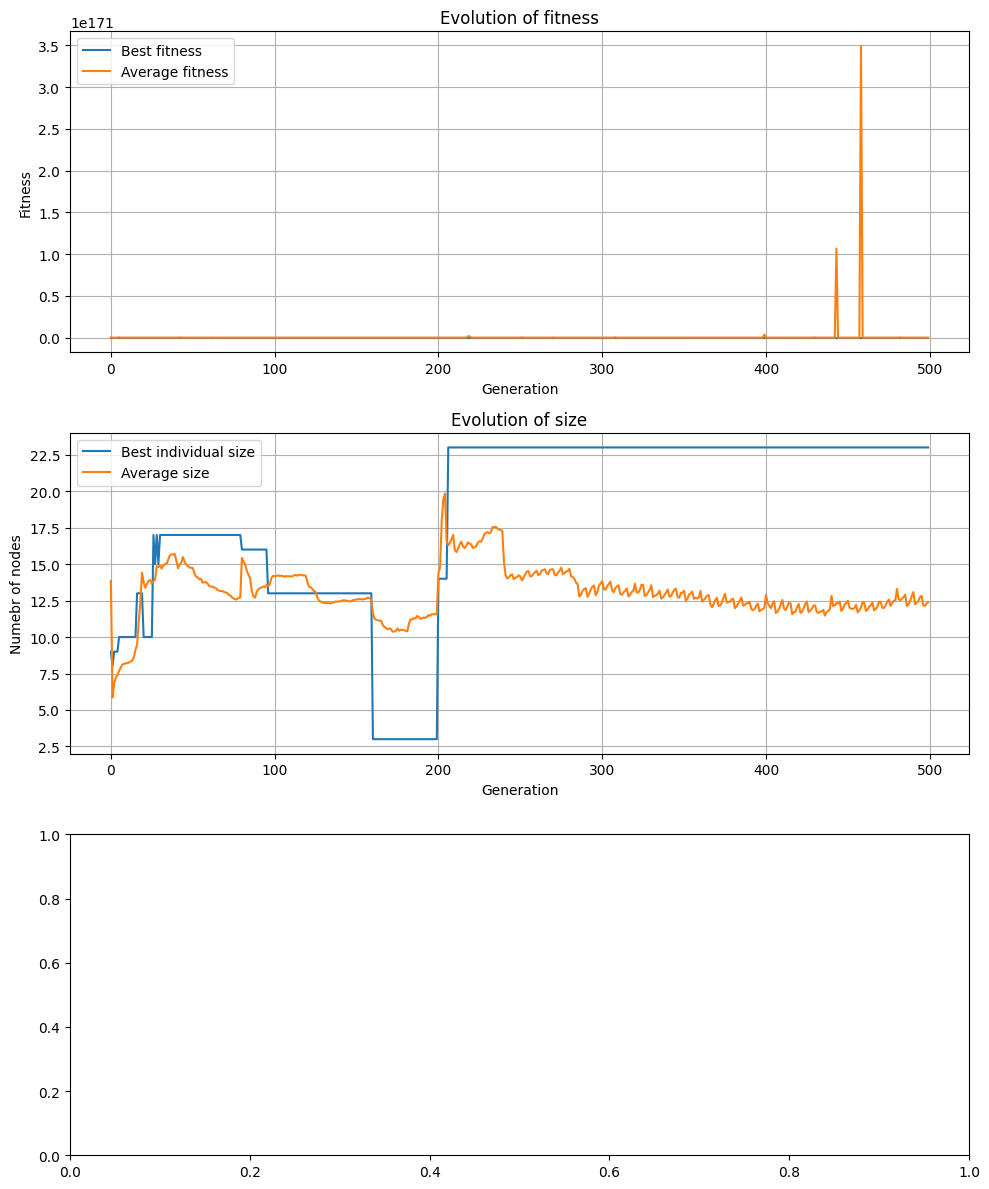

Original expression: (tan((tan(x[0]) + (x[0] + ((0.15322121158548999 * log(1.0)) - x[1])))) + (x[0] + ((0.15322121158548999 * (sin(x[1]) / x[1])) - x[0])))
Simplified expression: tan(x[0] - x[1] + tan(x[0])) + 0.15322121158548999*sin(x[1])/x[1]
Best fitness(MSE): 3.16172454411196e-11


In [369]:
print(f"\n=== GP execution on {problems[0]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[0]['file_path'], 
    problems[0]['config'],
    function_weights=problems[0]['config'].get('function_weights'),
    terminal_weights=problems[0]['config'].get('terminal_weights'),
    use_islands=problems[0].get('use_islands', False),
    n_islands=problems[0].get('n_islands', 5),
    migration_interval=problems[0].get('migration_interval', 10),
    migration_rate=problems[0].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_1.npz ===
Loading data from ../data/problem_1.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (500, 1), y shape (500,)
Input 1-dimensional with 500 samples

GP execution on ../data/problem_1.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=100
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.46 seconds
  Generated  2000 individuals in  0.48 seconds
  Generated  3000 individuals in  0.50 seconds
  Generated  4000 individuals in  0.53 seconds
  Generated  5000 individuals in  0.56 seconds
  Generated  6000 individuals in  0.59 seconds
  Generated  7

  0%|          | 0/100 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 7.125940794232773e-33 | Mutation Strength: 0.90
Bloat control: 298 individuals exceed the maximum size
Bloat control: 285 individuals exceed the maximum size
Bloat control: 275 individuals exceed the maximum size
Bloat control: 204 individuals exceed the maximum size
Bloat control: 243 individuals exceed the maximum size


  1%|          | 1/100 [01:25<2:20:16, 85.01s/it]

New best solution found:
  Expression: (log((((x[0] - -0.16509530021654029) * 0.3782860327383275) * (x[0] - x[0]))) + sin(x[0]))
  Simplified Expression: 0.0 + sinx[0])
  Fitness: 7.125940794232773e-33
  Complexity: 13 nodes
Generation 0, Best Fitness: 7.125940794232773e-33


  5%|▌         | 5/100 [06:57<2:11:56, 83.33s/it]

Bloat control: 24 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 6/100 [08:32<2:16:28, 87.11s/it]

Generation 5, Best Fitness: 7.125940794232773e-33


  7%|▋         | 7/100 [09:56<2:13:20, 86.03s/it]

New best solution found:
  Expression: (((sin(x[0]) - x[0]) + x[0]) * ((x[0] * 0.3782860327383275) / (((sin(x[0]) - x[0]) + x[0]) * (x[0] / (x[0] * x[0])))))
  Simplified Expression: 0.3782860327383275*x[0]**2
  Fitness: 5.692674661673975e-33
  Complexity: 23 nodes


 10%|█         | 10/100 [14:05<2:06:13, 84.15s/it]

Bloat control: 154 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 11%|█         | 11/100 [15:37<2:08:23, 86.55s/it]

Generation 10, Best Fitness: 5.692674661673975e-33


 12%|█▏        | 12/100 [17:01<2:05:37, 85.66s/it]

New best solution found:
  Expression: (((x[0] - x[0]) + x[0]) * ((x[0] * 0.3782860327383275) / ((-0.7458863362755191 + x[0]) * x[0])))
  Simplified Expression: 0.3782860327383275*x[0]/(x[0] - 0.7458863362755191)
  Fitness: 7.125940794232773e-34
  Complexity: 15 nodes


 15%|█▌        | 15/100 [21:12<1:59:25, 84.31s/it]

Bloat control: 42 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 16%|█▌        | 16/100 [22:42<2:00:40, 86.19s/it]

Generation 15, Best Fitness: 7.125940794232773e-34


 20%|██        | 20/100 [28:20<1:53:14, 84.93s/it]

Bloat control: 33 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 27 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 21%|██        | 21/100 [29:53<1:54:44, 87.15s/it]

Generation 20, Best Fitness: 7.125940794232773e-34


 25%|██▌       | 25/100 [35:26<1:45:23, 84.31s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 17 individuals exceed the maximum size
Bloat control: 17 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size


 26%|██▌       | 26/100 [37:00<1:47:23, 87.08s/it]

Generation 25, Best Fitness: 7.125940794232773e-34


 30%|███       | 30/100 [42:33<1:38:02, 84.03s/it]

Bloat control: 12 individuals exceed the maximum size
Bloat control: 44 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 31%|███       | 31/100 [44:07<1:40:09, 87.09s/it]

Generation 30, Best Fitness: 7.125940794232773e-34


 35%|███▌      | 35/100 [49:39<1:30:58, 83.98s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 55 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size


 36%|███▌      | 36/100 [51:14<1:33:20, 87.50s/it]

Generation 35, Best Fitness: 7.125940794232773e-34


 39%|███▉      | 39/100 [55:23<1:25:54, 84.50s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.006
  Island 2 diversity: 0.006
  Island 3 diversity: 0.006


 40%|████      | 40/100 [56:51<1:25:25, 85.42s/it]

  Island 4 diversity: 0.006
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 11 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 19 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 210 individuals exceed the maximum size


 41%|████      | 41/100 [58:25<1:26:42, 88.17s/it]

Generation 40, Best Fitness: 7.125940794232773e-34


 45%|████▌     | 45/100 [1:03:53<1:16:21, 83.31s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 46%|████▌     | 46/100 [1:05:26<1:17:44, 86.38s/it]

Generation 45, Best Fitness: 7.125940794232773e-34


 50%|█████     | 50/100 [1:10:52<1:08:47, 82.55s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 51%|█████     | 51/100 [1:12:25<1:10:05, 85.82s/it]

Generation 50, Best Fitness: 7.125940794232773e-34


 55%|█████▌    | 55/100 [1:17:50<1:01:46, 82.36s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 56%|█████▌    | 56/100 [1:19:25<1:03:07, 86.08s/it]

Generation 55, Best Fitness: 7.125940794232773e-34


 60%|██████    | 60/100 [1:24:52<55:15, 82.89s/it]  

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 61%|██████    | 61/100 [1:26:26<56:00, 86.17s/it]

Generation 60, Best Fitness: 7.125940794232773e-34


 65%|██████▌   | 65/100 [1:31:52<48:12, 82.63s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 66%|██████▌   | 66/100 [1:33:25<48:36, 85.77s/it]

Generation 65, Best Fitness: 7.125940794232773e-34


 70%|███████   | 70/100 [1:38:50<41:12, 82.42s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 71%|███████   | 71/100 [1:40:23<41:22, 85.61s/it]

Generation 70, Best Fitness: 7.125940794232773e-34


 75%|███████▌  | 75/100 [1:45:46<34:09, 81.99s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 76%|███████▌  | 76/100 [1:47:20<34:10, 85.45s/it]

Generation 75, Best Fitness: 7.125940794232773e-34


 79%|███████▉  | 79/100 [1:51:25<29:03, 83.02s/it]

Performing inter-island migration...
  Island 0 diversity: 0.011
  Island 1 diversity: 0.009
  Island 2 diversity: 0.009
  Island 3 diversity: 0.009


 80%|████████  | 80/100 [1:52:53<28:10, 84.51s/it]

  Island 4 diversity: 0.009
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 81%|████████  | 81/100 [1:54:29<27:49, 87.84s/it]

Generation 80, Best Fitness: 7.125940794232773e-34


 85%|████████▌ | 85/100 [1:59:56<20:49, 83.33s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 86%|████████▌ | 86/100 [2:01:29<20:07, 86.25s/it]

Generation 85, Best Fitness: 7.125940794232773e-34


 90%|█████████ | 90/100 [2:06:56<13:51, 83.20s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 91/100 [2:08:31<12:58, 86.55s/it]

Generation 90, Best Fitness: 7.125940794232773e-34


 95%|█████████▌| 95/100 [2:14:14<07:09, 85.98s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 96%|█████████▌| 96/100 [2:15:51<05:57, 89.45s/it]

Generation 95, Best Fitness: 7.125940794232773e-34


100%|██████████| 100/100 [2:21:24<00:00, 84.84s/it]

Generation 99, Best Fitness: 7.125940794232773e-34
Algorithm completed in 8879.71 seconds
Best solution found:
  Simplified Expression: 0.3782860327383275*x[0]/(x[0] - 0.7458863362755191)
  Expression: (((x[0] - x[0]) + x[0]) * ((x[0] * 0.3782860327383275) / ((-0.7458863362755191 + x[0]) * x[0])))
  Fitness: 7.125940794232773e-34
  Complexity: 15 nodes


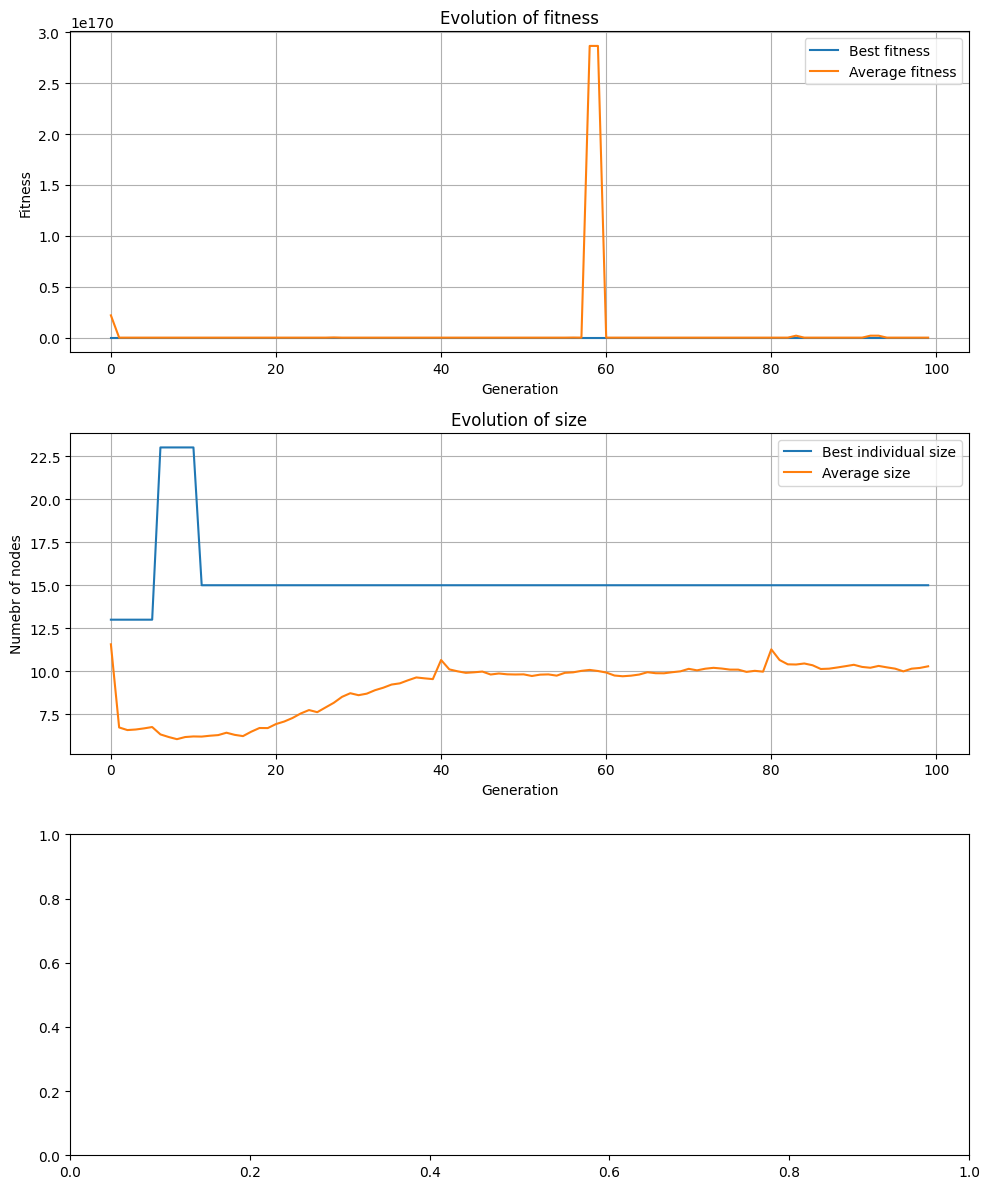

Original expression: (((x[0] - x[0]) + x[0]) * ((x[0] * 0.3782860327383275) / ((-0.7458863362755191 + x[0]) * x[0])))
Simplified expression: 0.3782860327383275*x[0]/(x[0] - 0.7458863362755191)
Best fitness(MSE): 7.125940794232773e-34


In [370]:
print(f"\n=== GP execution on {problems[1]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[1]['file_path'], 
    problems[1]['config'],
    function_weights=problems[1]['config'].get('function_weights'),
    terminal_weights=problems[1]['config'].get('terminal_weights'),
    use_islands=problems[1].get('use_islands', False),
    n_islands=problems[1].get('n_islands', 5),
    migration_interval=problems[1].get('migration_interval', 10),
    migration_rate=problems[1].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_2.npz ===
Loading data from ../data/problem_2.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 3), y shape (5000,)
Input 3-dimensional with 5000 samples

GP execution on ../data/problem_2.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.03 seconds
  Generated  2000 individuals in  0.05 seconds
  Generated  3000 individuals in  0.08 seconds
  Generated  4000 individuals in  0.11 seconds
  Generated  5000 individuals in  0.58 seconds
  Generated  6000 individuals in  0.61 seconds
  Generated

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 29474512692249.934 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 29594289076832.48 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 29560376822765.797 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 29589320848038.38 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 29598487936828.492 | Mutation Strength: 0.90
Bloat control: 117 individuals exceed the maximum size
Bloat control: 113 individuals exceed the maximum size
Bloat control: 174 individuals exceed the maximum size
Bloat control: 171 individuals exceed the maximum size
Bloat control: 125 individuals exceed the maximum size


  0%|          | 1/500 [01:26<11:58:02, 86.34s/it]

New best solution found:
  Expression: ((sin(log(((sqrt((x[1] - x[0])) + x[2]) + x[2]))) * ((-698492.0335860346 / x[1]) - (x[2] * x[0]))) * log(cos(x[1])))
  Simplified Expression: (-x[0]*x[2] - 698492.0335860346/x[1])*log(cos(x[1]))*sin(log(2*x[2] + sqrt(-x[0] + x[1])))
  Fitness: 29474512692249.934
  Complexity: 22 nodes
Generation 0, Best Fitness: 29474512692249.934


  0%|          | 2/500 [02:49<11:40:09, 84.36s/it]

New best solution found:
  Expression: ((sin(log(((x[0] + x[2]) + x[2]))) * ((-698492.0335860346 / x[1]) - ((x[0] * 707846.9281222131) + log(x[2])))) * log(cos(x[1])))
  Simplified Expression: (-707846.9281222131*x[0] - log(x[2]) - 698492.0335860346/x[1])*log(cos(x[1]))*sin(log(x[0] + 2*x[2]))
  Fitness: 27504112811038.453
  Complexity: 22 nodes


  1%|          | 4/500 [05:37<11:33:57, 83.95s/it]

New best solution found:
  Expression: (sqrt(tan(x[0])) - ((-694205.1764436075 * x[0]) * sqrt(tan((x[1] + 1530303.0128992675)))))
  Simplified Expression: 694205.1764436075*x[0]*sqrt(tan(x[1] + 1530303.0128992675)) + sqrt(tan(x[0]))
  Fitness: 27197932616327.336
  Complexity: 13 nodes


  1%|          | 5/500 [07:01<11:34:56, 84.24s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 417 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


  1%|          | 6/500 [08:29<11:42:36, 85.34s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * (sqrt(((6612406.381954773 * x[1]) / (x[0] + x[2]))) * cos(exp((-6059532.14109645 - x[1]))))))) - ((cos(exp(cos(((-5079176.543375168 * 2.718281828459045) - (x[0] / x[2]))))) / (exp(x[2]) * (x[1] - x[2]))) - ((cos((((0.0 + x[2]) - (x[0] * x[1])) * 3231466.613500922)) - (sin(log((x[2] - x[0]))) * ((tan(x[0]) - (-4973158.007173348 * x[0])) - ((-2589289.258923933 * x[1]) - (x[2] + x[1]))))) * tan(log(sin(((x[1] / x[2]) * (-5946618.750242825 * x[0]))))))))
  Simplified Expression: (-(4973158.007173348*x[0] + 2589290.258923933*x[1] + x[2] + tan(x[0]))*sin(log(-x[0] + x[2])) + cos(3231466.613500922*x[0]*x[1] - 3231466.613500922*x[2]))*tan(log(-sin(5946618.750242825*x[0]*x[1]/x[2]))) + tan(sin(2571.459970902672*sqrt(x[1]/(x[0] + x[2]))*exp(sqrt(sin(sqrt(x[1]))))*cos(4.24821428371283e-2631622*exp(-x[1])))) - exp(-x[2])*cos(exp(cos(x[0]/x[2] + 13806633.30139214)))/(x[1] - x[2])
  Fitness: 21332060093650.445
  Complexity

  1%|▏         | 7/500 [09:52<11:36:54, 84.82s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * (sqrt(((6612406.381954773 * x[1]) / (x[0] + x[2]))) * cos(exp((-6059532.14109645 - x[1]))))))) - ((cos(exp(cos(((-5079176.543375168 * 2.718281828459045) - (x[0] / x[2]))))) / (exp(x[2]) * (x[1] - x[2]))) - (x[0] * tan(log(sin(-688856.600521585))))))
  Simplified Expression: -1.24899629828396*x[0] + tan(sin(2571.459970902672*sqrt(x[1]/(x[0] + x[2]))*exp(sqrt(sin(sqrt(x[1]))))*cos(4.24821428371283e-2631622*exp(-x[1])))) - exp(-x[2])*cos(exp(cos(x[0]/x[2] + 13806633.30139214)))/(x[1] - x[2])
  Fitness: 18916610833605.21
  Complexity: 47 nodes


  2%|▏         | 8/500 [11:18<11:36:37, 84.95s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * (sqrt(((6612406.381954773 * x[1]) / (x[0] + x[2]))) * cos(exp((-6059532.14109645 - x[1]))))))) - ((cos(exp(cos(((-5079176.543375168 * 2.718281828459045) - (x[0] / x[2]))))) / ((exp(sqrt((x[1] * x[2]))) / exp(exp(sin(x[0])))) * exp(((sqrt(-6473403.589681479) + cos(x[0])) * (x[1] - x[2]))))) - ((cos((((0.0 + x[2]) - (x[0] * x[1])) * 3231466.613500922)) - (sin(x[2]) * ((tan(x[0]) - (-4973158.007173348 * x[0])) - ((-2589289.258923933 * x[1]) - (x[2] + x[1]))))) * tan(log(sin(((x[1] / x[2]) * (-5946618.750242825 * x[0]))))))))
  Simplified Expression: tan(sin(exp(sqrt(sin(sqrtx[1])) * (sqrt(6612406.381954773 * x[1]) / (x[0] + x[2]) * cos(exp(-6059532.14109645 - x[1])))))) - (cos(exp(cos(-5079176.543375168 * 2.718281828459045) - (x[0] / x[2])) / (exp(sqrt(x[1] * x[2]) / exp(exp(sinx[0]))) * exp(sqrt(-6473403.589681479) + cosx[0] * (x[1] - x[2])))) - (cosx[2] - (x[0] * x[1]) * 3231466.613500922) - (sinx[2] * (tanx[0

  2%|▏         | 10/500 [14:08<11:35:09, 85.12s/it]

Bloat control: 414 individuals exceed the maximum size


  2%|▏         | 11/500 [15:36<11:41:12, 86.04s/it]

Generation 10, Best Fitness: 18916598817588.984


  2%|▏         | 12/500 [17:02<11:37:32, 85.76s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * (sqrt(((-2666056.2263419526 * x[1]) / (x[0] + x[2]))) * x[1])))) - ((cos(x[1]) / ((sqrt(sqrt(3170882.5407191413)) / exp(exp(sin(x[0])))) * exp(((sqrt(x[0]) + cos(x[0])) * ((x[0] / x[2]) * log(x[1])))))) - ((cos(x[0]) - (sin(log(1530303.0128992675)) * ((tan(x[0]) - (-4973158.007173348 * x[0])) - ((-2589289.258923933 * x[1]) - (x[2] + x[1]))))) * tan(log(sin(((x[1] / x[2]) * x[2])))))))
  Simplified Expression: (-4946385.7237943406*x[0] - 2575351.1859118901*x[1] - 0.99461664331992052*x[2] + cos(x[0]) - 0.99461664331992052*tan(x[0]))*tan(log(sin(x[1]))) + tan(sin(1632.8062427434409*x[1]*sqrt(-x[1]/(x[0] + x[2]))*exp(sqrt(sin(sqrt(x[1])))))) - 0.023697632560807119*exp(-x[0]*(sqrt(x[0]) + cos(x[0]))*log(x[1])/x[2])*exp(exp(sin(x[0])))*cos(x[1])
  Fitness: 18790510203191.67
  Complexity: 75 nodes


  3%|▎         | 15/500 [21:18<11:32:37, 85.69s/it]

Bloat control: 460 individuals exceed the maximum size


  3%|▎         | 16/500 [22:55<11:58:41, 89.09s/it]

Generation 15, Best Fitness: 18790510203191.67


  3%|▎         | 17/500 [24:27<12:04:11, 89.96s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * (sqrt(((6612406.381954773 * x[1]) / (x[0] + x[2]))) * cos(exp((-6059532.14109645 - x[1]))))))) - ((cos(exp(x[0])) / ((sqrt(sqrt(3170882.5407191413)) / exp(exp(sin(x[0])))) * exp(((sqrt(x[0]) + cos(x[0])) * ((x[0] / x[2]) * log(x[1])))))) - ((cos((x[2] * 3231466.613500922)) - (sin(log(1530303.0128992675)) * ((tan(x[0]) - (-5357939.5267932685 * x[0])) - ((-2589289.258923933 * x[1]) - (x[2] + x[1]))))) * x[1])))
  Simplified Expression: x[1]*(-5329095.827250244*x[0] - 2575351.1859118901*x[1] - 0.99461664331992052*x[2] + cos(3231466.613500922*x[2]) - 0.99461664331992052*tan(x[0])) + tan(sin(2571.459970902672*sqrt(x[1]/(x[0] + x[2]))*exp(sqrt(sin(sqrt(x[1]))))*cos(4.24821428371283e-2631622*exp(-x[1])))) - 0.023697632560807119*exp(-x[0]*(sqrt(x[0]) + cos(x[0]))*log(x[1])/x[2])*exp(exp(sin(x[0])))*cos(exp(x[0]))
  Fitness: 18624569460642.48
  Complexity: 75 nodes


  4%|▍         | 20/500 [28:45<11:40:55, 87.62s/it]

Bloat control: 392 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  4%|▍         | 21/500 [30:14<11:43:12, 88.08s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * x[0]))) - ((cos(exp(x[0])) / ((sqrt(sqrt(3170882.5407191413)) / exp(exp(sin(x[0])))) * exp(((sqrt(x[0]) + cos(x[0])) * ((x[2] / x[2]) * log(x[1])))))) - ((cos((x[2] * 3231466.613500922)) - (sin(sqrt((x[2] + x[1]))) * ((tan(x[0]) - (-5357939.5267932685 * x[0])) - ((-2589289.258923933 * x[1]) - (x[2] + x[1]))))) * tan(log(sin(((x[0] / x[2]) * (-5946618.750242825 * x[0]))))))))
  Simplified Expression: (-(5357939.5267932685*x[0] + 2589290.258923933*x[1] + x[2] + tan(x[0]))*sin(sqrt(x[1] + x[2])) + cos(3231466.613500922*x[2]))*tan(log(-sin(5946618.750242825*x[0]**2/x[2]))) + tan(sin(x[0]*exp(sqrt(sin(sqrt(x[1])))))) - 0.023697632560807119*exp(-(sqrt(x[0]) + cos(x[0]))*log(x[1]))*exp(exp(sin(x[0])))*cos(exp(x[0]))
  Fitness: 18621499839927.594
  Complexity: 73 nodes
Generation 20, Best Fitness: 18621499839927.594


  4%|▍         | 22/500 [31:41<11:37:25, 87.54s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * x[0]))) - ((cos(exp(x[0])) / ((sqrt(sqrt(tan(x[1]))) / exp(exp(sin(x[0])))) * x[2])) - ((cos((x[2] * 3231466.613500922)) - (sin(sqrt((x[2] + x[1]))) * x[1])) * tan(log(sin(((x[1] / x[2]) * (-5946618.750242825 * x[0]))))))))
  Simplified Expression: (-x[1]*sin(sqrt(x[1] + x[2])) + cos(3231466.613500922*x[2]))*tan(log(-sin(5946618.750242825*x[0]*x[1]/x[2]))) + tan(sin(x[0]*exp(sqrt(sin(sqrt(x[1])))))) - exp(exp(sin(x[0])))*cos(exp(x[0]))/(x[2]*tan(x[1])**(1/4))
  Fitness: 17932638372929.09
  Complexity: 49 nodes


  5%|▍         | 23/500 [33:06<11:32:02, 87.05s/it]

New best solution found:
  Expression: (tan(sin((exp(sqrt(sin(sqrt(x[1])))) * x[0]))) - ((cos(exp(x[0])) / ((sqrt(sqrt(3170882.5407191413)) / exp(exp(sin(x[0])))) * exp(((sqrt(x[0]) + cos(x[0])) * (sqrt(x[2]) * log(x[1])))))) - ((cos((x[2] * 3231466.613500922)) - (sin(sqrt((x[2] + x[1]))) * 5611241.097501977)) * tan(log(sin(((x[1] / x[2]) * (-5946618.750242825 * x[0]))))))))
  Simplified Expression: (-5611241.097501977*sin(sqrt(x[1] + x[2])) + cos(3231466.613500922*x[2]))*tan(log(-sin(5946618.750242825*x[0]*x[1]/x[2]))) + tan(sin(x[0]*exp(sqrt(sin(sqrt(x[1])))))) - 0.023697632560807119*exp(-sqrt(x[2])*(sqrt(x[0]) + cos(x[0]))*log(x[1]))*exp(exp(sin(x[0])))*cos(exp(x[0]))
  Fitness: 17931052260992.152
  Complexity: 59 nodes


  5%|▌         | 25/500 [35:59<11:26:55, 86.77s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


  5%|▌         | 26/500 [37:34<11:44:33, 89.19s/it]

Generation 25, Best Fitness: 17931052260992.152


  6%|▌         | 30/500 [43:35<11:53:25, 91.08s/it]

Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 31/500 [45:31<12:50:26, 98.56s/it]

Generation 30, Best Fitness: 17931052260992.152


  7%|▋         | 35/500 [51:45<12:19:23, 95.41s/it]

Bloat control: 37 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  7%|▋         | 36/500 [53:35<12:51:21, 99.74s/it]

New best solution found:
  Expression: ((1910534.4700999735 * x[0]) + (((-694205.1764436075 * x[0]) * sqrt((((x[2] + x[1]) - (sqrt(x[0]) * sin(x[0]))) - (log(x[1]) * sin(x[0]))))) * sqrt(sqrt(tan(((x[2] + x[1]) - ((-694205.1764436075 * x[0]) * 1910534.4700999735)))))))
  Simplified Expression: -694205.1764436075*x[0]*sqrt(-sqrt(x[0])*sin(x[0]) + x[1] + x[2] - log(x[1])*sin(x[0]))*tan(1326302918917.3463*x[0] + x[1] + x[2])**(1/4) + 1910534.4700999735*x[0]
  Fitness: 17394929526501.94
  Complexity: 37 nodes
Generation 35, Best Fitness: 17394929526501.94


  8%|▊         | 39/500 [58:08<12:03:22, 94.15s/it]

Performing inter-island migration...
  Island 0 diversity: 0.208
  Island 1 diversity: 0.119
  Island 2 diversity: 0.169
  Island 3 diversity: 0.188


  8%|▊         | 40/500 [59:53<12:26:08, 97.32s/it]

  Island 4 diversity: 0.203
  Migration: 240 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.15)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 1.06)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.05)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 7 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 36 individuals exceed the maximum size


  8%|▊         | 41/500 [1:01:45<12:58:36, 101.78s/it]

Generation 40, Best Fitness: 17394929526501.94


  9%|▉         | 45/500 [1:07:50<11:49:15, 93.53s/it] 

Bloat control: 918 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 930 individuals exceed the maximum size


  9%|▉         | 46/500 [1:09:57<13:04:37, 103.69s/it]

Generation 45, Best Fitness: 17394929526501.94


  9%|▉         | 47/500 [1:11:29<12:34:50, 99.98s/it] 

New best solution found:
  Expression: ((x[0] * (((((x[1] + x[2]) - log(cos(x[0]))) * sqrt(-7752860.986714187)) * (log((-5946618.750242825 * x[0])) - exp(x[0]))) + ((log(log(exp(x[2]))) / -6473403.589681479) + 1530303.0128992675))) + ((((log((x[1] + x[2])) * -688856.600521585) * sqrt(((-3066390.818329948 + -2455835.545532885) * log((7306457.253082092 + 5611241.097501977))))) * ((((x[1] + x[2]) - x[0]) - x[0]) - x[0])) - x[0]))
  Simplified Expression: x[0] * (x[1] + x[2]) - log(cosx[0] * sqrt(-7752860.986714187) * (log(-5946618.750242825 * x[0]) - expx[0] + (log(log(expx[2]) / -6473403.589681479) + 1530303.0128992675))) + (log(x[1] + x[2]) * -688856.600521585) * sqrt((-3066390.818329948 + -2455835.545532885) * log((7306457.253082092 + 5611241.097501977) * ((x[1] + x[2]) - x[0]) - x[0]) - x[0]) - x[0]
  Fitness: 12218366362967.994
  Complexity: 58 nodes


 10%|▉         | 48/500 [1:13:01<12:16:04, 97.71s/it]

New best solution found:
  Expression: ((x[0] * ((((x[0] - log(x[0])) * sqrt(6612406.381954773)) * -6841763.484185895) + x[0])) + ((-1077746.6078447392 * ((((x[1] + x[2]) - x[0]) - x[0]) - x[0])) - x[0]))
  Simplified Expression: x[0]*(-17593320928.96763*x[0] + 17593320929.96763*log(x[0])) + 3233238.8235342176*x[0] - 1077746.6078447392*x[1] - 1077746.6078447392*x[2]
  Fitness: 11846608716263.164
  Complexity: 27 nodes


 10%|█         | 50/500 [1:16:09<12:01:16, 96.17s/it]

Bloat control: 1242 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1391 individuals exceed the maximum size


 10%|█         | 51/500 [1:18:43<14:08:18, 113.36s/it]

Generation 50, Best Fitness: 11846608716263.164


 11%|█         | 53/500 [1:21:41<12:31:48, 100.91s/it]

New best solution found:
  Expression: ((x[0] * (((5611241.097501977 * sqrt(6612406.381954773)) * (log((-5946618.750242825 * (x[1] * 5290707.213133034))) - exp(x[0]))) + ((5611241.097501977 / -6473403.589681479) + 1530303.0128992675))) + ((((log((x[1] + x[2])) * log(((1530303.0128992675 / x[0]) / 1.0))) * sqrt(((cos(x[0]) + (7306457.253082092 + 5611241.097501977)) * log((7306457.253082092 + 5611241.097501977))))) * ((((x[1] + x[2]) - x[0]) - x[0]) - x[0])) - x[0]))
  Simplified Expression: x[0]*(-14429081869.31031*exp(x[0]) + 14429081869.31031*log(-31461818715661.86*x[1]) + 1530302.1460846128) - x[0] + sqrt(16.37410889420918*cos(x[0]) + 211515799.4550099)*(-3*x[0] + x[1] + x[2])*log(1530303.0128992675/x[0])*log(x[1] + x[2])
  Fitness: 11311659662637.668
  Complexity: 59 nodes


 11%|█         | 54/500 [1:23:17<12:18:48, 99.39s/it] 

New best solution found:
  Expression: ((x[0] * (((((x[1] + x[2]) - log(cos(-5946618.750242825))) * sqrt((7306457.253082092 + 5611241.097501977))) * (log((-5946618.750242825 * (x[1] * 5290707.213133034))) - exp(x[0]))) + ((5611241.097501977 / -6473403.589681479) + 1530303.0128992675))) + ((((log((x[1] + x[2])) * -6473403.589681479) * sqrt(((-3066390.818329948 + (7306457.253082092 + 5611241.097501977)) * log((7306457.253082092 + 5611241.097501977))))) * ((((x[1] + x[2]) - x[0]) - x[0]) - x[0])) - x[0]))
  Simplified Expression: x[0]*((-exp(x[0]) + log(-31461818715661.86*x[1]))*(3594.119968863598*x[1] + 3594.119968863598*x[2] + 7688.507011133629) + 1530302.1460846128) - x[0] - 82216400645.64416*(-3*x[0] + x[1] + x[2])*log(x[1] + x[2])
  Fitness: 11236964383872.88
  Complexity: 61 nodes


 11%|█         | 55/500 [1:24:49<12:02:36, 97.43s/it]

New best solution found:
  Expression: ((x[0] * (((((x[1] + x[2]) - log((x[0] / x[0]))) * sqrt(6612406.381954773)) * (log((-721544.1258293986 * (x[1] - -568814.9401437705))) - exp(x[0]))) + ((log(log(exp(x[2]))) / -6473403.589681479) + 1530303.0128992675))) + ((((log(((x[1] + x[2]) - sin(x[0]))) * log(6612406.381954773)) * -688856.600521585) * ((((x[1] + x[2]) - x[0]) - x[0]) - x[0])) - x[0]))
  Simplified Expression: x[0]*((2571.459970902672*x[1] + 2571.459970902672*x[2])*(-exp(x[0]) + log(-721544.1258293986*x[1] - 410425078744.7386)) - 1.544782410282571e-7*log(x[2]) + 1530303.0128992675) - x[0] - 10818119.68683235*(-3*x[0] + x[1] + x[2])*log(x[1] + x[2] - sin(x[0]))
  Fitness: 10936200681076.045
  Complexity: 57 nodes
Bloat control: 1316 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 11%|█         | 56/500 [1:27:13<13:42:56, 111.21s/it]

Generation 55, Best Fitness: 10936200681076.045


 12%|█▏        | 60/500 [1:33:10<11:33:40, 94.59s/it] 

Bloat control: 458 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:35:32<13:15:53, 108.78s/it]

Generation 60, Best Fitness: 10936200681076.045


 13%|█▎        | 65/500 [1:41:27<11:18:57, 93.65s/it] 

Bloat control: 42 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 13%|█▎        | 66/500 [1:43:58<13:21:08, 110.76s/it]

Generation 65, Best Fitness: 10936200681076.045


 14%|█▍        | 70/500 [1:49:51<11:11:16, 93.67s/it] 

Bloat control: 3 individuals exceed the maximum size


 14%|█▍        | 71/500 [1:52:20<13:09:28, 110.42s/it]

Generation 70, Best Fitness: 10936200681076.045


 15%|█▌        | 75/500 [1:58:14<11:04:56, 93.87s/it] 

Bloat control: 5 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:00:29<12:30:16, 106.17s/it]

Generation 75, Best Fitness: 10936200681076.045


 16%|█▌        | 79/500 [2:04:55<11:04:57, 94.77s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.083
  Island 1 diversity: 0.145
  Island 2 diversity: 0.058
  Island 3 diversity: 0.132


 16%|█▌        | 80/500 [2:06:32<11:07:46, 95.40s/it]

  Island 4 diversity: 0.087
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.19)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 1.22)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 3 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:08:58<12:51:41, 110.50s/it]

Generation 80, Best Fitness: 10936200681076.045


 17%|█▋        | 85/500 [2:14:58<10:57:45, 95.10s/it] 

Bloat control: 4 individuals exceed the maximum size


 17%|█▋        | 86/500 [2:17:52<13:38:25, 118.61s/it]

Generation 85, Best Fitness: 10936200681076.045


 18%|█▊        | 90/500 [2:23:53<11:03:41, 97.12s/it] 

Bloat control: 2 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:26:49<13:42:13, 120.62s/it]

Generation 90, Best Fitness: 10936200681076.045


 19%|█▉        | 96/500 [2:35:27<12:56:11, 115.28s/it]

Generation 95, Best Fitness: 10936200681076.045


 20%|██        | 100/500 [2:41:27<10:40:42, 96.11s/it]

Island 0 | Generation 100 | Best Fitness: 10936200681076.045 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 17394929526501.94 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 11996506474196.637 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 14563586085448.23 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 10936200681076.045 | Mutation Strength: 3.00


 20%|██        | 101/500 [2:44:14<12:59:08, 117.16s/it]

Generation 100, Best Fitness: 10936200681076.045


 21%|██        | 106/500 [2:53:06<13:02:41, 119.19s/it]

Generation 105, Best Fitness: 10936200681076.045


 22%|██▏       | 110/500 [2:59:04<10:29:01, 96.77s/it] 

Bloat control: 1 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:01:56<12:54:11, 119.41s/it]

Generation 110, Best Fitness: 10936200681076.045


 23%|██▎       | 116/500 [3:10:43<12:32:06, 117.52s/it]

Generation 115, Best Fitness: 10936200681076.045


 24%|██▍       | 119/500 [3:15:14<10:33:05, 99.70s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.120
  Island 1 diversity: 0.116
  Island 2 diversity: 0.116
  Island 3 diversity: 0.130


 24%|██▍       | 120/500 [3:16:55<10:33:11, 99.98s/it]

  Island 4 diversity: 0.141
  Migration: 240 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 1.04)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.03)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)


 24%|██▍       | 121/500 [3:19:27<12:10:15, 115.61s/it]

Generation 120, Best Fitness: 10936200681076.045


 25%|██▌       | 126/500 [3:28:14<12:10:49, 117.24s/it]

Generation 125, Best Fitness: 10936200681076.045


 26%|██▌       | 131/500 [3:37:00<11:59:12, 116.94s/it]

Generation 130, Best Fitness: 10936200681076.045


 27%|██▋       | 135/500 [3:43:01<9:47:41, 96.61s/it]  

Bloat control: 1 individuals exceed the maximum size


 27%|██▋       | 136/500 [3:45:53<12:03:16, 119.22s/it]

Generation 135, Best Fitness: 10936200681076.045


 28%|██▊       | 141/500 [3:54:51<12:04:23, 121.07s/it]

Generation 140, Best Fitness: 10936200681076.045


 29%|██▉       | 145/500 [4:00:54<9:39:47, 97.99s/it]  

Bloat control: 1 individuals exceed the maximum size


 29%|██▉       | 146/500 [4:03:49<11:55:11, 121.22s/it]

Generation 145, Best Fitness: 10936200681076.045


 30%|███       | 151/500 [4:12:51<11:46:59, 121.55s/it]

Generation 150, Best Fitness: 10936200681076.045


 31%|███       | 156/500 [4:21:44<11:29:35, 120.28s/it]

Generation 155, Best Fitness: 10936200681076.045


 32%|███▏      | 159/500 [4:26:16<9:32:15, 100.69s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.121
  Island 1 diversity: 0.125
  Island 2 diversity: 0.115
  Island 3 diversity: 0.130
  Island 4 diversity: 0.123
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 0.50)


 32%|███▏      | 160/500 [4:27:56<9:30:17, 100.64s/it]

  Migration: 240 individuals from island 2 to island 3(mutation strength: 1.05)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)


 32%|███▏      | 161/500 [4:30:21<10:42:41, 113.75s/it]

Generation 160, Best Fitness: 10936200681076.045


 33%|███▎      | 166/500 [4:39:17<11:04:13, 119.32s/it]

Generation 165, Best Fitness: 10936200681076.045


 34%|███▍      | 171/500 [4:48:18<11:05:37, 121.39s/it]

Generation 170, Best Fitness: 10936200681076.045


 35%|███▌      | 176/500 [4:57:07<10:38:53, 118.31s/it]

Generation 175, Best Fitness: 10936200681076.045


 36%|███▌      | 180/500 [5:03:12<8:41:13, 97.73s/it]  

Bloat control: 2 individuals exceed the maximum size


 36%|███▌      | 181/500 [5:05:53<10:20:14, 116.66s/it]

Generation 180, Best Fitness: 10936200681076.045


 37%|███▋      | 185/500 [5:11:59<8:32:24, 97.60s/it]  

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 37%|███▋      | 186/500 [5:14:45<10:18:05, 118.11s/it]

Generation 185, Best Fitness: 10936200681076.045


 38%|███▊      | 191/500 [5:23:35<10:08:22, 118.13s/it]

Generation 190, Best Fitness: 10936200681076.045


 38%|███▊      | 192/500 [5:25:07<9:25:57, 110.25s/it] 

New best solution found:
  Expression: ((2483053.076972577 * x[0]) + (((-923314.0435987484 * x[0]) * sqrt((((x[2] + x[1]) - (sqrt(x[0]) * sin(x[0]))) - (sqrt((x[2] + x[1])) / sin(sin(x[0])))))) * sqrt(((sin((cos(726230.1539022494) * exp(x[1]))) + 3394242.878959666) - (sqrt((x[2] + x[1])) * sin(x[0]))))))
  Simplified Expression: -923314.0435987484*x[0]*sqrt(-sqrt(x[1] + x[2])*sin(x[0]) + sin(0.7340412491373853*exp(x[1])) + 3394242.878959666)*sqrt(-sqrt(x[0])*sin(x[0]) + x[1] + x[2] - sqrt(x[1] + x[2])/sin(sin(x[0]))) + 2483053.076972577*x[0]
  Fitness: 9767968502866.596
  Complexity: 45 nodes


 39%|███▉      | 196/500 [5:32:23<9:54:21, 117.31s/it]

Generation 195, Best Fitness: 9767968502866.596


 40%|███▉      | 199/500 [5:36:57<8:22:58, 100.26s/it]

Performing inter-island migration...
  Island 0 diversity: 0.123
  Island 1 diversity: 0.120
  Island 2 diversity: 0.122
  Island 3 diversity: 0.114


 40%|████      | 200/500 [5:38:38<8:22:27, 100.49s/it]

  Island 4 diversity: 0.116
  Migration: 240 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 1.02)
Island 0 | Generation 200 | Best Fitness: 9767968502866.596 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 16983954252156.102 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 11156164445313.102 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 11156164445313.102 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 10936200681076.045 | Mutation Strength: 3.00


 40%|████      | 201/500 [5:41:11<9:38:28, 116.08s/it]

Generation 200, Best Fitness: 9767968502866.596


 41%|████      | 206/500 [5:50:20<10:02:31, 122.97s/it]

Generation 205, Best Fitness: 9767968502866.596


 42%|████▏     | 211/500 [5:59:23<9:48:01, 122.08s/it] 

Generation 210, Best Fitness: 9767968502866.596


 43%|████▎     | 215/500 [6:05:34<7:53:40, 99.72s/it] 

Bloat control: 2 individuals exceed the maximum size


 43%|████▎     | 216/500 [6:08:38<9:51:40, 125.00s/it]

Generation 215, Best Fitness: 9767968502866.596


 44%|████▍     | 221/500 [6:17:38<9:26:22, 121.80s/it]

Generation 220, Best Fitness: 9767968502866.596


 45%|████▌     | 225/500 [6:23:49<7:37:02, 99.72s/it] 

Bloat control: 2 individuals exceed the maximum size


 45%|████▌     | 226/500 [6:26:57<9:36:06, 126.16s/it]

Generation 225, Best Fitness: 9767968502866.596


 46%|████▌     | 230/500 [6:33:06<7:31:56, 100.43s/it]

Bloat control: 3 individuals exceed the maximum size


 46%|████▌     | 231/500 [6:36:14<9:28:47, 126.87s/it]

Generation 230, Best Fitness: 9767968502866.596


 47%|████▋     | 235/500 [6:42:24<7:25:12, 100.80s/it]

Bloat control: 1 individuals exceed the maximum size


 47%|████▋     | 236/500 [6:45:20<9:02:08, 123.21s/it]

Generation 235, Best Fitness: 9767968502866.596


 48%|████▊     | 239/500 [6:49:56<7:26:28, 102.64s/it]

Performing inter-island migration...
  Island 0 diversity: 0.123
  Island 1 diversity: 0.133
  Island 2 diversity: 0.118
  Island 3 diversity: 0.117
  Island 4 diversity: 0.120


 48%|████▊     | 240/500 [6:51:38<7:24:29, 102.58s/it]

  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.03)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 3 individuals exceed the maximum size


 48%|████▊     | 241/500 [6:54:16<8:34:11, 119.12s/it]

Generation 240, Best Fitness: 9767968502866.596


 49%|████▉     | 245/500 [7:00:36<7:08:52, 100.91s/it]

Bloat control: 1 individuals exceed the maximum size


 49%|████▉     | 246/500 [7:03:26<8:34:49, 121.61s/it]

Generation 245, Best Fitness: 9767968502866.596


 50%|█████     | 250/500 [7:09:45<7:01:54, 101.26s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 50%|█████     | 251/500 [7:12:41<8:33:32, 123.75s/it]

Generation 250, Best Fitness: 9767968502866.596


 51%|█████     | 256/500 [7:22:06<8:36:42, 127.06s/it]

Generation 255, Best Fitness: 9767968502866.596


 52%|█████▏    | 260/500 [7:28:25<6:49:45, 102.44s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 52%|█████▏    | 261/500 [7:31:48<8:48:19, 132.63s/it]

Generation 260, Best Fitness: 9767968502866.596


 53%|█████▎    | 265/500 [7:38:08<6:47:28, 104.04s/it]

Bloat control: 1 individuals exceed the maximum size


 53%|█████▎    | 266/500 [7:41:14<8:21:30, 128.59s/it]

Generation 265, Best Fitness: 9767968502866.596


 54%|█████▍    | 270/500 [7:48:20<7:22:11, 115.36s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 54%|█████▍    | 271/500 [7:52:12<9:33:36, 150.29s/it]

Generation 270, Best Fitness: 9767968502866.596


 55%|█████▌    | 275/500 [8:00:30<8:10:14, 130.73s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 55%|█████▌    | 276/500 [8:04:32<10:12:20, 164.02s/it]

Generation 275, Best Fitness: 9767968502866.596


 56%|█████▌    | 279/500 [8:10:52<8:33:55, 139.53s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.107
  Island 1 diversity: 0.111
  Island 2 diversity: 0.102
  Island 3 diversity: 0.119


 56%|█████▌    | 280/500 [8:13:09<8:29:03, 138.83s/it]

  Island 4 diversity: 0.117
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 1.05)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 56%|█████▌    | 281/500 [8:17:25<10:35:08, 174.01s/it]

New best solution found:
  Expression: ((2524427.9738367125 * x[0]) + (((-935256.3075292134 * x[0]) * sqrt((((x[2] + x[1]) - (tan(0.9792245063047973) * sin(x[0]))) - (exp((x[2] + x[1])) / sin(sin(x[0])))))) * sqrt((sin(sin(sin(x[0]))) - (sqrt((x[2] + x[1])) * sin(x[0]))))))
  Simplified Expression: -935256.3075292134*x[0]*sqrt(-sqrt(x[1] + x[2])*sin(x[0]) + sin(sin(sin(x[0]))))*sqrt(x[1] + x[2] - exp(x[1] + x[2])/sin(sin(x[0])) - 1.488461769611452*sin(x[0])) + 2524427.9738367125*x[0]
  Fitness: 8885482816206.46
  Complexity: 41 nodes
Generation 280, Best Fitness: 8885482816206.46


 57%|█████▋    | 284/500 [8:23:54<8:43:57, 145.55s/it] 

New best solution found:
  Expression: ((2517273.640133438 * x[0]) + (((-932678.0470267775 * x[0]) * sqrt((((x[2] + x[1]) - (tan(0.9858538820430192) * sin(x[0]))) - ((exp(x[1]) - x[2]) / sin(sin(x[0])))))) * sqrt((sin(sin(sin(x[0]))) - (sqrt((x[2] + x[1])) * sin(x[0]))))))
  Simplified Expression: -932678.0470267775*x[0]*sqrt(-sqrt(x[1] + x[2])*sin(x[0]) + sin(sin(sin(x[0]))))*sqrt(x[1] + x[2] - (-x[2] + exp(x[1]))/sin(sin(x[0])) - 1.509991410227271*sin(x[0])) + 2517273.640133438*x[0]
  Fitness: 8883917652321.518
  Complexity: 41 nodes


 57%|█████▋    | 285/500 [8:25:56<8:16:45, 138.63s/it]

Bloat control: 2 individuals exceed the maximum size


 57%|█████▋    | 286/500 [8:30:03<10:09:53, 171.00s/it]

Generation 285, Best Fitness: 8883917652321.518


 58%|█████▊    | 290/500 [8:37:09<7:04:54, 121.40s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 58%|█████▊    | 291/500 [8:40:35<8:31:25, 146.82s/it]

Generation 290, Best Fitness: 8883917652321.518


 59%|█████▉    | 295/500 [8:47:01<6:12:43, 109.09s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 59%|█████▉    | 296/500 [8:50:51<8:13:33, 145.17s/it]

Generation 295, Best Fitness: 8883917652321.518


 60%|██████    | 300/500 [8:58:17<6:38:28, 119.54s/it]

Island 0 | Generation 300 | Best Fitness: 9767968502866.596 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 8885482816206.46 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 11156164445313.102 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 11156164445313.102 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 8883917652321.518 | Mutation Strength: 3.00
Bloat control: 2 individuals exceed the maximum size


 60%|██████    | 301/500 [9:03:00<9:19:21, 168.65s/it]

Generation 300, Best Fitness: 8883917652321.518


 61%|██████    | 305/500 [9:10:18<6:36:21, 121.96s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 61%|██████    | 306/500 [9:13:49<8:00:35, 148.64s/it]

Generation 305, Best Fitness: 8883917652321.518


 62%|██████▏   | 310/500 [9:20:38<6:01:19, 114.10s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 62%|██████▏   | 311/500 [9:24:06<7:28:13, 142.29s/it]

Generation 310, Best Fitness: 8883917652321.518


 63%|██████▎   | 315/500 [9:30:32<5:31:49, 107.62s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 63%|██████▎   | 316/500 [9:34:02<7:04:46, 138.51s/it]

Generation 315, Best Fitness: 8883917652321.518


 64%|██████▍   | 319/500 [9:38:55<5:36:56, 111.69s/it]

Performing inter-island migration...
  Island 0 diversity: 0.106
  Island 1 diversity: 0.109
  Island 2 diversity: 0.116
  Island 3 diversity: 0.112


 64%|██████▍   | 320/500 [9:40:42<5:31:09, 110.39s/it]

  Island 4 diversity: 0.110
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 64%|██████▍   | 321/500 [9:44:09<6:55:39, 139.32s/it]

Generation 320, Best Fitness: 8883917652321.518


 65%|██████▌   | 325/500 [9:50:38<5:13:32, 107.50s/it]

Bloat control: 13 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 494 individuals exceed the maximum size


 65%|██████▌   | 326/500 [9:53:55<6:29:40, 134.37s/it]

Generation 325, Best Fitness: 8883917652321.518


 66%|██████▌   | 330/500 [10:00:25<5:01:23, 106.37s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 66%|██████▌   | 331/500 [10:03:54<6:26:37, 137.26s/it]

Generation 330, Best Fitness: 8883917652321.518


 67%|██████▋   | 335/500 [10:10:21<4:53:11, 106.62s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size


 67%|██████▋   | 336/500 [10:13:36<6:03:47, 133.09s/it]

Generation 335, Best Fitness: 8883917652321.518


 68%|██████▊   | 340/500 [10:20:03<4:41:46, 105.67s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 68%|██████▊   | 341/500 [10:23:54<6:19:39, 143.27s/it]

Generation 340, Best Fitness: 8883917652321.518


 69%|██████▉   | 345/500 [10:30:20<4:38:28, 107.80s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 69%|██████▉   | 346/500 [10:34:16<6:15:17, 146.22s/it]

Generation 345, Best Fitness: 8883917652321.518


 70%|███████   | 350/500 [10:40:43<4:30:57, 108.38s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size


 70%|███████   | 351/500 [10:44:35<6:01:07, 145.42s/it]

Generation 350, Best Fitness: 8883917652321.518


 71%|███████   | 355/500 [10:51:04<4:22:57, 108.81s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1224 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 71%|███████   | 356/500 [10:54:37<5:36:46, 140.32s/it]

Generation 355, Best Fitness: 8883917652321.518


 71%|███████▏  | 357/500 [10:56:13<5:02:43, 127.02s/it]

New best solution found:
  Expression: (((2742717.0591339385 - cos((tan(0.9858538820430192) * sin(x[0])))) * (sin((tan(0.985844864051662) * sin(x[0]))) + x[0])) + (((-1064213.3116624146 * (x[0] + x[0])) * sqrt((((x[2] + x[1]) - (tan(1.0) * sin(x[0]))) - (sqrt((x[2] + x[1])) / sin(sin(x[0])))))) * sqrt((sin(sin(x[0])) - (sqrt((x[2] + x[1])) * sin(x[0]))))))
  Simplified Expression: -2128426.6233248292*x[0]*sqrt(-sqrt(x[1] + x[2])*sin(x[0]) + sin(sin(x[0])))*sqrt(x[1] + x[2] - sqrt(x[1] + x[2])/sin(sin(x[0])) - 1.5574077246549*sin(x[0])) + (2742717.0591339385 - cos(1.509991410227271*sin(x[0])))*(x[0] + sin(1.50996183095054*sin(x[0])))
  Fitness: 5670719345491.728
  Complexity: 56 nodes


 72%|███████▏  | 359/500 [10:59:26<4:21:37, 111.33s/it]

Performing inter-island migration...
  Island 0 diversity: 0.077
  Island 1 diversity: 0.108
  Island 2 diversity: 0.108
  Island 3 diversity: 0.108


 72%|███████▏  | 360/500 [11:01:12<4:15:48, 109.63s/it]

  Island 4 diversity: 0.108
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.09)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 4 individuals exceed the maximum size
Bloat control: 337 individuals exceed the maximum size
Bloat control: 37 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 72%|███████▏  | 361/500 [11:03:49<4:47:28, 124.09s/it]

Generation 360, Best Fitness: 5670719345491.728


 73%|███████▎  | 365/500 [11:10:10<3:49:59, 102.22s/it]

Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1172 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 73%|███████▎  | 366/500 [11:13:35<4:56:38, 132.83s/it]

Generation 365, Best Fitness: 5670719345491.728


 73%|███████▎  | 367/500 [11:15:10<4:29:15, 121.47s/it]

New best solution found:
  Expression: (((2742717.0591339385 - cos((tan(0.9858538820430192) * sin(x[0])))) * (sin((tan(0.985844864051662) * sin(x[0]))) + x[0])) + (((-1112267.7584117618 * (sin((tan(1.1039727301797782) * sin(x[0]))) + x[0])) * sqrt((((x[2] + x[1]) - tan(5611241.097501977)) - (sqrt((x[2] + x[1])) / sin(sin(x[0])))))) * sqrt((sin(sin(sin(sin(x[0])))) - (sqrt((x[2] + x[1])) * sin(sin(x[0])))))))
  Simplified Expression: (2742717.0591339385 - cos(1.509991410227271*sin(x[0])))*(x[0] + sin(1.50996183095054*sin(x[0]))) + (-1112267.7584117618*x[0] - 1112267.7584117618*sin(1.9842202415071949*sin(x[0])))*sqrt(-sqrt(x[1] + x[2])*sin(sin(x[0])) + sin(sin(sin(sin(x[0])))))*sqrt(x[1] + x[2] - sqrt(x[1] + x[2])/sin(sin(x[0])) + 21.07037080962153)
  Fitness: 5524152124699.219
  Complexity: 61 nodes


 74%|███████▍  | 370/500 [11:19:54<3:45:18, 103.99s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 92 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 74%|███████▍  | 371/500 [11:23:18<4:47:52, 133.90s/it]

Generation 370, Best Fitness: 5524152124699.219


 74%|███████▍  | 372/500 [11:24:51<4:19:43, 121.75s/it]

New best solution found:
  Expression: (((2742717.0591339385 - (sin(x[0]) * sqrt(4792893.817405832))) * (sin((tan(0.985844864051662) * sin(x[0]))) + x[0])) + (((-1112267.7584117618 * (sin((tan(1.1039727301797782) * sin(x[0]))) + x[0])) * sqrt((((x[2] + x[1]) - tan(sin(x[0]))) - (sqrt((x[2] + x[1])) / x[1])))) * sqrt((sin(sin(sin(sin(x[0])))) - (sqrt((x[2] + x[1])) * sin(sin(x[0])))))))
  Simplified Expression: (2742717.0591339385 - 2189.267872464636*sin(x[0]))*(x[0] + sin(1.50996183095054*sin(x[0]))) + (-1112267.7584117618*x[0] - 1112267.7584117618*sin(1.9842202415071949*sin(x[0])))*sqrt(-sqrt(x[1] + x[2])*sin(sin(x[0])) + sin(sin(sin(sin(x[0])))))*sqrt(x[1] + x[2] - tan(sin(x[0])) - sqrt(x[1] + x[2])/x[1])
  Fitness: 5524029121856.583
  Complexity: 59 nodes


 75%|███████▌  | 375/500 [11:29:35<3:36:39, 104.00s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 75%|███████▌  | 376/500 [11:33:06<4:41:32, 136.23s/it]

Generation 375, Best Fitness: 5524029121856.583


 76%|███████▌  | 380/500 [11:39:29<3:31:07, 105.56s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 76%|███████▌  | 381/500 [11:43:09<4:37:13, 139.78s/it]

Generation 380, Best Fitness: 5524029121856.583


 77%|███████▋  | 385/500 [11:49:25<3:21:02, 104.89s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 295 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 77%|███████▋  | 386/500 [11:52:57<4:20:17, 137.00s/it]

Generation 385, Best Fitness: 5524029121856.583


 78%|███████▊  | 390/500 [11:59:15<3:12:03, 104.76s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 454 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size


 78%|███████▊  | 391/500 [12:02:54<4:12:25, 138.95s/it]

Generation 390, Best Fitness: 5524029121856.583


 78%|███████▊  | 392/500 [12:04:29<3:46:29, 125.83s/it]

New best solution found:
  Expression: (((2742717.0591339385 - ((((x[2] + x[1]) - tan(sin(x[0]))) * x[2]) * sqrt(4792893.817405832))) * (sin((tan(0.985844864051662) * sin(x[0]))) + x[0])) + (((-1112267.7584117618 * (sin((tan(1.1039727301797782) * sin(x[0]))) + x[0])) * sqrt(((x[1] - tan(sin(x[0]))) - (x[2] / sin(sin(x[0])))))) * sqrt((sin(x[2]) - (sqrt((x[2] + x[1])) * sin(sin(x[0])))))))
  Simplified Expression: (-1112267.7584117618*x[0] - 1112267.7584117618*sin(1.9842202415071949*sin(x[0])))*sqrt(-sqrt(x[1] + x[2])*sin(sin(x[0])) + sin(x[2]))*sqrt(x[1] - x[2]/sin(sin(x[0])) - tan(sin(x[0]))) + (x[0] + sin(1.50996183095054*sin(x[0])))*(-2189.267872464636*x[2]*(x[1] + x[2] - tan(sin(x[0]))) + 2742717.0591339385)
  Fitness: 5497243377966.15
  Complexity: 60 nodes


 79%|███████▉  | 395/500 [12:09:11<3:03:42, 104.98s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 115 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 79%|███████▉  | 396/500 [12:12:46<3:59:07, 137.96s/it]

Generation 395, Best Fitness: 5497243377966.15


 80%|███████▉  | 399/500 [12:17:27<3:03:31, 109.03s/it]

Performing inter-island migration...
  Island 0 diversity: 0.092
  Island 1 diversity: 0.112
  Island 2 diversity: 0.121
  Island 3 diversity: 0.104
  Island 4 diversity: 0.110
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.06)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.03)


 80%|████████  | 400/500 [12:19:12<2:59:29, 107.69s/it]

  Migration: 240 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 5670719345491.728 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 5670719345491.728 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 5670719345491.728 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 5497243377966.15 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 5670719345491.728 | Mutation Strength: 3.00
Bloat control: 7 individuals exceed the maximum size
Bloat control: 26 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 18 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 80%|████████  | 401/500 [12:22:04<3:29:37, 127.04s/it]

Generation 400, Best Fitness: 5497243377966.15


 81%|████████  | 405/500 [12:28:18<2:40:29, 101.36s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 81%|████████  | 406/500 [12:31:56<3:33:21, 136.18s/it]

Generation 405, Best Fitness: 5497243377966.15


 82%|████████▏ | 410/500 [12:38:06<2:34:14, 102.83s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 82%|████████▏ | 411/500 [12:41:37<3:20:46, 135.36s/it]

Generation 410, Best Fitness: 5497243377966.15


 83%|████████▎ | 415/500 [12:47:46<2:25:31, 102.72s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 83%|████████▎ | 416/500 [12:51:18<3:09:33, 135.39s/it]

Generation 415, Best Fitness: 5497243377966.15


 84%|████████▍ | 420/500 [12:57:25<2:16:29, 102.37s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 84%|████████▍ | 421/500 [13:00:57<2:57:46, 135.02s/it]

Generation 420, Best Fitness: 5497243377966.15


 85%|████████▌ | 425/500 [13:07:06<2:08:24, 102.72s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 85%|████████▌ | 426/500 [13:10:36<2:46:12, 134.76s/it]

Generation 425, Best Fitness: 5497243377966.15


 86%|████████▌ | 430/500 [13:16:42<1:58:52, 101.89s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 86%|████████▌ | 431/500 [13:20:14<2:35:10, 134.94s/it]

Generation 430, Best Fitness: 5497243377966.15


 87%|████████▋ | 435/500 [13:26:21<1:50:40, 102.17s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 87%|████████▋ | 436/500 [13:29:39<2:19:26, 130.72s/it]

Generation 435, Best Fitness: 5497243377966.15


 88%|████████▊ | 439/500 [13:34:15<1:47:07, 105.37s/it]

Performing inter-island migration...
  Island 0 diversity: 0.115
  Island 1 diversity: 0.119
  Island 2 diversity: 0.131
  Island 3 diversity: 0.108


 88%|████████▊ | 440/500 [13:35:56<1:44:09, 104.16s/it]

  Island 4 diversity: 0.108
  Migration: 240 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 46 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 88%|████████▊ | 441/500 [13:38:58<2:05:20, 127.46s/it]

Generation 440, Best Fitness: 5497243377966.15


 89%|████████▉ | 445/500 [13:45:03<1:31:38, 99.98s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 89%|████████▉ | 446/500 [13:48:33<1:59:28, 132.76s/it]

Generation 445, Best Fitness: 5497243377966.15


 90%|█████████ | 450/500 [13:54:34<1:23:44, 100.49s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 90%|█████████ | 451/500 [13:57:58<1:47:26, 131.56s/it]

Generation 450, Best Fitness: 5497243377966.15


 91%|█████████ | 455/500 [14:04:00<1:15:22, 100.51s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 456/500 [14:07:21<1:35:42, 130.51s/it]

Generation 455, Best Fitness: 5497243377966.15


 92%|█████████▏| 460/500 [14:13:19<1:06:14, 99.36s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 92%|█████████▏| 461/500 [14:16:41<1:24:30, 130.02s/it]

Generation 460, Best Fitness: 5497243377966.15


 93%|█████████▎| 465/500 [14:22:41<58:07, 99.63s/it]   

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 93%|█████████▎| 466/500 [14:26:02<1:13:39, 129.98s/it]

Generation 465, Best Fitness: 5497243377966.15


 94%|█████████▍| 470/500 [14:32:04<50:00, 100.01s/it]  

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 94%|█████████▍| 471/500 [14:35:26<1:03:01, 130.40s/it]

Generation 470, Best Fitness: 5497243377966.15


 95%|█████████▌| 475/500 [14:41:28<41:43, 100.14s/it]  

Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 95%|█████████▌| 476/500 [14:45:01<53:40, 134.17s/it]

Generation 475, Best Fitness: 5497243377966.15


 96%|█████████▌| 479/500 [14:52:07<48:24, 138.30s/it]

Performing inter-island migration...
  Island 0 diversity: 0.117
  Island 1 diversity: 0.109
  Island 2 diversity: 0.114
  Island 3 diversity: 0.110


 96%|█████████▌| 480/500 [14:54:20<45:35, 136.77s/it]

  Island 4 diversity: 0.111
  Migration: 240 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 240 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 240 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 240 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 240 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 96%|█████████▌| 481/500 [14:58:39<54:54, 173.42s/it]

Generation 480, Best Fitness: 5497243377966.15


 97%|█████████▋| 485/500 [15:06:42<32:57, 131.85s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 97%|█████████▋| 486/500 [15:10:02<35:33, 152.42s/it]

Generation 485, Best Fitness: 5497243377966.15


 98%|█████████▊| 490/500 [15:16:12<17:43, 106.38s/it]

Bloat control: 1 individuals exceed the maximum size


 98%|█████████▊| 491/500 [15:19:21<19:40, 131.14s/it]

Generation 490, Best Fitness: 5497243377966.15


 99%|█████████▉| 495/500 [15:25:16<08:15, 99.12s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 99%|█████████▉| 496/500 [15:28:24<08:23, 125.97s/it]

Generation 495, Best Fitness: 5497243377966.15


100%|██████████| 500/500 [15:34:20<00:00, 112.12s/it]

Generation 499, Best Fitness: 5497243377966.15
Algorithm completed in 56455.83 seconds
Best solution found:
  Simplified Expression: (-1112267.7584117618*x[0] - 1112267.7584117618*sin(1.9842202415071949*sin(x[0])))*sqrt(-sqrt(x[1] + x[2])*sin(sin(x[0])) + sin(x[2]))*sqrt(x[1] - x[2]/sin(sin(x[0])) - tan(sin(x[0]))) + (x[0] + sin(1.50996183095054*sin(x[0])))*(-2189.267872464636*x[2]*(x[1] + x[2] - tan(sin(x[0]))) + 2742717.0591339385)
  Expression: (((2742717.0591339385 - ((((x[2] + x[1]) - tan(sin(x[0]))) * x[2]) * sqrt(4792893.817405832))) * (sin((tan(0.985844864051662) * sin(x[0]))) + x[0])) + (((-1112267.7584117618 * (sin((tan(1.1039727301797782) * sin(x[0]))) + x[0])) * sqrt(((x[1] - tan(sin(x[0]))) - (x[2] / sin(sin(x[0])))))) * sqrt((sin(x[2]) - (sqrt((x[2] + x[1])) * sin(sin(x[0])))))))
  Fitness: 5497243377966.15
  Complexity: 60 nodes


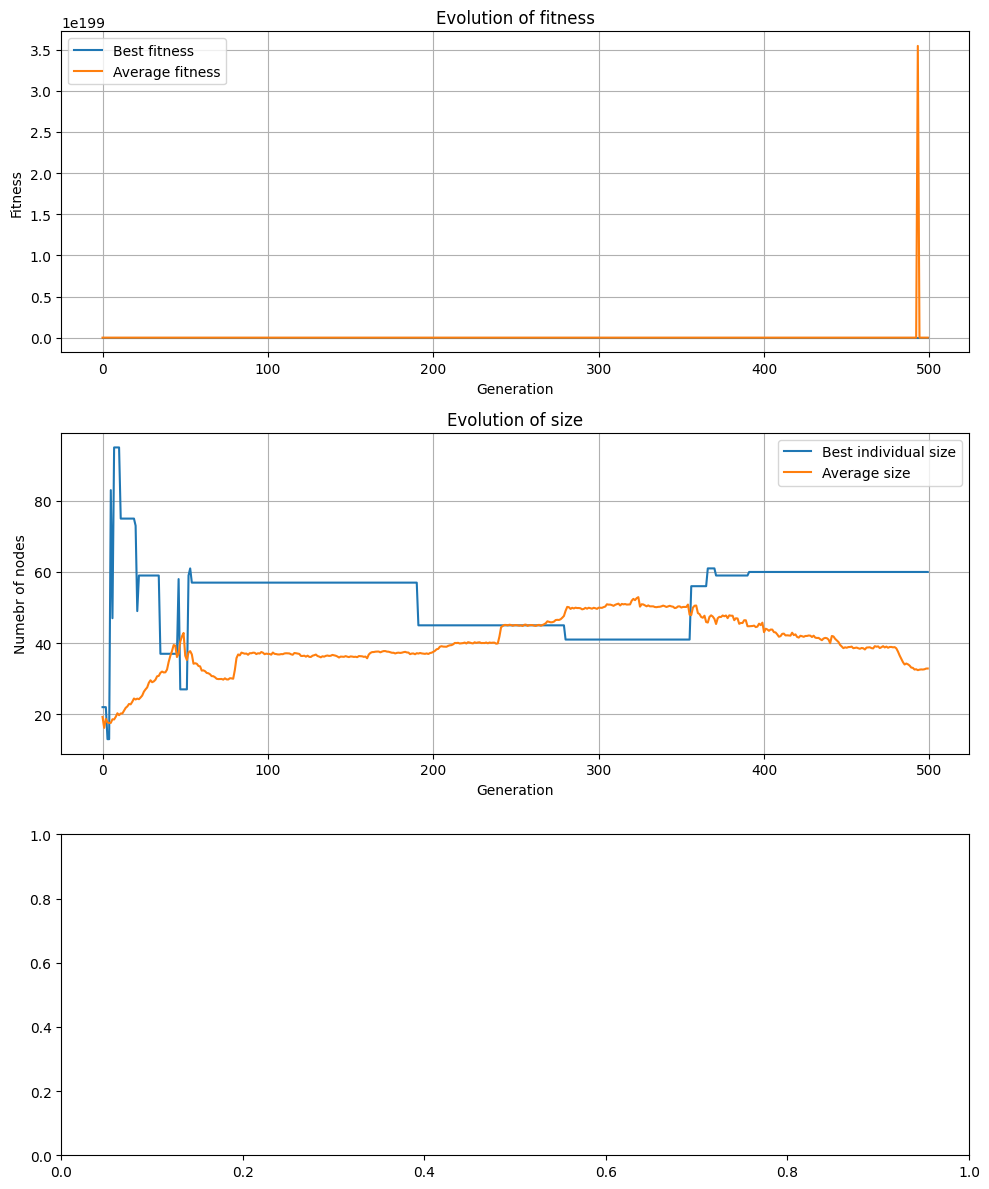

Original expression: (((2742717.0591339385 - ((((x[2] + x[1]) - tan(sin(x[0]))) * x[2]) * sqrt(4792893.817405832))) * (sin((tan(0.985844864051662) * sin(x[0]))) + x[0])) + (((-1112267.7584117618 * (sin((tan(1.1039727301797782) * sin(x[0]))) + x[0])) * sqrt(((x[1] - tan(sin(x[0]))) - (x[2] / sin(sin(x[0])))))) * sqrt((sin(x[2]) - (sqrt((x[2] + x[1])) * sin(sin(x[0])))))))
Simplified expression: (-1112267.7584117618*x[0] - 1112267.7584117618*sin(1.9842202415071949*sin(x[0])))*sqrt(-sqrt(x[1] + x[2])*sin(sin(x[0])) + sin(x[2]))*sqrt(x[1] - x[2]/sin(sin(x[0])) - tan(sin(x[0]))) + (x[0] + sin(1.50996183095054*sin(x[0])))*(-2189.267872464636*x[2]*(x[1] + x[2] - tan(sin(x[0]))) + 2742717.0591339385)
Best fitness(MSE): 5497243377966.15


In [371]:
print(f"\n=== GP execution on {problems[2]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[2]['file_path'], 
    problems[2]['config'],
    function_weights=problems[2]['config'].get('function_weights'),
    terminal_weights=problems[2]['config'].get('terminal_weights'),
    use_islands=problems[2].get('use_islands', False),
    n_islands=problems[2].get('n_islands', 5),
    migration_interval=problems[2].get('migration_interval', 10),
    migration_rate=problems[2].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_3.npz ===
Loading data from ../data/problem_3.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 3), y shape (5000,)
Input 3-dimensional with 5000 samples

GP execution on ../data/problem_3.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 4 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.03 seconds
  Generated  2000 individuals in  0.06 seconds
  Generated  3000 individuals in  0.08 seconds
  Generated  4000 individuals in  0.11 seconds
  Generated  5000 individuals in  0.14 seconds
  Generated  6000 individuals in  0.18 seconds
  Generated

  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 1838.7955771797374 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 2576.867758090615 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 2600.9589311523846 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 2624.561689173779 | Mutation Strength: 0.90
Bloat control: 75 individuals exceed the maximum size
Bloat control: 70 individuals exceed the maximum size
Bloat control: 94 individuals exceed the maximum size
Bloat control: 80 individuals exceed the maximum size


  0%|          | 1/500 [01:48<14:59:06, 108.11s/it]

New best solution found:
  Expression: (tan(tan(sqrt(x[2]))) - (x[1] * 7.960067489897881))
  Simplified Expression: -7.960067489897881*x[1] + tan(tan(sqrt(x[2])))
  Fitness: 1838.7955771797374
  Complexity: 8 nodes
Generation 0, Best Fitness: 1838.7955771797374


  0%|          | 2/500 [03:32<14:38:57, 105.90s/it]

New best solution found:
  Expression: (tan(tan((sin(x[1]) + x[0]))) - (x[1] * 7.960067489897881))
  Simplified Expression: -7.960067489897881*x[1] + tan(tan(x[0] + sin(x[1])))
  Fitness: 1807.2403694635473
  Complexity: 10 nodes


  1%|          | 4/500 [07:05<14:40:44, 106.54s/it]

New best solution found:
  Expression: (tan(tan((((x[1] - 3.141592653589793) + ((x[2] + x[1]) + x[1])) + x[0]))) - (x[1] * 7.960067489897881))
  Simplified Expression: -7.960067489897881*x[1] + tan(tan(x[0] + 3*x[1] + x[2] - 3.141592653589793))
  Fitness: 1704.0532911272603
  Complexity: 17 nodes


  1%|          | 5/500 [08:55<14:48:28, 107.69s/it]

New best solution found:
  Expression: ((x[1] * -5.751754953796507) + (((tan(tan((x[2] - (16.551359133329868 + 70.50484983266102)))) - (x[1] + x[2])) / cos(112.1957436249482)) + exp(3.141592653589793)))
  Simplified Expression: -7.363716482845222*x[1] - 1.611961529048715*x[2] + 1.611961529048715*tan(tan(x[2] - 87.056208965990887)) + 23.14069263277926
  Fitness: 1600.0685796433409
  Complexity: 21 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  1%|          | 6/500 [11:08<15:57:17, 116.27s/it]

Generation 5, Best Fitness: 1600.0685796433409


  1%|▏         | 7/500 [12:55<15:30:19, 113.22s/it]

New best solution found:
  Expression: ((x[1] * -5.751754953796507) + (((tan(-122.23949959935985) - (x[1] + x[2])) / ((x[1] * -5.751754953796507) + (((tan(-100.57295001988872) - (x[1] + x[2])) / cos(112.1957436249482)) + exp(3.141592653589793)))) + ((x[1] * -5.751754953796507) + (((tan(108.92115575797709) - (x[1] + x[2])) / cos(112.1957436249482)) + exp(3.141592653589793)))))
  Simplified Expression: -13.11547143664173*x[1] - 1.611961529048715*x[2] + 20.428269620146476 + (-x[1] - x[2] + 0.29038648764483416)/(-7.363716482845222*x[1] - 1.611961529048715*x[2] + 23.072974463978943)
  Fitness: 892.6312538033864
  Complexity: 44 nodes


  2%|▏         | 10/500 [18:26<15:08:45, 111.28s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  2%|▏         | 11/500 [20:54<16:38:22, 122.50s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (x[1] * sqrt(tan(tan(37.16820208067463))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / (x[1] + x[2])) + ((x[1] * -5.751754953796507) + (((x[1] - (x[1] + x[2])) / cos(112.1957436249482)) + exp(3.141592653589793)))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + (x[1] * sqrt(tan(tan(37.16820208067463))))) + (tan(-122.23949959935985) - (x[1] + x[2]) / (x[1] + x[2]) + (x[1] * -5.751754953796507) + (x[1] - (x[1] + x[2]) / cos(112.1957436249482) + exp(3.141592653589793)))
  Fitness: 827.1265523990332
  Complexity: 41 nodes
Generation 10, Best Fitness: 827.1265523990332


  3%|▎         | 15/500 [28:20<15:23:50, 114.29s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (x[1] * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log((x[0] * x[0])) - (x[1] + x[2])) / cos(112.1957436249482)) + (7.960067489897881 + (x[0] * x[0]))))))
  Simplified Expression: x[0]**2 + x[1]*(-x[1]**2 - 0.1839893835305161*x[1] + 7.960067489897881) - 8.975678011893937*x[1] - 3.22392305809743*x[2] + 1.611961529048715*log(x[0]**2) + 8.4281593365369337
  Fitness: 511.74176140551566
  Complexity: 46 nodes


  3%|▎         | 16/500 [31:16<17:51:26, 132.82s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (x[1] * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log((x[0] * x[0])) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(-x[1]**2 - 0.1839893835305161*x[1] + 7.960067489897881) - 8.975678011893937*x[1] - 3.22392305809743*x[2] + 1.611961529048715*log(x[0]**2) + 0.46809184663905263
  Fitness: 307.8559191011582
  Complexity: 48 nodes
Generation 15, Best Fitness: 307.8559191011582


  3%|▎         | 17/500 [33:08<16:58:26, 126.52s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (x[1] * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(-x[1]**2 - 0.1839893835305161*x[1] + 7.960067489897881) - 8.975678011893937*x[1] - 3.22392305809743*x[2] + 3.8120052563184606
  Fitness: 136.9023424735405
  Complexity: 46 nodes


  4%|▎         | 18/500 [35:00<16:22:09, 122.26s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (x[1] * sqrt(tan(tan(7.960067489897881))))))) + (((x[1] - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log((x[1] * -26.74303085379441)) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(-x[1]**2 - 0.1839893835305161*x[1] + 7.960067489897881) - 7.363716482845222*x[1] - 3.22392305809743*x[2] + 1.611961529048715*log(-26.74303085379441*x[1])
  Fitness: 53.38085843079444
  Complexity: 47 nodes


  4%|▍         | 19/500 [36:52<15:54:37, 119.08s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(tan(tan(7.960067489897881))) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.926215396645942 - x[1]**2) - 7.363716482845222*x[1] - 3.22392305809743*x[2] + 3.8120052563184606
  Fitness: 33.59196868262326
  Complexity: 47 nodes


  4%|▍         | 20/500 [38:45<15:38:49, 117.35s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(tan(tan(7.960067489897881))) * sqrt(x[1]))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(-0.1839893835305161*sqrt(x[1]) - x[1]**2 + 7.960067489897881) - 7.363716482845222*x[1] - 3.22392305809743*x[2] + 3.8120052563184606
  Fitness: 12.045053296054062
  Complexity: 45 nodes


  4%|▍         | 21/500 [42:03<18:49:40, 141.50s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(tan(7.960067489897881)) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + (sqrt(tan(7.960067489897881) * sqrt(tan(tan(7.960067489897881)))))) + (tan(-122.23949959935985) - (x[1] + x[2]) / cos(112.1957436249482) + (x[1] * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0]))
  Fitness: 6.7224308873092395
  Complexity: 46 nodes
Generation 20, Best Fitness: 6.7224308873092395


  5%|▍         | 23/500 [45:49<16:49:19, 126.96s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(tan(7.960067489897881)) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / cos(112.1957436249482)) + ((x[1] * -5.751754953796507) + (((log(tan(7.960067489897881)) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + (sqrt(tan(7.960067489897881) * sqrt(tan(tan(7.960067489897881)))))) + (tan(-122.23949959935985) - (x[1] + x[2]) / cos(112.1957436249482) + (x[1] * -5.751754953796507) + (log(tan(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0])))
  Fitness: 6.371749999382033
  Complexity: 47 nodes


  5%|▍         | 24/500 [47:41<16:11:57, 122.52s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(tan(7.960067489897881)) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / (sqrt(tan(7.960067489897881)) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + (sqrt(tan(7.960067489897881) * sqrt(tan(tan(7.960067489897881)))))) + (tan(-122.23949959935985) - (x[1] + x[2]) / (sqrt(tan(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + (x[1] * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0]))
  Fitness: 2.588223426078149
  Complexity: 52 nodes


  5%|▌         | 25/500 [49:35<15:49:17, 119.91s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt((tan(-122.23949959935985) - (x[1] + x[2]))) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / (sqrt(tan(7.960067489897881)) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + (sqrt(tan(-122.23949959935985) - (x[1] + x[2]) * sqrt(tan(tan(7.960067489897881)))))) + (tan(-122.23949959935985) - (x[1] + x[2]) / (sqrt(tan(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + (x[1] * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0]))
  Fitness: 1.608721485973381
  Complexity: 56 nodes


  5%|▌         | 26/500 [53:26<20:09:20, 153.08s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(-5.751754953796507) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / (sqrt(tan(7.960067489897881)) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + (sqrt(-5.751754953796507) * sqrt(tan(tan(7.960067489897881))))) + (tan(-122.23949959935985) - (x[1] + x[2]) / (sqrt(tan(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + (x[1] * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0]))
  Fitness: 1.2761724846406397
  Complexity: 51 nodes
Generation 25, Best Fitness: 1.2761724846406397


  5%|▌         | 27/500 [55:18<18:29:47, 140.78s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + (sqrt(x[1]) * sqrt(tan(tan(7.960067489897881))))))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(-0.1839893835305161*sqrt(x[1]) - x[1]**2 + 7.960067489897881) - 7.678165560360145*x[1] - 3.538372135612353*x[2] + 3.9033170194811774
  Fitness: 0.8462709249575967
  Complexity: 50 nodes


  6%|▌         | 29/500 [59:06<16:39:11, 127.29s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + tan(-122.23949959935985)))) + (((tan(-122.23949959935985) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6696810022530469 - x[1]**2) - 7.678165560360145*x[1] - 3.538372135612353*x[2] + 3.9033170194811774
  Fitness: 0.2170619674301437
  Complexity: 45 nodes


  6%|▌         | 30/500 [1:01:02<16:08:36, 123.65s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + tan(-122.23949959935985)))) + (((tan(tan(-122.23949959935985)) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6696810022530469 - x[1]**2) - 7.678165560360145*x[1] - 3.538372135612353*x[2] + 3.9195898952123365
  Fitness: 0.1888272305712424
  Complexity: 46 nodes
Bloat control: 6 individuals exceed the maximum size


  6%|▌         | 31/500 [1:04:37<19:42:05, 151.23s/it]

Generation 30, Best Fitness: 0.1888272305712424


  6%|▋         | 32/500 [1:06:32<18:13:12, 140.15s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + tan(-122.23949959935985)))) + (((tan(tan(tan(tan(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(7.960067489897881))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6696810022530469 - x[1]**2) - 7.678165560360145*x[1] - 3.538372135612353*x[2] + 3.9568751167113987
  Fitness: 0.1441036536362874
  Complexity: 48 nodes


  7%|▋         | 34/500 [1:10:21<16:28:45, 127.31s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + tan(-122.23949959935985)))) + (((tan(tan(tan(tan(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(tan(7.960067489897881)))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6696810022530469 - x[1]**2) - 7.677797564162062*x[1] - 3.53800413941427*x[2] + 3.9567580245520273
  Fitness: 0.1413747749437419
  Complexity: 49 nodes


  7%|▋         | 35/500 [1:12:16<15:58:25, 123.67s/it]

Bloat control: 67 individuals exceed the maximum size


  7%|▋         | 36/500 [1:16:39<21:18:40, 165.35s/it]

Generation 35, Best Fitness: 0.1413747749437419


  8%|▊         | 39/500 [1:22:23<16:54:11, 132.00s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.002
  Island 2 diversity: 0.033
  Island 3 diversity: 0.002
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.09)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.01)


  8%|▊         | 40/500 [1:24:20<16:17:37, 127.52s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * x[1]) * x[1]) + tan(-122.23949959935985)))) + (((tan(tan(tan(tan(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(tan(7.960067489897881)))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6696810022530469 - 0.9998092739894345*x[1]**2) - 7.677797564162062*x[1] - 3.53800413941427*x[2] + 3.9567580245520273
  Fitness: 0.13809162004976874
  Complexity: 52 nodes
Bloat control: 4 individuals exceed the maximum size
Bloat control: 24 individuals exceed the maximum size


  8%|▊         | 41/500 [1:29:07<22:20:31, 175.23s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + tan(-122.23949959935985)))) + (((tan(tan(tan(tan(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(7.960067489897881) * sqrt(tan(tan(tan(7.960067489897881)))))) + ((x[1] * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * (-161.54620423146508 * (-100.57295001988872 / 44.638649033976094))))))))
  Simplified Expression: x[0]**2 + 363.97110297194605*x[0] + x[1]*(7.6696810022530469 - x[1]**2) - 7.677797564162062*x[1] - 3.53800413941427*x[2] + 3.9567580245520273
  Fitness: 0.01413747749437419
  Complexity: 53 nodes
Generation 40, Best Fitness: 0.01413747749437419


  9%|▉         | 45/500 [1:36:42<16:15:38, 128.66s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  9%|▉         | 46/500 [1:40:56<20:57:20, 166.17s/it]

Generation 45, Best Fitness: 0.01413747749437419


 10%|█         | 50/500 [1:48:43<16:07:21, 128.98s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * (sin(158.66996011345282) * x[1])) * x[1]) + tan(tan(tan(tan(-122.23949959935985))))))) + (((tan(tan(tan(log(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(8.213339415898032) * sqrt(tan(tan(tan(7.960067489897881)))))) + ((x[1] * -5.751754953796507) + (((log(8.048664726389129) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (sin(158.66996011345282) * (sin(158.66996011345282) * x[1]) * x[1]) + tan(tan(tan(tan(-122.23949959935985))))) + (tan(tan(tan(log(-122.23949959935985)) - (x[1] + x[2])) / (sqrt(8.213339415898032) * sqrt(tan(tan(tan(7.960067489897881)))))) + (x[1] * -5.751754953796507) + (log(8.048664726389129) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0]))
  Fitness: 0.010600350839359144
  Complexity: 58 nodes
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1094 individual

 10%|█         | 51/500 [1:52:36<19:57:41, 160.05s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * x[1]) * x[1]) + tan(tan(tan(tan(-122.23949959935985))))))) + (((tan(tan(tan(tan(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(8.213339415898032) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((sin(158.66996011345282) * (sin(158.66996011345282) * x[1])) * -5.751754953796507) + (((log(8.213339415898032) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6418789869154346 - 0.9998092739894345*x[1]**2) - 7.6456748642771508*x[1] - 3.508075248853332*x[2] + 3.9977250354116065
  Fitness: 0.005579276907867135
  Complexity: 61 nodes
Generation 50, Best Fitness: 0.005579276907867135


 11%|█         | 53/500 [1:56:35<17:14:04, 138.80s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * x[1]) * x[1]) + tan(tan(tan(tan(-122.23949959935985))))))) + (((tan(tan(tan(tan(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(8.213339415898032) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((sin(158.66996011345282) * (sin(158.66996011345282) * (sin(158.66996011345282) * x[1]))) * -5.751754953796507) + (((log(8.213339415898032) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + x[1]*(7.6418789869154346 - 0.9998092739894345*x[1]**2) - 7.6445782734175632*x[1] - 3.508075248853332*x[2] + 3.9977250354116065
  Fitness: 0.005481228868061991
  Complexity: 64 nodes


 11%|█         | 55/500 [2:00:33<15:57:57, 129.16s/it]

Bloat control: 120 individuals exceed the maximum size
Bloat control: 137 individuals exceed the maximum size
Bloat control: 64 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 11%|█         | 56/500 [2:04:59<20:58:01, 170.00s/it]

Generation 55, Best Fitness: 0.005481228868061991


 12%|█▏        | 59/500 [2:10:46<16:27:27, 134.35s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[1] * x[1]) + tan(tan(tan(log(-122.23949959935985))))))) + (((tan(tan(tan(log(-122.23949959935985)))) - (x[1] + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((sin(7.960067489897881) * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (x[1] * x[1]) + tan(tan(tan(log(-122.23949959935985))))) + (tan(tan(tan(log(-122.23949959935985)) - (x[1] + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (sin(7.960067489897881) * x[1]) * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0])
  Fitness: 0.001854597172951729
  Complexity: 56 nodes


 12%|█▏        | 60/500 [2:12:43<15:46:36, 129.08s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * (sin(158.66996011345282) * x[1])) * x[1]) + tan(tan(tan(log(-122.23949959935985))))))) + (((tan(tan(tan(log(-122.23949959935985)))) - ((sin(7.960067489897881) * (sin(7.960067489897881) * x[1])) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((sin(158.66996011345282) * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (sin(158.66996011345282) * (sin(158.66996011345282) * x[1]) * x[1]) + tan(tan(tan(log(-122.23949959935985))))) + (tan(tan(tan(log(-122.23949959935985)) - (sin(7.960067489897881) * (sin(7.960067489897881) * x[1]) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (sin(158.66996011345282) * x[1]) * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482

 12%|█▏        | 61/500 [2:16:58<20:21:39, 166.97s/it]

Generation 60, Best Fitness: 0.000538950774937146


 12%|█▏        | 62/500 [2:18:51<18:19:38, 150.64s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * (x[0] * x[1])) * x[1]) + tan(tan(tan(log(-122.23949959935985))))))) + (((tan(tan(tan(log(-122.23949959935985)))) - ((sin(7.960067489897881) * (sin(7.960067489897881) * x[1])) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((sin(158.66996011345282) * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: x[1] * (7.960067489897881 - (sin(158.66996011345282) * (x[0] * x[1]) * x[1]) + tan(tan(tan(log(-122.23949959935985))))) + (tan(tan(tan(log(-122.23949959935985)) - (sin(7.960067489897881) * (sin(7.960067489897881) * x[1]) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (sin(158.66996011345282) * x[1]) * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + (x[0] * x[0]) + (x[0] * x[0])
  Fi

 13%|█▎        | 65/500 [2:24:32<15:17:05, 126.50s/it]

Bloat control: 583 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 13%|█▎        | 66/500 [2:28:20<18:54:07, 156.79s/it]

Generation 65, Best Fitness: 0.00021558030997485838


 13%|█▎        | 67/500 [2:30:13<17:16:11, 143.58s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (x[0] + x[1]))) + (((1.0 - (x[0] + x[2])) / (sqrt(x[2]) * sqrt(x[0]))) + (((sin(158.66996011345282) * x[1]) * -5.751754953796507) + -39.403401064340414)))
  Simplified Expression: x[1]*(-x[0] - x[1] + 7.960067489897881) - 5.7506579445204191*x[1] - 39.403401064340414 + (-x[0] - x[2] + 1.0)/(sqrt(x[0])*sqrt(x[2]))
  Fitness: 0.00011092253347156597
  Complexity: 28 nodes


 14%|█▍        | 70/500 [2:35:57<14:54:19, 124.79s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 101 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:40:27<20:03:39, 168.34s/it]

Generation 70, Best Fitness: 0.00011092253347156597


 15%|█▍        | 74/500 [2:46:11<15:46:47, 133.35s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - (((sin(158.66996011345282) * (sin(158.66996011345282) * x[1])) * x[1]) + tan(tan(tan(log(-122.23949959935985))))))) + (((tan(tan(tan(log(-122.23949959935985)))) - ((sin(7.960067489897881) * (sin(7.960067489897881) * x[1])) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((x[1] * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + x[0]))))
  Simplified Expression: x[1] * (7.960067489897881 - (sin(158.66996011345282) * (sin(158.66996011345282) * x[1]) * x[1]) + tan(tan(tan(log(-122.23949959935985))))) + (tan(tan(tan(log(-122.23949959935985)) - (sin(7.960067489897881) * (sin(7.960067489897881) * x[1]) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (x[1] * x[1]) * -5.751754953796507) + (log(7.960067489897881) - x[2]) / cos(112.1957436249482) + x[0]
  Fitness: 0.00010779015498742919
  Complexity: 61 nodes

 15%|█▌        | 75/500 [2:48:06<15:04:39, 127.72s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 113 individuals exceed the maximum size
Bloat control: 50 individuals exceed the maximum size
Bloat control: 1509 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:51:29<17:43:07, 150.44s/it]

Generation 75, Best Fitness: 0.00010779015498742919


 16%|█▌        | 78/500 [2:55:24<15:38:19, 133.41s/it]

New best solution found:
  Expression: ((x[1] * (7.960067489897881 - ((x[0] * x[1]) + tan(tan(x[2]))))) + (((x[0] - ((sin(7.960067489897881) * (sin(7.960067489897881) * x[1])) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((x[1] * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Simplified Expression: 2*x[0]**2 + 1.888011443473933*x[0] - 5.751754953796507*x[1]**2 + x[1]*(-x[0]*x[1] - tan(tan(x[2])) + 7.960067489897881) - 1.866842958998818*x[1] - 3.499972972522648*x[2] + 3.343913409679408
  Fitness: 5.3895077493714596e-05
  Complexity: 55 nodes


 16%|█▌        | 79/500 [2:57:16<14:50:36, 126.93s/it]

Performing inter-island migration...
  Island 0 diversity: 0.017
  Island 1 diversity: 0.006
  Island 2 diversity: 0.014
  Island 3 diversity: 0.012
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.01)


 16%|█▌        | 80/500 [2:59:17<14:34:47, 124.97s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 32 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 16%|█▌        | 81/500 [3:02:10<16:13:38, 139.42s/it]

Generation 80, Best Fitness: 5.3895077493714596e-05


 17%|█▋        | 85/500 [3:09:41<13:39:39, 118.50s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 17%|█▋        | 86/500 [3:12:32<15:27:38, 134.44s/it]

Generation 85, Best Fitness: 5.3895077493714596e-05


 18%|█▊        | 90/500 [3:19:48<13:07:01, 115.18s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 18%|█▊        | 91/500 [3:22:34<14:49:11, 130.44s/it]

Generation 90, Best Fitness: 5.3895077493714596e-05


 19%|█▉        | 95/500 [3:29:52<12:53:21, 114.57s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 19%|█▉        | 96/500 [3:32:39<14:36:57, 130.24s/it]

Generation 95, Best Fitness: 5.3895077493714596e-05


 20%|██        | 100/500 [3:39:49<12:33:41, 113.05s/it]

Island 0 | Generation 100 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Bloat control: 1 individuals exceed the maximum size


 20%|██        | 101/500 [3:42:48<14:44:07, 132.95s/it]

Generation 100, Best Fitness: 5.3895077493714596e-05


 21%|██        | 105/500 [3:50:01<12:32:25, 114.29s/it]

Bloat control: 3 individuals exceed the maximum size


 21%|██        | 106/500 [3:52:45<14:09:18, 129.34s/it]

Generation 105, Best Fitness: 5.3895077493714596e-05


 22%|██▏       | 110/500 [4:00:02<12:18:37, 113.63s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 22%|██▏       | 111/500 [4:02:59<14:19:30, 132.57s/it]

Generation 110, Best Fitness: 5.3895077493714596e-05


 23%|██▎       | 115/500 [4:10:13<12:13:38, 114.33s/it]

Bloat control: 1 individuals exceed the maximum size


 23%|██▎       | 116/500 [4:13:03<13:59:29, 131.17s/it]

Generation 115, Best Fitness: 5.3895077493714596e-05


 24%|██▍       | 119/500 [4:18:36<12:28:35, 117.89s/it]

Performing inter-island migration...
  Island 0 diversity: 0.015
  Island 1 diversity: 0.018
  Island 2 diversity: 0.014


 24%|██▍       | 120/500 [4:20:36<12:29:52, 118.40s/it]

  Island 3 diversity: 0.013
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.01)
Bloat control: 12 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 24%|██▍       | 121/500 [4:23:27<14:08:25, 134.32s/it]

Generation 120, Best Fitness: 5.3895077493714596e-05


 25%|██▌       | 125/500 [4:30:48<12:02:11, 115.55s/it]

Bloat control: 25 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 25%|██▌       | 126/500 [4:33:29<13:26:20, 129.36s/it]

Generation 125, Best Fitness: 5.3895077493714596e-05


 26%|██▌       | 130/500 [4:40:42<11:39:13, 113.39s/it]

Bloat control: 19 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 26%|██▌       | 131/500 [4:43:27<13:13:15, 128.99s/it]

Generation 130, Best Fitness: 5.3895077493714596e-05


 27%|██▋       | 135/500 [4:50:37<11:24:33, 112.53s/it]

Bloat control: 1 individuals exceed the maximum size


 27%|██▋       | 136/500 [4:53:19<12:52:56, 127.41s/it]

Generation 135, Best Fitness: 5.3895077493714596e-05


 28%|██▊       | 141/500 [5:03:13<12:44:23, 127.75s/it]

Generation 140, Best Fitness: 5.3895077493714596e-05


 29%|██▉       | 145/500 [5:10:24<11:05:52, 112.54s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 29%|██▉       | 146/500 [5:13:02<12:24:07, 126.12s/it]

Generation 145, Best Fitness: 5.3895077493714596e-05


 30%|███       | 151/500 [5:22:48<12:10:08, 125.53s/it]

Generation 150, Best Fitness: 5.3895077493714596e-05


 31%|███       | 155/500 [5:29:59<10:45:01, 112.18s/it]

Bloat control: 2 individuals exceed the maximum size


 31%|███       | 156/500 [5:32:40<12:06:55, 126.79s/it]

Generation 155, Best Fitness: 5.3895077493714596e-05


 32%|███▏      | 159/500 [5:38:03<10:49:35, 114.30s/it]

Performing inter-island migration...
  Island 0 diversity: 0.024
  Island 1 diversity: 0.020
  Island 2 diversity: 0.020


 32%|███▏      | 160/500 [5:39:58<10:49:44, 114.66s/it]

  Island 3 diversity: 0.016
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.03)
Bloat control: 1 individuals exceed the maximum size


 32%|███▏      | 161/500 [5:42:51<12:25:35, 131.96s/it]

Generation 160, Best Fitness: 5.3895077493714596e-05


 33%|███▎      | 164/500 [5:48:15<10:49:20, 115.95s/it]C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
 33%|███▎      | 166/500 [5:52:50<12:01:24, 129.59s/it]

Generation 165, Best Fitness: 5.3895077493714596e-05


 34%|███▍      | 171/500 [6:02:33<11:23:51, 124.72s/it]

Generation 170, Best Fitness: 5.3895077493714596e-05


 35%|███▌      | 176/500 [6:12:09<11:00:27, 122.31s/it]

Generation 175, Best Fitness: 5.3895077493714596e-05


 36%|███▌      | 180/500 [6:19:17<9:49:26, 110.52s/it] 

Bloat control: 1 individuals exceed the maximum size


 36%|███▌      | 181/500 [6:21:47<10:49:01, 122.07s/it]

Generation 180, Best Fitness: 5.3895077493714596e-05


 37%|███▋      | 185/500 [6:28:58<9:43:47, 111.20s/it] 

Bloat control: 1 individuals exceed the maximum size


 37%|███▋      | 186/500 [6:31:25<10:38:00, 121.91s/it]

Generation 185, Best Fitness: 5.3895077493714596e-05


 38%|███▊      | 190/500 [6:38:34<9:31:57, 110.70s/it] 

Bloat control: 1 individuals exceed the maximum size


 38%|███▊      | 191/500 [6:41:02<10:27:28, 121.84s/it]

Generation 190, Best Fitness: 5.3895077493714596e-05


 39%|███▉      | 195/500 [6:48:12<9:23:21, 110.82s/it] 

Bloat control: 1 individuals exceed the maximum size


 39%|███▉      | 196/500 [6:50:44<10:23:24, 123.04s/it]

Generation 195, Best Fitness: 5.3895077493714596e-05


 40%|███▉      | 199/500 [6:56:05<9:23:40, 112.36s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.019
  Island 1 diversity: 0.020
  Island 2 diversity: 0.021


 40%|████      | 200/500 [6:58:04<9:32:27, 114.49s/it]

  Island 3 diversity: 0.023
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 0.50)
Island 0 | Generation 200 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00


 40%|████      | 201/500 [7:00:37<10:27:28, 125.91s/it]

Generation 200, Best Fitness: 5.3895077493714596e-05


 41%|████      | 205/500 [7:07:47<9:10:49, 112.03s/it] 

Bloat control: 1 individuals exceed the maximum size


 41%|████      | 206/500 [7:10:22<10:11:45, 124.85s/it]

Generation 205, Best Fitness: 5.3895077493714596e-05


 42%|████▏     | 210/500 [7:17:28<8:57:02, 111.11s/it] 

Bloat control: 1 individuals exceed the maximum size


 42%|████▏     | 211/500 [7:19:55<9:46:01, 121.67s/it]

Generation 210, Best Fitness: 5.3895077493714596e-05


 43%|████▎     | 215/500 [7:27:03<8:45:22, 110.60s/it]

Bloat control: 1 individuals exceed the maximum size


 43%|████▎     | 216/500 [7:29:26<9:30:06, 120.45s/it]

Generation 215, Best Fitness: 5.3895077493714596e-05


 44%|████▍     | 220/500 [7:36:31<8:30:16, 109.34s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 44%|████▍     | 221/500 [7:38:54<9:16:28, 119.67s/it]

Generation 220, Best Fitness: 5.3895077493714596e-05


 45%|████▌     | 226/500 [7:48:19<8:59:55, 118.23s/it]

Generation 225, Best Fitness: 5.3895077493714596e-05


 46%|████▌     | 230/500 [7:55:27<8:12:26, 109.43s/it]

Bloat control: 1 individuals exceed the maximum size


 46%|████▌     | 231/500 [7:57:50<8:55:28, 119.44s/it]

Generation 230, Best Fitness: 5.3895077493714596e-05


 47%|████▋     | 236/500 [8:07:51<9:22:26, 127.83s/it]

Generation 235, Best Fitness: 5.3895077493714596e-05


 48%|████▊     | 239/500 [8:13:14<8:18:01, 114.49s/it]

Performing inter-island migration...
  Island 0 diversity: 0.024
  Island 1 diversity: 0.022
  Island 2 diversity: 0.024


 48%|████▊     | 240/500 [8:15:13<8:21:27, 115.72s/it]

  Island 3 diversity: 0.024
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.00)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 48%|████▊     | 241/500 [8:17:41<9:01:16, 125.39s/it]

Generation 240, Best Fitness: 5.3895077493714596e-05


 49%|████▉     | 245/500 [8:24:43<7:49:46, 110.53s/it]

Bloat control: 1 individuals exceed the maximum size


 49%|████▉     | 246/500 [8:26:56<8:16:26, 117.27s/it]

Generation 245, Best Fitness: 5.3895077493714596e-05


 50%|█████     | 251/500 [8:36:13<7:56:59, 114.94s/it]

Generation 250, Best Fitness: 5.3895077493714596e-05


 51%|█████     | 256/500 [8:45:28<7:48:22, 115.17s/it]

Generation 255, Best Fitness: 5.3895077493714596e-05


 52%|█████▏    | 260/500 [8:52:35<7:14:55, 108.73s/it]

Bloat control: 1 individuals exceed the maximum size


 52%|█████▏    | 261/500 [8:54:50<7:44:28, 116.60s/it]

Generation 260, Best Fitness: 5.3895077493714596e-05


 53%|█████▎    | 266/500 [9:04:06<7:30:28, 115.51s/it]

Generation 265, Best Fitness: 5.3895077493714596e-05


 54%|█████▍    | 270/500 [9:11:08<6:53:39, 107.91s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 54%|█████▍    | 271/500 [9:13:17<7:15:47, 114.18s/it]

Generation 270, Best Fitness: 5.3895077493714596e-05


 55%|█████▌    | 276/500 [9:22:37<7:11:43, 115.64s/it]

Generation 275, Best Fitness: 5.3895077493714596e-05


 56%|█████▌    | 279/500 [9:27:58<6:44:25, 109.80s/it]

Performing inter-island migration...
  Island 0 diversity: 0.026
  Island 1 diversity: 0.028
  Island 2 diversity: 0.023
  Island 3 diversity: 0.024
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)


 56%|█████▌    | 280/500 [9:29:57<6:53:33, 112.79s/it]

  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.00)


 56%|█████▌    | 281/500 [9:32:06<7:09:26, 117.65s/it]

Generation 280, Best Fitness: 5.3895077493714596e-05


 57%|█████▋    | 286/500 [9:41:14<6:42:59, 112.99s/it]

Generation 285, Best Fitness: 5.3895077493714596e-05


 58%|█████▊    | 291/500 [9:50:24<6:32:46, 112.76s/it]

Generation 290, Best Fitness: 5.3895077493714596e-05


 59%|█████▉    | 296/500 [9:59:27<6:18:29, 111.32s/it]

Generation 295, Best Fitness: 5.3895077493714596e-05


 60%|██████    | 300/500 [10:06:35<6:00:06, 108.03s/it]

Island 0 | Generation 300 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Bloat control: 1 individuals exceed the maximum size


 60%|██████    | 301/500 [10:08:36<6:12:04, 112.18s/it]

Generation 300, Best Fitness: 5.3895077493714596e-05


 61%|██████    | 306/500 [10:17:44<6:02:35, 112.14s/it]

Generation 305, Best Fitness: 5.3895077493714596e-05


 62%|██████▏   | 311/500 [10:26:51<5:52:48, 112.00s/it]

Generation 310, Best Fitness: 5.3895077493714596e-05


 63%|██████▎   | 316/500 [10:35:58<5:43:22, 111.97s/it]

Generation 315, Best Fitness: 5.3895077493714596e-05


 64%|██████▍   | 319/500 [10:41:20<5:28:43, 108.97s/it]

Performing inter-island migration...
  Island 0 diversity: 0.027
  Island 1 diversity: 0.026
  Island 2 diversity: 0.026


 64%|██████▍   | 320/500 [10:43:18<5:35:16, 111.76s/it]

  Island 3 diversity: 0.029
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 0.50)


 64%|██████▍   | 321/500 [10:45:19<5:42:02, 114.65s/it]

Generation 320, Best Fitness: 5.3895077493714596e-05


 65%|██████▌   | 326/500 [10:54:23<5:23:13, 111.46s/it]

Generation 325, Best Fitness: 5.3895077493714596e-05


 66%|██████▌   | 331/500 [11:03:24<5:10:11, 110.12s/it]

Generation 330, Best Fitness: 5.3895077493714596e-05


 67%|██████▋   | 336/500 [11:12:26<5:02:45, 110.76s/it]

Generation 335, Best Fitness: 5.3895077493714596e-05


 68%|██████▊   | 341/500 [11:21:28<4:52:47, 110.49s/it]

Generation 340, Best Fitness: 5.3895077493714596e-05


 69%|██████▉   | 346/500 [11:30:31<4:43:31, 110.46s/it]

Generation 345, Best Fitness: 5.3895077493714596e-05


 70%|███████   | 351/500 [11:39:34<4:35:35, 110.97s/it]

Generation 350, Best Fitness: 5.3895077493714596e-05


 71%|███████   | 356/500 [11:48:34<4:23:59, 110.00s/it]

Generation 355, Best Fitness: 5.3895077493714596e-05


 72%|███████▏  | 359/500 [11:53:51<4:12:01, 107.24s/it]

Performing inter-island migration...
  Island 0 diversity: 0.031
  Island 1 diversity: 0.025
  Island 2 diversity: 0.027


 72%|███████▏  | 360/500 [11:55:47<4:16:01, 109.73s/it]

  Island 3 diversity: 0.027
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 72%|███████▏  | 361/500 [11:57:49<4:22:57, 113.51s/it]

Generation 360, Best Fitness: 5.3895077493714596e-05


 73%|███████▎  | 365/500 [12:04:51<4:01:40, 107.41s/it]

Bloat control: 7 individuals exceed the maximum size


 73%|███████▎  | 366/500 [12:06:52<4:08:26, 111.24s/it]

Generation 365, Best Fitness: 5.3895077493714596e-05


 74%|███████▍  | 371/500 [12:15:50<3:56:33, 110.02s/it]

Generation 370, Best Fitness: 5.3895077493714596e-05


 75%|███████▌  | 376/500 [12:24:50<3:47:26, 110.05s/it]

Generation 375, Best Fitness: 5.3895077493714596e-05


 76%|███████▌  | 381/500 [12:33:50<3:38:49, 110.33s/it]

Generation 380, Best Fitness: 5.3895077493714596e-05


 77%|███████▋  | 386/500 [12:42:54<3:30:49, 110.96s/it]

Generation 385, Best Fitness: 5.3895077493714596e-05


 78%|███████▊  | 391/500 [12:52:10<3:24:51, 112.77s/it]

Generation 390, Best Fitness: 5.3895077493714596e-05


 79%|███████▉  | 395/500 [12:59:17<3:09:38, 108.37s/it]

Bloat control: 1 individuals exceed the maximum size


 79%|███████▉  | 396/500 [13:01:19<3:15:21, 112.71s/it]

Generation 395, Best Fitness: 5.3895077493714596e-05


 80%|███████▉  | 399/500 [13:06:40<3:03:50, 109.22s/it]

Performing inter-island migration...
  Island 0 diversity: 0.026
  Island 1 diversity: 0.030
  Island 2 diversity: 0.031


 80%|████████  | 400/500 [13:09:09<3:22:10, 121.31s/it]

  Island 3 diversity: 0.029
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 5.3895077493714596e-05 | Mutation Strength: 3.00


 80%|████████  | 401/500 [13:11:50<3:39:39, 133.13s/it]

Generation 400, Best Fitness: 5.3895077493714596e-05


 81%|████████  | 406/500 [13:23:06<3:34:02, 136.63s/it]

Generation 405, Best Fitness: 5.3895077493714596e-05


 82%|████████▏ | 411/500 [13:34:03<3:19:12, 134.30s/it]

Generation 410, Best Fitness: 5.3895077493714596e-05


 83%|████████▎ | 416/500 [13:48:01<3:56:41, 169.06s/it]

Generation 415, Best Fitness: 5.3895077493714596e-05


 84%|████████▍ | 421/500 [14:01:34<3:41:17, 168.07s/it]

Generation 420, Best Fitness: 5.3895077493714596e-05


 85%|████████▌ | 426/500 [14:12:50<2:57:46, 144.14s/it]

Generation 425, Best Fitness: 5.3895077493714596e-05


 86%|████████▌ | 431/500 [14:26:08<3:06:42, 162.35s/it]

Generation 430, Best Fitness: 5.3895077493714596e-05


 87%|████████▋ | 435/500 [14:37:34<2:57:38, 163.98s/it]

Bloat control: 1 individuals exceed the maximum size


 87%|████████▋ | 436/500 [14:40:10<2:52:30, 161.72s/it]

Generation 435, Best Fitness: 5.3895077493714596e-05


 88%|████████▊ | 439/500 [14:48:20<2:45:27, 162.75s/it]

Performing inter-island migration...
  Island 0 diversity: 0.029
  Island 1 diversity: 0.030
  Island 2 diversity: 0.032


 88%|████████▊ | 440/500 [14:51:20<2:47:51, 167.86s/it]

  Island 3 diversity: 0.032
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 0.50)


 88%|████████▊ | 441/500 [14:54:34<2:52:48, 175.73s/it]

Generation 440, Best Fitness: 5.3895077493714596e-05


 89%|████████▉ | 446/500 [15:07:17<2:20:35, 156.21s/it]

Generation 445, Best Fitness: 5.3895077493714596e-05


 90%|█████████ | 451/500 [15:18:23<1:50:10, 134.90s/it]

Generation 450, Best Fitness: 5.3895077493714596e-05


 91%|█████████ | 455/500 [15:26:03<1:28:27, 117.95s/it]

Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 456/500 [15:28:01<1:26:36, 118.09s/it]

Generation 455, Best Fitness: 5.3895077493714596e-05


 92%|█████████▏| 461/500 [15:37:36<1:19:40, 122.57s/it]

Generation 460, Best Fitness: 5.3895077493714596e-05


 93%|█████████▎| 466/500 [15:48:47<1:14:17, 131.10s/it]

Generation 465, Best Fitness: 5.3895077493714596e-05


 94%|█████████▍| 470/500 [15:56:49<1:01:09, 122.32s/it]

Bloat control: 1 individuals exceed the maximum size


 94%|█████████▍| 471/500 [15:59:01<1:00:29, 125.14s/it]

Generation 470, Best Fitness: 5.3895077493714596e-05


 95%|█████████▌| 475/500 [16:06:58<50:17, 120.72s/it]  

Bloat control: 1 individuals exceed the maximum size


 95%|█████████▌| 476/500 [16:09:05<49:04, 122.68s/it]

Generation 475, Best Fitness: 5.3895077493714596e-05


 96%|█████████▌| 479/500 [16:14:48<40:49, 116.62s/it]

Performing inter-island migration...
  Island 0 diversity: 0.030
  Island 1 diversity: 0.032
  Island 2 diversity: 0.032


 96%|█████████▌| 480/500 [16:16:47<39:06, 117.35s/it]

  Island 3 diversity: 0.034
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 500 individuals from island 3 to island 0(mutation strength: 0.50)


 96%|█████████▌| 481/500 [16:18:48<37:30, 118.45s/it]

Generation 480, Best Fitness: 5.3895077493714596e-05


 97%|█████████▋| 486/500 [16:28:03<26:39, 114.25s/it]

Generation 485, Best Fitness: 5.3895077493714596e-05


 98%|█████████▊| 491/500 [16:37:21<17:08, 114.23s/it]

Generation 490, Best Fitness: 5.3895077493714596e-05


 99%|█████████▉| 496/500 [16:46:33<07:33, 113.32s/it]

Generation 495, Best Fitness: 5.3895077493714596e-05


100%|██████████| 500/500 [16:53:46<00:00, 121.65s/it]

Generation 499, Best Fitness: 5.3895077493714596e-05
Algorithm completed in 61231.70 seconds
Best solution found:
  Simplified Expression: 2*x[0]**2 + 1.888011443473933*x[0] - 5.751754953796507*x[1]**2 + x[1]*(-x[0]*x[1] - tan(tan(x[2])) + 7.960067489897881) - 1.866842958998818*x[1] - 3.499972972522648*x[2] + 3.343913409679408
  Expression: ((x[1] * (7.960067489897881 - ((x[0] * x[1]) + tan(tan(x[2]))))) + (((x[0] - ((sin(7.960067489897881) * (sin(7.960067489897881) * x[1])) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((x[1] * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
  Fitness: 5.3895077493714596e-05
  Complexity: 55 nodes


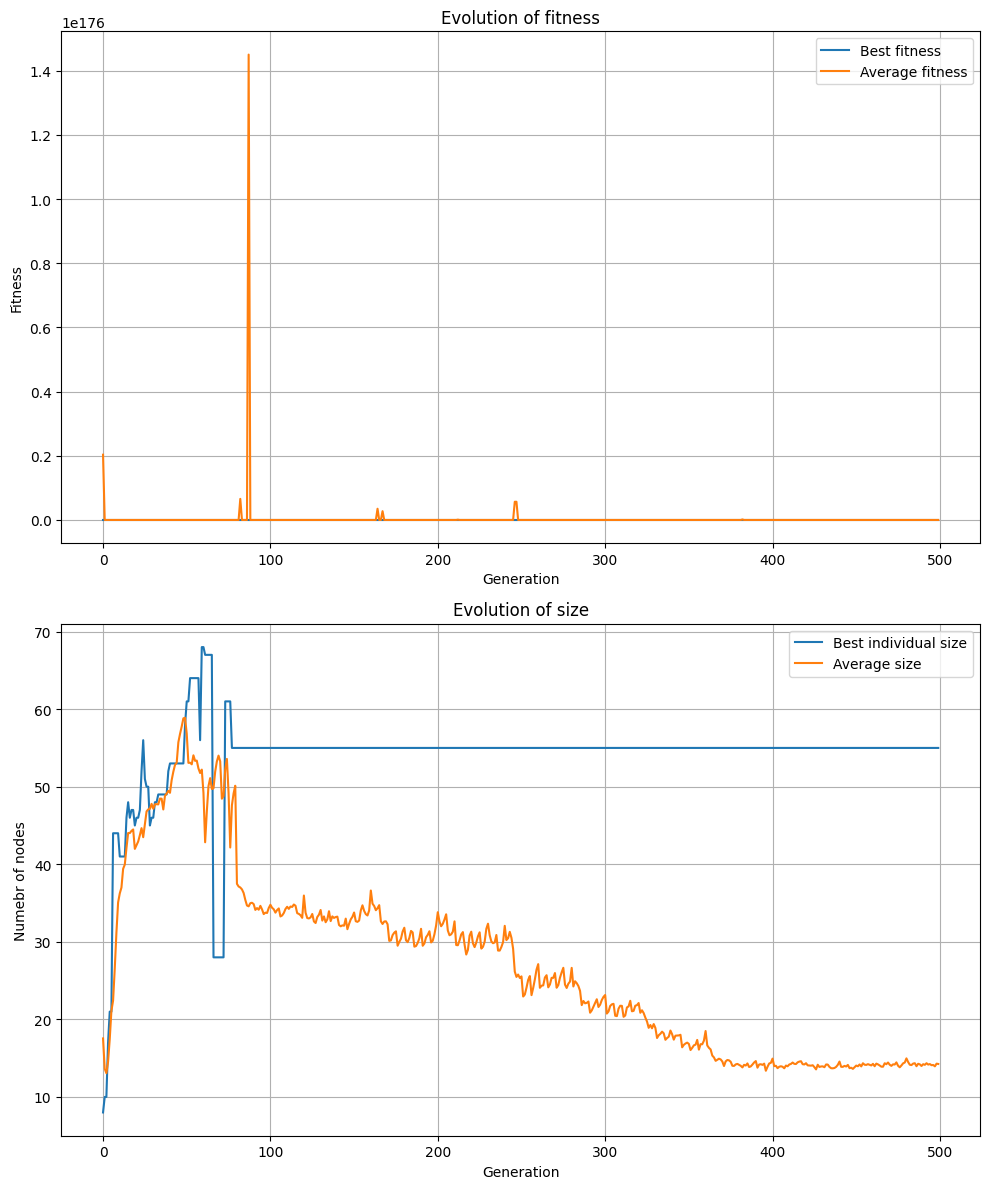

Original expression: ((x[1] * (7.960067489897881 - ((x[0] * x[1]) + tan(tan(x[2]))))) + (((x[0] - ((sin(7.960067489897881) * (sin(7.960067489897881) * x[1])) + x[2])) / (sqrt(sqrt(68.62440222234511)) * sqrt(tan(tan(tan(7.960067489897881)))))) + (((x[1] * x[1]) * -5.751754953796507) + (((log(7.960067489897881) - x[2]) / cos(112.1957436249482)) + ((x[0] * x[0]) + (x[0] * x[0]))))))
Simplified expression: 2*x[0]**2 + 1.888011443473933*x[0] - 5.751754953796507*x[1]**2 + x[1]*(-x[0]*x[1] - tan(tan(x[2])) + 7.960067489897881) - 1.866842958998818*x[1] - 3.499972972522648*x[2] + 3.343913409679408
Best fitness(MSE): 5.3895077493714596e-05


In [374]:
print(f"\n=== GP execution on {problems[3]['file_path']} ===")
best_tree = run_gp_on_problem(
    problems[3]['file_path'], 
    problems[3]['config'],
    function_weights=problems[3]['config'].get('function_weights'),
    terminal_weights=problems[3]['config'].get('terminal_weights'),
    use_islands=problems[3].get('use_islands', False),
    n_islands=problems[3].get('n_islands', 5),
    migration_interval=problems[3].get('migration_interval', 10),
    migration_rate=problems[3].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_4.npz ===
Loading data from ../data/problem_4.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples

GP execution on ../data/problem_4.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.03 seconds
  Generated  2000 individuals in  0.06 seconds
  Generated  3000 individuals in  0.09 seconds
  Generated  4000 individuals in  0.12 seconds
  Generated  5000 individuals in  0.15 seconds
  Generated  6000 individuals in  0.18 seconds
  Generated

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 13.540573973504788 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 20.247468204027005 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 16.945412428491082 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 17.522381299690668 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 17.480146137169097 | Mutation Strength: 0.90
Bloat control: 17 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 21 individuals exceed the maximum size
Bloat control: 18 individuals exceed the maximum size


  0%|          | 1/500 [01:27<12:09:18, 87.69s/it]

New best solution found:
  Expression: exp(tan(cos((x[1] * (x[1] / x[0])))))
  Simplified Expression: exp(tan(cos(x[1]**2/x[0])))
  Fitness: 13.540573973504788
  Complexity: 8 nodes
Generation 0, Best Fitness: 13.540573973504788


  1%|          | 3/500 [04:19<11:55:48, 86.42s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(-2.4931798141484656) - -6.990332232812374)) - (0.0 - 2.718281828459045))
  Simplified Expression: 7.0729789798192251*cos(x[1]) + 2.718281828459045
  Fitness: 4.000733214042417
  Complexity: 11 nodes


  1%|          | 5/500 [07:11<11:51:04, 86.19s/it]

New best solution found:
  Expression: ((cos(x[1]) * (cos(x[1]) - -6.990332232812374)) - (0.0 - 2.718281828459045))
  Simplified Expression: (cos(x[1]) + 6.990332232812374)*cos(x[1]) + 2.718281828459045
  Fitness: 2.1192619664196335
  Complexity: 11 nodes


  1%|          | 6/500 [08:57<12:43:55, 92.78s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((0.0 - 2.718281828459045)) - -6.990332232812374)) - (0.0 - 2.9436559470992667))
  Simplified Expression: 7.056320268657687*cos(x[1]) + 2.9436559470992667
  Fitness: 1.8919242933316363
  Complexity: 13 nodes
Generation 5, Best Fitness: 1.8919242933316363


  1%|▏         | 7/500 [10:24<12:27:46, 91.01s/it]

New best solution found:
  Expression: ((cos(x[1]) * (0.0 - -6.990332232812374)) - (0.0 - 2.9436559470992667))
  Simplified Expression: 6.990332232812374*cos(x[1]) + 2.9436559470992667
  Fitness: 1.794813434490534
  Complexity: 10 nodes


  2%|▏         | 8/500 [11:52<12:17:00, 89.88s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((cos(x[1]) - 2.718281828459045)) - -6.990332232812374)) - (0.0 - 2.9436559470992667))
  Simplified Expression: (0.06598803584531255*exp(cos(x[1])) + 6.990332232812374)*cos(x[1]) + 2.9436559470992667
  Fitness: 1.7093145768734266
  Complexity: 14 nodes


  2%|▏         | 9/500 [13:20<12:10:38, 89.28s/it]

New best solution found:
  Expression: ((exp(log(-6.654670228078905)) * cos(x[1])) + sqrt(9.63294966690684))
  Simplified Expression: 3.10369935188749 - 6.654670228078905*cos(x[1])
  Fitness: 1.3253464595690057
  Complexity: 9 nodes


  2%|▏         | 10/500 [14:48<12:06:48, 89.00s/it]

New best solution found:
  Expression: ((exp(log(-6.654670228078905)) * cos(x[1])) + sqrt((sin(tan(sqrt(9.63294966690684))) - ((3.615011308625075 - x[0]) - -6.1388752594541245))))
  Simplified Expression: sqrt(x[0] - 9.7917889363354133) - 6.654670228078905*cos(x[1])
  Fitness: 1.1224994467115734
  Complexity: 18 nodes


  2%|▏         | 11/500 [17:02<13:57:57, 102.82s/it]

New best solution found:
  Expression: ((exp(log(-6.654670228078905)) * cos(x[1])) + sqrt((sin(tan(sqrt(-6.259762524878731))) - ((3.615011308625075 - x[0]) - -6.1388752594541245))))
  Simplified Expression: exp(log(-6.654670228078905) * cosx[1]) + sqrt(sin(tan(sqrt(-6.259762524878731)) - (3.615011308625075 - x[0]) - -6.1388752594541245))
  Fitness: 0.9087550158670394
  Complexity: 18 nodes
Generation 10, Best Fitness: 0.9087550158670394


  2%|▏         | 12/500 [18:32<13:23:46, 98.83s/it] 

New best solution found:
  Expression: ((cos(x[1]) * (exp((cos(x[1]) - 2.718281828459045)) - -6.990332232812374)) - ((log((cos(x[1]) - 2.718281828459045)) * sin(9.63294966690684)) - 2.9436559470992667))
  Simplified Expression: (0.06598803584531255*exp(cos(x[1])) + 6.990332232812374)*cos(x[1]) + 0.206671424518494*log(cos(x[1]) - 2.718281828459045) + 2.9436559470992667
  Fitness: 0.7912029955472483
  Complexity: 21 nodes


  3%|▎         | 13/500 [20:02<13:01:01, 96.23s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-6.654670228078905)))) * cos(x[1])) + sqrt((tan(sqrt(((3.615011308625075 - x[0]) - -6.1388752594541245))) - ((3.615011308625075 - x[0]) - -6.654670228078905))))
  Simplified Expression: sqrt(x[0] + tan(sqrt(9.7538865680791995 - x[0])) - 10.26968153670398) - 6.654670228078905*cos(x[1])
  Fitness: 0.636243700191985
  Complexity: 23 nodes


  3%|▎         | 15/500 [23:02<12:30:48, 92.88s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-6.654670228078905)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.1388752594541245)))) - ((3.615011308625075 - x[0]) - -6.654670228078905))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(9.7538865680791995 - x[0]))) - 10.26968153670398) - 6.654670228078905*cos(x[1])
  Fitness: 0.6274588729423604
  Complexity: 24 nodes


  3%|▎         | 16/500 [25:55<15:43:55, 117.01s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-6.654670228078905)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.654670228078905)))) - ((3.615011308625075 - x[0]) - -6.654670228078905))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.26968153670398 - x[0]))) - 10.26968153670398) - 6.654670228078905*cos(x[1])
  Fitness: 0.6160297640758001
  Complexity: 24 nodes
Generation 15, Best Fitness: 0.6160297640758001


  4%|▎         | 18/500 [28:57<13:53:10, 103.71s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-6.654670228078905)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.654670228078905)))) - ((3.969115261058778 - x[0]) - -6.654670228078905))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.26968153670398 - x[0]))) - 10.62378548913768) - 6.654670228078905*cos(x[1])
  Fitness: 0.598556704559707
  Complexity: 24 nodes


  4%|▍         | 21/500 [34:48<15:47:51, 118.73s/it]

Generation 20, Best Fitness: 0.598556704559707


  5%|▍         | 23/500 [37:51<13:54:15, 104.94s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-7.212536421836652)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.654670228078905)))) - ((3.969115261058778 - x[0]) - -6.654670228078905))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.26968153670398 - x[0]))) - 10.62378548913768) - 7.212536421836652*cos(x[1])
  Fitness: 0.33194528783405114
  Complexity: 24 nodes


  5%|▌         | 25/500 [40:56<12:59:18, 98.44s/it] 

New best solution found:
  Expression: ((exp(log(exp(log(-7.212536421836652)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.654670228078905)))) - ((3.969115261058778 - x[0]) - -7.212536421836652))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.26968153670398 - x[0]))) - 11.18165168289543) - 7.212536421836652*cos(x[1])
  Fitness: 0.2540019601503978
  Complexity: 24 nodes


  5%|▌         | 26/500 [43:37<15:27:06, 117.35s/it]

Generation 25, Best Fitness: 0.2540019601503978


  6%|▌         | 28/500 [46:41<13:40:48, 104.34s/it]

New best solution found:
  Expression: ((exp(log(-7.212536421836652)) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.550495569746458)))) - ((3.969115261058778 - x[0]) - -7.212536421836652))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.16550687837153 - x[0]))) - 11.18165168289543) - 7.212536421836652*cos(x[1])
  Fitness: 0.25238374280240494
  Complexity: 22 nodes


  6%|▌         | 31/500 [53:07<16:40:45, 128.03s/it]

Generation 30, Best Fitness: 0.25238374280240494


  7%|▋         | 33/500 [56:13<14:16:20, 110.02s/it]

New best solution found:
  Expression: ((exp(log(-7.212536421836652)) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.615011308625075 - x[0]) - -6.520710686846423)))) - ((3.969115261058778 - x[0]) - -7.212536421836652))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.1357219954715 - x[0]))) - 11.18165168289543) - 7.212536421836652*cos(x[1])
  Fitness: 0.2521798258047012
  Complexity: 22 nodes


  7%|▋         | 35/500 [59:18<13:02:44, 101.00s/it]

New best solution found:
  Expression: ((exp(log(-7.212536421836652)) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5839970956559606 - x[0]) - -6.550495569746458)))) - ((3.969115261058778 - x[0]) - -7.212536421836652))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.134492665402419 - x[0]))) - 11.18165168289543) - 7.212536421836652*cos(x[1])
  Fitness: 0.2521746968513013
  Complexity: 22 nodes


  7%|▋         | 36/500 [1:02:13<15:52:53, 123.22s/it]

Generation 35, Best Fitness: 0.2521746968513013


  7%|▋         | 37/500 [1:03:45<14:40:03, 114.05s/it]

New best solution found:
  Expression: ((exp(log(-7.212536421836652)) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5839970956559606 - x[0]) - -6.520710686846423)))) - ((3.969115261058778 - x[0]) - -7.212536421836652))))
  Simplified Expression: sqrt(x[0] + tan(tan(sqrt(10.104707782502384 - x[0]))) - 11.18165168289543) - 7.212536421836652*cos(x[1])
  Fitness: 0.252142037330408
  Complexity: 22 nodes


  8%|▊         | 39/500 [1:06:52<13:14:15, 103.37s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((cos(x[1]) * sin(x[0])) - 2.9436559470992667) - cos(sqrt(x[0])))) - -6.990332232812374)) - ((sqrt(((cos(2.9436559470992667) * (sqrt(x[0]) - x[0])) - 2.8263121190208613)) * sin(sin(sin(sin(9.63294966690684))))) - 2.9436559470992667))
  Simplified Expression: (0.052672807300885078*exp(sin(x[0])*cos(x[1]) - cos(sqrt(x[0]))) + 6.990332232812374)*cos(x[1]) + 0.202359039920971*sqrt(-0.98047440453192801*sqrt(x[0]) + 0.98047440453192801*x[0] - 2.8263121190208613) + 2.9436559470992667
  Fitness: 0.15451430712765665
  Complexity: 36 nodes
Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.003
  Island 2 diversity: 0.001
  Island 3 diversity: 0.006


  8%|▊         | 40/500 [1:08:25<12:49:41, 100.40s/it]

  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)
New best solution found:
  Expression: ((cos(x[1]) * (exp((((cos(x[1]) * sin(x[0])) - 2.9436559470992667) - cos(sqrt(x[0])))) - -6.990332232812374)) - ((sqrt(((cos(2.8263121190208613) * ((x[0] / x[0]) - x[0])) - 2.8263121190208613)) * sin(sin(sin(sin(9.63294966690684))))) - 2.9436559470992667))
  Simplified Expression: 0.202359039920971*sqrt(0.95070942727132123*x[0] - 3.7770215462921825) + (0.052672807300885078*exp(sin(x[0])*cos(x[1]) - cos(sqrt(x[0]))) + 6.990332232812374)*cos(x[1]) + 2.9436559470992667
  Fitness: 0.1427474660334133
  Complexity: 37 nodes


  8%|▊         | 41/500 [1:11:16<15:29:14, 121.47s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((cos(x[1]) * sin(x[0])) - (log(x[0]) - x[0])) - cos(sqrt(x[0])))) - -6.990332232812374)) - ((sqrt(((cos(sqrt(-6.990332232812374)) * (sin(9.63294966690684) - x[0])) - 2.8263121190208613)) * sin(sin(sin(sin(9.63294966690684))))) - 2.9436559470992667))
  Simplified Expression: (6.990332232812374 + exp(x[0] + sin(x[0])*cos(x[1]) - cos(sqrt(x[0])))/x[0])*cos(x[1]) + 0.202359039920971*sqrt(-7.069688126524381*x[0] - 4.2874146350311373) + 2.9436559470992667
  Fitness: 0.01940964305114208
  Complexity: 40 nodes
Generation 40, Best Fitness: 0.01940964305114208


  9%|▉         | 46/500 [1:19:42<13:58:26, 110.81s/it]

Generation 45, Best Fitness: 0.01940964305114208


 10%|█         | 51/500 [1:28:44<15:00:12, 120.30s/it]

Generation 50, Best Fitness: 0.01940964305114208


 11%|█         | 56/500 [1:37:49<15:07:03, 122.58s/it]

Generation 55, Best Fitness: 0.01940964305114208


 12%|█▏        | 61/500 [1:47:05<15:25:25, 126.48s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-7.010708827348459)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5839970956559606 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(cos(-6.1388752594541245)) * x[0])) - -7.123461301922087))))
  Simplified Expression: sqrt(0.83580938030890345*x[0] + tan(tan(sqrt(10.104707782502384 - x[0]))) - 10.707458397578048) - 7.010708827348459*cos(x[1])
  Fitness: 0.013042514621093838
  Complexity: 28 nodes
Generation 60, Best Fitness: 0.013042514621093838


 13%|█▎        | 63/500 [1:50:09<13:12:54, 108.87s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-7.010708827348459)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5839970956559606 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(sin(7.964899875679839)) * x[0])) - -7.123461301922087))))
  Simplified Expression: sqrt(0.8381348929996714*x[0] + tan(tan(sqrt(10.104707782502384 - x[0]))) - 10.707458397578048) - 7.010708827348459*cos(x[1])
  Fitness: 0.013039895061231495
  Complexity: 28 nodes


 13%|█▎        | 64/500 [1:51:40<12:32:34, 103.57s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-7.010708827348459)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5992393696465896 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(sin(7.964899875679839)) * x[0])) - -7.123461301922087))))
  Simplified Expression: sqrt(0.8381348929996714*x[0] + tan(tan(sqrt(10.119950056493013 - x[0]))) - 10.707458397578048) - 7.010708827348459*cos(x[1])
  Fitness: 0.01269862618644991
  Complexity: 28 nodes


 13%|█▎        | 66/500 [1:55:57<14:23:10, 119.33s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-7.010708827348459)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5992393696465896 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(sin(7.964899875679839)) * x[0])) - -7.140986288516087))))
  Simplified Expression: sqrt(0.8381348929996714*x[0] + tan(tan(sqrt(10.119950056493013 - x[0]))) - 10.724983384172048) - 7.010708827348459*cos(x[1])
  Fitness: 0.011955136143940878
  Complexity: 28 nodes
Generation 65, Best Fitness: 0.011955136143940878


 13%|█▎        | 67/500 [1:57:30<13:24:05, 111.42s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-6.987079684728908)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5992393696465896 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(sin(7.964899875679839)) * x[0])) - -7.123461301922087))))
  Simplified Expression: sqrt(0.8381348929996714*x[0] + tan(tan(sqrt(10.119950056493013 - x[0]))) - 10.707458397578048) - 6.987079684728908*cos(x[1])
  Fitness: 0.011752935199654778
  Complexity: 28 nodes


 14%|█▎        | 68/500 [1:59:02<12:41:32, 105.77s/it]

New best solution found:
  Expression: ((exp(log(exp(log(-7.010708827348459)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.5992393696465896 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(sin(7.964899875679839)) * x[0])) - -7.242948268227973))))
  Simplified Expression: sqrt(0.8381348929996714*x[0] + tan(tan(sqrt(10.119950056493013 - x[0]))) - 10.826945363883934) - 7.010708827348459*cos(x[1])
  Fitness: 0.010536580771711773
  Complexity: 28 nodes


 14%|█▍        | 70/500 [2:02:07<11:48:41, 98.89s/it] 

New best solution found:
  Expression: ((exp(log(exp(log(-7.010708827348459)))) * cos(x[1])) + sqrt((tan(tan(sqrt(((3.8274658557889354 - x[0]) - -6.520710686846423)))) - ((3.5839970956559606 - (sin(sin(7.964899875679839)) * x[0])) - -7.242948268227973))))
  Simplified Expression: sqrt(0.8381348929996714*x[0] + tan(tan(sqrt(10.348176542635358 - x[0]))) - 10.826945363883934) - 7.010708827348459*cos(x[1])
  Fitness: 0.006841001401191841
  Complexity: 28 nodes


 14%|█▍        | 71/500 [2:05:14<14:56:58, 125.45s/it]

Generation 70, Best Fitness: 0.006841001401191841


 14%|█▍        | 72/500 [2:06:56<14:04:11, 118.35s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((3.969115261058778 * sin(-6.520710686846423)) - 3.563193090439114) - cos(x[1]))) - -6.990332232812374)) + sqrt((((x[0] * cos((x[1] + exp(10.342105199900226)))) - x[0]) - ((3.969115261058778 - x[0]) - -6.990332232812374))))
  Simplified Expression: (6.990332232812374 + 0.01114104993133385*exp(-cos(x[1])))*cos(x[1]) + sqrt(x[0]*cos(x[1] + 31011.246248897567) - 10.95944749387115)
  Fitness: 0.006010901368409248
  Complexity: 32 nodes


 15%|█▍        | 73/500 [2:08:42<13:35:37, 114.61s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((3.969115261058778 * sin(-6.520710686846423)) - 3.563193090439114) - cos((x[1] + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((x[1] + exp(10.342105199900226)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: (6.990332232812374 + 0.01114104993133385*exp(-cos(x[1] + cos(x[1]))))*cos(x[1]) + sqrt(x[0]*cos(x[1] + 31011.246248897567) - 10.84686383284774)
  Fitness: 0.0031544017656860665
  Complexity: 35 nodes


 15%|█▍        | 74/500 [2:10:33<13:26:33, 113.60s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((3.969115261058778 * sin(-6.520710686846423)) - 3.969115261058778) - cos((x[1] + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((x[1] + exp(10.342105199900226)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: (6.990332232812374 + 0.007423972625740721*exp(-cos(x[1] + cos(x[1]))))*cos(x[1]) + sqrt(x[0]*cos(x[1] + 31011.246248897567) - 10.84686383284774)
  Fitness: 0.0030121685901885785
  Complexity: 35 nodes


 15%|█▌        | 75/500 [2:12:24<13:18:41, 112.76s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((3.969115261058778 * sin(-6.520710686846423)) - 3.563193090439114) - cos((x[1] + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: (6.990332232812374 + 0.01114104993133385*exp(-cos(x[1] + cos(x[1]))))*cos(x[1]) + sqrt(0.5946824565205457*x[0] - 10.84686383284774)
  Fitness: 0.001177437265043702
  Complexity: 35 nodes


 15%|█▌        | 76/500 [2:16:04<17:04:06, 144.92s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp((((3.969115261058778 * sin(-6.520710686846423)) - 3.563193090439114) - cos((-6.990332232812374 + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: (6.990332232812374 + 0.01114104993133385*exp(-cos(cos(x[1]) - 6.990332232812374)))*cos(x[1]) + sqrt(0.5946824565205457*x[0] - 10.84686383284774)
  Fitness: 0.0009654429617225339
  Complexity: 35 nodes
Generation 75, Best Fitness: 0.0009654429617225339


 16%|█▌        | 78/500 [2:20:32<16:39:39, 142.13s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) * sin(-6.520710686846423)) - 3.563193090439114) - cos((-6.990332232812374 + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: sqrt(0.5946824565205457*x[0] - 10.84686383284774) + (0.02834816179936519*exp(-0.2352982083626004*x[0]**2 - cos(cos(x[1]) - 6.990332232812374)) + 6.990332232812374)*cos(x[1])
  Fitness: 0.0008406627761943916
  Complexity: 37 nodes


 16%|█▌        | 79/500 [2:23:18<17:28:57, 149.49s/it]

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.004
  Island 2 diversity: 0.001
  Island 3 diversity: 0.002
  Island 4 diversity: 0.001
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)


 16%|█▌        | 80/500 [2:26:04<18:00:58, 154.42s/it]

  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.00)


 16%|█▌        | 81/500 [2:30:11<21:10:41, 181.96s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) * (-9.828785749873731 / x[1])) - 3.563193090439114) - cos((-6.990332232812374 + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: sqrt(0.5946824565205457*x[0] - 10.84686383284774) + (0.02834816179936519*exp(-9.828785749873731*x[0]**2/x[1] - cos(cos(x[1]) - 6.990332232812374)) + 6.990332232812374)*cos(x[1])
  Fitness: 8.406627761943916e-05
  Complexity: 38 nodes
Generation 80, Best Fitness: 8.406627761943916e-05


 17%|█▋        | 86/500 [2:44:08<21:43:18, 188.89s/it]

Generation 85, Best Fitness: 8.406627761943916e-05


 18%|█▊        | 91/500 [2:57:29<21:16:07, 187.21s/it]

Generation 90, Best Fitness: 8.406627761943916e-05


 19%|█▉        | 96/500 [3:10:32<19:56:43, 177.73s/it]

Generation 95, Best Fitness: 8.406627761943916e-05


 20%|██        | 100/500 [3:20:42<17:20:06, 156.02s/it]

Island 0 | Generation 100 | Best Fitness: 8.406627761943916e-05 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 0.0005884639433360741 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 0.0006496641010195926 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 0.00016813255523887832 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 8.406627761943916e-05 | Mutation Strength: 1.76


 20%|██        | 101/500 [3:23:59<18:39:17, 168.31s/it]

Generation 100, Best Fitness: 8.406627761943916e-05


 21%|██        | 106/500 [3:34:35<15:56:32, 145.67s/it]

Generation 105, Best Fitness: 8.406627761943916e-05


 22%|██▏       | 111/500 [3:45:45<16:36:57, 153.77s/it]

Generation 110, Best Fitness: 8.406627761943916e-05


 23%|██▎       | 116/500 [3:58:30<18:05:44, 169.65s/it]

Generation 115, Best Fitness: 8.406627761943916e-05


 24%|██▍       | 119/500 [4:05:22<15:56:52, 150.69s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.005
  Island 2 diversity: 0.006
  Island 3 diversity: 0.005
  Island 4 diversity: 0.005


 24%|██▍       | 120/500 [4:08:05<16:17:35, 154.36s/it]

  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 24%|██▍       | 121/500 [4:11:39<18:08:19, 172.29s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) / -9.944528445813917) - 3.8133332243738223) - cos((-6.990332232812374 + cos(x[1]))))) - (x[1] * x[1]))) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.975673000252061))))
  Simplified Expression: sqrt(0.5946824565205457*x[0] - 10.83220460028743) + (-x[1]**2 + 0.022074477007906633*exp(-0.1005578097995128*x[0]**2 - cos(cos(x[1]) - 6.990332232812374)))*cos(x[1])
  Fitness: 7.104581004737012e-05
  Complexity: 38 nodes
Generation 120, Best Fitness: 7.104581004737012e-05


 25%|██▌       | 126/500 [4:24:48<18:34:29, 178.79s/it]

Generation 125, Best Fitness: 7.104581004737012e-05


 26%|██▌       | 131/500 [4:36:44<17:24:56, 169.91s/it]

Generation 130, Best Fitness: 7.104581004737012e-05


 27%|██▋       | 136/500 [4:50:54<19:09:29, 189.48s/it]

Generation 135, Best Fitness: 7.104581004737012e-05


 28%|██▊       | 141/500 [5:03:24<16:42:10, 167.50s/it]

Generation 140, Best Fitness: 7.104581004737012e-05


 29%|██▉       | 146/500 [5:14:21<14:46:26, 150.24s/it]

Generation 145, Best Fitness: 7.104581004737012e-05


 30%|███       | 151/500 [5:28:22<17:30:14, 180.56s/it]

Generation 150, Best Fitness: 7.104581004737012e-05


 31%|███       | 156/500 [5:42:19<17:54:15, 187.37s/it]

Generation 155, Best Fitness: 7.104581004737012e-05


 32%|███▏      | 159/500 [5:50:45<16:29:34, 174.12s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.005
  Island 2 diversity: 0.004
  Island 3 diversity: 0.005


 32%|███▏      | 160/500 [5:53:17<15:50:01, 167.65s/it]

  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 32%|███▏      | 161/500 [5:56:51<17:06:05, 181.61s/it]

New best solution found:
  Expression: ((x[0] / cos(x[1])) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: x[0]/cos(x[1]) + sqrt(0.5946824565205457*x[0] - 10.84686383284774)
  Fitness: 6.893476396286137e-05
  Complexity: 21 nodes
Generation 160, Best Fitness: 6.893476396286137e-05


 33%|███▎      | 166/500 [6:11:10<18:00:31, 194.11s/it]

Generation 165, Best Fitness: 6.893476396286137e-05


 34%|███▍      | 171/500 [6:21:32<13:01:43, 142.57s/it]

Generation 170, Best Fitness: 6.893476396286137e-05


 35%|███▌      | 176/500 [6:30:47<11:30:50, 127.93s/it]

Generation 175, Best Fitness: 6.893476396286137e-05


 36%|███▌      | 181/500 [6:39:54<10:55:36, 123.31s/it]

Generation 180, Best Fitness: 6.893476396286137e-05


 37%|███▋      | 186/500 [6:49:15<11:02:32, 126.60s/it]

Generation 185, Best Fitness: 6.893476396286137e-05


 38%|███▊      | 191/500 [6:58:15<10:30:44, 122.47s/it]

Generation 190, Best Fitness: 6.893476396286137e-05


 39%|███▉      | 196/500 [7:07:05<10:00:29, 118.52s/it]

Generation 195, Best Fitness: 6.893476396286137e-05


 40%|███▉      | 199/500 [7:11:38<8:23:40, 100.40s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.002
  Island 2 diversity: 0.005
  Island 3 diversity: 0.007
  Island 4 diversity: 0.004
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)


 40%|████      | 200/500 [7:13:14<8:15:55, 99.18s/it] 

  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 200 | Best Fitness: 8.406627761943916e-05 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 8.406627761943916e-05 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 7.104581004737012e-05 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 0.00016813255523887832 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 6.893476396286137e-05 | Mutation Strength: 3.00


 40%|████      | 201/500 [7:15:46<9:33:08, 115.01s/it]

Generation 200, Best Fitness: 6.893476396286137e-05


 41%|████      | 206/500 [7:24:44<9:51:55, 120.80s/it]

Generation 205, Best Fitness: 6.893476396286137e-05


 42%|████▏     | 208/500 [7:27:44<8:31:09, 105.03s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) * sin(-6.390254666971723)) - 4.226653579564929) - cos((4.9611136856282645 + cos(x[1]))))) - (x[0] * x[1]))) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.856531600035368 - x[0]) - -6.990332232812374))))
  Simplified Expression: sqrt(0.5946824565205457*x[0] - 10.84686383284774) + (-x[0]*x[1] + 0.01460117053918344*exp(-0.1068649058778614*x[0]**2 - cos(cos(x[1]) + 4.9611136856282645)))*cos(x[1])
  Fitness: 6.89167316252935e-05
  Complexity: 39 nodes


 42%|████▏     | 211/500 [7:33:34<9:33:59, 119.17s/it]

Generation 210, Best Fitness: 6.89167316252935e-05


 43%|████▎     | 216/500 [7:42:22<9:21:53, 118.71s/it]

Generation 215, Best Fitness: 6.89167316252935e-05


 44%|████▍     | 221/500 [7:51:05<9:02:43, 116.72s/it]

Generation 220, Best Fitness: 6.89167316252935e-05


 45%|████▌     | 226/500 [8:00:02<9:09:35, 120.35s/it]

Generation 225, Best Fitness: 6.89167316252935e-05


 46%|████▌     | 231/500 [8:09:00<9:05:13, 121.61s/it]

New best solution found:
  Expression: (((x[1] + x[0]) * (exp(((((x[0] * x[0]) * sin(-6.390254666971723)) - 4.290615918772553) - cos((4.871115593574176 + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[0] * cos((3.969115261058778 * sin(-6.520710686846423)))) - x[0]) - ((3.8516223705651638 - x[0]) - -6.990332232812374))))
  Simplified Expression: sqrt(0.5946824565205457*x[0] - 10.841954603377538) + (x[0] + x[1])*(0.01369648677558662*exp(-0.1068649058778614*x[0]**2 - cos(cos(x[1]) + 4.871115593574176)) + 6.990332232812374)
  Fitness: 6.754506611045365e-05
  Complexity: 38 nodes
Generation 230, Best Fitness: 6.754506611045365e-05


 47%|████▋     | 236/500 [8:18:01<9:00:11, 122.77s/it]

Generation 235, Best Fitness: 6.754506611045365e-05


 48%|████▊     | 239/500 [8:22:33<7:21:54, 101.59s/it]

Performing inter-island migration...
  Island 0 diversity: 0.003
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.003


 48%|████▊     | 240/500 [8:24:08<7:11:07, 99.49s/it] 

  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 48%|████▊     | 241/500 [8:26:38<8:15:44, 114.84s/it]

New best solution found:
  Expression: ((sin(x[1]) * (exp(((((x[0] * x[0]) * sin(-6.390254666971723)) - 4.420163343123159) - cos((4.7173683478028865 + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40594585034998154 * ((x[0] - x[1]) + x[1])) - ((3.8534031209623705 - x[0]) - -6.986948023901035))))
  Simplified Expression: sqrt(0.59405414965001846*x[0] - 10.840351144863405) + (0.01203226673617136*exp(-0.1068649058778614*x[0]**2 - cos(cos(x[1]) + 4.7173683478028865)) + 6.990332232812374)*sin(x[1])
  Fitness: 6.685694532847338e-05
  Complexity: 35 nodes
Generation 240, Best Fitness: 6.685694532847338e-05


 49%|████▉     | 246/500 [8:35:19<8:09:00, 115.51s/it]

Generation 245, Best Fitness: 6.685694532847338e-05


 50%|█████     | 251/500 [8:43:54<7:53:14, 114.03s/it]

Generation 250, Best Fitness: 6.685694532847338e-05


 51%|█████     | 256/500 [8:52:37<7:52:03, 116.08s/it]

Generation 255, Best Fitness: 6.685694532847338e-05


 52%|█████▏    | 261/500 [9:01:24<7:48:47, 117.69s/it]

Generation 260, Best Fitness: 6.685694532847338e-05


 53%|█████▎    | 266/500 [9:10:26<7:52:22, 121.12s/it]

Generation 265, Best Fitness: 6.685694532847338e-05


 54%|█████▍    | 271/500 [9:19:14<7:33:09, 118.73s/it]

Generation 270, Best Fitness: 6.685694532847338e-05


 55%|█████▌    | 276/500 [9:28:09<7:29:51, 120.50s/it]

Generation 275, Best Fitness: 6.685694532847338e-05


 56%|█████▌    | 279/500 [9:32:39<6:11:01, 100.73s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.003
  Island 2 diversity: 0.004
  Island 3 diversity: 0.006


 56%|█████▌    | 280/500 [9:34:13<6:01:39, 98.63s/it] 

  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.00)


 56%|█████▌    | 281/500 [9:36:40<6:52:19, 112.97s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) * tan(-6.390254666971723)) - 4.505544559737321) - cos((-8.031018650295993 + cos(x[1]))))) - -6.990332232812374)) + sqrt((((x[1] / x[0]) / x[0]) - ((3.8534031209623705 - x[0]) - -6.986948023901035))))
  Simplified Expression: (0.01104757248533848*exp(-0.1074803869580198*x[0]**2 - cos(cos(x[1]) - 8.031018650295993)) + 6.990332232812374)*cos(x[1]) + sqrt(x[0] - 10.840351144863405 + x[1]/x[0]**2)
  Fitness: 6.635271205836513e-05
  Complexity: 33 nodes
Generation 280, Best Fitness: 6.635271205836513e-05


 57%|█████▋    | 286/500 [9:45:16<6:46:05, 113.86s/it]

Generation 285, Best Fitness: 6.635271205836513e-05


 58%|█████▊    | 291/500 [9:54:00<6:45:16, 116.35s/it]

Generation 290, Best Fitness: 6.635271205836513e-05


 59%|█████▉    | 296/500 [10:02:43<6:37:08, 116.81s/it]

Generation 295, Best Fitness: 6.635271205836513e-05


 60%|██████    | 300/500 [10:08:40<5:19:58, 95.99s/it] 

Island 0 | Generation 300 | Best Fitness: 6.635271205836513e-05 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 6.754506611045365e-05 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 6.754506611045365e-05 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 6.754506611045365e-05 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 6.893476396286137e-05 | Mutation Strength: 3.00


 60%|██████    | 301/500 [10:11:17<6:18:15, 114.05s/it]

Generation 300, Best Fitness: 6.635271205836513e-05


 61%|██████    | 306/500 [10:19:59<6:14:25, 115.80s/it]

Generation 305, Best Fitness: 6.635271205836513e-05


 62%|██████▏   | 311/500 [10:28:36<6:00:53, 114.57s/it]

Generation 310, Best Fitness: 6.635271205836513e-05


 63%|██████▎   | 316/500 [10:37:24<6:00:55, 117.69s/it]

Generation 315, Best Fitness: 6.635271205836513e-05


 64%|██████▍   | 319/500 [10:41:53<4:59:00, 99.12s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.006
  Island 2 diversity: 0.005
  Island 3 diversity: 0.005


 64%|██████▍   | 320/500 [10:43:26<4:51:59, 97.33s/it]

  Island 4 diversity: 0.004
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.00)


 64%|██████▍   | 321/500 [10:45:38<5:22:01, 107.94s/it]

New best solution found:
  Expression: exp(sqrt(0.30333142758482623))
  Simplified Expression: 1.7345626810730399
  Fitness: 6.622062467235765e-05
  Complexity: 3 nodes
Generation 320, Best Fitness: 6.622062467235765e-05


 65%|██████▍   | 324/500 [10:50:07<4:40:12, 95.53s/it] 

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) * tan(-6.390254666971723)) - sqrt((3.406740649713596 * -6.1388752594541245))) - cos((4.370988646145902 + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40594585034998154 * ((x[0] - x[1]) + x[1])) - ((3.8534031209623705 - x[0]) - -6.986948023901035))))
  Simplified Expression: cosx[1] * (exp(x[0] * x[0]) * tan(-6.390254666971723) - sqrt(3.406740649713596 * -6.1388752594541245) - cos(4.370988646145902 + cosx[1] - -6.990332232812374)) + sqrt(-0.40594585034998154 * (x[0] - x[1]) + x[1]) - (3.8534031209623705 - x[0]) - -6.986948023901035
  Fitness: 6.607440393610905e-05
  Complexity: 38 nodes


 65%|██████▌   | 326/500 [10:53:49<5:05:55, 105.49s/it]

Generation 325, Best Fitness: 6.607440393610905e-05


 66%|██████▌   | 328/500 [10:56:49<4:40:07, 97.72s/it] 

New best solution found:
  Expression: (((sin(x[0]) - (x[1] / log(x[1]))) * (exp(((((x[0] * x[0]) * tan(-6.390254666971723)) - 4.546457366176418) - sin((cos(x[1]) + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40594585034998154 * ((x[0] - x[1]) + x[1])) - ((3.8534031209623705 - x[0]) - -6.990332232812374))))
  Simplified Expression: sqrt(0.59405414965001846*x[0] - 10.843735353774745) + (-x[1]/log(x[1]) + sin(x[0]))*(0.01060470650844936*exp(-0.1074803869580198*x[0]**2 - sin(2*cos(x[1]))) + 6.990332232812374)
  Fitness: 6.246974001664018e-05
  Complexity: 41 nodes


 66%|██████▌   | 331/500 [11:01:52<4:47:51, 102.20s/it]

Generation 330, Best Fitness: 6.246974001664018e-05


 67%|██████▋   | 336/500 [11:09:51<4:36:54, 101.31s/it]

Generation 335, Best Fitness: 6.246974001664018e-05


 68%|██████▊   | 341/500 [11:17:36<4:22:39, 99.12s/it] 

Generation 340, Best Fitness: 6.246974001664018e-05


 69%|██████▉   | 346/500 [11:25:21<4:14:31, 99.16s/it]

Generation 345, Best Fitness: 6.246974001664018e-05


 70%|███████   | 351/500 [11:33:09<4:07:29, 99.66s/it]

Generation 350, Best Fitness: 6.246974001664018e-05


 71%|███████   | 356/500 [11:40:55<3:58:42, 99.46s/it]

Generation 355, Best Fitness: 6.246974001664018e-05


 72%|███████▏  | 359/500 [11:45:14<3:33:31, 90.86s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.009
  Island 2 diversity: 0.012
  Island 3 diversity: 0.010


 72%|███████▏  | 360/500 [11:46:45<3:32:21, 91.01s/it]

  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.01)


 72%|███████▏  | 361/500 [11:48:57<3:59:11, 103.25s/it]

Generation 360, Best Fitness: 6.246974001664018e-05


 73%|███████▎  | 366/500 [11:57:07<3:58:15, 106.68s/it]

Generation 365, Best Fitness: 6.246974001664018e-05


 74%|███████▍  | 371/500 [12:05:20<3:51:18, 107.58s/it]

Generation 370, Best Fitness: 6.246974001664018e-05


 75%|███████▌  | 376/500 [12:13:32<3:42:07, 107.48s/it]

Generation 375, Best Fitness: 6.246974001664018e-05


 76%|███████▌  | 381/500 [12:21:55<3:37:45, 109.80s/it]

Generation 380, Best Fitness: 6.246974001664018e-05


 77%|███████▋  | 386/500 [12:30:20<3:29:25, 110.22s/it]

Generation 385, Best Fitness: 6.246974001664018e-05


 78%|███████▊  | 391/500 [12:38:33<3:17:11, 108.55s/it]

Generation 390, Best Fitness: 6.246974001664018e-05


 79%|███████▉  | 396/500 [12:46:42<3:04:55, 106.68s/it]

Generation 395, Best Fitness: 6.246974001664018e-05


 80%|███████▉  | 399/500 [12:51:05<2:39:10, 94.56s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.011
  Island 2 diversity: 0.007
  Island 3 diversity: 0.009


 80%|████████  | 400/500 [12:52:37<2:36:10, 93.71s/it]

  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.02)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 6.246028120489908e-05 | Mutation Strength: 2.70
Island 1 | Generation 400 | Best Fitness: 6.246974001664018e-05 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 6.246974001664018e-05 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 6.607440393610905e-05 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 6.246028120489908e-05 | Mutation Strength: 2.70


 80%|████████  | 401/500 [12:55:18<3:07:47, 113.82s/it]

New best solution found:
  Expression: ((x[1] * x[1]) + sqrt(((-0.40594585034998154 / ((x[0] - x[1]) + x[1])) - ((3.8534031209623705 - x[0]) - -6.990332232812374))))
  Simplified Expression: x[1]**2 + sqrt(x[0] - 10.843735353774745 - 0.40594585034998154/x[0])
  Fitness: 6.246028120489908e-05
  Complexity: 18 nodes
Generation 400, Best Fitness: 6.246028120489908e-05


 81%|████████  | 406/500 [13:04:22<3:12:21, 122.78s/it]

Generation 405, Best Fitness: 6.246028120489908e-05


 82%|████████▏ | 409/500 [13:08:50<2:32:41, 100.68s/it]

New best solution found:
  Expression: ((cos(x[1]) * (exp(((((x[0] * x[0]) * (x[1] / 4.105660427905166)) - 4.534199291565768) - sin((cos(x[1]) + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40557493864486804 * ((x[0] - x[1]) + x[1])) - ((3.8534031209623705 - x[0]) - -6.990332232812374))))
  Simplified Expression: sqrt(0.59442506135513196*x[0] - 10.843735353774745) + (0.01073549979121325*exp(0.2435661734719329*x[0]**2*x[1] - sin(2*cos(x[1]))) + 6.990332232812374)*cos(x[1])
  Fitness: 6.245294262763309e-05
  Complexity: 37 nodes


 82%|████████▏ | 411/500 [13:13:10<2:57:06, 119.40s/it]

Generation 410, Best Fitness: 6.245294262763309e-05


 83%|████████▎ | 416/500 [13:21:55<2:44:48, 117.72s/it]

Generation 415, Best Fitness: 6.245294262763309e-05


 84%|████████▍ | 421/500 [13:30:52<2:39:22, 121.05s/it]

Generation 420, Best Fitness: 6.245294262763309e-05


 85%|████████▌ | 426/500 [13:39:48<2:29:58, 121.59s/it]

Generation 425, Best Fitness: 6.245294262763309e-05


 86%|████████▌ | 431/500 [13:48:41<2:18:24, 120.36s/it]

Generation 430, Best Fitness: 6.245294262763309e-05


 87%|████████▋ | 436/500 [13:57:40<2:09:16, 121.19s/it]

Generation 435, Best Fitness: 6.245294262763309e-05


 88%|████████▊ | 439/500 [14:02:09<1:42:24, 100.72s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.008
  Island 2 diversity: 0.009
  Island 3 diversity: 0.013


 88%|████████▊ | 440/500 [14:03:44<1:38:49, 98.82s/it] 

  Island 4 diversity: 0.006
  Migration: 160 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 0.50)


 88%|████████▊ | 441/500 [14:07:13<2:09:53, 132.09s/it]

Generation 440, Best Fitness: 6.245294262763309e-05


 89%|████████▉ | 446/500 [14:16:00<1:47:49, 119.81s/it]

Generation 445, Best Fitness: 6.245294262763309e-05


 90%|████████▉ | 449/500 [14:20:29<1:25:04, 100.09s/it]

New best solution found:
  Expression: ((cos(log(exp(x[1]))) * (exp((((x[0] * (x[1] * 4.152688894302383)) - x[0]) - sin((cos(x[1]) + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40557493864486804 * x[0]) - ((3.8534031209623705 - log(exp(x[0]))) - -6.990332232812374))))
  Simplified Expression: sqrt(0.59442506135513196*x[0] - 10.843735353774745) + (exp(4.152688894302383*x[0]*x[1] - x[0] - sin(2*cos(x[1]))) + 6.990332232812374)*cos(x[1])
  Fitness: 6.244840008267717e-05
  Complexity: 35 nodes


 90%|█████████ | 451/500 [14:24:57<1:39:09, 121.42s/it]

Generation 450, Best Fitness: 6.244840008267717e-05


 91%|█████████ | 456/500 [14:33:45<1:26:46, 118.32s/it]

Generation 455, Best Fitness: 6.244840008267717e-05


 92%|█████████▏| 461/500 [14:42:40<1:18:06, 120.16s/it]

Generation 460, Best Fitness: 6.244840008267717e-05


 93%|█████████▎| 466/500 [14:51:35<1:07:57, 119.94s/it]

Generation 465, Best Fitness: 6.244840008267717e-05


 94%|█████████▍| 471/500 [15:00:29<57:53, 119.76s/it]  

Generation 470, Best Fitness: 6.244840008267717e-05


 95%|█████████▌| 476/500 [15:09:27<48:08, 120.34s/it]

Generation 475, Best Fitness: 6.244840008267717e-05


 96%|█████████▌| 479/500 [15:14:00<35:25, 101.20s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.006
  Island 2 diversity: 0.007
  Island 3 diversity: 0.008


 96%|█████████▌| 480/500 [15:15:35<33:03, 99.18s/it] 

  Island 4 diversity: 0.005
  Migration: 160 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 160 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 160 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 160 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 160 individuals from island 4 to island 0(mutation strength: 1.00)


 96%|█████████▌| 481/500 [15:18:27<38:20, 121.09s/it]

Generation 480, Best Fitness: 6.244840008267717e-05


 97%|█████████▋| 486/500 [15:27:52<30:04, 128.90s/it]

Generation 485, Best Fitness: 6.244840008267717e-05


 98%|█████████▊| 491/500 [15:37:12<19:20, 128.95s/it]

New best solution found:
  Expression: ((cos(log(exp(x[1]))) * (exp(((((x[0] * x[0]) * (x[0] / 1.9838837851328108)) - 4.533439746569122) - sin((cos(x[1]) + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40557493864486804 * x[0]) - ((3.8534031209623705 - log(exp(x[0]))) - -6.990332232812374))))
  Simplified Expression: sqrt(0.59442506135513196*x[0] - 10.843735353774745) + (0.01074365698385143*exp(0.50406178400871155*x[0]**3 - sin(2*cos(x[1]))) + 6.990332232812374)*cos(x[1])
  Fitness: 6.244233514458511e-05
  Complexity: 37 nodes
Generation 490, Best Fitness: 6.244233514458511e-05


 99%|█████████▉| 496/500 [15:46:34<08:37, 129.43s/it]

Generation 495, Best Fitness: 6.244233514458511e-05


100%|██████████| 500/500 [15:52:38<00:00, 114.32s/it]

Generation 499, Best Fitness: 6.244233514458511e-05
Algorithm completed in 57561.58 seconds
Best solution found:
  Simplified Expression: sqrt(0.59442506135513196*x[0] - 10.843735353774745) + (0.01074365698385143*exp(0.50406178400871155*x[0]**3 - sin(2*cos(x[1]))) + 6.990332232812374)*cos(x[1])
  Expression: ((cos(log(exp(x[1]))) * (exp(((((x[0] * x[0]) * (x[0] / 1.9838837851328108)) - 4.533439746569122) - sin((cos(x[1]) + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40557493864486804 * x[0]) - ((3.8534031209623705 - log(exp(x[0]))) - -6.990332232812374))))
  Fitness: 6.244233514458511e-05
  Complexity: 37 nodes


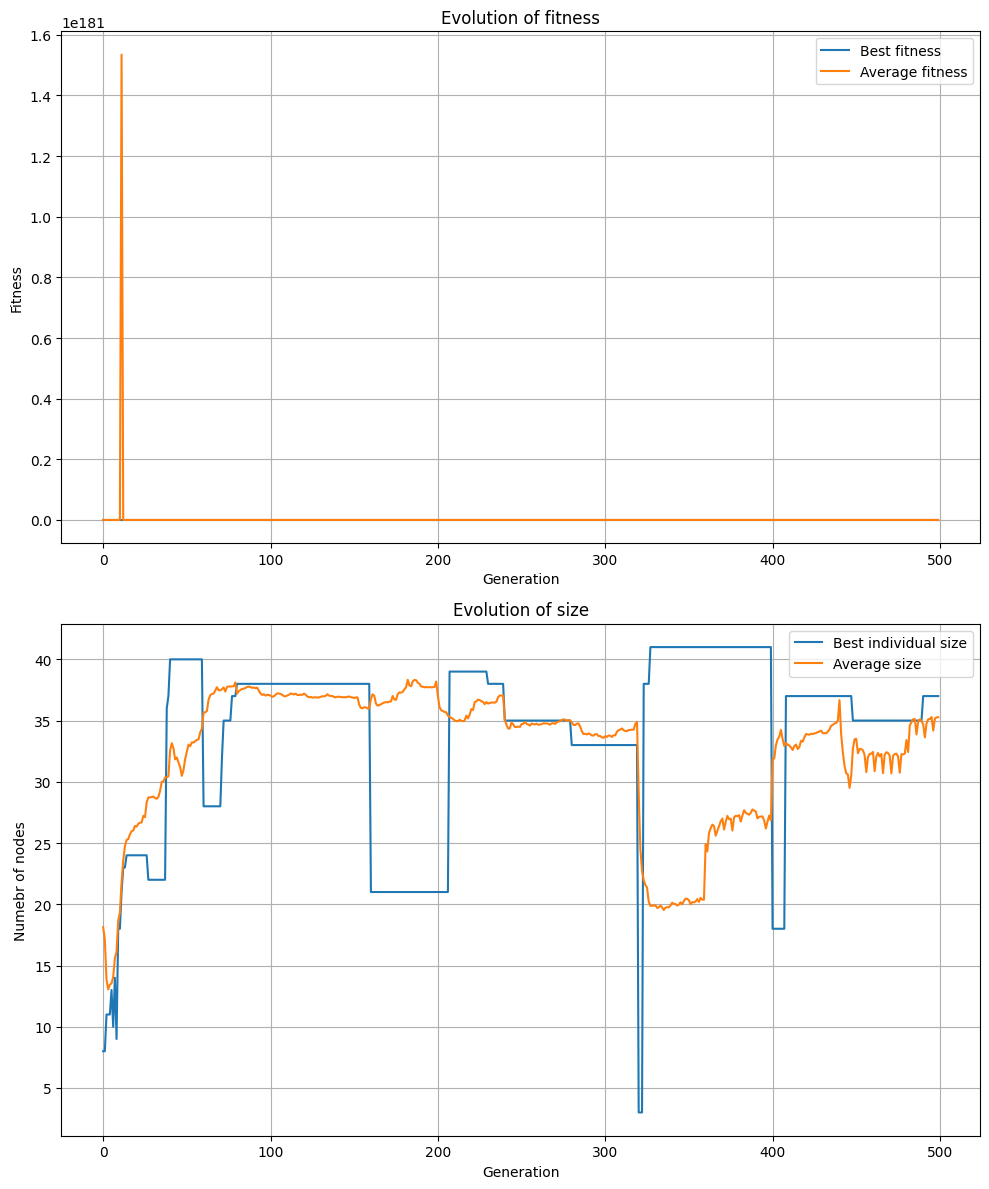

Original expression: ((cos(log(exp(x[1]))) * (exp(((((x[0] * x[0]) * (x[0] / 1.9838837851328108)) - 4.533439746569122) - sin((cos(x[1]) + cos(x[1]))))) - -6.990332232812374)) + sqrt(((-0.40557493864486804 * x[0]) - ((3.8534031209623705 - log(exp(x[0]))) - -6.990332232812374))))
Simplified expression: sqrt(0.59442506135513196*x[0] - 10.843735353774745) + (0.01074365698385143*exp(0.50406178400871155*x[0]**3 - sin(2*cos(x[1]))) + 6.990332232812374)*cos(x[1])
Best fitness(MSE): 6.244233514458511e-05


In [375]:
print(f"\n=== GP execution on {problems[4]['file_path']} ===")
best_tree = run_gp_on_problem(problems[4]['file_path'],
    problems[4]['config'],
    function_weights=problems[4]['config'].get('function_weights'),
    terminal_weights=problems[4]['config'].get('terminal_weights'),
    use_islands=problems[4].get('use_islands', False),
    n_islands=problems[4].get('n_islands', 5),
    migration_interval=problems[4].get('migration_interval', 10),
    migration_rate=problems[4].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_5.npz ===
Loading data from ../data/problem_5.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples

GP execution on ../data/problem_5.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=10, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.06 seconds
  Generated  2000 individuals in  0.11 seconds
  Generated  3000 individuals in  0.83 seconds
  Generated  4000 individuals in  0.89 seconds
  Generated  5000 individuals in  0.95 seconds
  Generated  6000 individuals in  1.00 seconds
  Generate

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 5.5728098835376564e-18 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 5.5728105007517155e-18 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 5.572810060231653e-18 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 5.572809555036966e-18 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 1.3268332706003726e-17 | Mutation Strength: 0.90
Bloat control: 171 individuals exceed the maximum size
Bloat control: 60 individuals exceed the maximum size
Bloat control: 124 individuals exceed the maximum size
Bloat control: 183 individuals exceed the maximum size
Bloat control: 77 individuals exceed the maximum size


  0%|          | 1/500 [01:29<12:25:43, 89.67s/it]

New best solution found:
  Expression: (tan(3.141592653589793) / (cos(((1.8177483699663357 * 0.8263745477529589) / log(3.141592653589793))) - (sqrt(cos(x[0])) / ((x[0] + x[0]) + (2.3993369517587 * 0.8263745477529589)))))
  Simplified Expression: -2.33486982377251e-16/(0.25570148176453169 - sqrt(cos(x[0]))/(2*x[0] + 1.982750988416559))
  Fitness: 5.572809555036966e-18
  Complexity: 22 nodes
Generation 0, Best Fitness: 5.572809555036966e-18


  0%|          | 2/500 [02:54<12:01:28, 86.93s/it]

New best solution found:
  Expression: ((((exp((x[0] + x[1])) * (exp(x[0]) - exp(1.8177483699663357))) - (((x[0] / -3.925491101624397) - 1.0) / ((x[0] / 0.8263745477529589) + sqrt(x[1])))) + ((tan((x[1] * x[1])) * sqrt((-0.7777979427599613 - x[1]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * (tan((tan((0.0 * 0.0)) * ((x[1] * x[0]) + (x[0] + 1.3695207006024344)))) - (sin(3.141592653589793) / (((x[1] + x[0]) + x[0]) - 0.8384371052532815))))
  Simplified Expression: -2.33486982377251e-16*(-(-0.2547451959797317*x[0] - 1.0)/(1.21010503375153*x[0] + sqrt(x[1])) + (sqrt(x[1]) + x[1])*sqrt(-x[1] - 0.7777979427599613)*sin(sin(x[0]))*tan(x[1]**2) + (exp(x[0]) - 6.1579773414591652)*exp(x[0] + x[1]))/(2*x[0] + x[1] - 0.8384371052532815)
  Fitness: 5.563927035534761e-18
  Complexity: 67 nodes


  1%|          | 5/500 [07:08<11:41:28, 85.03s/it]

Bloat control: 14 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


  1%|          | 6/500 [09:16<13:40:19, 99.63s/it]

New best solution found:
  Expression: ((((exp((x[0] + x[1])) * (exp(x[1]) - exp(1.8177483699663357))) - (((x[0] / -3.925491101624397) - 1.0) / ((x[0] / 0.8263745477529589) + sqrt(x[1])))) + ((tan((x[1] * x[1])) * sqrt((-0.7777979427599613 - x[1]))) * ((x[1] + sqrt(x[1])) * sin((((x[1] + x[0]) + x[0]) - (x[1] + x[0])))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(-(-0.2547451959797317*x[0] - 1.0)/(1.21010503375153*x[0] + sqrt(x[1])) + (sqrt(x[1]) + x[1])*sqrt(-x[1] - 0.7777979427599613)*sin(x[0])*tan(x[1]**2) + (exp(x[1]) - 6.1579773414591652)*exp(x[0] + x[1]))
  Fitness: 5.215693184083267e-18
  Complexity: 58 nodes
Generation 5, Best Fitness: 5.215693184083267e-18


  1%|▏         | 7/500 [10:42<13:03:01, 95.30s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (-0.7777979427599613 - x[1]))) - (((x[0] / -3.925491101624397) - 1.0) / ((x[0] / 0.8263745477529589) + sqrt(x[1])))) + ((tan((x[1] * x[1])) * sqrt((-0.7777979427599613 - x[1]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(-(-0.2547451959797317*x[0] - 1.0)/(1.21010503375153*x[0] + sqrt(x[1])) + (sqrt(x[1]) + x[1])*sqrt(-x[1] - 0.7777979427599613)*sin(sin(x[0]))*tan(x[1]**2) + (x[1] + exp(x[0]) + 0.7777979427599613)*exp(2*x[1]))
  Fitness: 3.1844019215348896e-18
  Complexity: 52 nodes


  2%|▏         | 8/500 [12:09<12:39:23, 92.61s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (x[0] / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[1])) * (exp(x[1]) - (x[0] / 0.8263745477529589))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / ((x[0] / 0.8263745477529589) + sqrt(x[1])))) + ((tan((x[1] * x[1])) * sqrt((x[1] + x[0]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*((0.2547451959797317*x[0] + exp(x[0]))*exp(2*x[1]) + sqrt(x[0] + x[1])*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) - (-0.2547451959797317*x[0] - (-1.21010503375153*x[0] + exp(x[1]))*exp(x[0] + x[1]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/(1.21010503375153*x[0] + sqrt(x[1])))
  Fitness: 2.3641182080544764e-18
  Complexity: 70 nodes


  2%|▏         | 9/500 [13:36<12:24:47, 91.01s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (-0.7777979427599613 - x[1]))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[1])) * (exp(x[1]) - -3.925491101624397)) - (((x[0] / -3.925491101624397) - 1.0) / ((x[0] / 0.8263745477529589) + sqrt(x[1]))))) / ((x[0] / 0.8263745477529589) + sqrt(sqrt(x[1]))))) + ((tan((x[1] * x[1])) * sqrt((-0.7777979427599613 - x[1]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*((sqrt(x[1]) + x[1])*sqrt(-x[1] - 0.7777979427599613)*sin(sin(x[0]))*tan(x[1]**2) + (x[1] + exp(x[0]) + 0.7777979427599613)*exp(2*x[1]) - (-0.2547451959797317*x[0] + (-0.2547451959797317*x[0] - 1.0)/(1.21010503375153*x[0] + sqrt(x[1])) - (exp(x[1]) + 3.925491101624397)*exp(x[0] + x[1]))/(1.21010503375153*x[0] + x[1]**(1/4)))
  Fitness: 2.1716145091917063e-18
  Complexity: 74 nodes


  2%|▏         | 10/500 [15:03<12:13:19, 89.80s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (-0.7777979427599613 - x[1]))) - (((x[0] / -3.925491101624397) - 1.0) / ((x[0] / 0.8263745477529589) + sqrt(x[1])))) + ((tan((x[1] * x[1])) * sqrt((-0.7777979427599613 - x[1]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[0] * tan(3.141592653589793)) * (3.141592653589793 * (x[0] / 0.8263745477529589))))
  Simplified Expression: -8.876374406009707e-16*x[0]**2*(-(-0.2547451959797317*x[0] - 1.0)/(1.21010503375153*x[0] + sqrt(x[1])) + (sqrt(x[1]) + x[1])*sqrt(-x[1] - 0.7777979427599613)*sin(sin(x[0]))*tan(x[1]**2) + (x[1] + exp(x[0]) + 0.7777979427599613)*exp(2*x[1]))
  Fitness: 1.5578151621627115e-18
  Complexity: 54 nodes
Bloat control: 58 individuals exceed the maximum size


  2%|▏         | 11/500 [17:19<14:06:01, 103.81s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (x[0] / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[1])) * (exp(x[0]) - (x[0] / -3.925491101624397))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / ((x[0] / sqrt((-0.7777979427599613 - x[1]))) + sqrt(x[1])))) + ((tan((x[1] * x[1])) * sqrt((x[1] + x[0]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*((0.2547451959797317*x[0] + exp(x[0]))*exp(2*x[1]) + sqrt(x[0] + x[1])*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) - (-0.2547451959797317*x[0] - (0.2547451959797317*x[0] + exp(x[0]))*exp(x[0] + x[1]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/(x[0]/sqrt(-x[1] - 0.7777979427599613) + sqrt(x[1])))
  Fitness: 1.4723228496906282e-18
  Complexity: 73 nodes
Generation 10, Best Fitness: 1.4723228496906282e-18


  2%|▏         | 12/500 [18:47<13:25:34, 99.05s/it] 

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(((x[0] / 0.8263745477529589) + sqrt(x[1])))) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - (x[0] / 0.8263745477529589))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((tan((x[1] * x[1])) * sqrt((x[1] + x[0]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(sqrt(x[0] + x[1])*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) + (0.2547451959797317*x[1] + 0.2547451959797317*sqrt(1.21010503375153*x[0] + sqrt(x[1])) + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (-1.21010503375153*x[0] + exp(x[1]))*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.470717105854171e-18
  Complexity: 73 nodes


  3%|▎         | 13/500 [20:16<12:59:08, 95.99s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - (x[0] / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((tan((x[1] * x[1])) * sqrt((x[1] + x[0]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(sqrt(x[0] + x[1])*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) + (0.2547451959797317*sqrt(x[1]) + 0.2547451959797317*x[1] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397)*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.3909331644106853e-18
  Complexity: 70 nodes


  3%|▎         | 14/500 [21:45<12:40:01, 93.83s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(((x[0] / 0.8263745477529589) + sqrt(x[1])))) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - (-0.7777979427599613 - x[1]))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((tan((x[1] * x[1])) * sqrt((x[1] + x[0]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(sqrt(x[0] + x[1])*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) + (0.2547451959797317*x[1] + 0.2547451959797317*sqrt(1.21010503375153*x[0] + sqrt(x[1])) + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (x[1] + exp(x[1]) + 0.7777979427599613)*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.3643536251381768e-18
  Complexity: 73 nodes


  3%|▎         | 15/500 [23:15<12:28:46, 92.63s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((tan((x[1] * x[1])) * sqrt((x[1] + x[0]))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(sqrt(x[0] + x[1])*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) + (0.2547451959797317*sqrt(x[1]) + 0.2547451959797317*x[1] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.3104561289584554e-18
  Complexity: 72 nodes
Bloat control: 133 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the

  3%|▎         | 16/500 [25:48<14:55:03, 110.96s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((tan((x[1] * x[1])) * (x[0] / -3.925491101624397)) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(-0.2547451959797317*x[0]*(sqrt(x[1]) + x[1])*sin(sin(x[0]))*tan(x[1]**2) + (0.2547451959797317*sqrt(x[1]) + 0.2547451959797317*x[1] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.3102334587980376e-18
  Complexity: 71 nodes
Generation 15, Best Fitness: 1.3102334587980376e-18


  3%|▎         | 17/500 [27:17<13:59:16, 104.26s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[0] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((tan((x[1] * x[1])) * sqrt((x[1] + -3.925491101624397))) * ((x[1] + sqrt(x[1])) * sin(sin(x[0]))))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*((sqrt(x[1]) + x[1])*sqrt(x[1] - 3.925491101624397)*sin(sin(x[0]))*tan(x[1]**2) + (0.2547451959797317*x[0] + 0.2547451959797317*sqrt(x[1]) + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.3030432960406744e-18
  Complexity: 72 nodes


  4%|▎         | 18/500 [28:46<13:22:04, 99.84s/it] 

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * x[0]) * (3.141592653589793 * x[0])) * sqrt((x[1] + x[0]))) * (x[1] + x[0]))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(3.141592653589793*x[0]**2*x[1]*(x[0] + x[1])**(3/2) + (0.2547451959797317*sqrt(x[1]) + 0.2547451959797317*x[1] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.2825205129073442e-18
  Complexity: 70 nodes


  4%|▍         | 19/500 [30:18<12:59:09, 97.19s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[0] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * x[0]) * (3.141592653589793 * x[0])) * sqrt((x[1] + x[0]))) * (x[1] + x[0]))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(3.141592653589793*x[0]**2*x[1]*(x[0] + x[1])**(3/2) + (0.2547451959797317*x[0] + 0.2547451959797317*sqrt(x[1]) + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.2745458275601523e-18
  Complexity: 70 nodes


  4%|▍         | 20/500 [31:48<12:41:28, 95.18s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * x[0])) * sqrt((x[1] + x[0]))) * (x[1] + x[0]))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(9.869604401089357*x[0]**2*x[1]*(x[0] + x[1])**(3/2) + (0.2547451959797317*sqrt(x[1]) + 0.2547451959797317*x[1] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.240919662733732e-18
  Complexity: 72 nodes
Bloat control: 86 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 8 individuals exc

  4%|▍         | 21/500 [34:22<15:00:08, 112.75s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (x[0] / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * x[0])) * sqrt((x[1] + x[0]))) * (x[1] + x[0]))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(9.869604401089357*x[0]**2*x[1]*(x[0] + x[1])**(3/2) + (0.2547451959797317*x[0] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.2249410722589563e-18
  Complexity: 69 nodes
Generation 20, Best Fitness: 1.2249410722589563e-18


  4%|▍         | 22/500 [35:52<14:03:20, 105.86s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / (x[1] * x[0])))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * x[0]) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(9.869604401089357*x[0]**2*x[1]*sqrt(x[0] + x[1])*(3.141592653589793*x[0] + x[1]) + (exp(x[0]) - (sqrt(x[1]) + x[1])/(x[0]*x[1]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.1700353687119364e-18
  Complexity: 76 nodes


  5%|▍         | 23/500 [37:23<13:27:02, 101.52s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (0.8263745477529589 / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / -3.925491101624397)))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[0])) + ((((x[1] * x[0]) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(9.869604401089357*x[0]**2*x[1]*sqrt(x[0] + x[1])*(3.141592653589793*x[0] + x[1]) + (exp(x[0]) + 0.2105149461199897)*exp(2*x[1]) - (-0.2547451959797317*x[0] - (exp(x[1]) + 3.925491101624397*x[1]**2/x[0])*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[0])
  Fitness: 1.1426918609347965e-18
  Complexity: 71 nodes


  5%|▍         | 24/500 [38:54<12:59:36, 98.27s/it] 

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / (x[1] * x[0])))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - x[0])) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(31.00627668029981*x[0]**2*x[1]*sqrt(x[0] + x[1])*(3.141592653589793*x[0] + x[1]) + (exp(x[0]) - (sqrt(x[1]) + x[1])/(x[0]*x[1]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (-x[0] + exp(x[1]))*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.0887028887497937e-18
  Complexity: 72 nodes


  5%|▌         | 25/500 [40:24<12:38:07, 95.76s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - (x[0] / -3.925491101624397))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (exp(x[1]) - ((x[1] * x[1]) / (x[0] / x[0])))) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * (x[0] * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + x[0]))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(9.869604401089357*x[0]**3*x[1]*(x[0] + x[1])**(3/2) + (0.2547451959797317*x[0] + exp(x[0]))*exp(2*x[1]) - (-0.2547451959797317*x[0] - (-x[1]**2 + exp(x[1]))*exp(2*x[0]) + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 1.0380843989931698e-18
  Complexity: 71 nodes
Bloat control: 7 individuals exceed the maximum size
Bloat control: 25 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  5%|▌         | 26/500 [43:12<15:28:41, 117.56s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / (x[1] * x[0])))) - (((0.8263745477529589 / -3.925491101624397) - (((((x[0] - 0.8263745477529589) + (x[0] * 2.675569784332674)) * ((x[1] * x[0]) * (3.141592653589793 * x[0]))) * (exp(x[1]) - x[0])) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(31.00627668029981*x[0]**2*x[1]*sqrt(x[0] + x[1])*(3.141592653589793*x[0] + x[1]) + (exp(x[0]) - (sqrt(x[1]) + x[1])/(x[0]*x[1]))*exp(2*x[1]) - (-3.141592653589793*x[0]**2*x[1]*(-x[0] + exp(x[1]))*(3.675569784332674*x[0] - 0.8263745477529589) - 0.2105149461199897 + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[1])
  Fitness: 6.804794148233604e-19
  Complexity: 83 node

  5%|▌         | 27/500 [44:43<14:23:49, 109.58s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / (x[1] * x[0])))) - (((x[0] / -3.925491101624397) - ((exp((x[0] + x[0])) * (3.141592653589793 * x[0])) - (((x[0] / -3.925491101624397) - 1.0) / x[0]))) / x[0])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + (3.141592653589793 * x[0])))) * (x[1] + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(31.00627668029981*x[0]**2*x[1]*(3.141592653589793*x[0] + x[1])**(3/2) + (exp(x[0]) - (sqrt(x[1]) + x[1])/(x[0]*x[1]))*exp(2*x[1]) - (-3.141592653589793*x[0]*exp(2*x[0]) - 0.2547451959797317*x[0] + (-0.2547451959797317*x[0] - 1.0)/x[0])/x[0])
  Fitness: 6.352774684422369e-19
  Complexity: 73 nodes


  6%|▌         | 28/500 [46:13<13:36:00, 103.73s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / (x[1] * x[0])))) - (((0.8263745477529589 / -3.925491101624397) - x[0]) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * ((x[1] * x[0]) + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(31.00627668029981*x[0]**2*x[1]*sqrt(x[0] + x[1])*(x[0]*x[1] + 3.141592653589793*x[0]) + (exp(x[0]) - (sqrt(x[1]) + x[1])/(x[0]*x[1]))*exp(2*x[1]) - (-x[0] - 0.2105149461199897)/x[1])
  Fitness: 5.416818832785922e-19
  Complexity: 58 nodes


  6%|▌         | 29/500 [47:44<13:03:40, 99.83s/it] 

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - (((0.8263745477529589 / -3.925491101624397) - x[0]) / x[1])) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(62.01255336059963*x[0]**2*x[1]*sqrt(x[0] + x[1])*(3.141592653589793*x[0] + x[1]) + (-x[1] + exp(x[0]))*exp(2*x[1]) - (-x[0] - 0.2105149461199897)/x[1])
  Fitness: 4.711996709851649e-19
  Complexity: 51 nodes


  6%|▌         | 30/500 [49:15<12:42:57, 97.40s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - ((x[1] + sqrt(x[1])) / (0.8263745477529589 * x[0])))) - (((0.8263745477529589 / -3.925491101624397) - x[0]) / x[1])) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * ((x[1] * x[0]) + (3.141592653589793 * x[0])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(31.00627668029981*x[0]**2*x[1]*sqrt(x[0] + x[1])*(x[0]*x[1] + 3.141592653589793*x[0]) + (exp(x[0]) - 1.21010503375153*(sqrt(x[1]) + x[1])/x[0])*exp(2*x[1]) - (-x[0] - 0.2105149461199897)/x[1])
  Fitness: 4.697563158316199e-19
  Complexity: 58 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 31/500 [52:01<15:21:21, 117.87s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - (((0.8263745477529589 / -3.925491101624397) - x[0]) / x[1])) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[1] + (3.141592653589793 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(256.8307354286044*x[0]**2*x[1]**2*sqrt(x[0] + x[1]) + (-x[1] + exp(x[0]))*exp(2*x[1]) - (-x[0] - 0.2105149461199897)/x[1])
  Fitness: 4.1423776864449657e-19
  Complexity: 51 nodes
Generation 30, Best Fitness: 4.1423776864449657e-19


  6%|▋         | 32/500 [53:32<14:16:45, 109.84s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - (((0.8263745477529589 / -3.925491101624397) - x[0]) / x[1])) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[1] + x[0]))) * (x[0] + (3.141592653589793 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(62.01255336059963*x[0]**2*x[1]*sqrt(x[0] + x[1])*(x[0] + 3.141592653589793*x[1]) + (-x[1] + exp(x[0]))*exp(2*x[1]) - (-x[0] - 0.2105149461199897)/x[1])
  Fitness: 4.1033293341319197e-19
  Complexity: 51 nodes


  7%|▋         | 33/500 [55:04<13:33:21, 104.50s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - (((0.8263745477529589 / x[1]) - x[0]) / x[1])) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.141592653589793 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(256.8307354286044*sqrt(2)*x[0]**(5/2)*x[1]**2 + (-x[1] + exp(x[0]))*exp(2*x[1]) - (-x[0] + 0.8263745477529589/x[1])/x[1])
  Fitness: 3.9568542342674666e-19
  Complexity: 51 nodes


  7%|▋         | 34/500 [56:35<13:00:08, 100.45s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - ((((3.141592653589793 * x[0]) / x[1]) - x[0]) / x[1])) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.141592653589793 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(256.8307354286044*sqrt(2)*x[0]**(5/2)*x[1]**2 + (-x[1] + exp(x[0]))*exp(2*x[1]) - (-x[0] + 3.141592653589793*x[0]/x[1])/x[1])
  Fitness: 3.9562814299469887e-19
  Complexity: 53 nodes


  7%|▋         | 35/500 [58:08<12:40:59, 98.19s/it] 

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - exp((x[1] + x[1]))) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.141592653589793 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(256.8307354286044*sqrt(2)*x[0]**(5/2)*x[1]**2 + (-x[1] + exp(x[0]))*exp(2*x[1]) - exp(2*x[1]))
  Fitness: 3.879805818183099e-19
  Complexity: 48 nodes
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  7%|▋         | 36/500 [1:01:28<16:34:41, 128.62s/it]

Generation 35, Best Fitness: 3.879805818183099e-19


  8%|▊         | 38/500 [1:04:30<14:03:37, 109.56s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - exp((x[1] + x[1]))) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.2780375846758716 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(265.29203399836323*sqrt(2)*x[0]**(5/2)*x[1]**2 + (-x[1] + exp(x[0]))*exp(2*x[1]) - exp(2*x[1]))
  Fitness: 3.760517684378581e-19
  Complexity: 48 nodes


  8%|▊         | 39/500 [1:06:03<13:23:00, 104.51s/it]

Performing inter-island migration...
  Island 0 diversity: 0.002
  Island 1 diversity: 0.193
  Island 2 diversity: 0.233
  Island 3 diversity: 0.177


  8%|▊         | 40/500 [1:07:49<13:23:52, 104.85s/it]

  Island 4 diversity: 0.263
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.57)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.12)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.26)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
New best solution found:
  Expression: (((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - exp((x[1] + x[1]))) - exp((x[1] + x[1]))) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.361638558889929 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.2780375846758716 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(283.87382744742146*sqrt(2)*x[0]**(5/2)*x[1]**2 + (-x[1] + exp(x[0]))*exp(2*x[1]) - 2*exp(2*x[1]))
  Fitness: 3.6087422786353956e-19
  Complexity: 53 nod

  8%|▊         | 41/500 [1:10:33<15:38:55, 122.74s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - exp((x[1] + x[1]))) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.2780375846758716 * x[1])))) * ((x[1] * tan(3.141592653589793)) * ((x[0] - x[0]) * x[0])))
  Simplified Expression: 0
  Fitness: 7.521035368757161e-20
  Complexity: 50 nodes
Generation 40, Best Fitness: 7.521035368757161e-20


  8%|▊         | 42/500 [1:12:00<14:15:45, 112.11s/it]

New best solution found:
  Expression: ((((exp((x[1] + x[1])) * (exp(x[0]) - x[1])) - exp((x[1] + x[1]))) + (((((x[1] + x[1]) * (3.141592653589793 * x[0])) * (3.141592653589793 * (3.141592653589793 * x[0]))) * sqrt((x[0] + x[0]))) * (x[1] + (3.2780375846758716 * x[1])))) * ((x[1] * tan(3.141592653589793)) * ((x[0] - x[0]) * x[0])))
  Simplified Expression: 0
  Fitness: 3.7605176843785807e-20
  Complexity: 50 nodes


  9%|▉         | 46/500 [1:20:46<18:21:45, 145.61s/it]

Generation 45, Best Fitness: 3.7605176843785807e-20


 10%|█         | 50/500 [1:26:43<12:50:40, 102.76s/it]

Bloat control: 6 individuals exceed the maximum size


 10%|█         | 51/500 [1:31:18<19:16:57, 154.60s/it]

Generation 50, Best Fitness: 3.7605176843785807e-20


 11%|█         | 55/500 [1:37:16<13:00:03, 105.18s/it]

Bloat control: 1945 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 11%|█         | 56/500 [1:41:44<18:59:50, 154.03s/it]

Generation 55, Best Fitness: 3.7605176843785807e-20


 12%|█▏        | 60/500 [1:47:41<12:48:04, 104.74s/it]

New best solution found:
  Expression: (((x[0] - x[0]) + (-1.0 * x[0])) * ((x[1] * x[1]) * (3.141592653589793 * x[0])))
  Simplified Expression: -3.141592653589793*x[0]**2*x[1]**2
  Fitness: 3.109262976132617e-20
  Complexity: 15 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1499 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:51:37<17:34:53, 144.18s/it]

New best solution found:
  Expression: (((x[1] - exp((x[1] + x[1]))) + ((((x[1] * (3.141592653589793 * x[0])) * (3.141592653589793 * 1.3885082362013481)) * sqrt(((sin(((x[0] - 0.8263745477529589) + x[1])) - (x[1] * cos((0.8263745477529589 - x[1])))) + (3.141592653589793 - (x[0] * x[0]))))) * ((sin(1.3885082362013481) - (x[0] * cos((0.8263745477529589 - x[1])))) + x[1]))) * ((x[1] * x[1]) * (3.141592653589793 * x[0])))
  Simplified Expression: 3.141592653589793*x[0]*x[1]**2*(13.704026998961646*x[0]*x[1]*(-x[0]*cos(x[1] - 0.8263745477529589) + x[1] + 0.98343148187650259)*sqrt(-x[0]**2 - x[1]*cos(x[1] - 0.8263745477529589) + sin(x[0] + x[1] - 0.8263745477529589) + 3.141592653589793) + x[1] - exp(2*x[1]))
  Fitness: 1.7345297608113856e-20
  Complexity: 57 nodes
Generation 60, Best Fitness: 1.7345297608113856e-20


 13%|█▎        | 65/500 [1:57:38<12:27:46, 103.14s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 117 individuals exceed the maximum size
Bloat control: 473 individuals exceed the maximum size
Bloat control: 1334 individuals exceed the maximum size


 13%|█▎        | 66/500 [2:00:33<15:03:17, 124.88s/it]

Generation 65, Best Fitness: 1.7345297608113856e-20


 14%|█▍        | 70/500 [2:06:29<11:40:33, 97.75s/it] 

Bloat control: 1168 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1198 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:09:06<13:47:42, 115.76s/it]

Generation 70, Best Fitness: 1.7345297608113856e-20


 15%|█▌        | 75/500 [2:15:02<11:15:35, 95.38s/it] 

Bloat control: 1677 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:17:43<13:32:34, 114.99s/it]

Generation 75, Best Fitness: 1.7345297608113856e-20


 16%|█▌        | 79/500 [2:22:05<11:20:16, 96.95s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.030
  Island 1 diversity: 0.005
  Island 2 diversity: 0.011
  Island 3 diversity: 0.013


 16%|█▌        | 80/500 [2:23:40<11:13:08, 96.16s/it]

  Island 4 diversity: 0.004
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.08)
Bloat control: 27 individuals exceed the maximum size
Bloat control: 25 individuals exceed the maximum size
Bloat control: 1314 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:26:02<12:48:59, 110.12s/it]

Generation 80, Best Fitness: 1.7345297608113856e-20


 17%|█▋        | 85/500 [2:31:48<10:36:52, 92.08s/it] 

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1475 individuals exceed the maximum size


 17%|█▋        | 86/500 [2:33:57<11:52:45, 103.30s/it]

Generation 85, Best Fitness: 1.7345297608113856e-20


 17%|█▋        | 87/500 [2:35:23<11:15:07, 98.08s/it] 

New best solution found:
  Expression: (((((exp(x[0]) * (exp(x[0]) - (log(x[1]) + (sqrt(x[0]) + x[1])))) - exp((x[1] + x[1]))) - x[0]) + (((x[1] * (3.310639202178776 * (3.361638558889929 * x[0]))) * sqrt((tan(sin(x[0])) + (sqrt((x[1] * x[1])) + x[1])))) * ((log(log(x[1])) + x[1]) + 1.3885082362013481))) * ((x[1] * tan(3.141592653589793)) * (3.141592653589793 * x[0])))
  Simplified Expression: -7.335209885452211e-16*x[0]*x[1]*(11.12917239661676*x[0]*x[1]*(x[1] + log(log(x[1])) + 1.3885082362013481)*sqrt(x[1] + tan(sin(x[0])) + Abs(x[1])) - x[0] + (-sqrt(x[0]) - x[1] + exp(x[0]) - log(x[1]))*exp(x[0]) - exp(2*x[1]))
  Fitness: 1.4693628397697373e-20
  Complexity: 57 nodes


 18%|█▊        | 90/500 [2:39:42<10:16:37, 90.24s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 65 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:41:45<11:22:44, 100.16s/it]

Generation 90, Best Fitness: 1.4693628397697373e-20


 19%|█▉        | 95/500 [2:47:28<10:03:04, 89.34s/it] 

Bloat control: 4 individuals exceed the maximum size


 19%|█▉        | 96/500 [2:49:34<11:15:02, 100.25s/it]

Generation 95, Best Fitness: 1.4693628397697373e-20


 20%|██        | 100/500 [2:55:15<9:52:22, 88.86s/it] 

Island 0 | Generation 100 | Best Fitness: 1.6834452211021953e-20 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 2.8164676240454513e-20 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 1.4693628397697373e-20 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 1.7345297608113856e-20 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 2.734845104950569e-20 | Mutation Strength: 3.00


 20%|██        | 101/500 [2:57:16<10:56:03, 98.66s/it]

Generation 100, Best Fitness: 1.4693628397697373e-20


 21%|██        | 105/500 [3:02:57<9:43:10, 88.58s/it] 

Bloat control: 28 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 21%|██        | 106/500 [3:04:58<10:44:40, 98.17s/it]

Generation 105, Best Fitness: 1.4693628397697373e-20


 22%|██▏       | 110/500 [3:10:41<9:38:09, 88.95s/it] 

Bloat control: 231 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:12:46<10:45:57, 99.63s/it]

Generation 110, Best Fitness: 1.4693628397697373e-20


 23%|██▎       | 115/500 [3:18:31<9:33:57, 89.45s/it] 

Bloat control: 1431 individuals exceed the maximum size


 23%|██▎       | 116/500 [3:20:34<10:36:55, 99.52s/it]

Generation 115, Best Fitness: 1.4693628397697373e-20


 24%|██▍       | 119/500 [3:24:49<9:31:32, 90.01s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.015
  Island 1 diversity: 0.013
  Island 2 diversity: 0.017
  Island 3 diversity: 0.012
  Island 4 diversity: 0.015
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.01)


 24%|██▍       | 120/500 [3:26:20<9:32:52, 90.45s/it]

  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 133 individuals exceed the maximum size
Bloat control: 21 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:28:06<10:01:26, 95.22s/it]

Generation 120, Best Fitness: 1.4693628397697373e-20


 25%|██▌       | 126/500 [3:35:55<10:15:07, 98.68s/it]

Generation 125, Best Fitness: 1.4693628397697373e-20


 26%|██▌       | 130/500 [3:41:41<9:11:17, 89.40s/it] 

Bloat control: 1 individuals exceed the maximum size


 26%|██▌       | 131/500 [3:43:48<10:18:56, 100.64s/it]

Generation 130, Best Fitness: 1.4693628397697373e-20


 27%|██▋       | 135/500 [3:49:33<9:05:34, 89.68s/it]  

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 27%|██▋       | 136/500 [3:51:32<9:57:38, 98.51s/it]

Generation 135, Best Fitness: 1.4693628397697373e-20


 28%|██▊       | 140/500 [3:57:18<8:56:06, 89.35s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 28%|██▊       | 141/500 [3:59:25<10:02:15, 100.65s/it]

Generation 140, Best Fitness: 1.4693628397697373e-20


 29%|██▉       | 145/500 [4:05:16<9:00:46, 91.40s/it]  

Bloat control: 1 individuals exceed the maximum size


 29%|██▉       | 146/500 [4:07:23<10:03:24, 102.27s/it]

Generation 145, Best Fitness: 1.4693628397697373e-20


 30%|███       | 150/500 [4:13:14<8:51:37, 91.14s/it]  

Bloat control: 4 individuals exceed the maximum size


 30%|███       | 151/500 [4:15:30<10:07:46, 104.49s/it]

Generation 150, Best Fitness: 1.4693628397697373e-20


 31%|███       | 155/500 [4:21:20<8:46:26, 91.55s/it]  

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 31%|███       | 156/500 [4:23:30<9:50:55, 103.07s/it]

Generation 155, Best Fitness: 1.4693628397697373e-20


 32%|███▏      | 159/500 [4:27:53<8:48:11, 92.94s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.019
  Island 1 diversity: 0.004
  Island 2 diversity: 0.013
  Island 3 diversity: 0.015


 32%|███▏      | 160/500 [4:29:27<8:48:19, 93.23s/it]

  Island 4 diversity: 0.015
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 40 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 64 individuals exceed the maximum size


 32%|███▏      | 161/500 [4:32:25<11:10:39, 118.70s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp((((x[1] - x[0]) + x[1]) + x[1]))) - exp(((cos(x[1]) + exp((1.0268182704081645 * 2.2750621259462522))) + cos(x[1])))) - exp(exp((x[1] * cos(((x[1] + x[1]) * x[1])))))) - exp(exp((1.0268182704081645 * 2.2425087553168987)))) + (((((x[1] + x[1]) * (3.465292865895344 * x[0])) * (3.361638558889929 * (3.465292865895344 * x[0]))) * x[1]) * (x[1] + (3.465292865895344 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (2.675569784332674 * x[0])))
  Simplified Expression: -6.247107150835882e-16*x[0]*x[1]*(360.5046322468455*x[0]**2*x[1]**3 + (-2*x[1] + exp(x[0]))*exp(2*x[1]) - exp(-x[0] + 3*x[1]) - exp(exp(x[1]*cos(2*x[1]**2))) - 30963.790842483471*exp(2*cos(x[1])) - 22040.538714560507)
  Fitness: 9.447025056264845e-21
  Complexity: 80 nodes
Generation 160, Best Fitness: 9.447025056264845e-21


 32%|███▏      | 162/500 [4:33:56<10:22:51, 110.57s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp(((0.7768137509960568 + x[1]) + x[1]))) - exp(((cos(x[1]) + (x[0] + (x[0] * x[1]))) + cos(x[1])))) - exp(exp((1.0268182704081645 * 2.2425087553168987)))) - exp(exp(x[1]))) + (((((x[1] + x[1]) * (3.4888517004591266 * x[0])) * (3.361638558889929 * (3.465292865895344 * x[0]))) * x[1]) * (x[1] + (3.465292865895344 * (-3.987012216913978 + (sqrt((tan(x[1]) - sin(x[1]))) - (x[0] + (sin(x[1]) + 1.3481136162433938)))))))) * ((x[1] * tan(3.141592653589793)) * (2.675569784332674 * x[0])))
  Simplified Expression: -6.247107150835882e-16*x[0]*x[1]*(81.283700343204585*x[0]**2*x[1]**2*(-3.465292865895344*x[0] + x[1] + 3.465292865895344*sqrt(-sin(x[1]) + tan(x[1])) - 3.465292865895344*sin(x[1]) - 18.487773488294194) + (-2*x[1] + exp(x[0]))*exp(2*x[1]) - 2.174532613266184*exp(2*x[1]) - exp(x[0]*x[1] + x[0] + 2*cos(x[1])) - exp(exp(x[1])) - 22040.538714560507)
  Fitness: 9.440319729797983e-21
  Complexit

 33%|███▎      | 165/500 [4:38:35<9:13:10, 99.08s/it]  

Bloat control: 11 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 33%|███▎      | 166/500 [4:42:00<12:07:47, 130.74s/it]

Generation 165, Best Fitness: 9.440319729797983e-21


 34%|███▍      | 170/500 [4:48:23<9:36:09, 104.76s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 34%|███▍      | 171/500 [4:52:16<13:05:58, 143.34s/it]

Generation 170, Best Fitness: 9.440319729797983e-21


 35%|███▌      | 175/500 [4:58:24<9:28:00, 104.86s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 35%|███▌      | 176/500 [5:03:31<14:52:59, 165.37s/it]

Generation 175, Best Fitness: 9.440319729797983e-21


 36%|███▌      | 180/500 [5:11:48<11:59:03, 134.82s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size


 36%|███▌      | 181/500 [5:17:12<16:57:45, 191.43s/it]

Generation 180, Best Fitness: 9.440319729797983e-21


 37%|███▋      | 185/500 [5:26:49<13:29:13, 154.14s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 37%|███▋      | 186/500 [5:33:40<20:10:00, 231.21s/it]

Generation 185, Best Fitness: 9.440319729797983e-21


 38%|███▊      | 190/500 [5:40:18<11:10:39, 129.81s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 63 individuals exceed the maximum size


 38%|███▊      | 191/500 [5:44:57<14:59:05, 174.58s/it]

Generation 190, Best Fitness: 9.440319729797983e-21


 39%|███▉      | 195/500 [5:51:17<9:38:09, 113.74s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 39%|███▉      | 196/500 [5:55:37<13:18:57, 157.69s/it]

Generation 195, Best Fitness: 9.440319729797983e-21


 40%|███▉      | 199/500 [6:00:19<9:41:45, 115.97s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.005
  Island 2 diversity: 0.004
  Island 3 diversity: 0.007
  Island 4 diversity: 0.005


 40%|████      | 200/500 [6:02:10<9:32:20, 114.47s/it]

  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 200 | Best Fitness: 9.440319729797983e-21 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 8.963052124485174e-21 | Mutation Strength: 2.70
Island 2 | Generation 200 | Best Fitness: 9.447025056264845e-21 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 9.447025056264845e-21 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 9.440319729797983e-21 | Mutation Strength: 3.00
Bloat control: 12 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the max

 40%|████      | 201/500 [6:07:45<14:59:55, 180.59s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp(((0.8384371052532815 + x[1]) + x[1]))) - exp(((cos(x[1]) + exp((x[1] * x[1]))) + cos(x[1])))) - exp(exp((1.0268182704081645 * 2.2781987579785192)))) - exp(exp((1.0268182704081645 * 2.2425087553168987)))) + (((((x[1] + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.4888517004591266 * x[0]))) * x[1]) * (x[1] + (3.500887027299728 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (2.675569784332674 * x[0])))
  Simplified Expression: -6.247107150835882e-16*x[0]*x[1]*(369.60661070122801*x[0]**2*x[1]**3 + (-2*x[1] + exp(x[0]))*exp(2*x[1]) - 2.312749566553665*exp(2*x[1]) - exp(exp(x[1]**2) + 2*cos(x[1])) - 54054.643774182199)
  Fitness: 8.963052124485174e-21
  Complexity: 73 nodes
Generation 200, Best Fitness: 8.963052124485174e-21


 40%|████      | 202/500 [6:09:50<13:33:18, 163.75s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp(((0.776272824909879 + x[1]) + (x[1] + cos(x[1]))))) - exp(((x[0] + exp((1.0268182704081645 * 2.2750621259462522))) + cos(x[1])))) - exp(exp((1.0268182704081645 * 2.2750621259462522)))) - exp(exp((1.0268182704081645 * 2.2425087553168987)))) + (((((x[1] + x[1]) * (3.491554193461125 * x[0])) * (3.361638558889929 * (3.4888517004591266 * x[0]))) * x[1]) * (x[1] + (3.491554193461125 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (log((x[0] * sqrt((-4.891856414858232 / 3.141592653589793)))) * x[0])))
  Simplified Expression: exp(x[1] + x[1]) * (expx[0] - (x[1] + x[1]) - exp(0.776272824909879 + x[1]) + (x[1] + cosx[1] - exp(x[0] + exp(1.0268182704081645 * 2.2750621259462522) + cosx[1] - exp(exp(1.0268182704081645 * 2.2750621259462522))) - exp(exp(1.0268182704081645 * 2.2425087553168987))) + (x[1] + x[1]) * (3.491554193461125 * x[0]) * (3.361638558889929 * (3.4888517004591266 * x[0]) * x[1]) *

 41%|████      | 205/500 [6:16:15<11:32:15, 140.80s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 262 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 41%|████      | 206/500 [6:23:07<18:08:56, 222.23s/it]

Generation 205, Best Fitness: 8.8245735557676e-21


 42%|████▏     | 210/500 [6:34:36<14:49:33, 184.05s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 370 individuals exceed the maximum size


 42%|████▏     | 211/500 [6:42:25<21:37:53, 269.46s/it]

Generation 210, Best Fitness: 8.8245735557676e-21


 43%|████▎     | 215/500 [6:49:55<11:32:33, 145.80s/it]

Bloat control: 1568 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1660 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 43%|████▎     | 216/500 [6:54:13<14:08:50, 179.33s/it]

Generation 215, Best Fitness: 8.8245735557676e-21


 43%|████▎     | 217/500 [6:55:46<12:03:56, 153.49s/it]

New best solution found:
  Expression: (((((x[0] - exp(x[0])) - exp(exp(x[1]))) - (((3.361638558889929 * (3.491554193461125 * x[0])) * -2.666213551450044) * ((x[0] - 2.675569784332674) + (x[0] * x[0])))) + (((((x[1] + x[1]) * 2.3993369517587) * (3.361638558889929 * (3.491554193461125 * x[0]))) * x[1]) * (x[1] + (3.491554193461125 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (2.675569784332674 * x[0])))
  Simplified Expression: -6.247107150835882e-16*x[0]*x[1]*(252.9808725260918*x[0]*x[1]**3 + 31.29426351703742*x[0]*(x[0]**2 + x[0] - 2.675569784332674) + x[0] - exp(x[0]) - exp(exp(x[1])))
  Fitness: 8.677902707290852e-21
  Complexity: 53 nodes


 44%|████▍     | 219/500 [6:58:54<9:36:43, 123.14s/it] 

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * x[1]) - exp(((0.776272824909879 + x[1]) + (x[1] + cos(x[1]))))) - exp(x[0])) - exp(exp((1.0268182704081645 * 2.2750621259462522)))) - (((3.361638558889929 * (3.491554193461125 * x[0])) * -2.666213551450044) * ((x[0] - 3.141592653589793) + x[0]))) + (((3.809648896527027 * x[1]) * x[1]) * (x[1] + (3.491554193461125 * x[1])))) * ((x[1] * tan(3.141592653589793)) * (2.675569784332674 * x[0])))
  Simplified Expression: -6.247107150835882e-16*x[0]*x[1]*(31.29426351703742*x[0]*(2*x[0] - 3.141592653589793) + 17.11124447681052*x[1]**3 + x[1]*exp(2*x[1]) - exp(x[0]) - 2.17335666992831*exp(2*x[1] + cos(x[1])) - 30963.790842483471)
  Fitness: 8.677348192622967e-21
  Complexity: 60 nodes


 44%|████▍     | 220/500 [7:00:27<8:52:58, 114.21s/it]

Bloat control: 258 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 44%|████▍     | 221/500 [7:04:38<12:01:20, 155.13s/it]

Generation 220, Best Fitness: 8.677348192622967e-21


 45%|████▍     | 224/500 [7:09:19<8:48:09, 114.82s/it] 

New best solution found:
  Expression: (((x[0] - x[0]) + (0.0 * x[0])) * ((x[1] * 3.141592653589793) * (2.675569784332674 * x[0])))
  Simplified Expression: 0
  Fitness: 8.667302624605669e-21
  Complexity: 15 nodes


 45%|████▌     | 225/500 [7:10:54<8:18:36, 108.79s/it]

Bloat control: 19 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 45%|████▌     | 226/500 [7:14:22<10:33:47, 138.79s/it]

Generation 225, Best Fitness: 8.667302624605669e-21


 46%|████▌     | 230/500 [7:20:35<7:47:46, 103.95s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 46%|████▌     | 231/500 [7:25:07<11:31:42, 154.28s/it]

Generation 230, Best Fitness: 8.667302624605669e-21


 47%|████▋     | 235/500 [7:31:21<7:58:10, 108.26s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 47%|████▋     | 236/500 [7:35:27<10:58:49, 149.73s/it]

Generation 235, Best Fitness: 8.667302624605669e-21


 48%|████▊     | 239/500 [7:40:06<8:09:34, 112.55s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.017
  Island 1 diversity: 0.002
  Island 2 diversity: 0.005
  Island 3 diversity: 0.004
  Island 4 diversity: 0.003
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.04)


 48%|████▊     | 240/500 [7:41:43<7:47:01, 107.77s/it]

Bloat control: 36 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 38 individuals exceed the maximum size


 48%|████▊     | 241/500 [7:45:33<10:24:18, 144.63s/it]

Generation 240, Best Fitness: 8.667302624605669e-21


 49%|████▉     | 245/500 [7:51:46<7:29:33, 105.78s/it] 

Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 49%|████▉     | 246/500 [7:55:43<10:13:31, 144.93s/it]

Generation 245, Best Fitness: 8.667302624605669e-21


 50%|█████     | 250/500 [8:01:54<7:17:49, 105.08s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 50%|█████     | 251/500 [8:04:57<8:53:24, 128.53s/it]

Generation 250, Best Fitness: 8.667302624605669e-21


 51%|█████     | 255/500 [8:11:03<6:49:55, 100.39s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 51%|█████     | 256/500 [8:14:55<9:28:25, 139.78s/it]

Generation 255, Best Fitness: 8.667302624605669e-21


 52%|█████▏    | 260/500 [8:21:06<6:56:13, 104.06s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 52%|█████▏    | 261/500 [8:24:23<8:45:26, 131.91s/it]

Generation 260, Best Fitness: 8.667302624605669e-21


 53%|█████▎    | 265/500 [8:30:33<6:40:15, 102.19s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 53%|█████▎    | 266/500 [8:34:00<8:40:35, 133.48s/it]

Generation 265, Best Fitness: 8.667302624605669e-21


 54%|█████▍    | 270/500 [8:40:07<6:30:38, 101.90s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 54%|█████▍    | 271/500 [8:43:50<8:47:15, 138.15s/it]

Generation 270, Best Fitness: 8.667302624605669e-21


 55%|█████▌    | 275/500 [8:49:59<6:27:05, 103.22s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 55%|█████▌    | 276/500 [8:52:49<7:40:30, 123.35s/it]

Generation 275, Best Fitness: 8.667302624605669e-21


 56%|█████▌    | 279/500 [8:57:26<6:19:06, 102.93s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.005
  Island 2 diversity: 0.004
  Island 3 diversity: 0.003
  Island 4 diversity: 0.005
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)


 56%|█████▌    | 280/500 [8:59:04<6:12:30, 101.59s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 44 individuals exceed the maximum size


 56%|█████▌    | 281/500 [9:02:27<8:02:00, 132.06s/it]

New best solution found:
  Expression: (((x[0] - x[1]) + (0.7916925234427801 * x[1])) * ((x[1] * x[1]) * (2.675569784332674 * x[0])))
  Simplified Expression: 2.675569784332674*x[0]*x[1]**2*(x[0] - 0.2083074765572199*x[1])
  Fitness: 8.634667402976357e-21
  Complexity: 15 nodes
Generation 280, Best Fitness: 8.634667402976357e-21


 57%|█████▋    | 285/500 [9:08:44<6:10:47, 103.48s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 57%|█████▋    | 286/500 [9:13:13<9:06:05, 153.11s/it]

Generation 285, Best Fitness: 8.634667402976357e-21


 58%|█████▊    | 290/500 [9:19:33<6:21:38, 109.04s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 58%|█████▊    | 291/500 [9:24:59<10:06:31, 174.12s/it]

Generation 290, Best Fitness: 8.634667402976357e-21


 59%|█████▉    | 295/500 [9:31:18<6:28:29, 113.71s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 59%|█████▉    | 296/500 [9:35:47<9:05:42, 160.50s/it]

Generation 295, Best Fitness: 8.634667402976357e-21


 60%|██████    | 300/500 [9:42:09<6:10:07, 111.04s/it]

Island 0 | Generation 300 | Best Fitness: 8.766400581635522e-21 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 8.634667402976357e-21 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 8.681231281595055e-21 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 8.667302624605669e-21 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 8.766400581635522e-21 | Mutation Strength: 3.00
Bloat control: 82 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 66 individuals exceed the maximum size


 60%|██████    | 301/500 [9:47:16<9:22:45, 169.68s/it]

Generation 300, Best Fitness: 8.634667402976357e-21


 61%|██████    | 305/500 [9:53:32<6:05:11, 112.37s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 953 individuals exceed the maximum size


 61%|██████    | 306/500 [9:57:09<7:44:45, 143.74s/it]

Generation 305, Best Fitness: 8.634667402976357e-21


 62%|██████▏   | 310/500 [10:03:19<5:31:16, 104.61s/it]

Bloat control: 12 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 263 individuals exceed the maximum size


 62%|██████▏   | 311/500 [10:07:24<7:42:12, 146.73s/it]

Generation 310, Best Fitness: 8.634667402976357e-21


 62%|██████▏   | 312/500 [10:08:56<6:48:04, 130.23s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp(((sqrt(x[1]) * x[1]) + (x[1] + -4.959405065510022)))) - exp(((cos(x[1]) + exp((1.0268182704081645 * 2.2750621259462522))) + cos(x[1])))) - exp(exp((1.0268182704081645 * 2.284898613222542)))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.500887027299728 * x[0]))) * tan(tan(sqrt(x[1])))) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(372.64903981011208*x[0]**2*x[1]**2*tan(tan(sqrt(x[1]))) + (-2*x[1] + exp(x[0]))*exp(2*x[1]) - 0.007017101306577467*exp(x[1]**(3/2) + x[1]) - 30963.790842483471*exp(2*cos(x[1])) - 58566.827599978181)
  Fitness: 8.531987015717751e-21
  Complexity: 79 nodes


 63%|██████▎   | 313/500 [10:10:26<6:08:03, 118.09s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - ((1.3885082362013481 + x[0]) + x[1]))) - exp((0.0 + x[1]))) - exp(((cos(x[1]) + exp((1.0268182704081645 * 2.2750621259462522))) + cos(x[1])))) - exp(exp((1.0268182704081645 * 2.2855621044222545)))) - exp(exp((1.0268182704081645 * 2.244516530525899)))) + (((((((0.8384371052532815 * (x[1] + x[1])) / 1.6435690906132479) + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.500887027299728 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * 0.0) * (2.666851478525177 * x[1])))
  Simplified Expression: 0
  Fitness: 8.322809296760489e-21
  Complexity: 78 nodes


 63%|██████▎   | 315/500 [10:13:25<5:19:36, 103.66s/it]

Bloat control: 10 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 63%|██████▎   | 316/500 [10:16:50<6:50:50, 133.97s/it]

Generation 315, Best Fitness: 8.322809296760489e-21


 64%|██████▍   | 319/500 [10:21:28<5:22:02, 106.76s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.004
  Island 2 diversity: 0.004
  Island 3 diversity: 0.007
  Island 4 diversity: 0.017
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.03)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)


 64%|██████▍   | 320/500 [10:23:09<5:15:18, 105.11s/it]

Bloat control: 484 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 40 individuals exceed the maximum size


 64%|██████▍   | 321/500 [10:27:30<7:32:56, 151.82s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp(((sqrt(x[1]) * x[1]) + ((-1.7339327499352128 / x[0]) / x[0])))) - exp(((exp(x[1]) + exp((1.0313207364704762 * 2.251472887460892))) + tan(cos(x[1]))))) - exp(exp((1.0268182704081645 * 2.284898613222542)))) - exp(exp((1.0313207364704762 * 2.251472887460892)))) + (((((x[1] + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.491554193461125 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(371.65561398930081*x[0]**2*x[1]**3 + (-2*x[1] + exp(x[0]))*exp(2*x[1]) - exp(x[1]**(3/2) - 1.7339327499352128/x[0]**2) - 26794.474144456031*exp(exp(x[1]) + tan(cos(x[1]))) - 61185.321234465523)
  Fitness: 8.189649466985459e-21
  Complexity: 79 nodes
Generation 320, Best Fitness: 8.189649466985459e-21


 65%|██████▌   | 325/500 [10:33:53<5:21:24, 110.20s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 15 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 65%|██████▌   | 326/500 [10:37:46<7:06:37, 147.11s/it]

Generation 325, Best Fitness: 8.189649466985459e-21


 66%|██████▌   | 330/500 [10:44:07<5:05:10, 107.71s/it]

Bloat control: 1424 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 54 individuals exceed the maximum size
Bloat control: 34 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 66%|██████▌   | 331/500 [10:48:27<7:12:14, 153.46s/it]

Generation 330, Best Fitness: 8.189649466985459e-21


 66%|██████▋   | 332/500 [10:50:02<6:20:24, 135.86s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[1]))) - exp(((sqrt(x[1]) * x[1]) + ((x[0] - 3.141592653589793) / x[0])))) - exp(((cos((x[0] / 2.675569784332674)) + exp((1.0268182704081645 * 2.251472887460892))) + tan(x[0])))) - exp(exp((1.0268182704081645 * 2.284898613222542)))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.5223357406663833 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(374.93213046082964*x[0]**2*x[1]**3 + (-2*x[1] + exp(x[0]))*exp(2*x[1]) - exp(x[1]**(3/2) + (x[0] - 3.141592653589793)/x[0]) - 24175.980509968689*exp(cos(0.3737521651857847*x[0]) + tan(x[0])) - 58566.827599978181)
  Fitness: 7.785329013757019e-21
  Complexity: 80 nodes


 67%|██████▋   | 335/500 [10:55:05<5:11:15, 113.19s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 75 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 1469 individuals exceed the maximum size


 67%|██████▋   | 336/500 [11:00:32<8:04:40, 177.32s/it]

Generation 335, Best Fitness: 7.785329013757019e-21


 67%|██████▋   | 337/500 [11:03:06<7:43:03, 170.45s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[0]))) - exp(((sqrt(x[1]) * x[1]) + x[0]))) - exp(((sin(x[0]) + exp((1.0268182704081645 * 2.2750621259462522))) + tan(cos(x[1]))))) - exp(exp((1.0268182704081645 * 2.284898613222542)))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.491554193461125 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(371.65561398930081*x[0]**2*x[1]**3 + (-x[0] - x[1] + exp(x[0]))*exp(2*x[1]) - exp(x[0] + x[1]**(3/2)) - 30963.790842483471*exp(sin(x[0]) + tan(cos(x[1]))) - 58566.827599978181)
  Fitness: 7.280877205898773e-21
  Complexity: 75 nodes


 68%|██████▊   | 340/500 [11:10:37<6:59:28, 157.30s/it]

Bloat control: 435 individuals exceed the maximum size
Bloat control: 140 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 90 individuals exceed the maximum size
Bloat control: 109 individuals exceed the maximum size


 68%|██████▊   | 341/500 [11:15:47<8:57:56, 202.99s/it]

Generation 340, Best Fitness: 7.280877205898773e-21


 68%|██████▊   | 342/500 [11:18:09<8:06:14, 184.65s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[0]))) - exp(((sqrt(x[1]) * x[1]) + x[1]))) - exp(((sin(x[0]) + exp((1.0268182704081645 * 2.284898613222542))) + tan(cos(x[1]))))) - exp(exp((1.0268182704081645 * 2.284898613222542)))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + x[1]) * (3.500887027299728 * x[0])) * (3.361638558889929 * (3.500887027299728 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(372.64903981011208*x[0]**2*x[1]**3 + (-x[0] - x[1] + exp(x[0]))*exp(2*x[1]) - exp(x[1]**(3/2) + x[1]) - 34390.847090009492*exp(sin(x[0]) + tan(cos(x[1]))) - 58566.827599978181)
  Fitness: 7.151239470805221e-21
  Complexity: 75 nodes


 69%|██████▉   | 345/500 [11:25:03<6:32:14, 151.84s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 69%|██████▉   | 346/500 [11:30:06<8:26:06, 197.19s/it]

Generation 345, Best Fitness: 7.151239470805221e-21


 70%|███████   | 350/500 [11:38:46<5:47:00, 138.80s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 100 individuals exceed the maximum size


 70%|███████   | 351/500 [11:41:34<6:06:55, 147.75s/it]

Generation 350, Best Fitness: 7.151239470805221e-21


 71%|███████   | 355/500 [11:47:29<4:07:59, 102.62s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 771 individuals exceed the maximum size


 71%|███████   | 356/500 [11:50:07<4:46:06, 119.21s/it]

Generation 355, Best Fitness: 7.151239470805221e-21


 72%|███████▏  | 359/500 [11:57:46<5:30:40, 140.71s/it]

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.009
  Island 2 diversity: 0.012
  Island 3 diversity: 0.025


 72%|███████▏  | 360/500 [12:00:13<5:32:28, 142.49s/it]

  Island 4 diversity: 0.006
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.04)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 72%|███████▏  | 361/500 [12:03:11<5:54:39, 153.09s/it]

New best solution found:
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[0]))) - exp((x[1] + ((x[0] - 3.141592653589793) / 2.251472887460892)))) - exp(((sin(sin(x[0])) + exp((1.0268182704081645 * 2.284898613222542))) + x[0]))) - exp(exp(x[1]))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + ((x[1] + x[0]) - x[0])) * (3.5223357406663833 * x[0])) * (3.361638558889929 * (3.500887027299728 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(374.93213046082964*x[0]**2*x[1]**3 + (-x[0] - x[1] + exp(x[0]))*exp(2*x[1]) - 0.2477463143761617*exp(0.4441536940414833*x[0] + x[1]) - 34390.847090009492*exp(x[0] + sin(sin(x[0]))) - exp(exp(x[1])) - 24175.980509968689)
  Fitness: 7.074053721003686e-21
  Complexity: 77 nodes
Generation 360, Best Fitness: 7.074053721003686e-21


 73%|███████▎  | 365/500 [12:11:14<4:47:41, 127.86s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 73%|███████▎  | 366/500 [12:14:33<5:33:33, 149.35s/it]

Generation 365, Best Fitness: 7.074053721003686e-21


 74%|███████▍  | 370/500 [12:25:26<5:42:35, 158.12s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 74%|███████▍  | 371/500 [12:29:03<6:18:16, 175.94s/it]

Generation 370, Best Fitness: 7.074053721003686e-21


 75%|███████▌  | 375/500 [12:38:02<5:07:15, 147.48s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 75%|███████▌  | 376/500 [12:41:28<5:40:41, 164.85s/it]

Generation 375, Best Fitness: 7.074053721003686e-21


 76%|███████▌  | 380/500 [12:50:35<4:44:28, 142.24s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 76%|███████▌  | 381/500 [12:53:20<4:55:15, 148.87s/it]

Generation 380, Best Fitness: 7.074053721003686e-21


 77%|███████▋  | 385/500 [13:02:04<4:30:41, 141.23s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 77%|███████▋  | 386/500 [13:05:33<5:07:01, 161.59s/it]

Generation 385, Best Fitness: 7.074053721003686e-21


 78%|███████▊  | 390/500 [13:16:15<4:55:11, 161.02s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 78%|███████▊  | 391/500 [13:19:51<5:22:20, 177.43s/it]

Generation 390, Best Fitness: 7.074053721003686e-21


 79%|███████▉  | 395/500 [13:30:35<4:54:18, 168.18s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 79%|███████▉  | 396/500 [13:34:31<5:26:54, 188.60s/it]

Generation 395, Best Fitness: 7.074053721003686e-21


 80%|███████▉  | 399/500 [13:42:52<4:55:43, 175.68s/it]

Performing inter-island migration...
  Island 0 diversity: 0.018
  Island 1 diversity: 0.009
  Island 2 diversity: 0.011
  Island 3 diversity: 0.011


 80%|████████  | 400/500 [13:46:03<5:00:41, 180.41s/it]

  Island 4 diversity: 0.018
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 7.074053721003686e-21 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 7.074053721003686e-21 | Mutation Strength: 2.70
Island 2 | Generation 400 | Best Fitness: 7.75935126939737e-21 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 7.074053721003686e-21 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 7.074053721003686e-21 | Mutation Strength: 3.00
Bloat control: 7 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 

 80%|████████  | 401/500 [13:48:09<4:30:28, 163.93s/it]

Generation 400, Best Fitness: 7.074053721003686e-21


 81%|████████  | 405/500 [13:54:24<2:55:04, 110.57s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 81%|████████  | 406/500 [13:56:28<2:59:50, 114.79s/it]

Generation 405, Best Fitness: 7.074053721003686e-21


 82%|████████▏ | 410/500 [14:02:32<2:24:59, 96.66s/it] 

Bloat control: 2 individuals exceed the maximum size


 82%|████████▏ | 411/500 [14:04:33<2:34:13, 103.97s/it]

Generation 410, Best Fitness: 7.074053721003686e-21


 83%|████████▎ | 415/500 [14:10:38<2:13:33, 94.28s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 83%|████████▎ | 416/500 [14:12:37<2:22:33, 101.82s/it]

Generation 415, Best Fitness: 7.074053721003686e-21


 84%|████████▍ | 420/500 [14:18:40<2:04:18, 93.23s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 84%|████████▍ | 421/500 [14:20:37<2:12:12, 100.41s/it]

Generation 420, Best Fitness: 7.074053721003686e-21


 85%|████████▌ | 425/500 [14:26:47<1:57:59, 94.39s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 85%|████████▌ | 426/500 [14:28:46<2:05:24, 101.68s/it]

Generation 425, Best Fitness: 7.074053721003686e-21


 86%|████████▌ | 430/500 [14:34:45<1:48:00, 92.58s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 86%|████████▌ | 431/500 [14:36:46<1:56:09, 101.01s/it]

Generation 430, Best Fitness: 7.074053721003686e-21


 87%|████████▋ | 435/500 [14:42:40<1:39:16, 91.64s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 87%|████████▋ | 436/500 [14:44:40<1:46:37, 99.96s/it]

Generation 435, Best Fitness: 7.074053721003686e-21


 88%|████████▊ | 439/500 [14:49:06<1:34:08, 92.61s/it]

Performing inter-island migration...
  Island 0 diversity: 0.017
  Island 1 diversity: 0.013
  Island 2 diversity: 0.016
  Island 3 diversity: 0.011


 88%|████████▊ | 440/500 [14:50:42<1:33:33, 93.56s/it]

  Island 4 diversity: 0.016
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 88%|████████▊ | 441/500 [14:52:45<1:40:48, 102.52s/it]

Generation 440, Best Fitness: 7.074053721003686e-21


 89%|████████▉ | 445/500 [14:58:39<1:23:55, 91.56s/it] 

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 89%|████████▉ | 446/500 [15:00:28<1:27:07, 96.81s/it]

Generation 445, Best Fitness: 7.074053721003686e-21


 90%|█████████ | 450/500 [15:06:18<1:14:43, 89.68s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 90%|█████████ | 451/500 [15:08:05<1:17:36, 95.04s/it]

Generation 450, Best Fitness: 7.074053721003686e-21


 91%|█████████ | 455/500 [15:13:58<1:07:37, 90.17s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 456/500 [15:15:44<1:09:26, 94.69s/it]

Generation 455, Best Fitness: 7.074053721003686e-21


 92%|█████████▏| 460/500 [15:21:34<59:31, 89.29s/it]  

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 92%|█████████▏| 461/500 [15:23:20<1:01:17, 94.29s/it]

Generation 460, Best Fitness: 7.074053721003686e-21


 93%|█████████▎| 465/500 [15:29:10<52:00, 89.16s/it]  

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 93%|█████████▎| 466/500 [15:30:56<53:24, 94.26s/it]

Generation 465, Best Fitness: 7.074053721003686e-21


 94%|█████████▍| 470/500 [15:36:48<44:46, 89.54s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 94%|█████████▍| 471/500 [15:38:37<46:05, 95.37s/it]

Generation 470, Best Fitness: 7.074053721003686e-21


 95%|█████████▌| 475/500 [15:44:24<37:04, 89.00s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 95%|█████████▌| 476/500 [15:46:14<38:04, 95.18s/it]

Generation 475, Best Fitness: 7.074053721003686e-21


 96%|█████████▌| 479/500 [15:50:40<31:46, 90.79s/it]

Performing inter-island migration...
  Island 0 diversity: 0.017
  Island 1 diversity: 0.012
  Island 2 diversity: 0.015
  Island 3 diversity: 0.015


 96%|█████████▌| 480/500 [15:52:16<30:47, 92.37s/it]

  Island 4 diversity: 0.015
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 96%|█████████▌| 481/500 [15:54:01<30:28, 96.25s/it]

Generation 480, Best Fitness: 7.074053721003686e-21


 97%|█████████▋| 485/500 [15:59:50<22:18, 89.22s/it]

Bloat control: 2 individuals exceed the maximum size


 97%|█████████▋| 486/500 [16:01:30<21:34, 92.47s/it]

Generation 485, Best Fitness: 7.074053721003686e-21


 98%|█████████▊| 490/500 [16:07:16<14:39, 87.98s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 98%|█████████▊| 491/500 [16:08:56<13:44, 91.65s/it]

Generation 490, Best Fitness: 7.074053721003686e-21


 99%|█████████▉| 495/500 [16:14:38<07:15, 87.11s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 99%|█████████▉| 496/500 [16:16:13<05:57, 89.46s/it]

Generation 495, Best Fitness: 7.074053721003686e-21


100%|██████████| 500/500 [16:21:58<00:00, 117.84s/it]

Generation 499, Best Fitness: 7.074053721003686e-21
Algorithm completed in 59319.25 seconds
Best solution found:
  Simplified Expression: -6.226751041691537e-16*x[0]*x[1]*(374.93213046082964*x[0]**2*x[1]**3 + (-x[0] - x[1] + exp(x[0]))*exp(2*x[1]) - 0.2477463143761617*exp(0.4441536940414833*x[0] + x[1]) - 34390.847090009492*exp(x[0] + sin(sin(x[0]))) - exp(exp(x[1])) - 24175.980509968689)
  Expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[0]))) - exp((x[1] + ((x[0] - 3.141592653589793) / 2.251472887460892)))) - exp(((sin(sin(x[0])) + exp((1.0268182704081645 * 2.284898613222542))) + x[0]))) - exp(exp(x[1]))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + ((x[1] + x[0]) - x[0])) * (3.5223357406663833 * x[0])) * (3.361638558889929 * (3.500887027299728 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
  Fitness: 7.074053721003686e-21
  Complexity: 77 nodes


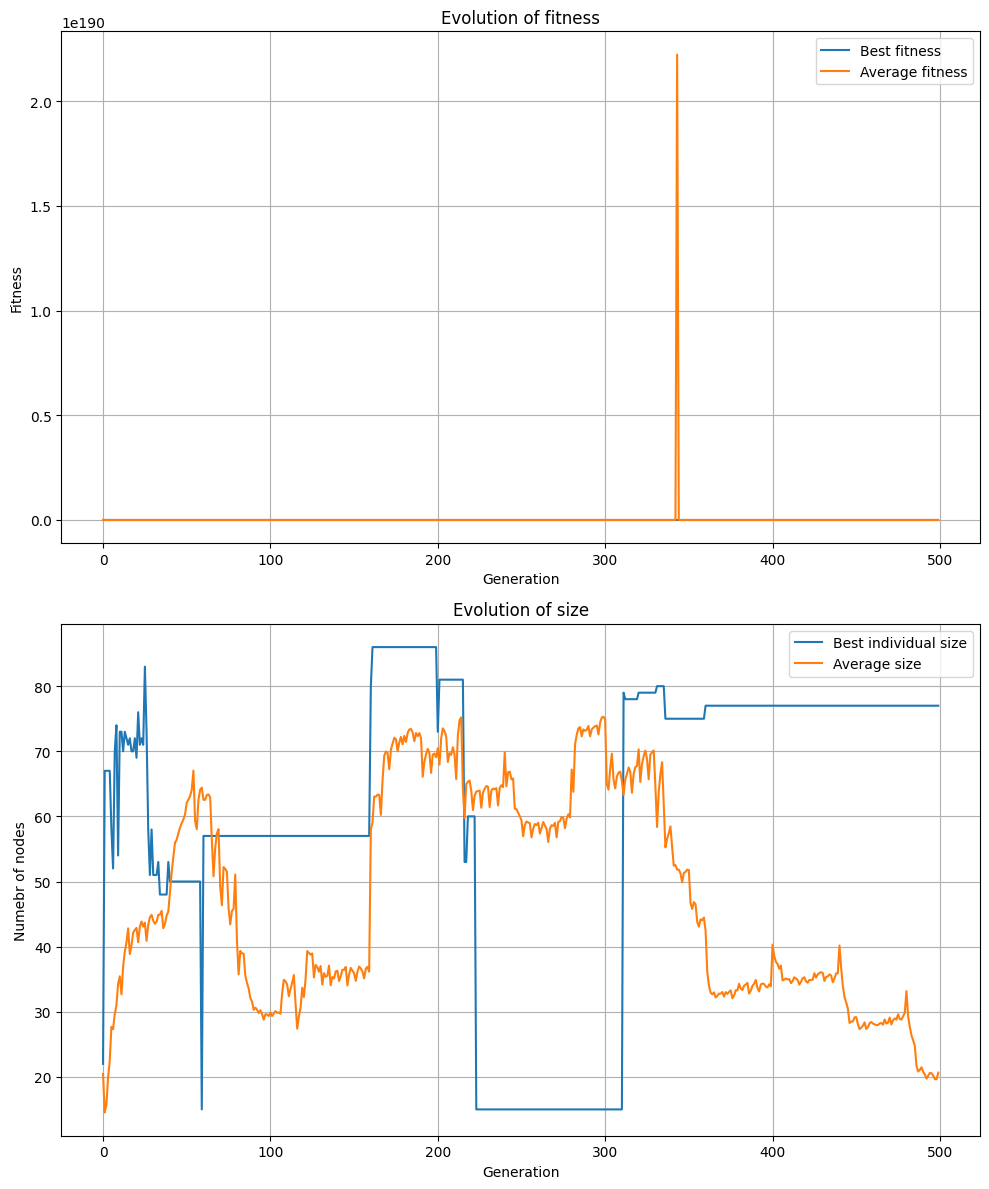

Original expression: (((((((exp((x[1] + x[1])) * (exp(x[0]) - (x[1] + x[0]))) - exp((x[1] + ((x[0] - 3.141592653589793) / 2.251472887460892)))) - exp(((sin(sin(x[0])) + exp((1.0268182704081645 * 2.284898613222542))) + x[0]))) - exp(exp(x[1]))) - exp(exp((1.0268182704081645 * 2.251472887460892)))) + (((((x[1] + ((x[1] + x[0]) - x[0])) * (3.5223357406663833 * x[0])) * (3.361638558889929 * (3.500887027299728 * x[0]))) * x[1]) * (x[1] + (3.5223357406663833 * x[1])))) * ((x[0] * tan(3.141592653589793)) * (2.666851478525177 * x[1])))
Simplified expression: -6.226751041691537e-16*x[0]*x[1]*(374.93213046082964*x[0]**2*x[1]**3 + (-x[0] - x[1] + exp(x[0]))*exp(2*x[1]) - 0.2477463143761617*exp(0.4441536940414833*x[0] + x[1]) - 34390.847090009492*exp(x[0] + sin(sin(x[0]))) - exp(exp(x[1])) - 24175.980509968689)
Best fitness(MSE): 7.074053721003686e-21


In [376]:
print(f"\n=== GP execution on {problems[5]['file_path']} ===")
best_tree = run_gp_on_problem(problems[5]['file_path'],
    problems[5]['config'],
    function_weights=problems[5]['config'].get('function_weights'),
    terminal_weights=problems[5]['config'].get('terminal_weights'),
    use_islands=problems[5].get('use_islands', False),
    n_islands=problems[5].get('n_islands', 5),
    migration_interval=problems[5].get('migration_interval', 10),
    migration_rate=problems[5].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_6.npz ===
Loading data from ../data/problem_6.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples

GP execution on ../data/problem_6.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=10, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 10 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.05 seconds
  Generated  2000 individuals in  0.12 seconds
  Generated  3000 individuals in  0.17 seconds
  Generated  4000 individuals in  0.21 seconds
  Generated  5000 individuals in  0.27 seconds
  Generated  6000 individuals in  1.02 seconds
  Generate

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 10.979539166927182 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 7.581011345294932 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 11.607965822672826 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 11.6525795223407 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 4.93451718573421 | Mutation Strength: 0.90
Bloat control: 391 individuals exceed the maximum size
Bloat control: 255 individuals exceed the maximum size
Bloat control: 330 individuals exceed the maximum size
Bloat control: 265 individuals exceed the maximum size
Bloat control: 197 individuals exceed the maximum size


  0%|          | 1/500 [01:29<12:23:42, 89.42s/it]

New best solution found:
  Expression: (((x[1] * 1.837299311443946) - x[0]) + log(-1.6226422471794368))
  Simplified Expression: (x[1] * 1.837299311443946) - x[0]) + log(-1.6226422471794368
  Fitness: 4.93451718573421
  Complexity: 8 nodes
Generation 0, Best Fitness: 4.93451718573421


  0%|          | 2/500 [02:55<12:03:31, 87.17s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0)) * (-0.6493481392636617 * ((x[1] - ((x[1] - x[0]) * sin(-7.333447994667865))) * sin(-7.333447994667865))))
  Simplified Expression: tan(sqrt(-1.0)) * (-0.6493481392636617 * (x[1] - (x[1] - x[0]) * sin(-7.333447994667865) * sin(-7.333447994667865)))
  Fitness: 0.3128290767902895
  Complexity: 17 nodes


  1%|          | 6/500 [09:10<13:18:21, 96.97s/it]

Generation 5, Best Fitness: 0.3128290767902895


  2%|▏         | 9/500 [13:31<12:16:36, 90.01s/it]

Performing inter-island migration...
  Island 0 diversity: 0.004
  Island 1 diversity: 0.002
  Island 2 diversity: 0.004


  2%|▏         | 10/500 [14:58<12:07:50, 89.12s/it]

  Island 3 diversity: 0.002
  Island 4 diversity: 0.002
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)


  2%|▏         | 11/500 [17:06<13:45:22, 101.27s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0)) * (-0.6493481392636617 * ((x[1] - ((x[1] - x[0]) * sin(-7.333447994667865))) * sin(exp((x[1] + x[1]))))))
  Simplified Expression: tan(sqrt(-1.0)) * (-0.6493481392636617 * (x[1] - (x[1] - x[0]) * sin(-7.333447994667865) * sin(exp(x[1] + x[1]))))
  Fitness: 0.0625658153580579
  Complexity: 20 nodes
Generation 10, Best Fitness: 0.0625658153580579


  3%|▎         | 14/500 [21:25<12:19:48, 91.33s/it] 

New best solution found:
  Expression: (tan(sqrt(-1.0)) * (-0.6493481392636617 * (-5.464097319871185 - (x[0] - log(x[1])))))
  Simplified Expression: tan(sqrt(-1.0)) * (-0.6493481392636617 * (-5.464097319871185 - (x[0] - logx[1])))
  Fitness: 0.03128290767902895
  Complexity: 12 nodes


  3%|▎         | 15/500 [22:51<12:04:53, 89.68s/it]

Bloat control: 1 individuals exceed the maximum size


  3%|▎         | 16/500 [24:58<13:34:40, 100.99s/it]

Generation 15, Best Fitness: 0.03128290767902895


  4%|▍         | 19/500 [29:17<12:12:26, 91.37s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.005
  Island 1 diversity: 0.004
  Island 2 diversity: 0.008
  Island 3 diversity: 0.007


  4%|▍         | 20/500 [30:46<12:05:38, 90.71s/it]

  Island 4 diversity: 0.005
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 1 individuals exceed the maximum size


  4%|▍         | 21/500 [32:43<13:05:40, 98.41s/it]

Generation 20, Best Fitness: 0.03128290767902895


  5%|▌         | 25/500 [38:28<11:47:11, 89.33s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  5%|▌         | 26/500 [40:41<13:30:04, 102.54s/it]

Generation 25, Best Fitness: 0.03128290767902895


  6%|▌         | 29/500 [44:58<11:58:29, 91.53s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.009
  Island 2 diversity: 0.011
  Island 3 diversity: 0.007


  6%|▌         | 30/500 [46:27<11:50:49, 90.74s/it]

  Island 4 diversity: 0.006
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 31/500 [48:21<12:44:16, 97.78s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0058866328361293)) * (-0.6493481392636617 * ((x[1] - exp((sin(-8.841882635760715) * tan(x[1])))) * sin(-7.357642246757946))))
  Simplified Expression: tan(sqrt(-1.058866328361293)) * (-0.6493481392636617 * (x[1] - exp(sin(-8.841882635760715) * tanx[1]) * sin(-7.357642246757946)))
  Fitness: 0.023193072917181094
  Complexity: 17 nodes
Generation 30, Best Fitness: 0.023193072917181094


  7%|▋         | 36/500 [56:07<12:39:11, 98.17s/it]

Generation 35, Best Fitness: 0.023193072917181094


  8%|▊         | 39/500 [1:00:29<11:38:39, 90.93s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.006
  Island 2 diversity: 0.009
  Island 3 diversity: 0.011


  8%|▊         | 40/500 [1:01:59<11:35:55, 90.77s/it]

  Island 4 diversity: 0.010
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 22 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 36 individuals exceed the maximum size
Bloat control: 40 individuals exceed the maximum size


  8%|▊         | 41/500 [1:03:47<12:13:20, 95.86s/it]

New best solution found:
  Expression: (cos(x[1]) / (((x[1] - (cos(exp(x[0])) * (cos(sin(x[0])) * -0.898391654350533))) - x[0]) + (sqrt((3.141592653589793 + ((exp(x[0]) * (x[0] / sin(x[1]))) - sqrt(tan(x[1]))))) / (x[1] / cos(x[1])))))
  Simplified Expression: cos(x[1])/(-x[0] + x[1] + 0.898391654350533*cos(exp(x[0]))*cos(sin(x[0])) + sqrt(x[0]*exp(x[0])/sin(x[1]) - sqrt(tan(x[1])) + 3.141592653589793)*cos(x[1])/x[1])
  Fitness: 0.01454650786479144
  Complexity: 36 nodes
Generation 40, Best Fitness: 0.01454650786479144


  8%|▊         | 42/500 [1:05:14<11:50:49, 93.12s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (log((x[1] / (cos(((cos((x[1] - -1.8923799511965012)) + (-4.589113813737312 / (x[0] * x[0]))) + (x[0] * log(-4.589113813737312)))) * x[0]))) * ((x[1] - ((x[1] - x[0]) * sin(-0.9312858406178953))) * sin((11.466672516469629 + -0.9551976573199005)))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (log(x[1] / (cos(cos(x[1] - -1.8923799511965012) - 4.589113813737312 / (x[0] * x[0]) + (x[0] * log(-4.589113813737312)) * x[0]))) * (x[1] - (x[1] - x[0]) * sin(-0.9312858406178953) * sin(11.466672516469629 + -0.9551976573199005)))
  Fitness: 0.013119726776550544
  Complexity: 39 nodes


  9%|▉         | 45/500 [1:09:35<11:16:31, 89.21s/it]

Bloat control: 3 individuals exceed the maximum size


  9%|▉         | 46/500 [1:11:36<12:27:55, 98.84s/it]

Generation 45, Best Fitness: 0.013119726776550544


 10%|▉         | 49/500 [1:15:58<11:26:19, 91.31s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.008
  Island 2 diversity: 0.008
  Island 3 diversity: 0.017


 10%|█         | 50/500 [1:17:31<11:26:47, 91.57s/it]

  Island 4 diversity: 0.013
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 10%|█         | 51/500 [1:19:37<12:42:42, 101.92s/it]

Generation 50, Best Fitness: 0.013119726776550544


 11%|█         | 55/500 [1:25:30<11:20:25, 91.74s/it] 

Bloat control: 1 individuals exceed the maximum size


 11%|█         | 56/500 [1:27:58<13:22:52, 108.50s/it]

Generation 55, Best Fitness: 0.013119726776550544


 12%|█▏        | 58/500 [1:32:28<14:37:15, 119.08s/it]

New best solution found:
  Expression: (sin((-5.464097319871185 - x[1])) * (-0.6493481392636617 * ((x[1] - ((x[1] - x[0]) * sin(sin((11.466672516469629 + -0.9312858406178953))))) * sin((11.466672516469629 + -0.9312858406178953)))))
  Simplified Expression: -(-0.45427496532894145*x[0] + 1.0360708929213762*x[1])*sin(x[1] + 5.464097319871185)
  Fitness: 0.00963327073159277
  Complexity: 23 nodes


 12%|█▏        | 59/500 [1:34:02<13:40:56, 111.69s/it]

Performing inter-island migration...
  Island 0 diversity: 0.010
  Island 1 diversity: 0.006
  Island 2 diversity: 0.004
  Island 3 diversity: 0.009


 12%|█▏        | 60/500 [1:35:37<13:01:34, 106.58s/it]

  Island 4 diversity: 0.008
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * ((x[1] - ((x[1] - (((x[0] * sin(-4.919512234825146)) * sin(-4.589113813737312)) * sin(-4.919512234825146))) * sin(sin((11.466672516469629 + -0.9312858406178953))))) * sin((11.466672516469629 + sin((11.466672516469629 + -0.9312858406178953)))))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * (x[1] - (x[1] - (x[0] * sin(-4.919512234825146) * sin(-4.589113813737312) * sin(-4.919512234825146) * sin(sin(11.466672516469629 + -0.931285840617895

 12%|█▏        | 61/500 [1:37:35<13:25:27, 110.09s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * ((x[1] - ((x[1] - (((x[0] * sin(-4.919512234825146)) * sin(-4.919512234825146)) * sin(-4.919512234825146))) * sin(sin((11.466672516469629 + -0.9312858406178953))))) * sin((11.466672516469629 + sin((11.466672516469629 + -0.9312858406178953)))))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * (x[1] - (x[1] - (x[0] * sin(-4.919512234825146) * sin(-4.919512234825146) * sin(-4.919512234825146) * sin(sin(11.466672516469629 + -0.9312858406178953)))) * sin(11.466672516469629 + sin(11.466672516469629 + -0.9312858406178953))))
  Fitness: 0.0012855644681276797
  Complexity: 34 nodes
Generation 60, Best Fitness: 0.0012855644681276797


 12%|█▏        | 62/500 [1:39:09<12:48:57, 105.34s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * ((x[1] - ((x[1] - (((x[0] * sin(-4.919512234825146)) * sin(-4.919512234825146)) * sin(-4.919512234825146))) * sin(sin((11.466672516469629 + -0.9312858406178953))))) * sin((11.466672516469629 + sin(11.466672516469629))))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * (x[1] - (x[1] - (x[0] * sin(-4.919512234825146) * sin(-4.919512234825146) * sin(-4.919512234825146) * sin(sin(11.466672516469629 + -0.9312858406178953)))) * sin(11.466672516469629 + sin(11.466672516469629))))
  Fitness: 0.00013015910709232676
  Complexity: 32 nodes


 13%|█▎        | 64/500 [1:42:15<11:59:54, 99.07s/it] 

New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * ((x[1] - ((x[1] - (((x[0] * sin(-4.9243373731493225)) * sin(-4.919512234825146)) * sin(-4.919512234825146))) * sin(sin((11.466672516469629 + -0.9312858406178953))))) * sin((11.466672516469629 + sin(11.466672516469629))))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * (x[1] - (x[1] - (x[0] * sin(-4.9243373731493225) * sin(-4.919512234825146) * sin(-4.919512234825146) * sin(sin(11.466672516469629 + -0.9312858406178953)))) * sin(11.466672516469629 + sin(11.466672516469629))))
  Fitness: 5.0145466189926e-05
  Complexity: 32 nodes


 13%|█▎        | 65/500 [1:43:48<11:45:03, 97.25s/it]

Bloat control: 20 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 13%|█▎        | 66/500 [1:46:45<14:34:51, 120.95s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * ((x[1] - ((x[1] - (((x[0] * sin(-4.9243373731493225)) * sin(-4.919512234825146)) * sin(-4.9243373731493225))) * sin(sin((11.466672516469629 + -0.9312858406178953))))) * sin((11.466672516469629 + sin(11.466672516469629))))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (-0.6493481392636617 * (x[1] - (x[1] - (x[0] * sin(-4.9243373731493225) * sin(-4.919512234825146) * sin(-4.9243373731493225) * sin(sin(11.466672516469629 + -0.9312858406178953)))) * sin(11.466672516469629 + sin(11.466672516469629))))
  Fitness: 3.430645922923297e-05
  Complexity: 32 nodes
Generation 65, Best Fitness: 3.430645922923297e-05


 14%|█▍        | 69/500 [1:51:26<12:21:32, 103.23s/it]

Performing inter-island migration...
  Island 0 diversity: 0.007
  Island 1 diversity: 0.005
  Island 2 diversity: 0.005
  Island 3 diversity: 0.008


 14%|█▍        | 70/500 [1:53:01<12:02:22, 100.80s/it]

  Island 4 diversity: 0.005
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 11 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 14%|█▍        | 71/500 [1:55:56<14:39:30, 123.01s/it]

New best solution found:
  Expression: (tan(sqrt(-1.0268830067559338)) * (0.26623240720729413 * sqrt(sqrt((sqrt((-1.8923799511965012 + -1.6226422471794368)) / x[1])))))
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (0.26623240720729413 * sqrt(sqrt(sqrt(-1.8923799511965012 + -1.6226422471794368) / x[1])))
  Fitness: 3.430645922923297e-06
  Complexity: 14 nodes
Generation 70, Best Fitness: 3.430645922923297e-06


 15%|█▌        | 75/500 [2:02:04<11:43:35, 99.33s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:05:17<15:00:57, 127.49s/it]

Generation 75, Best Fitness: 3.430645922923297e-06


 16%|█▌        | 79/500 [2:09:54<12:14:16, 104.65s/it]

Performing inter-island migration...
  Island 0 diversity: 0.009
  Island 1 diversity: 0.009
  Island 2 diversity: 0.011
  Island 3 diversity: 0.009


 16%|█▌        | 80/500 [2:11:31<11:56:49, 102.40s/it]

  Island 4 diversity: 0.009
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 2 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:14:18<14:12:02, 122.01s/it]

Generation 80, Best Fitness: 3.430645922923297e-06


 17%|█▋        | 85/500 [2:20:22<11:20:28, 98.38s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 17%|█▋        | 86/500 [2:22:59<13:18:45, 115.76s/it]

Generation 85, Best Fitness: 3.430645922923297e-06


 18%|█▊        | 89/500 [2:27:31<11:19:59, 99.27s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.010
  Island 1 diversity: 0.010
  Island 2 diversity: 0.011
  Island 3 diversity: 0.009


 18%|█▊        | 90/500 [2:29:07<11:11:33, 98.28s/it]

  Island 4 diversity: 0.009
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:31:44<13:09:28, 115.82s/it]

Generation 90, Best Fitness: 3.430645922923297e-06


 19%|█▉        | 95/500 [2:37:44<10:48:53, 96.13s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 19%|█▉        | 96/500 [2:40:03<12:13:18, 108.91s/it]

Generation 95, Best Fitness: 3.430645922923297e-06


 20%|█▉        | 99/500 [2:44:30<10:41:02, 95.92s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.013
  Island 1 diversity: 0.015
  Island 2 diversity: 0.013
  Island 3 diversity: 0.016


 20%|██        | 100/500 [2:46:06<10:38:20, 95.75s/it]

  Island 4 diversity: 0.012
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Island 0 | Generation 100 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 6.861291845846594e-06 | Mutation Strength: 2.67
Island 2 | Generation 100 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 2.70
Island 4 | Generation 100 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 2.70
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 20%|██        | 101/500 [2:48:17<11:46:34, 106.25s/it]

Generation 100, Best Fitness: 3.430645922923297e-06


 21%|██        | 105/500 [2:54:13<10:13:16, 93.16s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 21%|██        | 106/500 [2:56:15<11:07:38, 101.67s/it]

Generation 105, Best Fitness: 3.430645922923297e-06


 22%|██▏       | 109/500 [3:00:41<10:07:14, 93.18s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.015
  Island 1 diversity: 0.016
  Island 2 diversity: 0.011
  Island 3 diversity: 0.015


 22%|██▏       | 110/500 [3:02:14<10:05:51, 93.21s/it]

  Island 4 diversity: 0.011
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:04:05<10:39:30, 98.64s/it]

Generation 110, Best Fitness: 3.430645922923297e-06


 23%|██▎       | 115/500 [3:10:01<9:45:45, 91.29s/it] 

Bloat control: 1 individuals exceed the maximum size


 23%|██▎       | 116/500 [3:11:49<10:17:11, 96.44s/it]

Generation 115, Best Fitness: 3.430645922923297e-06


 24%|██▍       | 119/500 [3:16:11<9:33:24, 90.30s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.018
  Island 1 diversity: 0.018
  Island 2 diversity: 0.017
  Island 3 diversity: 0.021


 24%|██▍       | 120/500 [3:17:46<9:41:27, 91.81s/it]

  Island 4 diversity: 0.017
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 4 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:19:30<10:03:21, 95.52s/it]

Generation 120, Best Fitness: 3.430645922923297e-06


 25%|██▌       | 125/500 [3:25:19<9:16:19, 89.01s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 25%|██▌       | 126/500 [3:27:01<9:37:59, 92.73s/it]

Generation 125, Best Fitness: 3.430645922923297e-06


 26%|██▌       | 129/500 [3:31:20<9:06:44, 88.42s/it]

Performing inter-island migration...
  Island 0 diversity: 0.023
  Island 1 diversity: 0.022
  Island 2 diversity: 0.019
  Island 3 diversity: 0.024


 26%|██▌       | 130/500 [3:32:56<9:19:04, 90.66s/it]

  Island 4 diversity: 0.021
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size


 26%|██▌       | 131/500 [3:34:37<9:36:39, 93.77s/it]

Generation 130, Best Fitness: 3.430645922923297e-06


 27%|██▋       | 135/500 [3:40:26<8:59:49, 88.74s/it]

Bloat control: 1 individuals exceed the maximum size


 27%|██▋       | 136/500 [3:42:04<9:16:29, 91.73s/it]

Generation 135, Best Fitness: 3.430645922923297e-06


 28%|██▊       | 139/500 [3:46:25<8:52:18, 88.47s/it]

Performing inter-island migration...
  Island 0 diversity: 0.025
  Island 1 diversity: 0.020
  Island 2 diversity: 0.023
  Island 3 diversity: 0.023


 28%|██▊       | 140/500 [3:48:00<9:02:51, 90.48s/it]

  Island 4 diversity: 0.020
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 28%|██▊       | 141/500 [3:49:41<9:20:02, 93.60s/it]

Generation 140, Best Fitness: 3.430645922923297e-06


 29%|██▉       | 145/500 [3:55:29<8:44:14, 88.61s/it]

Bloat control: 38 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 29%|██▉       | 146/500 [3:57:08<9:01:27, 91.77s/it]

Generation 145, Best Fitness: 3.430645922923297e-06


 30%|██▉       | 149/500 [4:01:28<8:36:42, 88.32s/it]

Performing inter-island migration...
  Island 0 diversity: 0.028
  Island 1 diversity: 0.029
  Island 2 diversity: 0.028
  Island 3 diversity: 0.035


 30%|███       | 150/500 [4:03:03<8:46:45, 90.30s/it]

  Island 4 diversity: 0.029
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 30%|███       | 151/500 [4:04:44<9:04:57, 93.69s/it]

Generation 150, Best Fitness: 3.430645922923297e-06


 31%|███       | 155/500 [4:10:30<8:26:12, 88.04s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 31%|███       | 156/500 [4:12:09<8:43:48, 91.36s/it]

Generation 155, Best Fitness: 3.430645922923297e-06


 32%|███▏      | 159/500 [4:16:27<8:18:50, 87.77s/it]

Performing inter-island migration...
  Island 0 diversity: 0.030
  Island 1 diversity: 0.033
  Island 2 diversity: 0.029
  Island 3 diversity: 0.036


 32%|███▏      | 160/500 [4:18:03<8:31:50, 90.32s/it]

  Island 4 diversity: 0.040
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 32%|███▏      | 161/500 [4:19:43<8:46:28, 93.18s/it]

Generation 160, Best Fitness: 3.430645922923297e-06


 33%|███▎      | 165/500 [4:25:36<8:18:21, 89.26s/it]

Bloat control: 2 individuals exceed the maximum size


 33%|███▎      | 166/500 [4:27:15<8:33:28, 92.24s/it]

Generation 165, Best Fitness: 3.430645922923297e-06


 34%|███▍      | 169/500 [4:31:34<8:07:47, 88.42s/it]

Performing inter-island migration...
  Island 0 diversity: 0.036
  Island 1 diversity: 0.029
  Island 2 diversity: 0.025
  Island 3 diversity: 0.035


 34%|███▍      | 170/500 [4:33:10<8:18:53, 90.71s/it]

  Island 4 diversity: 0.034
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 3 individuals exceed the maximum size


 34%|███▍      | 171/500 [4:34:48<8:29:18, 92.88s/it]

Generation 170, Best Fitness: 3.430645922923297e-06


 35%|███▌      | 175/500 [4:40:38<8:00:26, 88.70s/it]

Bloat control: 1 individuals exceed the maximum size


 35%|███▌      | 176/500 [4:42:17<8:15:48, 91.82s/it]

Generation 175, Best Fitness: 3.430645922923297e-06


 36%|███▌      | 179/500 [4:46:38<7:55:22, 88.85s/it]

Performing inter-island migration...
  Island 0 diversity: 0.039
  Island 1 diversity: 0.038
  Island 2 diversity: 0.030
  Island 3 diversity: 0.040


 36%|███▌      | 180/500 [4:48:21<8:16:38, 93.12s/it]

  Island 4 diversity: 0.035
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 36%|███▌      | 181/500 [4:50:01<8:26:40, 95.30s/it]

Generation 180, Best Fitness: 3.430645922923297e-06


 37%|███▋      | 185/500 [4:56:01<7:59:42, 91.37s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 37%|███▋      | 186/500 [4:57:44<8:15:35, 94.70s/it]

Generation 185, Best Fitness: 3.430645922923297e-06


 38%|███▊      | 189/500 [5:02:16<7:57:36, 92.14s/it]

Performing inter-island migration...
  Island 0 diversity: 0.042
  Island 1 diversity: 0.038
  Island 2 diversity: 0.035
  Island 3 diversity: 0.043


 38%|███▊      | 190/500 [5:03:59<8:13:07, 95.44s/it]

  Island 4 diversity: 0.044
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 38%|███▊      | 191/500 [5:05:37<8:15:29, 96.21s/it]

Generation 190, Best Fitness: 3.430645922923297e-06


 39%|███▉      | 195/500 [5:11:26<7:33:21, 89.19s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 39%|███▉      | 196/500 [5:13:01<7:41:00, 90.99s/it]

Generation 195, Best Fitness: 3.430645922923297e-06


 40%|███▉      | 199/500 [5:17:18<7:19:48, 87.67s/it]

Performing inter-island migration...
  Island 0 diversity: 0.049
  Island 1 diversity: 0.041
  Island 2 diversity: 0.042
  Island 3 diversity: 0.044


 40%|████      | 200/500 [5:18:55<7:31:39, 90.33s/it]

  Island 4 diversity: 0.043
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.02)
Island 0 | Generation 200 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 40%|████      | 201/500 [5:20:30<7:37:37, 91.83s/it]

Generation 200, Best Fitness: 3.430645922923297e-06


 41%|████      | 205/500 [5:26:16<7:11:48, 87.83s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 41%|████      | 206/500 [5:27:51<7:21:07, 90.03s/it]

Generation 205, Best Fitness: 3.430645922923297e-06


 42%|████▏     | 209/500 [5:32:07<7:02:30, 87.11s/it]

Performing inter-island migration...
  Island 0 diversity: 0.048
  Island 1 diversity: 0.041
  Island 2 diversity: 0.046
  Island 3 diversity: 0.044


 42%|████▏     | 210/500 [5:33:43<7:13:57, 89.78s/it]

  Island 4 diversity: 0.043
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 17 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 42%|████▏     | 211/500 [5:35:19<7:21:23, 91.64s/it]

Generation 210, Best Fitness: 3.430645922923297e-06


 43%|████▎     | 215/500 [5:41:05<6:56:17, 87.64s/it]

Bloat control: 21 individuals exceed the maximum size
Bloat control: 35 individuals exceed the maximum size
Bloat control: 44 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size
Bloat control: 24 individuals exceed the maximum size


 43%|████▎     | 216/500 [5:42:40<7:05:29, 89.89s/it]

Generation 215, Best Fitness: 3.430645922923297e-06


 44%|████▍     | 219/500 [5:46:55<6:46:03, 86.70s/it]

Performing inter-island migration...
  Island 0 diversity: 0.046
  Island 1 diversity: 0.046
  Island 2 diversity: 0.048
  Island 3 diversity: 0.046


 44%|████▍     | 220/500 [5:48:31<6:57:11, 89.40s/it]

  Island 4 diversity: 0.047
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 9 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 50 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 44%|████▍     | 221/500 [5:50:04<7:01:19, 90.61s/it]

Generation 220, Best Fitness: 3.430645922923297e-06


 45%|████▌     | 225/500 [5:55:47<6:37:23, 86.70s/it]

Bloat control: 14 individuals exceed the maximum size
Bloat control: 38 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 45%|████▌     | 226/500 [5:57:20<6:44:58, 88.68s/it]

Generation 225, Best Fitness: 3.430645922923297e-06


 46%|████▌     | 229/500 [6:01:35<6:29:39, 86.27s/it]

Performing inter-island migration...
  Island 0 diversity: 0.053
  Island 1 diversity: 0.051
  Island 2 diversity: 0.042
  Island 3 diversity: 0.051


 46%|████▌     | 230/500 [6:03:10<6:40:43, 89.05s/it]

  Island 4 diversity: 0.048
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 13 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 46%|████▌     | 231/500 [6:04:45<6:47:21, 90.86s/it]

Generation 230, Best Fitness: 3.430645922923297e-06


 47%|████▋     | 235/500 [6:10:30<6:26:27, 87.50s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size


 47%|████▋     | 236/500 [6:12:04<6:33:13, 89.37s/it]

Generation 235, Best Fitness: 3.430645922923297e-06


 48%|████▊     | 239/500 [6:16:18<6:15:21, 86.29s/it]

Performing inter-island migration...
  Island 0 diversity: 0.050
  Island 1 diversity: 0.048
  Island 2 diversity: 0.042
  Island 3 diversity: 0.051


 48%|████▊     | 240/500 [6:17:52<6:24:08, 88.65s/it]

  Island 4 diversity: 0.049
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 48%|████▊     | 241/500 [6:19:27<6:30:47, 90.53s/it]

Generation 240, Best Fitness: 3.430645922923297e-06


 49%|████▉     | 245/500 [6:25:07<6:07:01, 86.36s/it]

Bloat control: 1 individuals exceed the maximum size


 49%|████▉     | 246/500 [6:26:41<6:15:40, 88.74s/it]

Generation 245, Best Fitness: 3.430645922923297e-06


 50%|████▉     | 249/500 [6:30:55<6:00:07, 86.09s/it]

Performing inter-island migration...
  Island 0 diversity: 0.049
  Island 1 diversity: 0.044
  Island 2 diversity: 0.046
  Island 3 diversity: 0.051


 50%|█████     | 250/500 [6:32:30<6:09:22, 88.65s/it]

  Island 4 diversity: 0.050
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 50%|█████     | 251/500 [6:34:04<6:14:57, 90.35s/it]

Generation 250, Best Fitness: 3.430645922923297e-06


 51%|█████     | 255/500 [6:39:49<5:55:04, 86.96s/it]

Bloat control: 1 individuals exceed the maximum size


 51%|█████     | 256/500 [6:41:22<6:01:30, 88.89s/it]

Generation 255, Best Fitness: 3.430645922923297e-06


 52%|█████▏    | 259/500 [6:45:38<5:47:29, 86.51s/it]

Performing inter-island migration...
  Island 0 diversity: 0.051
  Island 1 diversity: 0.049
  Island 2 diversity: 0.045
  Island 3 diversity: 0.049
  Island 4 diversity: 0.046
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)


 52%|█████▏    | 260/500 [6:47:12<5:54:50, 88.71s/it]

  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 52%|█████▏    | 261/500 [6:48:46<5:59:55, 90.36s/it]

Generation 260, Best Fitness: 3.430645922923297e-06


 53%|█████▎    | 265/500 [6:54:23<5:35:06, 85.56s/it]

Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 53%|█████▎    | 266/500 [6:55:57<5:44:00, 88.21s/it]

Generation 265, Best Fitness: 3.430645922923297e-06


 54%|█████▍    | 269/500 [7:00:13<5:31:53, 86.21s/it]

Performing inter-island migration...
  Island 0 diversity: 0.050
  Island 1 diversity: 0.045
  Island 2 diversity: 0.044
  Island 3 diversity: 0.048


 54%|█████▍    | 270/500 [7:01:47<5:39:39, 88.61s/it]

  Island 4 diversity: 0.048
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 54%|█████▍    | 271/500 [7:03:21<5:44:32, 90.27s/it]

Generation 270, Best Fitness: 3.430645922923297e-06


 55%|█████▌    | 275/500 [7:09:14<5:31:53, 88.51s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 55%|█████▌    | 276/500 [7:10:49<5:37:51, 90.50s/it]

Generation 275, Best Fitness: 3.430645922923297e-06


 56%|█████▌    | 279/500 [7:15:06<5:21:22, 87.25s/it]

Performing inter-island migration...
  Island 0 diversity: 0.053
  Island 1 diversity: 0.043
  Island 2 diversity: 0.048
  Island 3 diversity: 0.050


 56%|█████▌    | 280/500 [7:16:41<5:28:43, 89.65s/it]

  Island 4 diversity: 0.048
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 56%|█████▌    | 281/500 [7:18:16<5:33:23, 91.34s/it]

Generation 280, Best Fitness: 3.430645922923297e-06


 57%|█████▋    | 285/500 [7:23:58<5:11:43, 86.99s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size


 57%|█████▋    | 286/500 [7:25:34<5:19:28, 89.57s/it]

Generation 285, Best Fitness: 3.430645922923297e-06


 58%|█████▊    | 289/500 [7:29:49<5:04:34, 86.61s/it]

Performing inter-island migration...
  Island 0 diversity: 0.046
  Island 1 diversity: 0.043
  Island 2 diversity: 0.049
  Island 3 diversity: 0.050


 58%|█████▊    | 290/500 [7:31:23<5:11:11, 88.91s/it]

  Island 4 diversity: 0.044
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 19 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 58%|█████▊    | 291/500 [7:33:00<5:17:41, 91.20s/it]

Generation 290, Best Fitness: 3.430645922923297e-06


 59%|█████▉    | 295/500 [7:38:43<4:57:28, 87.07s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 59%|█████▉    | 296/500 [7:40:18<5:04:32, 89.57s/it]

Generation 295, Best Fitness: 3.430645922923297e-06


 60%|█████▉    | 299/500 [7:44:34<4:50:41, 86.77s/it]

Performing inter-island migration...
  Island 0 diversity: 0.051
  Island 1 diversity: 0.048
  Island 2 diversity: 0.047
  Island 3 diversity: 0.045


 60%|██████    | 300/500 [7:46:10<4:58:36, 89.58s/it]

  Island 4 diversity: 0.049
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Island 0 | Generation 300 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2

 60%|██████    | 301/500 [7:47:46<5:03:30, 91.51s/it]

Generation 300, Best Fitness: 3.430645922923297e-06


 61%|██████    | 305/500 [7:53:29<4:42:41, 86.98s/it]

Bloat control: 14 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 61%|██████    | 306/500 [7:55:04<4:49:23, 89.50s/it]

Generation 305, Best Fitness: 3.430645922923297e-06


 62%|██████▏   | 309/500 [7:59:20<4:36:02, 86.72s/it]

Performing inter-island migration...
  Island 0 diversity: 0.046
  Island 1 diversity: 0.043
  Island 2 diversity: 0.045
  Island 3 diversity: 0.046


 62%|██████▏   | 310/500 [8:00:55<4:42:26, 89.19s/it]

  Island 4 diversity: 0.051
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 14 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 20 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size


 62%|██████▏   | 311/500 [8:02:31<4:47:00, 91.11s/it]

Generation 310, Best Fitness: 3.430645922923297e-06


 63%|██████▎   | 315/500 [8:08:14<4:29:09, 87.30s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 63%|██████▎   | 316/500 [8:09:51<4:36:03, 90.02s/it]

Generation 315, Best Fitness: 3.430645922923297e-06


 64%|██████▍   | 319/500 [8:14:08<4:23:04, 87.21s/it]

Performing inter-island migration...
  Island 0 diversity: 0.051
  Island 1 diversity: 0.045
  Island 2 diversity: 0.050
  Island 3 diversity: 0.048


 64%|██████▍   | 320/500 [8:15:43<4:28:27, 89.48s/it]

  Island 4 diversity: 0.051
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 64%|██████▍   | 321/500 [8:17:21<4:34:03, 91.86s/it]

Generation 320, Best Fitness: 3.430645922923297e-06


 65%|██████▌   | 325/500 [8:23:02<4:13:36, 86.95s/it]

Bloat control: 4 individuals exceed the maximum size


 65%|██████▌   | 326/500 [8:24:38<4:19:34, 89.51s/it]

Generation 325, Best Fitness: 3.430645922923297e-06


 66%|██████▌   | 329/500 [8:28:55<4:08:11, 87.08s/it]

Performing inter-island migration...
  Island 0 diversity: 0.050
  Island 1 diversity: 0.049
  Island 2 diversity: 0.045
  Island 3 diversity: 0.045


 66%|██████▌   | 330/500 [8:30:30<4:12:51, 89.24s/it]

  Island 4 diversity: 0.051
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 66%|██████▌   | 331/500 [8:32:05<4:16:25, 91.04s/it]

Generation 330, Best Fitness: 3.430645922923297e-06


 67%|██████▋   | 335/500 [8:37:47<3:58:58, 86.90s/it]

Bloat control: 5 individuals exceed the maximum size


 67%|██████▋   | 336/500 [8:39:24<4:05:13, 89.72s/it]

Generation 335, Best Fitness: 3.430645922923297e-06


 68%|██████▊   | 339/500 [8:43:41<3:54:00, 87.21s/it]

Performing inter-island migration...
  Island 0 diversity: 0.051
  Island 1 diversity: 0.046
  Island 2 diversity: 0.046
  Island 3 diversity: 0.044


 68%|██████▊   | 340/500 [8:45:18<4:00:20, 90.13s/it]

  Island 4 diversity: 0.049
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 68%|██████▊   | 341/500 [8:46:53<4:02:41, 91.58s/it]

Generation 340, Best Fitness: 3.430645922923297e-06


 69%|██████▉   | 345/500 [8:52:37<3:45:15, 87.20s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 69%|██████▉   | 346/500 [8:54:13<3:50:25, 89.78s/it]

Generation 345, Best Fitness: 3.430645922923297e-06


 70%|██████▉   | 349/500 [8:58:31<3:39:33, 87.24s/it]

Performing inter-island migration...
  Island 0 diversity: 0.048
  Island 1 diversity: 0.042
  Island 2 diversity: 0.045
  Island 3 diversity: 0.050


 70%|███████   | 350/500 [9:00:06<3:44:23, 89.76s/it]

  Island 4 diversity: 0.050
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 70%|███████   | 351/500 [9:01:42<3:47:27, 91.59s/it]

Generation 350, Best Fitness: 3.430645922923297e-06


 71%|███████   | 355/500 [9:07:25<3:30:29, 87.10s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size


 71%|███████   | 356/500 [9:09:02<3:36:04, 90.03s/it]

Generation 355, Best Fitness: 3.430645922923297e-06


 72%|███████▏  | 359/500 [9:13:20<3:25:05, 87.28s/it]

Performing inter-island migration...
  Island 0 diversity: 0.044
  Island 1 diversity: 0.044
  Island 2 diversity: 0.045
  Island 3 diversity: 0.045


 72%|███████▏  | 360/500 [9:14:54<3:28:47, 89.48s/it]

  Island 4 diversity: 0.046
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size


 72%|███████▏  | 361/500 [9:16:32<3:32:57, 91.93s/it]

Generation 360, Best Fitness: 3.430645922923297e-06


 73%|███████▎  | 365/500 [9:22:15<3:16:09, 87.18s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size


 73%|███████▎  | 366/500 [9:23:52<3:21:14, 90.11s/it]

Generation 365, Best Fitness: 3.430645922923297e-06


 74%|███████▍  | 369/500 [9:28:14<3:12:17, 88.07s/it]

Performing inter-island migration...
  Island 0 diversity: 0.049
  Island 1 diversity: 0.049
  Island 2 diversity: 0.050
  Island 3 diversity: 0.048


 74%|███████▍  | 370/500 [9:29:49<3:15:52, 90.40s/it]

  Island 4 diversity: 0.052
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 9 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 74%|███████▍  | 371/500 [9:31:25<3:17:38, 91.93s/it]

Generation 370, Best Fitness: 3.430645922923297e-06


 75%|███████▌  | 375/500 [9:37:10<3:02:20, 87.53s/it]

Bloat control: 15 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 75%|███████▌  | 376/500 [9:38:46<3:05:55, 89.97s/it]

Generation 375, Best Fitness: 3.430645922923297e-06


 76%|███████▌  | 379/500 [9:43:08<2:57:11, 87.86s/it]

Performing inter-island migration...
  Island 0 diversity: 0.049
  Island 1 diversity: 0.045
  Island 2 diversity: 0.048
  Island 3 diversity: 0.050


 76%|███████▌  | 380/500 [9:44:43<3:00:01, 90.01s/it]

  Island 4 diversity: 0.049
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 12 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 76%|███████▌  | 381/500 [9:46:20<3:02:28, 92.01s/it]

Generation 380, Best Fitness: 3.430645922923297e-06


 77%|███████▋  | 385/500 [9:52:02<2:46:59, 87.12s/it]

Bloat control: 11 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 77%|███████▋  | 386/500 [9:53:39<2:50:50, 89.92s/it]

Generation 385, Best Fitness: 3.430645922923297e-06


 78%|███████▊  | 389/500 [9:57:56<2:41:02, 87.05s/it]

Performing inter-island migration...
  Island 0 diversity: 0.046
  Island 1 diversity: 0.045
  Island 2 diversity: 0.045
  Island 3 diversity: 0.048


 78%|███████▊  | 390/500 [9:59:31<2:44:05, 89.50s/it]

  Island 4 diversity: 0.049
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 9 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 78%|███████▊  | 391/500 [10:01:06<2:45:46, 91.26s/it]

Generation 390, Best Fitness: 3.430645922923297e-06


 79%|███████▉  | 395/500 [10:06:48<2:32:10, 86.96s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 79%|███████▉  | 396/500 [10:08:25<2:35:33, 89.74s/it]

Generation 395, Best Fitness: 3.430645922923297e-06


 80%|███████▉  | 399/500 [10:12:43<2:26:55, 87.28s/it]

Performing inter-island migration...
  Island 0 diversity: 0.048
  Island 1 diversity: 0.051
  Island 2 diversity: 0.049
  Island 3 diversity: 0.051


 80%|████████  | 400/500 [10:14:17<2:29:06, 89.46s/it]

  Island 4 diversity: 0.057
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 3.430645922923297e-06 | Mutation Strength: 3.00
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 80%|████████  | 401/500 [10:15:54<2:31:15, 91.67s/it]

Generation 400, Best Fitness: 3.430645922923297e-06


 81%|████████  | 405/500 [10:21:38<2:18:05, 87.22s/it]

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 81%|████████  | 406/500 [10:23:13<2:20:11, 89.49s/it]

Generation 405, Best Fitness: 3.430645922923297e-06


 82%|████████▏ | 409/500 [10:27:31<2:12:10, 87.15s/it]

Performing inter-island migration...
  Island 0 diversity: 0.043
  Island 1 diversity: 0.045
  Island 2 diversity: 0.046
  Island 3 diversity: 0.050


 82%|████████▏ | 410/500 [10:29:05<2:14:04, 89.39s/it]

  Island 4 diversity: 0.051
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 8 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 82%|████████▏ | 411/500 [10:30:40<2:15:04, 91.06s/it]

Generation 410, Best Fitness: 3.430645922923297e-06


 83%|████████▎ | 415/500 [10:36:23<2:03:06, 86.90s/it]

Bloat control: 9 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


 83%|████████▎ | 416/500 [10:37:57<2:04:59, 89.28s/it]

Generation 415, Best Fitness: 3.430645922923297e-06


 84%|████████▍ | 419/500 [10:42:22<2:00:00, 88.90s/it]

Performing inter-island migration...
  Island 0 diversity: 0.049
  Island 1 diversity: 0.049
  Island 2 diversity: 0.045
  Island 3 diversity: 0.044


 84%|████████▍ | 420/500 [10:44:09<2:06:07, 94.60s/it]

  Island 4 diversity: 0.048
  Migration: 200 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 14 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 84%|████████▍ | 421/500 [10:46:00<2:10:49, 99.36s/it]

Generation 420, Best Fitness: 3.430645922923297e-06


 85%|████████▌ | 425/500 [10:51:53<1:53:15, 90.60s/it]

Bloat control: 12 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 85%|████████▌ | 426/500 [10:53:32<1:54:50, 93.12s/it]

Generation 425, Best Fitness: 3.430645922923297e-06


 86%|████████▌ | 429/500 [10:57:57<1:46:10, 89.72s/it]

Performing inter-island migration...
  Island 0 diversity: 0.052
  Island 1 diversity: 0.049
  Island 2 diversity: 0.047
  Island 3 diversity: 0.045


 86%|████████▌ | 430/500 [10:59:33<1:47:09, 91.85s/it]

  Island 4 diversity: 0.048
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 86%|████████▌ | 431/500 [11:01:09<1:46:58, 93.02s/it]

Generation 430, Best Fitness: 3.430645922923297e-06


 87%|████████▋ | 435/500 [11:06:53<1:34:58, 87.67s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 87%|████████▋ | 436/500 [11:08:31<1:36:48, 90.76s/it]

Generation 435, Best Fitness: 3.430645922923297e-06


 88%|████████▊ | 439/500 [11:12:50<1:29:11, 87.73s/it]

Performing inter-island migration...
  Island 0 diversity: 0.048
  Island 1 diversity: 0.045
  Island 2 diversity: 0.050
  Island 3 diversity: 0.046


 88%|████████▊ | 440/500 [11:14:24<1:29:45, 89.76s/it]

  Island 4 diversity: 0.042
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.02)
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 88%|████████▊ | 441/500 [11:16:00<1:30:05, 91.61s/it]

Generation 440, Best Fitness: 3.430645922923297e-06


 89%|████████▉ | 445/500 [11:21:46<1:20:10, 87.46s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 89%|████████▉ | 446/500 [11:23:22<1:21:04, 90.08s/it]

Generation 445, Best Fitness: 3.430645922923297e-06


 90%|████████▉ | 449/500 [11:27:42<1:14:47, 87.99s/it]

Performing inter-island migration...
  Island 0 diversity: 0.046
  Island 1 diversity: 0.043
  Island 2 diversity: 0.045
  Island 3 diversity: 0.048


 90%|█████████ | 450/500 [11:30:19<1:30:38, 108.76s/it]

  Island 4 diversity: 0.051
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 90%|█████████ | 451/500 [11:33:05<1:42:39, 125.70s/it]

Generation 450, Best Fitness: 3.430645922923297e-06


 91%|█████████ | 455/500 [11:42:23<1:40:43, 134.30s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 456/500 [11:44:50<1:41:12, 138.01s/it]

Generation 455, Best Fitness: 3.430645922923297e-06


 92%|█████████▏| 459/500 [11:51:43<1:35:09, 139.26s/it]

Performing inter-island migration...
  Island 0 diversity: 0.051
  Island 1 diversity: 0.049
  Island 2 diversity: 0.051
  Island 3 diversity: 0.044


 92%|█████████▏| 460/500 [11:53:24<1:25:05, 127.64s/it]

  Island 4 diversity: 0.047
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size


 92%|█████████▏| 461/500 [11:55:22<1:21:13, 124.96s/it]

Generation 460, Best Fitness: 3.430645922923297e-06


 93%|█████████▎| 466/500 [12:04:36<1:05:23, 115.39s/it]

Generation 465, Best Fitness: 3.430645922923297e-06


 94%|█████████▍| 469/500 [12:09:10<51:57, 100.55s/it]  

Performing inter-island migration...
  Island 0 diversity: 0.051
  Island 1 diversity: 0.045
  Island 2 diversity: 0.049
  Island 3 diversity: 0.048
  Island 4 diversity: 0.049
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)


 94%|█████████▍| 470/500 [12:11:48<58:46, 117.53s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


 94%|█████████▍| 471/500 [12:14:40<1:04:42, 133.87s/it]

Generation 470, Best Fitness: 3.430645922923297e-06


 95%|█████████▌| 476/500 [12:26:15<58:16, 145.69s/it]  

Generation 475, Best Fitness: 3.430645922923297e-06


 96%|█████████▌| 479/500 [12:31:53<42:08, 120.41s/it]

Performing inter-island migration...
  Island 0 diversity: 0.052
  Island 1 diversity: 0.045
  Island 2 diversity: 0.043
  Island 3 diversity: 0.051


 96%|█████████▌| 480/500 [12:33:35<38:17, 114.89s/it]

  Island 4 diversity: 0.051
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 96%|█████████▌| 481/500 [12:35:10<34:28, 108.87s/it]

Generation 480, Best Fitness: 3.430645922923297e-06


 97%|█████████▋| 485/500 [12:40:39<22:02, 88.13s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 97%|█████████▋| 486/500 [12:42:10<20:43, 88.85s/it]

Generation 485, Best Fitness: 3.430645922923297e-06


 98%|█████████▊| 489/500 [12:46:12<15:18, 83.50s/it]

Performing inter-island migration...
  Island 0 diversity: 0.049
  Island 1 diversity: 0.043
  Island 2 diversity: 0.046
  Island 3 diversity: 0.044


 98%|█████████▊| 490/500 [12:47:42<14:12, 85.23s/it]

  Island 4 diversity: 0.044
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2 individuals exceed the maximum size


 98%|█████████▊| 491/500 [12:49:12<12:59, 86.65s/it]

Generation 490, Best Fitness: 3.430645922923297e-06


 99%|█████████▉| 495/500 [12:54:46<07:03, 84.62s/it]

Bloat control: 1 individuals exceed the maximum size


 99%|█████████▉| 496/500 [12:56:22<05:53, 88.28s/it]

Generation 495, Best Fitness: 3.430645922923297e-06


100%|█████████▉| 499/500 [13:00:31<01:24, 84.91s/it]

Performing inter-island migration...
  Island 0 diversity: 0.048
  Island 1 diversity: 0.046
  Island 2 diversity: 0.048
  Island 3 diversity: 0.052


100%|██████████| 500/500 [13:02:05<00:00, 93.85s/it]

  Island 4 diversity: 0.044
  Migration: 200 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 200 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 200 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 200 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 200 individuals from island 4 to island 0(mutation strength: 1.01)
Generation 499, Best Fitness: 3.430645922923297e-06
Algorithm completed in 47331.79 seconds
Best solution found:
  Simplified Expression: tan(sqrt(-1.0268830067559338)) * (0.26623240720729413 * sqrt(sqrt(sqrt(-1.8923799511965012 + -1.6226422471794368) / x[1])))
  Expression: (tan(sqrt(-1.0268830067559338)) * (0.26623240720729413 * sqrt(sqrt((sqrt((-1.8923799511965012 + -1.6226422471794368)) / x[1])))))
  Fitness: 3.430645922923297e-06
  Complexity: 14 nodes


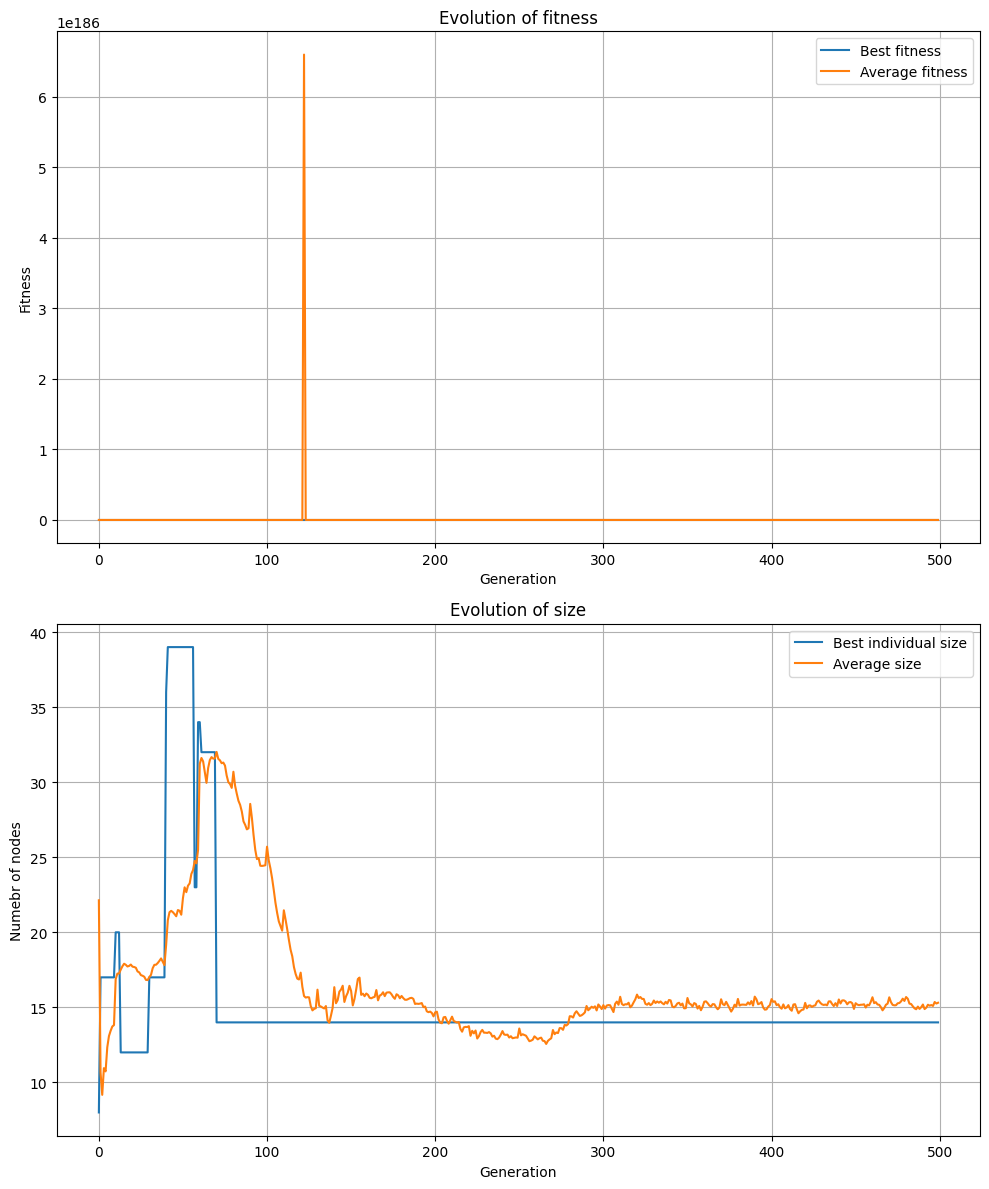

Original expression: (tan(sqrt(-1.0268830067559338)) * (0.26623240720729413 * sqrt(sqrt((sqrt((-1.8923799511965012 + -1.6226422471794368)) / x[1])))))
Simplified expression: tan(sqrt(-1.0268830067559338)) * (0.26623240720729413 * sqrt(sqrt(sqrt(-1.8923799511965012 + -1.6226422471794368) / x[1])))
Best fitness(MSE): 3.430645922923297e-06


In [377]:
print(f"\n=== GP execution on {problems[6]['file_path']} ===")
best_tree = run_gp_on_problem(problems[6]['file_path'],
    problems[6]['config'],
    function_weights=problems[6]['config'].get('function_weights'),
    terminal_weights=problems[6]['config'].get('terminal_weights'),
    use_islands=problems[6].get('use_islands', False),
    n_islands=problems[6].get('n_islands', 5),
    migration_interval=problems[6].get('migration_interval', 10),
    migration_rate=problems[6].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_7.npz ===
Loading data from ../data/problem_7.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (5000, 2), y shape (5000,)
Input 2-dimensional with 5000 samples

GP execution on ../data/problem_7.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.03 seconds
  Generated  2000 individuals in  0.05 seconds
  Generated  3000 individuals in  0.08 seconds
  Generated  4000 individuals in  0.11 seconds
  Generated  5000 individuals in  0.14 seconds
  Generated  6000 individuals in  0.17 seconds
  Generated

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 712.7928537242601 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 667.945541300696 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 625.9269517914341 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 704.215897946907 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 712.1912269209107 | Mutation Strength: 0.90
Bloat control: 100 individuals exceed the maximum size
Bloat control: 158 individuals exceed the maximum size
Bloat control: 137 individuals exceed the maximum size
Bloat control: 141 individuals exceed the maximum size
Bloat control: 139 individuals exceed the maximum size


  0%|          | 1/500 [01:33<12:57:43, 93.51s/it]

New best solution found:
  Expression: exp((x[0] * x[1]))
  Simplified Expression: exp(x[0]*x[1])
  Fitness: 625.9269517914341
  Complexity: 4 nodes
Generation 0, Best Fitness: 625.9269517914341


  0%|          | 2/500 [03:05<12:47:11, 92.43s/it]

New best solution found:
  Expression: sqrt(((exp((x[0] * x[1])) - 1.0) * (x[1] + -139.2438381907603)))
  Simplified Expression: sqrt((x[1] - 139.2438381907603)*(exp(x[0]*x[1]) - 1.0))
  Fitness: 450.85519716088976
  Complexity: 11 nodes


  1%|          | 5/500 [08:00<13:30:46, 98.28s/it]

Bloat control: 10 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


  1%|          | 6/500 [09:49<14:00:10, 102.05s/it]

Generation 5, Best Fitness: 450.85519716088976


  2%|▏         | 10/500 [18:37<17:47:05, 130.66s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  2%|▏         | 11/500 [22:12<21:15:19, 156.48s/it]

Generation 10, Best Fitness: 450.85519716088976


  2%|▏         | 12/500 [24:36<20:41:35, 152.65s/it]

New best solution found:
  Expression: sqrt(((x[0] * tan((exp((cos(1.0) + (x[0] - x[1]))) + (((x[0] + x[1]) / x[1]) + (x[1] / x[0]))))) * ((x[0] + x[1]) * ((x[0] * x[1]) * 129.00904822908495))))


  3%|▎         | 13/500 [27:29<21:29:30, 158.87s/it]

  Simplified Expression: 11.358215010690938*sqrt(x[1]*(x[0] + x[1])*tan(1.7165256995489*exp(x[0] - x[1]) + (x[0] + x[1])/x[1] + x[1]/x[0]))*Abs(x[0])
  Fitness: 404.2593183286398
  Complexity: 31 nodes


  3%|▎         | 15/500 [32:16<20:16:07, 150.45s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  3%|▎         | 16/500 [34:47<20:13:12, 150.40s/it]

Generation 15, Best Fitness: 404.2593183286398


  4%|▍         | 20/500 [45:30<21:31:54, 161.49s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


  4%|▍         | 21/500 [49:06<23:38:30, 177.68s/it]

New best solution found:
  Expression: (((x[0] + x[1]) * ((x[0] + x[1]) + x[1])) * (sqrt(2.718281828459045) - log(((x[1] - x[0]) / tan((((x[1] - x[0]) - sqrt(x[0])) - cos(2.718281828459045)))))))
  Simplified Expression: (1.648721270700128 - log(-(-x[0] + x[1])/tan(sqrt(x[0]) + x[0] - x[1] - 0.911733914786965)))*(x[0] + x[1])*(x[0] + 2*x[1])
  Fitness: 402.8729445996064
  Complexity: 28 nodes
Generation 20, Best Fitness: 402.8729445996064


  4%|▍         | 22/500 [50:55<20:52:25, 157.21s/it]

New best solution found:
  Expression: (((x[0] + x[1]) * ((x[0] + x[1]) + x[1])) * ((((-421.8155952348868 * log((x[0] - x[0]))) + x[1]) + ((cos(tan(x[1])) - 0.0) - (log(cos((x[0] + x[1]))) * x[1]))) - log(((x[1] - x[0]) / tan((((x[1] - x[0]) - sqrt(x[0])) - cos(sqrt(x[1]))))))))
  Simplified Expression: x[0] + x[1]) * (x[0] + x[1]) + x[1]) * (-421.8155952348868 * log(0.0) + x[1]) + (cos(tanx[1] - (log(cos(x[0] + x[1]) * x[1]) - log(x[1] - x[0]) / tan(x[1] - x[0]) - sqrtx[0] - cos(sqrtx[1]))
  Fitness: 347.45354834639437
  Complexity: 49 nodes


  5%|▌         | 25/500 [55:47<15:35:13, 118.13s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


  5%|▌         | 26/500 [58:15<16:44:07, 127.10s/it]

Generation 25, Best Fitness: 347.45354834639437


  6%|▌         | 30/500 [1:04:29<13:13:17, 101.27s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  6%|▌         | 31/500 [1:06:46<14:35:05, 111.95s/it]

New best solution found:
  Expression: (sin((cos((((x[1] / x[0]) * x[1]) - x[1])) * -29.524635685655994)) * exp(((x[1] * x[0]) + (cos((x[0] - x[1])) * (cos((x[0] - x[1])) * (cos((x[0] - x[1])) + cos((x[0] - x[1]))))))))
  Simplified Expression: -exp(x[0]*x[1] + 2*cos(x[0] - x[1])**3)*sin(29.524635685655994*cos(x[1] - x[1]**2/x[0]))
  Fitness: 327.4892987604873
  Complexity: 36 nodes
Generation 30, Best Fitness: 327.4892987604873


  7%|▋         | 34/500 [1:11:27<12:57:56, 100.16s/it]

New best solution found:
  Expression: sqrt(((exp((x[0] * x[1])) - sin((((x[1] * -29.524635685655994) / x[1]) / -271.29693729054907))) * (sqrt(((exp((x[0] * x[1])) - (-29.524635685655994 + log(-333.23318664604744))) * (log((x[1] - x[0])) * (-126.41332665627418 * (x[1] * x[0]))))) * ((log((x[1] - x[0])) * cos(log(x[0]))) * log((x[1] - x[0]))))))
  Simplified Expression: sqrt(exp(x[0] * x[1]) - sin(x[1] * -29.524635685655994) / x[1]) / -271.29693729054907) * (sqrt(exp(x[0] * x[1]) + 29.524635685655994 + log(-333.23318664604744) * (log(x[1] - x[0]) * (-126.41332665627418 * (x[1] * x[0]) * (log(x[1] - x[0]) * cos(logx[0]) * log(x[1] - x[0])))))
  Fitness: 296.7603513956559
  Complexity: 50 nodes


  7%|▋         | 35/500 [1:13:00<12:39:44, 98.03s/it] 

New best solution found:
  Expression: sqrt(((exp((x[0] * x[1])) - sin((((x[1] * -29.524635685655994) / x[1]) / -271.29693729054907))) * (sqrt(((x[1] - ((x[0] * -29.524635685655994) + log(x[0]))) * (log((x[1] - x[0])) * (-126.41332665627418 * (x[1] * x[0]))))) * ((log((x[1] - x[0])) * cos(-126.41332665627418)) * log((x[1] - x[0]))))))
  Simplified Expression: 2.8687201096529468*sqrt(sqrt(-x[0]*x[1]*(29.524635685655994*x[0] + x[1] - log(x[0]))*log(-x[0] + x[1]))*(exp(x[0]*x[1]) - 0.10861306217440644)*log(-x[0] + x[1])**2)
  Fitness: 290.3815629768019
  Complexity: 48 nodes
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1997 individuals exceed the maximum size


  7%|▋         | 36/500 [1:15:41<15:03:29, 116.83s/it]

New best solution found:
  Expression: sqrt(((exp((x[0] * x[1])) - sin((((x[1] * -29.524635685655994) / x[1]) / -271.29693729054907))) * (sqrt((((x[1] - x[0]) - ((x[0] * -29.524635685655994) + log(x[0]))) * (log((x[1] - x[0])) * (-126.41332665627418 * (x[1] * x[0]))))) * ((log((x[1] - x[0])) * cos(log(-271.29693729054907))) * log((x[1] - x[0]))))))
  Simplified Expression: sqrt(exp(x[0] * x[1]) - sin(x[1] * -29.524635685655994) / x[1]) / -271.29693729054907) * (sqrt(x[1] - x[0]) - (x[0] * -29.524635685655994) + logx[0] * (log(x[1] - x[0]) * (-126.41332665627418 * (x[1] * x[0]) * (log(x[1] - x[0]) * cos(log(-271.29693729054907) * log(x[1] - x[0])))))
  Fitness: 279.60539771021024
  Complexity: 51 nodes
Generation 35, Best Fitness: 279.60539771021024


  7%|▋         | 37/500 [1:17:13<14:03:50, 109.35s/it]

New best solution found:
  Expression: sqrt(((tan((exp((cos(1.0) + (x[0] - x[1]))) + ((-149.557814441968 / x[1]) + (x[0] / x[0])))) * (sin(((x[0] + x[1]) / x[0])) * (x[1] * (sin((x[1] / x[0])) * ((x[0] + x[1]) / x[1]))))) * (((sin((x[1] / x[0])) * x[1]) + x[1]) * (((sin((x[1] / x[0])) * x[0]) * (sin((x[1] / x[0])) * x[0])) * (75.1851374219936 * x[0])))))
  Simplified Expression: 8.67093636362265*sqrt(x[0]**3*(x[0] + x[1])*(x[1]*sin(x[1]/x[0]) + x[1])*sin(x[1]/x[0])**3*sin((x[0] + x[1])/x[0])*tan(1.7165256995489*exp(x[0] - x[1]) + 1 - 149.557814441968/x[1]))
  Fitness: 41.01551791891217
  Complexity: 64 nodes


  8%|▊         | 39/500 [1:20:19<12:56:32, 101.07s/it]

Performing inter-island migration...
  Island 0 diversity: 0.015
  Island 1 diversity: 0.163
  Island 2 diversity: 0.028
  Island 3 diversity: 0.004


  8%|▊         | 40/500 [1:21:57<12:47:59, 100.17s/it]

  Island 4 diversity: 0.003
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.45)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.03)
Bloat control: 29 individuals exceed the maximum size
Bloat control: 500 individuals exceed the maximum size
Bloat control: 467 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size


  8%|▊         | 41/500 [1:24:24<14:33:00, 114.12s/it]

New best solution found:
  Expression: sqrt((x[0] - 498.19765480144207))
  Simplified Expression: sqrt(x[0] - 498.19765480144207)
  Fitness: 27.459960864107263
  Complexity: 4 nodes
Generation 40, Best Fitness: 27.459960864107263


  9%|▉         | 45/500 [1:30:25<12:08:33, 96.07s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 236 individuals exceed the maximum size
Bloat control: 66 individuals exceed the maximum size


  9%|▉         | 46/500 [1:33:03<14:28:18, 114.75s/it]

Generation 45, Best Fitness: 27.459960864107263


 10%|█         | 50/500 [1:39:05<12:05:03, 96.67s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 10%|█         | 51/500 [1:41:51<14:38:13, 117.36s/it]

Generation 50, Best Fitness: 27.459960864107263


 11%|█         | 55/500 [1:47:57<12:04:59, 97.75s/it] 

Bloat control: 1 individuals exceed the maximum size


 11%|█         | 56/500 [1:50:17<13:37:36, 110.49s/it]

Generation 55, Best Fitness: 27.459960864107263


 12%|█▏        | 60/500 [1:56:21<11:41:30, 95.66s/it] 

Bloat control: 1 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:59:07<14:15:11, 116.88s/it]

Generation 60, Best Fitness: 27.459960864107263


 13%|█▎        | 65/500 [2:05:13<11:47:35, 97.60s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 13%|█▎        | 66/500 [2:08:21<15:01:02, 124.57s/it]

Generation 65, Best Fitness: 27.459960864107263


 14%|█▍        | 70/500 [2:14:25<11:49:12, 98.96s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 63 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:17:32<14:56:10, 125.34s/it]

Generation 70, Best Fitness: 27.459960864107263


 15%|█▌        | 75/500 [2:23:35<11:41:25, 99.02s/it] 

Bloat control: 3 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 14 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:26:53<15:10:03, 128.78s/it]

Generation 75, Best Fitness: 27.459960864107263


 16%|█▌        | 79/500 [2:31:28<12:12:21, 104.37s/it]

Performing inter-island migration...
  Island 0 diversity: 0.006
  Island 1 diversity: 0.007
  Island 2 diversity: 0.029
  Island 3 diversity: 0.006
  Island 4 diversity: 0.007
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.06)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)


 16%|█▌        | 80/500 [2:33:07<11:59:50, 102.83s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 37 individuals exceed the maximum size
Bloat control: 43 individuals exceed the maximum size
Bloat control: 28 individuals exceed the maximum size
Bloat control: 47 individuals exceed the maximum size
Bloat control: 12 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:35:32<13:26:42, 115.52s/it]

New best solution found:
  Expression: ((log(x[1]) * (x[1] * cos((sin(x[1]) - x[1])))) - 0.0)
  Simplified Expression: x[1]*log(x[1])*cos(x[1] - sin(x[1]))
  Fitness: 21.244902462760855
  Complexity: 12 nodes
Generation 80, Best Fitness: 21.244902462760855


 16%|█▋        | 82/500 [2:37:05<12:36:50, 108.64s/it]

New best solution found:
  Expression: sqrt(((exp(x[0]) - tan((((cos(x[0]) / (x[0] - x[1])) / -271.29693729054907) / -271.29693729054907))) * (sqrt((((log(-271.29693729054907) / x[0]) - ((x[0] * -29.524635685655994) + x[0])) * (log((x[1] - x[0])) * ((x[1] - x[0]) * (x[1] * x[0]))))) * ((log((x[1] - x[0])) * cos(log(cos(-139.2438381907603)))) * log(((x[1] - (x[1] / 391.04950707335337)) - x[0]))))))
  Simplified Expression: sqrt(expx[0] - tan(cosx[0] / (x[0] - x[1]) / -271.29693729054907) / -271.29693729054907) * (sqrt(log(-271.29693729054907) / x[0]) - (x[0] * -29.524635685655994) + x[0]) * (log(x[1] - x[0]) * (x[1] - x[0]) * (x[1] * x[0]) * (log(x[1] - x[0]) * cos(log(cos(-139.2438381907603) * log(x[1] - (x[1] / 391.04950707335337) - x[0])))))
  Fitness: 21.176295712435525
  Complexity: 59 nodes


 17%|█▋        | 85/500 [2:41:40<11:15:35, 97.68s/it] 

Bloat control: 2 individuals exceed the maximum size
Bloat control: 151 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size


 17%|█▋        | 86/500 [2:44:29<13:40:08, 118.86s/it]

Generation 85, Best Fitness: 21.176295712435525


 18%|█▊        | 90/500 [2:50:39<11:16:47, 99.04s/it] 

Bloat control: 1189 individuals exceed the maximum size
Bloat control: 1600 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 82 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:53:19<13:19:23, 117.27s/it]

Generation 90, Best Fitness: 21.176295712435525


 18%|█▊        | 92/500 [2:54:51<12:25:51, 109.68s/it]

New best solution found:
  Expression: sqrt(((exp((x[0] * (x[1] - (x[0] / 360.3729847420986)))) - tan((((tan(x[0]) / (x[0] - x[1])) / -271.29693729054907) / -271.29693729054907))) * (sqrt((((log(-271.29693729054907) / x[0]) - ((x[0] * -29.524635685655994) + (x[0] - x[1]))) * -299.2524211939343)) * ((log(x[0]) * cos(log(cos(-139.2438381907603)))) * log(x[0])))))
  Simplified Expression: sqrt(exp(x[0] * (x[1] - (x[0] / 360.3729847420986) - tan(tanx[0] / (x[0] - x[1]) / -271.29693729054907) / -271.29693729054907) * (sqrt(log(-271.29693729054907) / x[0]) - (x[0] * -29.524635685655994) + (x[0] - x[1]) * -299.2524211939343) * (logx[0] * cos(log(cos(-139.2438381907603)) * logx[0]))))
  Fitness: 20.45995944206982
  Complexity: 48 nodes


 19%|█▉        | 95/500 [2:59:28<11:06:46, 98.78s/it] 

Bloat control: 1545 individuals exceed the maximum size
Bloat control: 326 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1585 individuals exceed the maximum size
Bloat control: 1560 individuals exceed the maximum size


 19%|█▉        | 96/500 [3:01:51<12:34:39, 112.08s/it]

Generation 95, Best Fitness: 20.45995944206982


 19%|█▉        | 97/500 [3:03:23<11:51:19, 105.91s/it]

New best solution found:
  Expression: sqrt(((exp((x[0] * -29.524635685655994)) - tan((((tan(x[0]) / (x[0] - x[1])) / -271.29693729054907) / -271.29693729054907))) * (sqrt((((log(-126.41332665627418) / x[0]) - ((x[0] * -29.524635685655994) + (x[0] - x[1]))) * (log((x[1] - x[0])) * (-126.41332665627418 * (x[1] * x[0]))))) * ((log((x[1] - x[0])) * cos(log(cos(-139.2438381907603)))) * log(((x[1] - (x[0] / 360.3729847420986)) - x[0]))))))
  Simplified Expression: sqrt(exp(x[0] * -29.524635685655994) - tan(tanx[0] / (x[0] - x[1]) / -271.29693729054907) / -271.29693729054907) * (sqrt(log(-126.41332665627418) / x[0]) - (x[0] * -29.524635685655994) + (x[0] - x[1]) * (log(x[1] - x[0]) * (-126.41332665627418 * (x[1] * x[0]) * (log(x[1] - x[0]) * cos(log(cos(-139.2438381907603))) * log(x[1] - (x[0] / 360.3729847420986) - x[0])))))
  Fitness: 20.437222470561807
  Complexity: 61 nodes


 20%|██        | 100/500 [3:07:50<10:32:13, 94.83s/it]

Island 0 | Generation 100 | Best Fitness: 20.437222470561807 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 20.474803373463512 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 27.459960864107263 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 21.244902462760855 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 21.176295712435525 | Mutation Strength: 3.00
Bloat control: 238 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 676 individuals exceed the maximum size
Bloat control: 298 individuals exceed the maximum size


 20%|██        | 101/500 [3:10:09<11:58:55, 108.11s/it]

Generation 100, Best Fitness: 20.437222470561807


 20%|██        | 102/500 [3:11:38<11:18:41, 102.32s/it]

New best solution found:
  Expression: sqrt(((exp((x[0] * ((x[1] - -91.04208424397189) - (x[0] / 354.08637947767744)))) - tan((((391.04950707335337 / (x[0] - x[1])) / -271.29693729054907) / -271.29693729054907))) * (sqrt((((log(-139.2438381907603) / x[0]) - ((x[0] * -29.524635685655994) + (x[0] - x[1]))) * (log((x[1] - x[0])) * (-126.41332665627418 * (x[1] * x[0]))))) * ((log((x[1] - x[0])) * cos(log(cos(-139.2438381907603)))) * log(((x[1] - (x[0] / 354.08637947767744)) - x[0]))))))
  Simplified Expression: sqrt(exp(x[0] * (x[1] - -91.04208424397189) - (x[0] / 354.08637947767744) - tan(391.04950707335337 / (x[0] - x[1]) / -271.29693729054907) / -271.29693729054907) * (sqrt(log(-139.2438381907603) / x[0]) - (x[0] * -29.524635685655994) + (x[0] - x[1]) * (log(x[1] - x[0]) * (-126.41332665627418 * (x[1] * x[0])) * (log(x[1] - x[0]) * cos(log(cos(-139.2438381907603))) * log(x[1] - (x[0] / 354.08637947767744) - x[0])))))
  Fitness: 20.4228028625277
  Complexity: 66 nodes


 21%|██        | 105/500 [3:16:00<10:09:15, 92.55s/it] 

Bloat control: 5 individuals exceed the maximum size
Bloat control: 23 individuals exceed the maximum size
Bloat control: 19 individuals exceed the maximum size


 21%|██        | 106/500 [3:18:13<11:26:58, 104.62s/it]

Generation 105, Best Fitness: 20.4228028625277


 22%|██▏       | 110/500 [3:23:59<9:50:57, 90.92s/it]  

Bloat control: 1623 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:25:50<10:29:04, 97.03s/it]

Generation 110, Best Fitness: 20.4228028625277


 22%|██▏       | 112/500 [3:27:17<10:07:09, 93.89s/it]

New best solution found:
  Expression: sqrt(((x[1] - tan(-139.2438381907603)) * (sqrt(x[0]) * (88.95360858316081 * log(((x[1] - x[1]) - x[0]))))))
  Simplified Expression: 9.431522071392338*sqrt(sqrt(x[0])*(x[1] + 1.605583320053832)*log(-x[0]))
  Fitness: 20.3946149322377
  Complexity: 17 nodes


 23%|██▎       | 115/500 [3:31:40<9:38:06, 90.09s/it] 

Bloat control: 423 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 23%|██▎       | 116/500 [3:33:23<10:01:40, 94.01s/it]

Generation 115, Best Fitness: 20.3946149322377


 24%|██▍       | 119/500 [3:37:39<9:20:32, 88.27s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.018
  Island 1 diversity: 0.018
  Island 2 diversity: 0.035
  Island 3 diversity: 0.015
  Island 4 diversity: 0.017
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.05)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)


 24%|██▍       | 120/500 [3:39:14<9:31:56, 90.31s/it]

  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 59 individuals exceed the maximum size
Bloat control: 41 individuals exceed the maximum size
Bloat control: 33 individuals exceed the maximum size
Bloat control: 50 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:40:51<9:42:48, 92.26s/it]

Generation 120, Best Fitness: 20.3946149322377


 25%|██▌       | 125/500 [3:46:33<9:03:29, 86.96s/it]

Bloat control: 5 individuals exceed the maximum size
Bloat control: 16 individuals exceed the maximum size


 25%|██▌       | 126/500 [3:48:13<9:25:36, 90.74s/it]

Generation 125, Best Fitness: 20.3946149322377


 26%|██▌       | 130/500 [3:53:53<8:51:58, 86.27s/it]

Bloat control: 1 individuals exceed the maximum size


 26%|██▌       | 131/500 [3:55:31<9:11:45, 89.72s/it]

Generation 130, Best Fitness: 20.3946149322377


 27%|██▋       | 136/500 [4:02:52<9:07:53, 90.31s/it]

Generation 135, Best Fitness: 20.3946149322377


 28%|██▊       | 141/500 [4:10:12<8:58:25, 89.99s/it]

Generation 140, Best Fitness: 20.3946149322377


 29%|██▉       | 146/500 [4:17:37<8:54:47, 90.64s/it]

Generation 145, Best Fitness: 20.3946149322377


 30%|███       | 151/500 [4:25:02<8:49:37, 91.05s/it]

Generation 150, Best Fitness: 20.3946149322377


 31%|███       | 156/500 [4:32:24<8:40:18, 90.75s/it]

Generation 155, Best Fitness: 20.3946149322377


 32%|███▏      | 159/500 [4:36:41<8:16:50, 87.42s/it]

Performing inter-island migration...
  Island 0 diversity: 0.022
  Island 1 diversity: 0.018
  Island 2 diversity: 0.021
  Island 3 diversity: 0.022


 32%|███▏      | 160/500 [4:38:16<8:27:52, 89.62s/it]

  Island 4 diversity: 0.022
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 3 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size


 32%|███▏      | 161/500 [4:39:53<8:39:41, 91.98s/it]

Generation 160, Best Fitness: 20.3946149322377


 33%|███▎      | 166/500 [4:50:05<12:14:18, 131.91s/it]

Generation 165, Best Fitness: 20.3946149322377


 34%|███▍      | 171/500 [5:01:07<11:48:54, 129.28s/it]

Generation 170, Best Fitness: 20.3946149322377


 35%|███▌      | 176/500 [5:10:34<10:23:55, 115.54s/it]

Generation 175, Best Fitness: 20.3946149322377


 36%|███▌      | 181/500 [5:19:20<9:34:55, 108.14s/it] 

Generation 180, Best Fitness: 20.3946149322377


 37%|███▋      | 186/500 [5:28:13<9:22:08, 107.42s/it]

Generation 185, Best Fitness: 20.3946149322377


 38%|███▊      | 191/500 [5:38:48<10:33:18, 122.97s/it]

Generation 190, Best Fitness: 20.3946149322377


 39%|███▉      | 196/500 [5:49:08<10:46:15, 127.55s/it]

Generation 195, Best Fitness: 20.3946149322377


 40%|███▉      | 199/500 [5:54:28<9:30:57, 113.81s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.023
  Island 1 diversity: 0.025
  Island 2 diversity: 0.027
  Island 3 diversity: 0.021
  Island 4 diversity: 0.023
  Migration: 500 individuals from island 0 to island 1(mutation strength: 1.01)


 40%|████      | 200/500 [5:56:32<9:43:31, 116.71s/it]

  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.00)
Island 0 | Generation 200 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Bloat control: 2 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 40%|████      | 201/500 [5:58:31<9:44:30, 117.29s/it]

Generation 200, Best Fitness: 20.3946149322377


 41%|████      | 205/500 [6:06:28<9:44:49, 118.95s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 10 individuals exceed the maximum size


 41%|████      | 206/500 [6:08:41<10:02:39, 122.99s/it]

Generation 205, Best Fitness: 20.3946149322377


 42%|████▏     | 210/500 [6:16:40<9:35:29, 119.07s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 30 individuals exceed the maximum size


 42%|████▏     | 211/500 [6:18:45<9:41:51, 120.80s/it]

Generation 210, Best Fitness: 20.3946149322377


 43%|████▎     | 216/500 [6:28:18<9:11:53, 116.60s/it]

Generation 215, Best Fitness: 20.3946149322377


 44%|████▍     | 221/500 [6:37:56<9:01:38, 116.48s/it]

Generation 220, Best Fitness: 20.3946149322377


 45%|████▌     | 226/500 [6:47:46<8:58:28, 117.92s/it]

Generation 225, Best Fitness: 20.3946149322377


 46%|████▌     | 231/500 [6:57:43<9:07:54, 122.21s/it]

Generation 230, Best Fitness: 20.3946149322377


 47%|████▋     | 236/500 [7:07:02<8:13:56, 112.26s/it]

Generation 235, Best Fitness: 20.3946149322377


 48%|████▊     | 239/500 [7:12:15<7:45:01, 106.90s/it]

Performing inter-island migration...
  Island 0 diversity: 0.026
  Island 1 diversity: 0.022
  Island 2 diversity: 0.029
  Island 3 diversity: 0.034
  Island 4 diversity: 0.032
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)


 48%|████▊     | 240/500 [7:14:18<8:04:12, 111.74s/it]

  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 4 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 48%|████▊     | 241/500 [7:16:10<8:03:01, 111.90s/it]

Generation 240, Best Fitness: 20.3946149322377


 49%|████▉     | 246/500 [7:25:10<7:42:31, 109.26s/it]

Generation 245, Best Fitness: 20.3946149322377


 50%|█████     | 251/500 [7:34:55<8:05:58, 117.10s/it]

Generation 250, Best Fitness: 20.3946149322377


 51%|█████     | 255/500 [7:42:12<7:44:58, 113.87s/it]

Bloat control: 1 individuals exceed the maximum size


 51%|█████     | 256/500 [7:44:21<8:01:59, 118.52s/it]

Generation 255, Best Fitness: 20.3946149322377


 52%|█████▏    | 261/500 [7:54:50<8:31:34, 128.43s/it]

Generation 260, Best Fitness: 20.3946149322377


 53%|█████▎    | 265/500 [8:02:04<7:22:35, 113.00s/it]

Bloat control: 1 individuals exceed the maximum size


 53%|█████▎    | 266/500 [8:04:07<7:31:43, 115.83s/it]

Generation 265, Best Fitness: 20.3946149322377


 54%|█████▍    | 271/500 [8:13:35<7:22:08, 115.84s/it]

Generation 270, Best Fitness: 20.3946149322377


 55%|█████▌    | 275/500 [8:20:48<6:51:26, 109.72s/it]

Bloat control: 1 individuals exceed the maximum size


 55%|█████▌    | 276/500 [8:22:50<7:03:00, 113.31s/it]

Generation 275, Best Fitness: 20.3946149322377


 56%|█████▌    | 279/500 [8:29:37<7:50:29, 127.74s/it]

Performing inter-island migration...
  Island 0 diversity: 0.037
  Island 1 diversity: 0.029
  Island 2 diversity: 0.029
  Island 3 diversity: 0.035
  Island 4 diversity: 0.036


 56%|█████▌    | 280/500 [8:32:14<8:20:36, 136.53s/it]

  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.00)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.02)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 56%|█████▌    | 281/500 [8:34:35<8:23:35, 137.97s/it]

Generation 280, Best Fitness: 20.3946149322377


 57%|█████▋    | 286/500 [8:44:44<7:20:34, 123.53s/it]

Generation 285, Best Fitness: 20.3946149322377


 58%|█████▊    | 291/500 [8:52:04<5:31:06, 95.05s/it] 

Generation 290, Best Fitness: 20.3946149322377


 59%|█████▉    | 296/500 [8:59:22<5:06:37, 90.19s/it]

Generation 295, Best Fitness: 20.3946149322377


 60%|██████    | 300/500 [9:05:03<4:47:50, 86.35s/it]

Island 0 | Generation 300 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00


 60%|██████    | 301/500 [9:06:36<4:53:50, 88.60s/it]

Generation 300, Best Fitness: 20.3946149322377


 61%|██████    | 306/500 [9:13:52<4:46:29, 88.60s/it]

Generation 305, Best Fitness: 20.3946149322377


 62%|██████▏   | 311/500 [9:21:07<4:39:13, 88.64s/it]

Generation 310, Best Fitness: 20.3946149322377


 63%|██████▎   | 316/500 [9:28:24<4:32:37, 88.90s/it]

Generation 315, Best Fitness: 20.3946149322377


 64%|██████▍   | 319/500 [9:32:39<4:20:39, 86.41s/it]

Performing inter-island migration...
  Island 0 diversity: 0.040
  Island 1 diversity: 0.034
  Island 2 diversity: 0.037
  Island 3 diversity: 0.042


 64%|██████▍   | 320/500 [9:34:18<4:30:54, 90.30s/it]

  Island 4 diversity: 0.035
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.01)


 64%|██████▍   | 321/500 [9:35:53<4:33:38, 91.72s/it]

Generation 320, Best Fitness: 20.3946149322377


 65%|██████▌   | 326/500 [9:43:08<4:18:03, 88.99s/it]

Generation 325, Best Fitness: 20.3946149322377


 66%|██████▌   | 330/500 [9:48:48<4:03:03, 85.78s/it]

Bloat control: 1 individuals exceed the maximum size


 66%|██████▌   | 331/500 [9:50:23<4:09:07, 88.45s/it]

Generation 330, Best Fitness: 20.3946149322377


 67%|██████▋   | 336/500 [9:57:39<4:03:05, 88.93s/it]

Generation 335, Best Fitness: 20.3946149322377


 68%|██████▊   | 341/500 [10:04:57<3:56:27, 89.23s/it]

Generation 340, Best Fitness: 20.3946149322377


 69%|██████▉   | 346/500 [10:12:14<3:49:13, 89.31s/it]

Generation 345, Best Fitness: 20.3946149322377


 70%|███████   | 351/500 [10:19:30<3:40:26, 88.77s/it]

Generation 350, Best Fitness: 20.3946149322377


 71%|███████   | 356/500 [10:26:47<3:34:20, 89.31s/it]

Generation 355, Best Fitness: 20.3946149322377


 72%|███████▏  | 359/500 [10:31:03<3:23:42, 86.68s/it]

Performing inter-island migration...
  Island 0 diversity: 0.043
  Island 1 diversity: 0.035
  Island 2 diversity: 0.040
  Island 3 diversity: 0.041


 72%|███████▏  | 360/500 [10:32:43<3:31:38, 90.70s/it]

  Island 4 diversity: 0.040
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.01)


 72%|███████▏  | 361/500 [10:34:19<3:33:54, 92.33s/it]

Generation 360, Best Fitness: 20.3946149322377


 73%|███████▎  | 366/500 [10:41:33<3:18:39, 88.95s/it]

Generation 365, Best Fitness: 20.3946149322377


 74%|███████▍  | 371/500 [10:48:51<3:12:08, 89.37s/it]

Generation 370, Best Fitness: 20.3946149322377


 75%|███████▌  | 376/500 [10:56:06<3:02:59, 88.55s/it]

Generation 375, Best Fitness: 20.3946149322377


 76%|███████▌  | 381/500 [11:03:21<2:56:24, 88.95s/it]

Generation 380, Best Fitness: 20.3946149322377


 77%|███████▋  | 386/500 [11:10:37<2:48:31, 88.70s/it]

Generation 385, Best Fitness: 20.3946149322377


 78%|███████▊  | 391/500 [11:17:56<2:41:43, 89.02s/it]

Generation 390, Best Fitness: 20.3946149322377


 79%|███████▉  | 395/500 [11:23:37<2:31:02, 86.31s/it]

Bloat control: 1 individuals exceed the maximum size


 79%|███████▉  | 396/500 [11:25:14<2:34:52, 89.35s/it]

Generation 395, Best Fitness: 20.3946149322377


 80%|███████▉  | 399/500 [11:29:37<2:28:52, 88.44s/it]

Performing inter-island migration...
  Island 0 diversity: 0.042
  Island 1 diversity: 0.038
  Island 2 diversity: 0.041
  Island 3 diversity: 0.042
  Island 4 diversity: 0.036
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.01)


 80%|████████  | 400/500 [11:31:22<2:35:46, 93.47s/it]

  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 1.02)
Island 0 | Generation 400 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 20.3946149322377 | Mutation Strength: 3.00
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 80%|████████  | 401/500 [11:32:58<2:35:37, 94.32s/it]

Generation 400, Best Fitness: 20.3946149322377


 81%|████████  | 405/500 [11:38:43<2:19:34, 88.15s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


 81%|████████  | 406/500 [11:40:17<2:20:51, 89.91s/it]

Generation 405, Best Fitness: 20.3946149322377


 82%|████████▏ | 410/500 [11:45:57<2:09:24, 86.28s/it]

Bloat control: 1 individuals exceed the maximum size


 82%|████████▏ | 411/500 [11:47:31<2:11:14, 88.47s/it]

Generation 410, Best Fitness: 20.3946149322377


 83%|████████▎ | 416/500 [11:54:43<2:02:54, 87.79s/it]

Generation 415, Best Fitness: 20.3946149322377


 84%|████████▍ | 421/500 [12:02:15<1:59:49, 91.01s/it]

Generation 420, Best Fitness: 20.3946149322377


 85%|████████▌ | 426/500 [12:09:44<1:51:45, 90.61s/it]

Generation 425, Best Fitness: 20.3946149322377


 86%|████████▌ | 431/500 [12:17:01<1:42:38, 89.25s/it]

Generation 430, Best Fitness: 20.3946149322377


 87%|████████▋ | 436/500 [12:24:15<1:34:04, 88.19s/it]

Generation 435, Best Fitness: 20.3946149322377


 88%|████████▊ | 439/500 [12:28:32<1:28:01, 86.58s/it]

Performing inter-island migration...
  Island 0 diversity: 0.041
  Island 1 diversity: 0.036
  Island 2 diversity: 0.044
  Island 3 diversity: 0.045


 88%|████████▊ | 440/500 [12:30:11<1:30:19, 90.32s/it]

  Island 4 diversity: 0.043
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 88%|████████▊ | 441/500 [12:31:47<1:30:28, 92.01s/it]

Generation 440, Best Fitness: 20.3946149322377


 89%|████████▉ | 446/500 [12:39:03<1:20:15, 89.18s/it]

Generation 445, Best Fitness: 20.3946149322377


 90%|█████████ | 450/500 [12:44:41<1:11:23, 85.67s/it]

Bloat control: 1 individuals exceed the maximum size


 90%|█████████ | 451/500 [12:46:13<1:11:36, 87.68s/it]

Generation 450, Best Fitness: 20.3946149322377


 91%|█████████ | 456/500 [12:53:48<1:07:26, 91.96s/it]

Generation 455, Best Fitness: 20.3946149322377


 92%|█████████▏| 461/500 [13:01:09<58:40, 90.28s/it]  

Generation 460, Best Fitness: 20.3946149322377


 93%|█████████▎| 465/500 [13:06:58<51:17, 87.94s/it]

Bloat control: 1 individuals exceed the maximum size


 93%|█████████▎| 466/500 [13:08:31<50:39, 89.40s/it]

Generation 465, Best Fitness: 20.3946149322377


 94%|█████████▍| 470/500 [13:14:12<43:11, 86.40s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 94%|█████████▍| 471/500 [13:15:45<42:43, 88.38s/it]

Generation 470, Best Fitness: 20.3946149322377


 95%|█████████▌| 476/500 [13:23:00<35:24, 88.53s/it]

Generation 475, Best Fitness: 20.3946149322377


 96%|█████████▌| 479/500 [13:27:17<30:17, 86.55s/it]

Performing inter-island migration...
  Island 0 diversity: 0.039
  Island 1 diversity: 0.032
  Island 2 diversity: 0.039
  Island 3 diversity: 0.040


 96%|█████████▌| 480/500 [13:28:57<30:13, 90.65s/it]

  Island 4 diversity: 0.041
  Migration: 500 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 500 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 500 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 500 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 500 individuals from island 4 to island 0(mutation strength: 0.50)


 96%|█████████▌| 481/500 [13:30:29<28:51, 91.15s/it]

Generation 480, Best Fitness: 20.3946149322377


 97%|█████████▋| 486/500 [13:37:41<20:31, 87.97s/it]

Generation 485, Best Fitness: 20.3946149322377


 98%|█████████▊| 491/500 [13:44:57<13:16, 88.47s/it]

Generation 490, Best Fitness: 20.3946149322377


 99%|█████████▉| 495/500 [13:50:38<07:09, 85.96s/it]

Bloat control: 1 individuals exceed the maximum size


 99%|█████████▉| 496/500 [13:52:12<05:52, 88.21s/it]

Generation 495, Best Fitness: 20.3946149322377


100%|██████████| 500/500 [13:57:54<00:00, 100.55s/it]

Generation 499, Best Fitness: 20.3946149322377
Algorithm completed in 50670.95 seconds
Best solution found:
  Simplified Expression: 9.431522071392338*sqrt(sqrt(x[0])*(x[1] + 1.605583320053832)*log(-x[0]))
  Expression: sqrt(((x[1] - tan(-139.2438381907603)) * (sqrt(x[0]) * (88.95360858316081 * log(((x[1] - x[1]) - x[0]))))))
  Fitness: 20.3946149322377
  Complexity: 17 nodes


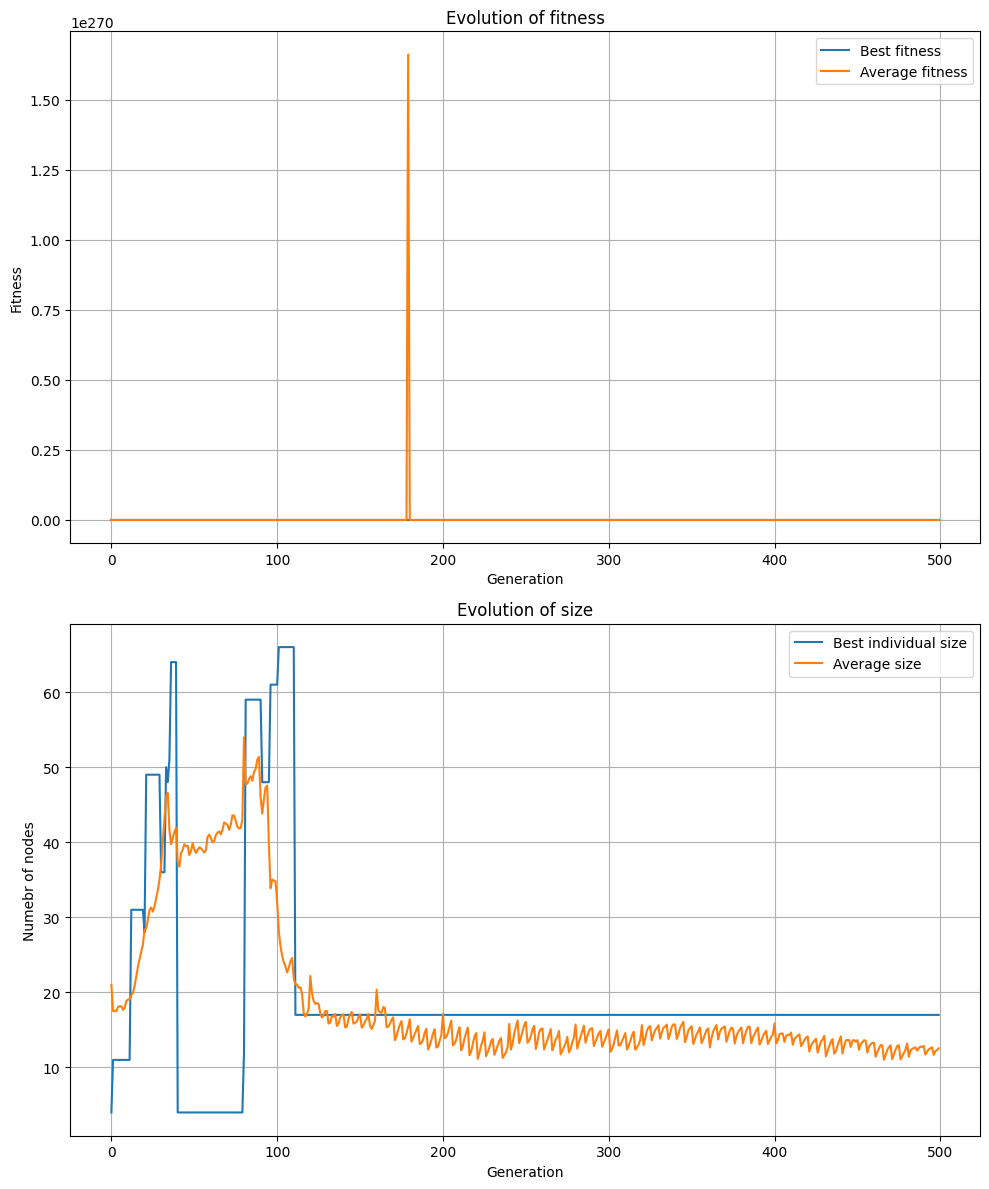

Original expression: sqrt(((x[1] - tan(-139.2438381907603)) * (sqrt(x[0]) * (88.95360858316081 * log(((x[1] - x[1]) - x[0]))))))
Simplified expression: 9.431522071392338*sqrt(sqrt(x[0])*(x[1] + 1.605583320053832)*log(-x[0]))
Best fitness(MSE): 20.3946149322377


In [378]:
print(f"\n=== GP execution on {problems[7]['file_path']} ===")
best_tree = run_gp_on_problem(problems[7]['file_path'],
    problems[7]['config'],
    function_weights=problems[7]['config'].get('function_weights'),
    terminal_weights=problems[7]['config'].get('terminal_weights'),
    use_islands=problems[7].get('use_islands', False),
    n_islands=problems[7].get('n_islands', 5),
    migration_interval=problems[7].get('migration_interval', 10),
    migration_rate=problems[7].get('migration_rate', 0.1),
)


=== GP execution on ../data/problem_8.npz ===
Loading data from ../data/problem_8.npz...
Detected format with features on rows and samples on columns, transposition...
Final form: X shape (50000, 6), y shape (50000,)
Input 6-dimensional with 50000 samples

GP execution on ../data/problem_8.npz...
Starting Genetic Programming for Symbolic Regression...
Configuration: pop_size=10000, max_depth=8, generations=500
Using adaptive mutation with strength range [0.50, 3.00]
Island model: 5 islands, migration every 40 generations
Function weights:
  +: 1.00
  -: 1.00
  *: 1.00
  /: 0.70
  sin: 0.60
  cos: 0.60
  tan: 0.50
  exp: 0.40
  log: 0.50
  sqrt: 0.60
Population initialisation of  10000 individuals...
  Generated  1000 individuals in  0.03 seconds
  Generated  2000 individuals in  0.07 seconds
  Generated  3000 individuals in  0.10 seconds
  Generated  4000 individuals in  0.14 seconds
  Generated  5000 individuals in  0.17 seconds
  Generated  6000 individuals in  0.20 seconds
  Genera

C:\Users\domen\AppData\Local\Temp\ipykernel_71816\684405357.py:22: RuntimeWarning: overflow encountered in square
  mse = np.mean((predictions - y) ** 2)
c:\Users\domen\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\_methods.py:199: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)
  0%|          | 0/500 [00:00<?, ?it/s]

Island 0 | Generation 0 | Best Fitness: 21246481.162404932 | Mutation Strength: 0.90
Island 1 | Generation 0 | Best Fitness: 21318868.24051063 | Mutation Strength: 0.90
Island 2 | Generation 0 | Best Fitness: 21156363.342873566 | Mutation Strength: 0.90
Island 3 | Generation 0 | Best Fitness: 21246481.162404932 | Mutation Strength: 0.90
Island 4 | Generation 0 | Best Fitness: 21276729.571081832 | Mutation Strength: 0.90
Bloat control: 144 individuals exceed the maximum size
Bloat control: 136 individuals exceed the maximum size
Bloat control: 98 individuals exceed the maximum size
Bloat control: 165 individuals exceed the maximum size
Bloat control: 114 individuals exceed the maximum size


  0%|          | 1/500 [01:46<14:43:31, 106.23s/it]

New best solution found:
  Expression: exp((x[5] + x[3]))
  Simplified Expression: exp(x[3] + x[5])
  Fitness: 21156363.342873566
  Complexity: 4 nodes
Generation 0, Best Fitness: 21156363.342873566


  0%|          | 2/500 [03:24<14:01:42, 101.41s/it]

New best solution found:
  Expression: ((((sqrt((cos(-7839.245705582196) - (x[3] + x[1]))) * (-13984.278477104366 * ((x[4] * x[0]) - (x[2] + -15010.329166531885)))) * (sqrt(log(log(x[1]))) - ((tan(x[2]) / (x[1] / 2.718281828459045)) * ((x[1] + 0.0) + tan(x[1]))))) - ((cos(((x[1] - x[3]) - (x[4] - 17457.083000032693))) - sqrt((exp(x[1]) * (x[3] * x[4])))) + ((((3648.4328318686858 - x[2]) * sin(x[5])) - (tan(1.0) - (x[3] - x[4]))) + (sqrt(sin(x[3])) - (sin(3.141592653589793) * (x[5] - x[4])))))) + log(log((sqrt(tan(sqrt(x[1]))) + log((sin(x[3]) - (x[5] * x[0])))))))
  Simplified Expression: -x[3] + 0.9999999999999998*x[4] + 2.33486982377251e-16*x[5] + sqrt(x[3]*x[4])*exp(x[1]/2) - (3648.4328318686858 - x[2])*sin(x[5]) + (sqrt(log(log(x[1]))) - 2.718281828459045*(x[1] + tan(x[1]))*tan(x[2])/x[1])*sqrt(-x[1] - x[3] - 0.5636198220839919)*(-13984.278477104366*x[0]*x[4] + 13984.278477104366*x[2] - 209908623.09778376) + log(log(log(-x[0]*x[5] + sin(x[3])) + sqrt(tan(sqrt(x[1]))))) - sqrt(sin(x

  1%|          | 5/500 [08:22<13:46:06, 100.13s/it]

Bloat control: 4 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 9 individuals exceed the maximum size


  1%|          | 6/500 [10:06<13:56:37, 101.61s/it]

Generation 5, Best Fitness: 15241776.849158086


  1%|▏         | 7/500 [11:46<13:51:13, 101.16s/it]

New best solution found:
  Expression: (tan(sin(sin(tan(x[1])))) + (((x[4] * x[4]) / (exp(-1142.156714253495) - (exp(sin(x[5])) + cos(exp(x[2]))))) - (x[5] * (-1523.1298523520709 + exp(x[0])))))
  Simplified Expression: x[4]**2/(-exp(sin(x[5])) - cos(exp(x[2])) + 9.28199929203135e-497) - x[5]*(exp(x[0]) - 1523.1298523520709) + tan(sin(sin(tan(x[1]))))
  Fitness: 8935596.629969237
  Complexity: 27 nodes


  2%|▏         | 10/500 [16:46<13:39:28, 100.34s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 5 individuals exceed the maximum size


  2%|▏         | 11/500 [18:37<14:04:08, 103.58s/it]

Generation 10, Best Fitness: 8935596.629969237


  3%|▎         | 14/500 [23:52<14:06:52, 104.55s/it]

New best solution found:
  Expression: ((((((1424.1319782953942 * x[5]) * cos(((3.141592653589793 - x[5]) - x[5]))) - exp((3.141592653589793 - x[5]))) * cos(exp((3.141592653589793 - x[5])))) - exp((3.141592653589793 - x[5]))) - exp((3.141592653589793 - x[5])))
  Simplified Expression: (1424.1319782953942*x[5]*cos(2*x[5] - 3.141592653589793) - 23.14069263277926*exp(-x[5]))*cos(23.14069263277926*exp(-x[5])) - 46.28138526555853*exp(-x[5])
  Fitness: 6924903.045689289
  Complexity: 31 nodes


  3%|▎         | 15/500 [25:36<14:05:44, 104.63s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 7 individuals exceed the maximum size


  3%|▎         | 16/500 [27:46<15:05:42, 112.28s/it]

Generation 15, Best Fitness: 6924903.045689289


  4%|▍         | 20/500 [34:56<14:29:07, 108.64s/it]

Bloat control: 11 individuals exceed the maximum size


  4%|▍         | 21/500 [37:01<15:08:09, 113.76s/it]

Generation 20, Best Fitness: 6924903.045689289


  5%|▌         | 25/500 [44:15<14:30:33, 109.97s/it]

Bloat control: 93 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


  5%|▌         | 26/500 [46:23<15:11:04, 115.33s/it]

Generation 25, Best Fitness: 6924903.045689289


  6%|▌         | 30/500 [53:45<14:37:36, 112.03s/it]

New best solution found:
  Expression: ((log(((((tan(x[5]) * -15978.231291975828) * 17108.141902984495) - (((1729.7322271129924 - x[1]) * 17108.141902984495) - sqrt(x[3]))) * (sqrt(-13984.278477104366) * (x[2] - (-15978.231291975828 * 17108.141902984495))))) / (exp(x[1]) - exp(x[5]))) + (((x[4] * x[4]) / (exp((sin(x[5]) * -15978.231291975828)) - exp(x[4]))) - (x[5] * -1142.156714253495)))
  Simplified Expression: log(tanx[5] * -15978.231291975828) * 17108.141902984495) - (1729.7322271129924 - x[1]) * 17108.141902984495) - sqrtx[3] * (sqrt(-13984.278477104366) * (x[2] + 15978.231291975828 * 17108.141902984495) / (expx[1] - expx[5] + (x[4] * x[4]) / (exp(sinx[5] * -15978.231291975828) - expx[4] - (x[5] * -1142.156714253495))
  Fitness: 5307428.24275112
  Complexity: 48 nodes
Bloat control: 1116 individuals exceed the maximum size
Bloat control: 230 individuals exceed the maximum size


  6%|▌         | 31/500 [56:02<15:33:06, 119.37s/it]

Generation 30, Best Fitness: 5307428.24275112


  7%|▋         | 34/500 [1:01:29<14:37:13, 112.95s/it]

New best solution found:
  Expression: ((log(x[5]) / (10057.467494193756 - exp(x[5]))) + (((x[4] * -7839.245705582196) / (x[5] - exp(x[4]))) - (x[5] * -1142.156714253495)))
  Simplified Expression: -7839.245705582196*x[4]/(x[5] - exp(x[4])) + 1142.156714253495*x[5] + log(x[5])/(10057.467494193756 - exp(x[5]))
  Fitness: 4989155.746893553
  Complexity: 20 nodes


  7%|▋         | 35/500 [1:03:24<14:39:06, 113.43s/it]

Bloat control: 1265 individuals exceed the maximum size
Bloat control: 1443 individuals exceed the maximum size


  7%|▋         | 36/500 [1:05:41<15:32:22, 120.57s/it]

Generation 35, Best Fitness: 4989155.746893553


  7%|▋         | 37/500 [1:07:30<15:02:37, 116.97s/it]

New best solution found:
  Expression: (((x[0] - ((x[2] + (x[0] + exp(x[5]))) + x[4])) - (x[1] + (x[5] + (x[0] + x[2])))) + (exp(2.718281828459045) - ((x[5] / 2203.8518267193504) - 2.718281828459045)))
  Simplified Expression: -x[0] - x[1] - 2*x[2] - x[4] - 1.0004537510135101*x[5] - exp(x[5]) + 17.87254406993831
  Fitness: 1071503.2371279846
  Complexity: 27 nodes


  8%|▊         | 39/500 [1:11:14<14:41:10, 114.69s/it]

Performing inter-island migration...
  Island 0 diversity: 0.071
  Island 1 diversity: 0.146
  Island 2 diversity: 0.007
  Island 3 diversity: 0.009


  8%|▊         | 40/500 [1:13:14<14:51:21, 116.26s/it]

  Island 4 diversity: 0.019
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.22)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.03)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.16)
Bloat control: 1383 individuals exceed the maximum size
Bloat control: 1224 individuals exceed the maximum size
Bloat control: 1489 individuals exceed the maximum size
Bloat control: 1576 individuals exceed the maximum size
Bloat control: 1454 individuals exceed the maximum size


  8%|▊         | 41/500 [1:15:35<15:44:26, 123.46s/it]

Generation 40, Best Fitness: 1071503.2371279846


  8%|▊         | 42/500 [1:17:18<14:57:11, 117.54s/it]

New best solution found:
  Expression: (((11691.94197593936 - ((exp(x[4]) + (exp(x[4]) + exp(x[5]))) + (exp(x[4]) + sqrt((-1523.1298523520709 * x[4]))))) - ((x[1] + x[5]) + (x[5] + (exp(x[4]) + exp(x[5]))))) + (exp((x[5] + x[5])) - ((((sqrt((-1523.1298523520709 * x[5])) - -1523.1298523520709) - log(exp(x[4]))) / exp(x[0])) - (sqrt(x[5]) - ((exp(x[4]) + x[5]) + x[4])))))
  Simplified Expression: -x[1] - x[4] + sqrt(x[5]) - 3*x[5] - 39.027296247012435*sqrt(-x[4]) - (-x[4] + 39.027296247012435*sqrt(-x[5]) + 1523.1298523520709)*exp(-x[0]) - 5*exp(x[4]) + exp(2*x[5]) - 2*exp(x[5]) + 11691.94197593936
  Fitness: 1042712.1291460795
  Complexity: 59 nodes


  9%|▉         | 45/500 [1:22:22<13:30:15, 106.85s/it]

Bloat control: 198 individuals exceed the maximum size
Bloat control: 1621 individuals exceed the maximum size
Bloat control: 124 individuals exceed the maximum size
Bloat control: 37 individuals exceed the maximum size
Bloat control: 61 individuals exceed the maximum size


  9%|▉         | 46/500 [1:24:29<14:14:01, 112.87s/it]

Generation 45, Best Fitness: 1042712.1291460795


 10%|█         | 50/500 [1:31:04<12:52:47, 103.04s/it]

Bloat control: 67 individuals exceed the maximum size
Bloat control: 1776 individuals exceed the maximum size
Bloat control: 29 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 38 individuals exceed the maximum size


 10%|█         | 51/500 [1:33:09<13:39:18, 109.48s/it]

Generation 50, Best Fitness: 1042712.1291460795


 11%|█         | 55/500 [1:39:32<12:17:44, 99.47s/it] 

Bloat control: 53 individuals exceed the maximum size
Bloat control: 1329 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 8 individuals exceed the maximum size
Bloat control: 32 individuals exceed the maximum size


 11%|█         | 56/500 [1:41:33<13:03:32, 105.88s/it]

Generation 55, Best Fitness: 1042712.1291460795


 12%|█▏        | 60/500 [1:48:08<12:20:58, 101.04s/it]

Bloat control: 26 individuals exceed the maximum size
Bloat control: 1706 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 6 individuals exceed the maximum size
Bloat control: 31 individuals exceed the maximum size


 12%|█▏        | 61/500 [1:50:10<13:04:47, 107.26s/it]

Generation 60, Best Fitness: 1042712.1291460795


 13%|█▎        | 65/500 [1:56:42<12:10:36, 100.77s/it]

Bloat control: 12 individuals exceed the maximum size
Bloat control: 1333 individuals exceed the maximum size
Bloat control: 11 individuals exceed the maximum size
Bloat control: 73 individuals exceed the maximum size


 13%|█▎        | 66/500 [1:58:50<13:07:37, 108.89s/it]

Generation 65, Best Fitness: 1042712.1291460795


 14%|█▍        | 70/500 [2:05:24<12:04:49, 101.14s/it]

Bloat control: 3 individuals exceed the maximum size
Bloat control: 1353 individuals exceed the maximum size
Bloat control: 35 individuals exceed the maximum size


 14%|█▍        | 71/500 [2:07:29<12:54:02, 108.26s/it]

Generation 70, Best Fitness: 1042712.1291460795


 15%|█▌        | 75/500 [2:13:50<11:34:49, 98.09s/it] 

Bloat control: 245 individuals exceed the maximum size
Bloat control: 37 individuals exceed the maximum size


 15%|█▌        | 76/500 [2:15:51<12:21:16, 104.90s/it]

Generation 75, Best Fitness: 1042712.1291460795


 16%|█▌        | 79/500 [2:20:37<11:32:11, 98.65s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.022
  Island 1 diversity: 0.082
  Island 2 diversity: 0.015
  Island 3 diversity: 0.025


 16%|█▌        | 80/500 [2:22:20<11:40:01, 100.00s/it]

  Island 4 diversity: 0.025
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.18)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.03)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 48 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 16%|█▌        | 81/500 [2:24:16<12:09:58, 104.53s/it]

Generation 80, Best Fitness: 1042712.1291460795


 17%|█▋        | 85/500 [2:30:29<11:02:06, 95.73s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 13 individuals exceed the maximum size


 17%|█▋        | 86/500 [2:32:23<11:38:32, 101.24s/it]

Generation 85, Best Fitness: 1042712.1291460795


 18%|█▊        | 90/500 [2:38:35<10:49:31, 95.05s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 18%|█▊        | 91/500 [2:40:30<11:27:17, 100.82s/it]

Generation 90, Best Fitness: 1042712.1291460795


 19%|█▉        | 95/500 [2:46:44<10:44:04, 95.42s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 19%|█▉        | 96/500 [2:48:38<11:20:00, 100.99s/it]

Generation 95, Best Fitness: 1042712.1291460795


 20%|██        | 100/500 [2:54:55<10:36:28, 95.47s/it]

Island 0 | Generation 100 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 1 | Generation 100 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 2 | Generation 100 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 3 | Generation 100 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 4 | Generation 100 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00


 20%|██        | 101/500 [2:56:49<11:12:46, 101.17s/it]

Generation 100, Best Fitness: 1042712.1291460795


 21%|██        | 105/500 [3:03:04<10:27:54, 95.38s/it] 

Bloat control: 1 individuals exceed the maximum size


 21%|██        | 106/500 [3:04:57<11:01:11, 100.69s/it]

Generation 105, Best Fitness: 1042712.1291460795


 22%|██▏       | 110/500 [3:11:12<10:21:29, 95.61s/it] 

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 22%|██▏       | 111/500 [3:13:06<10:56:05, 101.20s/it]

Generation 110, Best Fitness: 1042712.1291460795


 23%|██▎       | 116/500 [3:21:16<10:50:24, 101.63s/it]

Generation 115, Best Fitness: 1042712.1291460795


 24%|██▍       | 119/500 [3:25:58<10:13:08, 96.56s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.021
  Island 1 diversity: 0.022
  Island 2 diversity: 0.018
  Island 3 diversity: 0.021


 24%|██▍       | 120/500 [3:27:39<10:21:00, 98.05s/it]

  Island 4 diversity: 0.026
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.01)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.01)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 4 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 24%|██▍       | 121/500 [3:29:35<10:54:12, 103.57s/it]

Generation 120, Best Fitness: 1042712.1291460795


 25%|██▌       | 125/500 [3:35:49<9:57:21, 95.58s/it]  

Bloat control: 3 individuals exceed the maximum size
Bloat control: 3 individuals exceed the maximum size


 25%|██▌       | 126/500 [3:37:45<10:35:08, 101.89s/it]

Generation 125, Best Fitness: 1042712.1291460795


 26%|██▌       | 130/500 [3:43:57<9:46:51, 95.17s/it]  

Bloat control: 16 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 26%|██▌       | 131/500 [3:45:51<10:19:54, 100.80s/it]

Generation 130, Best Fitness: 1042712.1291460795


 27%|██▋       | 135/500 [3:52:03<9:37:36, 94.95s/it]  

Bloat control: 7 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 27%|██▋       | 136/500 [3:53:57<10:10:17, 100.60s/it]

Generation 135, Best Fitness: 1042712.1291460795


 28%|██▊       | 140/500 [4:00:08<9:27:46, 94.63s/it]  

Bloat control: 1 individuals exceed the maximum size


 28%|██▊       | 141/500 [4:01:59<9:54:50, 99.42s/it]

Generation 140, Best Fitness: 1042712.1291460795


 29%|██▉       | 145/500 [4:08:13<9:22:11, 95.02s/it]

Bloat control: 1 individuals exceed the maximum size


 29%|██▉       | 146/500 [4:10:06<9:52:07, 100.36s/it]

Generation 145, Best Fitness: 1042712.1291460795


 30%|███       | 150/500 [4:16:16<9:11:25, 94.53s/it] 

Bloat control: 1 individuals exceed the maximum size


 30%|███       | 151/500 [4:18:07<9:38:01, 99.37s/it]

Generation 150, Best Fitness: 1042712.1291460795


 31%|███       | 155/500 [4:24:18<9:05:59, 94.95s/it]

Bloat control: 1 individuals exceed the maximum size


 31%|███       | 156/500 [4:26:09<9:31:03, 99.60s/it]

Generation 155, Best Fitness: 1042712.1291460795


 32%|███▏      | 159/500 [4:30:47<8:59:58, 95.01s/it]

Performing inter-island migration...
  Island 0 diversity: 0.028
  Island 1 diversity: 0.029
  Island 2 diversity: 0.019
  Island 3 diversity: 0.025
  Island 4 diversity: 0.026
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.02)


 32%|███▏      | 160/500 [4:32:30<9:11:48, 97.38s/it]

  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 32%|███▏      | 161/500 [4:34:21<9:33:54, 101.58s/it]

Generation 160, Best Fitness: 1042712.1291460795


 33%|███▎      | 166/500 [4:42:19<9:09:50, 98.77s/it] 

Generation 165, Best Fitness: 1042712.1291460795


 34%|███▍      | 170/500 [4:48:30<8:39:10, 94.40s/it]

Bloat control: 1 individuals exceed the maximum size


 34%|███▍      | 171/500 [4:50:18<8:59:05, 98.31s/it]

Generation 170, Best Fitness: 1042712.1291460795


 35%|███▌      | 176/500 [4:58:12<8:43:59, 97.03s/it]

Generation 175, Best Fitness: 1042712.1291460795


 36%|███▌      | 181/500 [5:06:09<8:34:01, 96.68s/it]

Generation 180, Best Fitness: 1042712.1291460795


 37%|███▋      | 186/500 [5:14:08<8:29:38, 97.38s/it]

Generation 185, Best Fitness: 1042712.1291460795


 38%|███▊      | 190/500 [5:20:23<8:11:09, 95.06s/it]

Bloat control: 2 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 38%|███▊      | 191/500 [5:22:08<8:24:58, 98.05s/it]

Generation 190, Best Fitness: 1042712.1291460795


 39%|███▉      | 195/500 [5:28:19<7:56:12, 93.68s/it]

Bloat control: 1 individuals exceed the maximum size


 39%|███▉      | 196/500 [5:30:04<8:12:55, 97.29s/it]

Generation 195, Best Fitness: 1042712.1291460795


 40%|███▉      | 199/500 [5:34:45<7:55:41, 94.82s/it]

Performing inter-island migration...
  Island 0 diversity: 0.029
  Island 1 diversity: 0.029
  Island 2 diversity: 0.028
  Island 3 diversity: 0.023


 40%|████      | 200/500 [5:36:27<8:04:34, 96.92s/it]

  Island 4 diversity: 0.029
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Island 0 | Generation 200 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 1 | Generation 200 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 2 | Generation 200 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 3 | Generation 200 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 4 | Generation 200 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Bloat control: 1 individuals exceed the maximum size


 40%|████      | 201/500 [5:38:10<8:13:25, 99.01s/it]

Generation 200, Best Fitness: 1042712.1291460795


 41%|████      | 206/500 [5:46:02<7:51:41, 96.26s/it]

Generation 205, Best Fitness: 1042712.1291460795


 42%|████▏     | 211/500 [5:53:57<7:40:54, 95.69s/it]

Generation 210, Best Fitness: 1042712.1291460795


 43%|████▎     | 216/500 [6:01:51<7:33:51, 95.89s/it]

Generation 215, Best Fitness: 1042712.1291460795


 44%|████▍     | 221/500 [6:09:51<7:31:01, 96.99s/it]

Generation 220, Best Fitness: 1042712.1291460795


 45%|████▌     | 226/500 [6:17:46<7:19:30, 96.24s/it]

Generation 225, Best Fitness: 1042712.1291460795


 46%|████▌     | 231/500 [6:25:39<7:09:21, 95.77s/it]

Generation 230, Best Fitness: 1042712.1291460795


 47%|████▋     | 235/500 [6:31:59<6:58:12, 94.69s/it]

Bloat control: 1 individuals exceed the maximum size


 47%|████▋     | 236/500 [6:33:38<7:01:55, 95.89s/it]

Generation 235, Best Fitness: 1042712.1291460795


 48%|████▊     | 239/500 [6:38:20<6:53:46, 95.12s/it]

Performing inter-island migration...
  Island 0 diversity: 0.030
  Island 1 diversity: 0.030
  Island 2 diversity: 0.028
  Island 3 diversity: 0.021


 48%|████▊     | 240/500 [6:40:03<7:01:43, 97.32s/it]

  Island 4 diversity: 0.027
  Migration: 300 individuals from island 0 to island 1(mutation strength: 1.00)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 48%|████▊     | 241/500 [6:41:41<7:01:53, 97.73s/it]

Generation 240, Best Fitness: 1042712.1291460795


 49%|████▉     | 245/500 [6:48:01<6:46:25, 95.63s/it]

Bloat control: 1 individuals exceed the maximum size


 49%|████▉     | 246/500 [6:49:40<6:49:03, 96.63s/it]

Generation 245, Best Fitness: 1042712.1291460795


 50%|█████     | 250/500 [6:55:51<6:30:02, 93.61s/it]

Bloat control: 1 individuals exceed the maximum size


 50%|█████     | 251/500 [6:57:35<6:40:55, 96.61s/it]

Generation 250, Best Fitness: 1042712.1291460795


 51%|█████     | 256/500 [7:05:24<6:26:43, 95.10s/it]

Generation 255, Best Fitness: 1042712.1291460795


 52%|█████▏    | 261/500 [7:13:22<6:23:05, 96.18s/it]

Generation 260, Best Fitness: 1042712.1291460795


 53%|█████▎    | 265/500 [7:19:36<6:10:02, 94.48s/it]

Bloat control: 1 individuals exceed the maximum size


 53%|█████▎    | 266/500 [7:21:15<6:14:24, 96.00s/it]

Generation 265, Best Fitness: 1042712.1291460795


 54%|█████▍    | 271/500 [7:29:10<6:09:29, 96.81s/it]

Generation 270, Best Fitness: 1042712.1291460795


 55%|█████▌    | 275/500 [7:35:18<5:50:24, 93.44s/it]

Bloat control: 1 individuals exceed the maximum size


 55%|█████▌    | 276/500 [7:36:59<5:57:04, 95.64s/it]

Generation 275, Best Fitness: 1042712.1291460795


 56%|█████▌    | 279/500 [7:41:39<5:46:20, 94.03s/it]

Performing inter-island migration...
  Island 0 diversity: 0.029
  Island 1 diversity: 0.029
  Island 2 diversity: 0.025
  Island 3 diversity: 0.022


 56%|█████▌    | 280/500 [7:43:20<5:53:00, 96.28s/it]

  Island 4 diversity: 0.029
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 0.50)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.02)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.00)
Bloat control: 3 individuals exceed the maximum size


 56%|█████▌    | 281/500 [7:45:01<5:56:08, 97.57s/it]

Generation 280, Best Fitness: 1042712.1291460795


 57%|█████▋    | 285/500 [7:51:09<5:35:16, 93.56s/it]

Bloat control: 12 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 57%|█████▋    | 286/500 [7:52:50<5:41:27, 95.74s/it]

Generation 285, Best Fitness: 1042712.1291460795


 58%|█████▊    | 290/500 [7:59:04<5:28:07, 93.75s/it]

Bloat control: 6 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 58%|█████▊    | 291/500 [8:00:51<5:41:00, 97.90s/it]

Generation 290, Best Fitness: 1042712.1291460795


 59%|█████▉    | 295/500 [8:07:08<5:25:41, 95.32s/it]

Bloat control: 9 individuals exceed the maximum size


 59%|█████▉    | 296/500 [8:08:51<5:32:00, 97.65s/it]

Generation 295, Best Fitness: 1042712.1291460795


 60%|██████    | 300/500 [8:15:12<5:18:05, 95.43s/it]

Island 0 | Generation 300 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 1 | Generation 300 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 2 | Generation 300 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 3 | Generation 300 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 4 | Generation 300 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00


 60%|██████    | 301/500 [8:16:54<5:22:45, 97.31s/it]

Generation 300, Best Fitness: 1042712.1291460795


 61%|██████    | 306/500 [8:24:53<5:14:53, 97.39s/it]

Generation 305, Best Fitness: 1042712.1291460795


 62%|██████▏   | 311/500 [8:33:00<5:10:20, 98.52s/it]

Generation 310, Best Fitness: 1042712.1291460795


 63%|██████▎   | 316/500 [8:41:10<5:00:08, 97.87s/it]

Generation 315, Best Fitness: 1042712.1291460795


 64%|██████▍   | 319/500 [8:45:49<4:44:41, 94.37s/it]

Performing inter-island migration...
  Island 0 diversity: 0.035
  Island 1 diversity: 0.024
  Island 2 diversity: 0.030
  Island 3 diversity: 0.030


 64%|██████▍   | 320/500 [8:47:29<4:48:24, 96.14s/it]

  Island 4 diversity: 0.025
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 1.00)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.03)
Bloat control: 3 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size
Bloat control: 2 individuals exceed the maximum size


 64%|██████▍   | 321/500 [8:49:09<4:50:31, 97.38s/it]

Generation 320, Best Fitness: 1042712.1291460795


 65%|██████▌   | 326/500 [8:57:02<4:38:46, 96.13s/it]

Generation 325, Best Fitness: 1042712.1291460795


 66%|██████▌   | 330/500 [9:03:17<4:27:15, 94.33s/it]

Bloat control: 1 individuals exceed the maximum size
Bloat control: 1 individuals exceed the maximum size


 66%|██████▌   | 331/500 [9:04:58<4:31:14, 96.30s/it]

Generation 330, Best Fitness: 1042712.1291460795


 67%|██████▋   | 336/500 [9:12:55<4:25:04, 96.98s/it]

Generation 335, Best Fitness: 1042712.1291460795


 68%|██████▊   | 341/500 [9:20:49<4:14:25, 96.01s/it]

Generation 340, Best Fitness: 1042712.1291460795


 69%|██████▉   | 346/500 [9:28:42<4:06:13, 95.93s/it]

Generation 345, Best Fitness: 1042712.1291460795


 70%|███████   | 350/500 [9:34:55<3:54:38, 93.85s/it]

Bloat control: 1 individuals exceed the maximum size


 70%|███████   | 351/500 [9:36:35<3:58:00, 95.84s/it]

Generation 350, Best Fitness: 1042712.1291460795


 71%|███████   | 355/500 [9:42:46<3:45:45, 93.41s/it]

Bloat control: 1 individuals exceed the maximum size


 71%|███████   | 356/500 [9:44:32<3:53:31, 97.30s/it]

Generation 355, Best Fitness: 1042712.1291460795


 72%|███████▏  | 359/500 [9:49:11<3:41:45, 94.37s/it]

Performing inter-island migration...
  Island 0 diversity: 0.030
  Island 1 diversity: 0.022
  Island 2 diversity: 0.034
  Island 3 diversity: 0.029


 72%|███████▏  | 360/500 [9:50:53<3:45:27, 96.62s/it]

  Island 4 diversity: 0.028
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 1.01)
Bloat control: 1 individuals exceed the maximum size


 72%|███████▏  | 361/500 [9:52:35<3:47:22, 98.15s/it]

Generation 360, Best Fitness: 1042712.1291460795


 73%|███████▎  | 365/500 [9:58:52<3:33:47, 95.02s/it]

Bloat control: 1 individuals exceed the maximum size


 73%|███████▎  | 366/500 [10:00:33<3:36:26, 96.92s/it]

Generation 365, Best Fitness: 1042712.1291460795


 74%|███████▍  | 371/500 [10:13:26<5:40:58, 158.59s/it]

Generation 370, Best Fitness: 1042712.1291460795


 75%|███████▌  | 376/500 [10:22:36<3:54:24, 113.43s/it]

Generation 375, Best Fitness: 1042712.1291460795


 76%|███████▌  | 381/500 [10:30:54<3:27:24, 104.58s/it]

Generation 380, Best Fitness: 1042712.1291460795


 77%|███████▋  | 386/500 [10:38:47<3:05:10, 97.46s/it] 

Generation 385, Best Fitness: 1042712.1291460795


 78%|███████▊  | 391/500 [10:50:07<4:01:42, 133.05s/it]

Generation 390, Best Fitness: 1042712.1291460795


 79%|███████▉  | 396/500 [10:58:00<2:57:28, 102.39s/it]

Generation 395, Best Fitness: 1042712.1291460795


 80%|███████▉  | 399/500 [11:02:42<2:43:06, 96.89s/it] 

Performing inter-island migration...
  Island 0 diversity: 0.029
  Island 1 diversity: 0.025
  Island 2 diversity: 0.030
  Island 3 diversity: 0.029


 80%|████████  | 400/500 [11:04:26<2:45:12, 99.12s/it]

  Island 4 diversity: 0.032
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.02)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.01)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Island 0 | Generation 400 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 1 | Generation 400 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 2 | Generation 400 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 3 | Generation 400 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00
Island 4 | Generation 400 | Best Fitness: 1042712.1291460795 | Mutation Strength: 3.00


 80%|████████  | 401/500 [11:06:13<2:47:14, 101.36s/it]

Generation 400, Best Fitness: 1042712.1291460795


 81%|████████  | 405/500 [11:12:21<2:29:39, 94.52s/it] 

Bloat control: 1 individuals exceed the maximum size


 81%|████████  | 406/500 [11:14:06<2:32:49, 97.55s/it]

Generation 405, Best Fitness: 1042712.1291460795


 82%|████████▏ | 411/500 [11:22:05<2:24:13, 97.23s/it]

Generation 410, Best Fitness: 1042712.1291460795


 83%|████████▎ | 415/500 [11:28:21<2:15:41, 95.78s/it]

Bloat control: 1 individuals exceed the maximum size


 83%|████████▎ | 416/500 [11:30:04<2:17:05, 97.93s/it]

Generation 415, Best Fitness: 1042712.1291460795


 84%|████████▍ | 421/500 [11:38:03<2:08:19, 97.46s/it]

Generation 420, Best Fitness: 1042712.1291460795


 85%|████████▌ | 426/500 [11:46:00<1:59:41, 97.05s/it]

Generation 425, Best Fitness: 1042712.1291460795


 86%|████████▌ | 431/500 [11:54:01<1:52:43, 98.02s/it]

Generation 430, Best Fitness: 1042712.1291460795


 87%|████████▋ | 436/500 [12:01:59<1:43:51, 97.36s/it]

Generation 435, Best Fitness: 1042712.1291460795


 88%|████████▊ | 439/500 [12:06:43<1:37:07, 95.54s/it]

Performing inter-island migration...
  Island 0 diversity: 0.029
  Island 1 diversity: 0.022
  Island 2 diversity: 0.033
  Island 3 diversity: 0.031


 88%|████████▊ | 440/500 [12:08:25<1:37:27, 97.46s/it]

  Island 4 diversity: 0.030
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.03)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 0.50)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size


 88%|████████▊ | 441/500 [12:10:07<1:36:59, 98.63s/it]

Generation 440, Best Fitness: 1042712.1291460795


 89%|████████▉ | 446/500 [12:18:07<1:28:12, 98.01s/it]

Generation 445, Best Fitness: 1042712.1291460795


 90%|█████████ | 451/500 [12:26:04<1:19:26, 97.28s/it]

Generation 450, Best Fitness: 1042712.1291460795


 91%|█████████ | 455/500 [12:32:20<1:11:20, 95.12s/it]

Bloat control: 1 individuals exceed the maximum size


 91%|█████████ | 456/500 [12:34:25<1:16:12, 103.92s/it]

Generation 455, Best Fitness: 1042712.1291460795


 92%|█████████▏| 461/500 [12:47:28<1:30:42, 139.56s/it]

Generation 460, Best Fitness: 1042712.1291460795


 93%|█████████▎| 465/500 [12:55:15<1:11:08, 121.95s/it]

Bloat control: 1 individuals exceed the maximum size


 93%|█████████▎| 466/500 [12:57:28<1:10:55, 125.16s/it]

Generation 465, Best Fitness: 1042712.1291460795


 94%|█████████▍| 471/500 [13:07:53<1:01:25, 127.07s/it]

Generation 470, Best Fitness: 1042712.1291460795


 95%|█████████▌| 476/500 [13:17:39<48:10, 120.42s/it]  

Generation 475, Best Fitness: 1042712.1291460795


 96%|█████████▌| 479/500 [13:23:23<40:46, 116.48s/it]

Performing inter-island migration...
  Island 0 diversity: 0.029
  Island 1 diversity: 0.027
  Island 2 diversity: 0.029
  Island 3 diversity: 0.029


 96%|█████████▌| 480/500 [13:25:29<39:47, 119.35s/it]

  Island 4 diversity: 0.029
  Migration: 300 individuals from island 0 to island 1(mutation strength: 0.50)
  Migration: 300 individuals from island 1 to island 2(mutation strength: 1.01)
  Migration: 300 individuals from island 2 to island 3(mutation strength: 0.50)
  Migration: 300 individuals from island 3 to island 4(mutation strength: 1.00)
  Migration: 300 individuals from island 4 to island 0(mutation strength: 0.50)
Bloat control: 1 individuals exceed the maximum size


 96%|█████████▌| 481/500 [13:27:36<38:33, 121.75s/it]

Generation 480, Best Fitness: 1042712.1291460795


 97%|█████████▋| 485/500 [13:35:14<28:59, 115.99s/it]

Bloat control: 1 individuals exceed the maximum size


 97%|█████████▋| 486/500 [13:37:21<27:50, 119.34s/it]

Generation 485, Best Fitness: 1042712.1291460795


 98%|█████████▊| 491/500 [13:49:27<22:10, 147.85s/it]

Generation 490, Best Fitness: 1042712.1291460795


 99%|█████████▉| 496/500 [13:59:27<08:22, 125.69s/it]

Generation 495, Best Fitness: 1042712.1291460795


100%|██████████| 500/500 [14:06:41<00:00, 101.60s/it]

Generation 499, Best Fitness: 1042712.1291460795
Algorithm completed in 51231.75 seconds
Best solution found:
  Simplified Expression: -x[1] - x[4] + sqrt(x[5]) - 3*x[5] - 39.027296247012435*sqrt(-x[4]) - (-x[4] + 39.027296247012435*sqrt(-x[5]) + 1523.1298523520709)*exp(-x[0]) - 5*exp(x[4]) + exp(2*x[5]) - 2*exp(x[5]) + 11691.94197593936
  Expression: (((11691.94197593936 - ((exp(x[4]) + (exp(x[4]) + exp(x[5]))) + (exp(x[4]) + sqrt((-1523.1298523520709 * x[4]))))) - ((x[1] + x[5]) + (x[5] + (exp(x[4]) + exp(x[5]))))) + (exp((x[5] + x[5])) - ((((sqrt((-1523.1298523520709 * x[5])) - -1523.1298523520709) - log(exp(x[4]))) / exp(x[0])) - (sqrt(x[5]) - ((exp(x[4]) + x[5]) + x[4])))))
  Fitness: 1042712.1291460795
  Complexity: 59 nodes


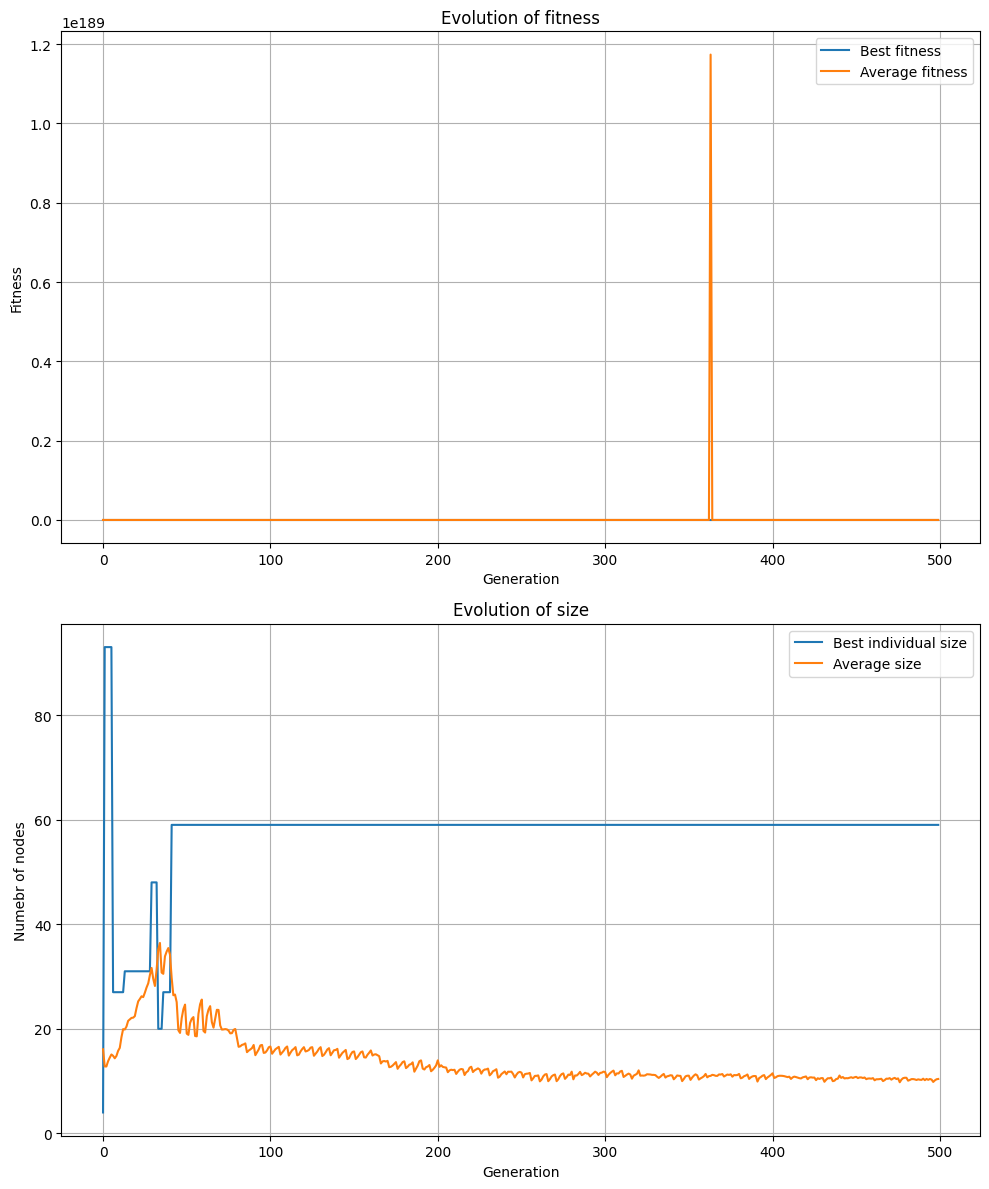

Original expression: (((11691.94197593936 - ((exp(x[4]) + (exp(x[4]) + exp(x[5]))) + (exp(x[4]) + sqrt((-1523.1298523520709 * x[4]))))) - ((x[1] + x[5]) + (x[5] + (exp(x[4]) + exp(x[5]))))) + (exp((x[5] + x[5])) - ((((sqrt((-1523.1298523520709 * x[5])) - -1523.1298523520709) - log(exp(x[4]))) / exp(x[0])) - (sqrt(x[5]) - ((exp(x[4]) + x[5]) + x[4])))))
Simplified expression: -x[1] - x[4] + sqrt(x[5]) - 3*x[5] - 39.027296247012435*sqrt(-x[4]) - (-x[4] + 39.027296247012435*sqrt(-x[5]) + 1523.1298523520709)*exp(-x[0]) - 5*exp(x[4]) + exp(2*x[5]) - 2*exp(x[5]) + 11691.94197593936
Best fitness(MSE): 1042712.1291460795


In [379]:
print(f"\n=== GP execution on {problems[8]['file_path']} ===")
best_tree = run_gp_on_problem(problems[8]['file_path'],
    problems[8]['config'],
    function_weights=problems[8]['config'].get('function_weights'),
    terminal_weights=problems[8]['config'].get('terminal_weights'),
    use_islands=problems[8].get('use_islands', False),
    n_islands=problems[8].get('n_islands', 5),
    migration_interval=problems[8].get('migration_interval', 10),
    migration_rate=problems[8].get('migration_rate', 0.1),
)  